In [2]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
%load_ext autoreload
%autoreload 2

In [8]:
""""class TestStat:
    def __init__(self, uf, oob_func, n_jobs=1):
        self.uf = uf
        self.fit_ = False
        
    def statistic(self, X, y):
        y = y.ravel()
        if not self.fit_:
            self.uf = self.uf.fit(X, y)
            if hasattr(self, "leaf_indices_"):
                del self.leaf_indices_
            self.fit_ = True
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.apply(X[voter_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return H_Y - H_YX

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, leaf_indices, voter_indices in zip(self.uf.transformers_, self.leaf_indices_, self.uf.voter_indices_):
        # for tree_idx, (leaf_indices, voter_indices) in enumerate(zip(self.leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0
            # print(tree.tree_.value.shape)
            # print(leaf_indices)

            for leaf_id, yval in zip(leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1
                # posteriors[leaf_id,]

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[voter_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(entropy(posteriors, base=np.exp(1), axis=1))
""""""

In [3]:
class UFTest:
    def __init__(self, uf):
        self.uf = uf
        self.fit_ = False
        
    def statistic(self, X, y):
        y = y.ravel()
        if not self.fit_:
            self.uf = self.uf.fit(X, y)
            if hasattr(self, "honest_leaf_indices_"):
                assert hasattr(self, "transformer_leaf_indices_")
                del self.honest_leaf_indices_
                del self.transformer_leaf_indices_
            self.fit_ = True
        if not hasattr(self, "honest_leaf_indices_"):
            self.honest_leaf_indices_ = []
            self.transformer_leaf_indices_ = []
            for tree, voter_indices, transformer_indices in zip(self.uf.transformers_, self.uf.voter_indices_, self.uf.transformer_indices_):
                self.honest_leaf_indices_.append(tree.apply(X[voter_indices]))
                self.transformer_leaf_indices_.append(tree.apply(X[transformer_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return max(H_Y - H_YX, 0)

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, honest_leaf_indices, voter_indices, tranformer_leaf_indices, transformer_indices in zip(
            self.uf.transformers_, self.honest_leaf_indices_, self.uf.voter_indices_, self.transformer_leaf_indices_, self.uf.transformer_indices_):
        # for tree_idx, (honest_leaf_indices, voter_indices) in enumerate(zip(self.honest_leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            for leaf_id, yval in zip(honest_leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1

            leaf_indices = np.hstack((honest_leaf_indices, tranformer_leaf_indices))
            sample_indices = np.hstack((voter_indices, transformer_indices))

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[sample_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(entropy(posteriors, base=np.exp(1), axis=1))


In [13]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 19
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
#MAX_SAMPLE_SIZE = 81
#STEP_SIZE = 19
#SAMP_SIZES = range(81, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 500

In [11]:
""""def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat.statistic(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    
    #Calculate the p-value via permutation
    
    # calculate observed test statistic
    stat = calc_stat.statistic(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)


    return stat, pvalue"""
    
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat.statistic(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    if hasattr(calc_stat, "fit_"):
        calc_stat.fit_ = False
    stat = calc_stat.statistic(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)

    return stat, pvalue, null_dist

In [15]:
def estimate_power(sim, test):
    
    est_power = []
    for i in tqdm(SAMP_SIZES):
        print("sample size" + str(i))
        print(sim)
    
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=i, p=1, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=1.0,
                n_jobs=-2,
            )
            
            uf = uf.fit(X, y)
            print('Fitted')

            reps = 1000
            test = UFTest(uf)
            stat, pvalue, null_dist = perm_test(test, X, y, reps=reps)
            print("Test Statistic: ", stat)
            print("p-value: ", pvalue)

            """"
            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = UFTest(uf, ce)

            reps = 1000
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            """
            pvalues.append(pvalue)
            with open("./type_vs_attributes_test.csv", "w") as f:
                f.write(f"Test Statistic,p-value\n{stat},{pvalue}")
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    #np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}4_28_HonestSampling_100_estimators_1000_reps.csv'.format(sim, "UF"),
            #est_power, delimiter=',')
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}5_18_multimodal_500_power_reps.csv'.format(sim, "UF"), est_power, delimiter=',')
    
    return est_power

In [ ]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    if sim_name != 'linear' and sim_name != 'exponential' and sim_name!= 'cubic' and sim_name != 'joint_normal' and sim_name != 'step' and sim_name != 'quadratic' and sim_name != 'w_shaped' and sim_name != 'spiral':
        power = estimate_power(sim_name, "UF")

In [17]:
#if sim_name == 'multiplicative_noise' or sim_name == 'multimodal_independence': 
estimate_power('multimodal_independence', 'UF')

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

sample size5
multimodal_independence
(10, 2)
(10,)
Fitted



  0%|▏                                                                               | 1/500 [00:10<1:29:58, 10.82s/it]

Test Statistic:  0.016424342499689715
p-value:  0.6083916083916084
(10, 2)
(10,)
Fitted



  0%|▎                                                                               | 2/500 [00:21<1:28:50, 10.70s/it]

Test Statistic:  0.026125256801091346
p-value:  0.5504495504495505
(10, 2)
(10,)
Fitted



  1%|▍                                                                               | 3/500 [00:31<1:28:16, 10.66s/it]

Test Statistic:  0.00938365934266605
p-value:  0.8831168831168831
(10, 2)
(10,)
Fitted



  1%|▋                                                                               | 4/500 [00:42<1:27:26, 10.58s/it]

Test Statistic:  0.017296952195101523
p-value:  0.5984015984015985
(10, 2)
(10,)
Fitted



  1%|▊                                                                               | 5/500 [00:52<1:27:25, 10.60s/it]

Test Statistic:  0.014385904333084398
p-value:  0.7612387612387612
(10, 2)
(10,)
Fitted



  1%|▉                                                                               | 6/500 [01:03<1:28:19, 10.73s/it]

Test Statistic:  0.16980302750823273
p-value:  0.08891108891108891
(10, 2)
(10,)
Fitted



  1%|█                                                                               | 7/500 [01:15<1:30:38, 11.03s/it]

Test Statistic:  0.007291032488255356
p-value:  0.9120879120879121
(10, 2)
(10,)
Fitted



  2%|█▎                                                                              | 8/500 [01:25<1:28:41, 10.82s/it]

Test Statistic:  0.0007749257227145367
p-value:  1.0
(10, 2)
(10,)
Fitted



  2%|█▍                                                                              | 9/500 [01:36<1:29:05, 10.89s/it]

Test Statistic:  0.0024228474538238176
p-value:  1.0
(10, 2)
(10,)
Fitted



  2%|█▌                                                                             | 10/500 [01:47<1:27:59, 10.77s/it]

Test Statistic:  0.14360108779663305
p-value:  0.028971028971028972
(10, 2)
(10,)
Fitted



  2%|█▋                                                                             | 11/500 [01:57<1:26:54, 10.66s/it]

Test Statistic:  0.025274020462774383
p-value:  0.45254745254745254
(10, 2)
(10,)
Fitted



  2%|█▉                                                                             | 12/500 [02:08<1:26:18, 10.61s/it]

Test Statistic:  0.023798763086276042
p-value:  0.6223776223776224
(10, 2)
(10,)
Fitted



  3%|██                                                                             | 13/500 [02:18<1:25:57, 10.59s/it]

Test Statistic:  0.019044333250520795
p-value:  0.6013986013986014
(10, 2)
(10,)
Fitted



  3%|██▏                                                                            | 14/500 [02:29<1:25:11, 10.52s/it]

Test Statistic:  0.0074754326930931425
p-value:  0.9140859140859141
(10, 2)
(10,)
Fitted



  3%|██▎                                                                            | 15/500 [02:40<1:26:11, 10.66s/it]

Test Statistic:  0.023638347191459297
p-value:  0.5754245754245755
(10, 2)
(10,)
Fitted



  3%|██▌                                                                            | 16/500 [02:51<1:27:42, 10.87s/it]

Test Statistic:  0.005582289394703954
p-value:  0.9790209790209791
(10, 2)
(10,)
Fitted



  3%|██▋                                                                            | 17/500 [03:02<1:27:44, 10.90s/it]

Test Statistic:  0.002679312734359729
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



  4%|██▊                                                                            | 18/500 [03:13<1:28:11, 10.98s/it]

Test Statistic:  0.08046567374760183
p-value:  0.18081918081918083
(10, 2)
(10,)
Fitted



  4%|███                                                                            | 19/500 [03:24<1:28:37, 11.06s/it]

Test Statistic:  0.021515541696442764
p-value:  0.5184815184815185
(10, 2)
(10,)
Fitted



  4%|███▏                                                                           | 20/500 [03:35<1:26:25, 10.80s/it]

Test Statistic:  0.014839932614979734
p-value:  0.7252747252747253
(10, 2)
(10,)
Fitted



  4%|███▎                                                                           | 21/500 [03:45<1:25:20, 10.69s/it]

Test Statistic:  0.013887232381378123
p-value:  0.7242757242757243
(10, 2)
(10,)
Fitted



  4%|███▍                                                                           | 22/500 [03:55<1:23:46, 10.52s/it]

Test Statistic:  0.05608161920667698
p-value:  0.27472527472527475
(10, 2)
(10,)
Fitted



  5%|███▋                                                                           | 23/500 [04:07<1:25:31, 10.76s/it]

Test Statistic:  0.005058697655186628
p-value:  0.965034965034965
(10, 2)
(10,)
Fitted



  5%|███▊                                                                           | 24/500 [04:18<1:27:08, 10.98s/it]

Test Statistic:  0.026432612060478866
p-value:  0.44455544455544455
(10, 2)
(10,)
Fitted



  5%|███▉                                                                           | 25/500 [04:29<1:27:03, 11.00s/it]

Test Statistic:  0.010642547730054575
p-value:  0.949050949050949
(10, 2)
(10,)
Fitted



  5%|████                                                                           | 26/500 [04:39<1:24:18, 10.67s/it]

Test Statistic:  0.19187895587587933
p-value:  0.04595404595404595
(10, 2)
(10,)
Fitted



  5%|████▎                                                                          | 27/500 [04:50<1:24:21, 10.70s/it]

Test Statistic:  0.018007397361089583
p-value:  0.7432567432567433
(10, 2)
(10,)
Fitted



  6%|████▍                                                                          | 28/500 [05:01<1:25:17, 10.84s/it]

Test Statistic:  0.023226685736760455
p-value:  0.6433566433566433
(10, 2)
(10,)
Fitted



  6%|████▌                                                                          | 29/500 [05:11<1:24:22, 10.75s/it]

Test Statistic:  0.0235944552190972
p-value:  0.48451548451548454
(10, 2)
(10,)
Fitted



  6%|████▋                                                                          | 30/500 [05:22<1:23:52, 10.71s/it]

Test Statistic:  0.016891184425042116
p-value:  0.7102897102897103
(10, 2)
(10,)
Fitted



  6%|████▉                                                                          | 31/500 [05:32<1:22:44, 10.58s/it]

Test Statistic:  0.09645132949099822
p-value:  0.17582417582417584
(10, 2)
(10,)
Fitted



  6%|█████                                                                          | 32/500 [05:43<1:22:13, 10.54s/it]

Test Statistic:  0.027475437296193728
p-value:  0.3826173826173826
(10, 2)
(10,)
Fitted



  7%|█████▏                                                                         | 33/500 [05:54<1:23:17, 10.70s/it]

Test Statistic:  0.00480941724082784
p-value:  0.975024975024975
(10, 2)
(10,)
Fitted



  7%|█████▎                                                                         | 34/500 [06:05<1:24:42, 10.91s/it]

Test Statistic:  0.04494230500637053
p-value:  0.2907092907092907
(10, 2)
(10,)
Fitted



  7%|█████▌                                                                         | 35/500 [06:16<1:24:40, 10.92s/it]

Test Statistic:  0.03835414024206851
p-value:  0.33966033966033965
(10, 2)
(10,)
Fitted



  7%|█████▋                                                                         | 36/500 [06:27<1:24:16, 10.90s/it]

Test Statistic:  0.0226743618100812
p-value:  0.6133866133866134
(10, 2)
(10,)
Fitted



  7%|█████▊                                                                         | 37/500 [06:37<1:22:46, 10.73s/it]

Test Statistic:  0.014976042459218686
p-value:  0.7442557442557443
(10, 2)
(10,)
Fitted



  8%|██████                                                                         | 38/500 [06:48<1:21:55, 10.64s/it]

Test Statistic:  0.014477395243655988
p-value:  0.6933066933066933
(10, 2)
(10,)
Fitted



  8%|██████▏                                                                        | 39/500 [06:58<1:21:14, 10.57s/it]

Test Statistic:  0.004566634225215638
p-value:  1.0
(10, 2)
(10,)
Fitted



  8%|██████▎                                                                        | 40/500 [07:09<1:21:58, 10.69s/it]

Test Statistic:  0.17181938770416894
p-value:  0.027972027972027972
(10, 2)
(10,)
Fitted



  8%|██████▍                                                                        | 41/500 [07:20<1:22:56, 10.84s/it]

Test Statistic:  0.007884014574504383
p-value:  0.922077922077922
(10, 2)
(10,)
Fitted



  8%|██████▋                                                                        | 42/500 [07:31<1:21:44, 10.71s/it]

Test Statistic:  0.018289826528123276
p-value:  0.7882117882117882
(10, 2)
(10,)
Fitted



  9%|██████▊                                                                        | 43/500 [07:41<1:20:41, 10.59s/it]

Test Statistic:  0.022341687389449305
p-value:  0.5594405594405595
(10, 2)
(10,)
Fitted



  9%|██████▉                                                                        | 44/500 [07:52<1:20:43, 10.62s/it]

Test Statistic:  0.014942159565256685
p-value:  0.8011988011988012
(10, 2)
(10,)
Fitted



  9%|███████                                                                        | 45/500 [08:02<1:19:13, 10.45s/it]

Test Statistic:  0.018079043943032502
p-value:  0.7172827172827173
(10, 2)
(10,)
Fitted



  9%|███████▎                                                                       | 46/500 [08:13<1:20:55, 10.70s/it]

Test Statistic:  0.029422847264965135
p-value:  0.35364635364635366
(10, 2)
(10,)
Fitted



  9%|███████▍                                                                       | 47/500 [08:23<1:18:55, 10.45s/it]

Test Statistic:  0.011968547580524902
p-value:  0.8091908091908092
(10, 2)
(10,)
Fitted



 10%|███████▌                                                                       | 48/500 [08:33<1:18:34, 10.43s/it]

Test Statistic:  0.0014427906601337526
p-value:  1.0
(10, 2)
(10,)
Fitted



 10%|███████▋                                                                       | 49/500 [08:44<1:18:13, 10.41s/it]

Test Statistic:  0.0016941785310377044
p-value:  1.0
(10, 2)
(10,)
Fitted



 10%|███████▉                                                                       | 50/500 [08:55<1:19:30, 10.60s/it]

Test Statistic:  0.02105071351060861
p-value:  0.6603396603396603
(10, 2)
(10,)
Fitted



 10%|████████                                                                       | 51/500 [09:06<1:20:19, 10.73s/it]

Test Statistic:  0.0013387890211036257
p-value:  1.0
(10, 2)
(10,)
Fitted



 10%|████████▏                                                                      | 52/500 [09:17<1:21:02, 10.85s/it]

Test Statistic:  0.02995675864107672
p-value:  0.3786213786213786
(10, 2)
(10,)
Fitted



 11%|████████▎                                                                      | 53/500 [09:29<1:22:23, 11.06s/it]

Test Statistic:  0.0038276906421425005
p-value:  1.0
(10, 2)
(10,)
Fitted



 11%|████████▌                                                                      | 54/500 [09:40<1:23:11, 11.19s/it]

Test Statistic:  0.12122090991723466
p-value:  0.04295704295704296
(10, 2)
(10,)
Fitted



 11%|████████▋                                                                      | 55/500 [09:53<1:26:02, 11.60s/it]

Test Statistic:  0.037473080392153024
p-value:  0.2967032967032967
(10, 2)
(10,)
Fitted



 11%|████████▊                                                                      | 56/500 [10:03<1:23:00, 11.22s/it]

Test Statistic:  0.09578526546787147
p-value:  0.15984015984015984
(10, 2)
(10,)
Fitted



 11%|█████████                                                                      | 57/500 [10:13<1:21:00, 10.97s/it]

Test Statistic:  0.07381859716962635
p-value:  0.1978021978021978
(10, 2)
(10,)
Fitted



 12%|█████████▏                                                                     | 58/500 [10:24<1:20:20, 10.91s/it]

Test Statistic:  0.02752140611418652
p-value:  0.4885114885114885
(10, 2)
(10,)
Fitted



 12%|█████████▎                                                                     | 59/500 [10:35<1:19:06, 10.76s/it]

Test Statistic:  0.06846772325375006
p-value:  0.13686313686313686
(10, 2)
(10,)
Fitted



 12%|█████████▍                                                                     | 60/500 [10:45<1:18:43, 10.74s/it]

Test Statistic:  0.04791372102255809
p-value:  0.24875124875124874
(10, 2)
(10,)
Fitted



 12%|█████████▋                                                                     | 61/500 [10:57<1:20:05, 10.95s/it]

Test Statistic:  0.006004857105471939
p-value:  0.9230769230769231
(10, 2)
(10,)
Fitted



 12%|█████████▊                                                                     | 62/500 [11:07<1:17:53, 10.67s/it]

Test Statistic:  0.009929138818754457
p-value:  0.8741258741258742
(10, 2)
(10,)
Fitted



 13%|█████████▉                                                                     | 63/500 [11:17<1:16:26, 10.50s/it]

Test Statistic:  0.15211806717900667
p-value:  0.058941058941058944
(10, 2)
(10,)
Fitted



 13%|██████████                                                                     | 64/500 [11:27<1:15:55, 10.45s/it]

Test Statistic:  0.010111048192309124
p-value:  0.8011988011988012
(10, 2)
(10,)
Fitted



 13%|██████████▎                                                                    | 65/500 [11:37<1:15:28, 10.41s/it]

Test Statistic:  0.0016862343399985935
p-value:  1.0
(10, 2)
(10,)
Fitted



 13%|██████████▍                                                                    | 66/500 [11:49<1:17:00, 10.65s/it]

Test Statistic:  0.03643141811813144
p-value:  0.29270729270729273
(10, 2)
(10,)
Fitted



 13%|██████████▌                                                                    | 67/500 [11:59<1:15:58, 10.53s/it]

Test Statistic:  0.05536408136911286
p-value:  0.23576423576423577
(10, 2)
(10,)
Fitted



 14%|██████████▋                                                                    | 68/500 [12:10<1:16:52, 10.68s/it]

Test Statistic:  0.004502756334192726
p-value:  1.0
(10, 2)
(10,)
Fitted



 14%|██████████▉                                                                    | 69/500 [12:21<1:17:06, 10.73s/it]

Test Statistic:  0.07497695268691396
p-value:  0.0919080919080919
(10, 2)
(10,)
Fitted



 14%|███████████                                                                    | 70/500 [12:32<1:17:43, 10.84s/it]

Test Statistic:  0.04007858646121265
p-value:  0.37362637362637363
(10, 2)
(10,)
Fitted



 14%|███████████▏                                                                   | 71/500 [12:54<1:42:18, 14.31s/it]

Test Statistic:  0.033978833532497976
p-value:  0.3146853146853147
(10, 2)
(10,)
Fitted



 14%|███████████▍                                                                   | 72/500 [13:21<2:08:39, 18.04s/it]

Test Statistic:  0.009833016361583735
p-value:  0.9430569430569431
(10, 2)
(10,)
Fitted



 15%|███████████▌                                                                   | 73/500 [13:34<1:57:55, 16.57s/it]

Test Statistic:  0.02161063117778217
p-value:  0.5514485514485514
(10, 2)
(10,)
Fitted



 15%|███████████▋                                                                   | 74/500 [13:47<1:49:53, 15.48s/it]

Test Statistic:  0.003121244934116807
p-value:  0.986013986013986
(10, 2)
(10,)
Fitted



 15%|███████████▊                                                                   | 75/500 [14:01<1:45:44, 14.93s/it]

Test Statistic:  0.005727688542468412
p-value:  0.938061938061938
(10, 2)
(10,)
Fitted



 15%|████████████                                                                   | 76/500 [14:14<1:41:37, 14.38s/it]

Test Statistic:  0.004555092672365313
p-value:  0.985014985014985
(10, 2)
(10,)
Fitted



 15%|████████████▏                                                                  | 77/500 [14:27<1:39:38, 14.13s/it]

Test Statistic:  0.005555169666008775
p-value:  0.9690309690309691
(10, 2)
(10,)
Fitted



 16%|████████████▎                                                                  | 78/500 [14:41<1:38:22, 13.99s/it]

Test Statistic:  0.034249813338571244
p-value:  0.35564435564435565
(10, 2)
(10,)
Fitted



 16%|████████████▍                                                                  | 79/500 [14:54<1:36:43, 13.79s/it]

Test Statistic:  0.00755523342493547
p-value:  0.8641358641358642
(10, 2)
(10,)
Fitted



 16%|████████████▋                                                                  | 80/500 [15:08<1:35:23, 13.63s/it]

Test Statistic:  0.1537524449205483
p-value:  0.04295704295704296
(10, 2)
(10,)
Fitted



 16%|████████████▊                                                                  | 81/500 [15:20<1:33:02, 13.32s/it]

Test Statistic:  0.00215641850540349
p-value:  0.986013986013986
(10, 2)
(10,)
Fitted



 16%|████████████▉                                                                  | 82/500 [15:34<1:32:51, 13.33s/it]

Test Statistic:  0.03709381354658681
p-value:  0.30569430569430567
(10, 2)
(10,)
Fitted



 17%|█████████████                                                                  | 83/500 [15:46<1:30:55, 13.08s/it]

Test Statistic:  0.031877072438225684
p-value:  0.44555444555444557
(10, 2)
(10,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [16:00<1:33:09, 13.44s/it]

Test Statistic:  0.019453869493522014
p-value:  0.6573426573426573
(10, 2)
(10,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [16:15<1:35:33, 13.82s/it]

Test Statistic:  0.010436235800885707
p-value:  0.9150849150849151
(10, 2)
(10,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [16:27<1:32:16, 13.37s/it]

Test Statistic:  0.014522408068891157
p-value:  0.8261738261738262
(10, 2)
(10,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [16:39<1:29:14, 12.96s/it]

Test Statistic:  0.003019402736600285
p-value:  1.0
(10, 2)
(10,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [16:52<1:28:04, 12.83s/it]

Test Statistic:  0.014689789756416993
p-value:  0.6833166833166833
(10, 2)
(10,)
Fitted



 18%|██████████████                                                                 | 89/500 [17:03<1:24:41, 12.36s/it]

Test Statistic:  0.007483270776808659
p-value:  0.903096903096903
(10, 2)
(10,)
Fitted



 18%|██████████████▏                                                                | 90/500 [17:15<1:22:48, 12.12s/it]

Test Statistic:  0.031112138919089927
p-value:  0.37362637362637363
(10, 2)
(10,)
Fitted



 18%|██████████████▍                                                                | 91/500 [17:26<1:20:39, 11.83s/it]

Test Statistic:  0.02050173016826451
p-value:  0.5224775224775224
(10, 2)
(10,)
Fitted



 18%|██████████████▌                                                                | 92/500 [17:36<1:17:16, 11.36s/it]

Test Statistic:  0.004105198120290643
p-value:  0.993006993006993
(10, 2)
(10,)
Fitted



 19%|██████████████▋                                                                | 93/500 [17:47<1:16:21, 11.26s/it]

Test Statistic:  0.015137781135918904
p-value:  0.6553446553446554
(10, 2)
(10,)
Fitted



 19%|██████████████▊                                                                | 94/500 [18:01<1:21:38, 12.06s/it]

Test Statistic:  0.028247858509638846
p-value:  0.4325674325674326
(10, 2)
(10,)
Fitted



 19%|███████████████                                                                | 95/500 [18:13<1:21:50, 12.13s/it]

Test Statistic:  0.017475186796667375
p-value:  0.5774225774225774
(10, 2)
(10,)
Fitted



 19%|███████████████▏                                                               | 96/500 [18:25<1:21:02, 12.04s/it]

Test Statistic:  0.03229220313259529
p-value:  0.3646353646353646
(10, 2)
(10,)
Fitted



 19%|███████████████▎                                                               | 97/500 [18:37<1:19:35, 11.85s/it]

Test Statistic:  0.004897490880845012
p-value:  0.9440559440559441
(10, 2)
(10,)
Fitted



 20%|███████████████▍                                                               | 98/500 [18:48<1:18:27, 11.71s/it]

Test Statistic:  0.004593399633443185
p-value:  0.99000999000999
(10, 2)
(10,)
Fitted



 20%|███████████████▋                                                               | 99/500 [19:00<1:18:16, 11.71s/it]

Test Statistic:  0.056140933569099105
p-value:  0.08591408591408592
(10, 2)
(10,)
Fitted



 20%|███████████████▌                                                              | 100/500 [19:12<1:18:31, 11.78s/it]

Test Statistic:  0.011244268357966214
p-value:  0.8621378621378621
(10, 2)
(10,)
Fitted



 20%|███████████████▊                                                              | 101/500 [19:24<1:18:43, 11.84s/it]

Test Statistic:  0.14841428832270698
p-value:  0.04395604395604396
(10, 2)
(10,)
Fitted



 20%|███████████████▉                                                              | 102/500 [19:35<1:17:00, 11.61s/it]

Test Statistic:  0.4710241381627758
p-value:  0.008991008991008992
(10, 2)
(10,)
Fitted



 21%|████████████████                                                              | 103/500 [19:53<1:29:19, 13.50s/it]

Test Statistic:  0.04040730384791569
p-value:  0.3516483516483517
(10, 2)
(10,)
Fitted



 21%|████████████████▏                                                             | 104/500 [20:10<1:37:39, 14.80s/it]

Test Statistic:  0.04641145683445724
p-value:  0.22277722277722278
(10, 2)
(10,)
Fitted



 21%|████████████████▍                                                             | 105/500 [20:22<1:31:08, 13.84s/it]

Test Statistic:  0.027635953278606018
p-value:  0.44955044955044954
(10, 2)
(10,)
Fitted



 21%|████████████████▌                                                             | 106/500 [20:34<1:26:22, 13.15s/it]

Test Statistic:  0.035940612434682495
p-value:  0.36863136863136864
(10, 2)
(10,)
Fitted



 21%|████████████████▋                                                             | 107/500 [20:45<1:23:09, 12.70s/it]

Test Statistic:  0.06318378159411253
p-value:  0.15084915084915085
(10, 2)
(10,)
Fitted



 22%|████████████████▊                                                             | 108/500 [20:56<1:20:07, 12.26s/it]

Test Statistic:  0.011077444689472249
p-value:  0.8771228771228772
(10, 2)
(10,)
Fitted



 22%|█████████████████                                                             | 109/500 [21:08<1:17:47, 11.94s/it]

Test Statistic:  0.04513262955856934
p-value:  0.24575424575424576
(10, 2)
(10,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [21:20<1:18:49, 12.13s/it]

Test Statistic:  0.007771701213693749
p-value:  0.8951048951048951
(10, 2)
(10,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [21:31<1:16:24, 11.79s/it]

Test Statistic:  0.017590080340319836
p-value:  0.6863136863136863
(10, 2)
(10,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [21:43<1:15:19, 11.65s/it]

Test Statistic:  0.038307725851534746
p-value:  0.2817182817182817
(10, 2)
(10,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [21:53<1:12:53, 11.30s/it]

Test Statistic:  0.07097137769279505
p-value:  0.13186813186813187
(10, 2)
(10,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [22:05<1:14:31, 11.58s/it]

Test Statistic:  0.013675894008368994
p-value:  0.7212787212787213
(10, 2)
(10,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [22:16<1:13:07, 11.40s/it]

Test Statistic:  0.04617037977065597
p-value:  0.2647352647352647
(10, 2)
(10,)
Fitted



 23%|██████████████████                                                            | 116/500 [22:27<1:12:00, 11.25s/it]

Test Statistic:  0.035412091928215705
p-value:  0.33766233766233766
(10, 2)
(10,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [22:38<1:10:29, 11.04s/it]

Test Statistic:  0.03193095802043555
p-value:  0.44755244755244755
(10, 2)
(10,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [22:48<1:09:09, 10.86s/it]

Test Statistic:  0.013571045059932563
p-value:  0.8001998001998002
(10, 2)
(10,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [22:59<1:08:29, 10.79s/it]

Test Statistic:  0.03498077392772703
p-value:  0.28771228771228774
(10, 2)
(10,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [23:10<1:08:19, 10.79s/it]

Test Statistic:  0.01886312766625098
p-value:  0.6613386613386614
(10, 2)
(10,)
Fitted



 24%|██████████████████▉                                                           | 121/500 [23:20<1:07:40, 10.71s/it]

Test Statistic:  0.03202032045341918
p-value:  0.32367632367632365
(10, 2)
(10,)
Fitted



 24%|███████████████████                                                           | 122/500 [23:30<1:06:46, 10.60s/it]

Test Statistic:  0.0076473537456523966
p-value:  0.9500499500499501
(10, 2)
(10,)
Fitted



 25%|███████████████████▏                                                          | 123/500 [23:43<1:10:39, 11.24s/it]

Test Statistic:  0.060690259617325104
p-value:  0.1008991008991009
(10, 2)
(10,)
Fitted



 25%|███████████████████▎                                                          | 124/500 [23:55<1:11:02, 11.34s/it]

Test Statistic:  0.003095394071239821
p-value:  0.985014985014985
(10, 2)
(10,)
Fitted



 25%|███████████████████▌                                                          | 125/500 [24:06<1:11:21, 11.42s/it]

Test Statistic:  0.00624651477435989
p-value:  0.978021978021978
(10, 2)
(10,)
Fitted



 25%|███████████████████▋                                                          | 126/500 [24:18<1:11:22, 11.45s/it]

Test Statistic:  0.0009486404585726804
p-value:  1.0
(10, 2)
(10,)
Fitted



 25%|███████████████████▊                                                          | 127/500 [24:29<1:11:08, 11.44s/it]

Test Statistic:  0.020125742623804843
p-value:  0.6733266733266733
(10, 2)
(10,)
Fitted



 26%|███████████████████▉                                                          | 128/500 [24:41<1:10:58, 11.45s/it]

Test Statistic:  0.008235816304449917
p-value:  0.9500499500499501
(10, 2)
(10,)
Fitted



 26%|████████████████████                                                          | 129/500 [24:52<1:10:42, 11.43s/it]

Test Statistic:  0.011549735502047409
p-value:  0.8411588411588412
(10, 2)
(10,)
Fitted



 26%|████████████████████▎                                                         | 130/500 [25:03<1:09:43, 11.31s/it]

Test Statistic:  0.01347140740088959
p-value:  0.7942057942057942
(10, 2)
(10,)
Fitted



 26%|████████████████████▍                                                         | 131/500 [25:14<1:08:07, 11.08s/it]

Test Statistic:  0.03455496928188351
p-value:  0.4195804195804196
(10, 2)
(10,)
Fitted



 26%|████████████████████▌                                                         | 132/500 [25:26<1:10:33, 11.50s/it]

Test Statistic:  0.006808307132286084
p-value:  0.987012987012987
(10, 2)
(10,)
Fitted



 27%|████████████████████▋                                                         | 133/500 [25:37<1:08:27, 11.19s/it]

Test Statistic:  0.07702532256900607
p-value:  0.1008991008991009
(10, 2)
(10,)
Fitted



 27%|████████████████████▉                                                         | 134/500 [25:47<1:07:30, 11.07s/it]

Test Statistic:  0.03476224976266551
p-value:  0.3696303696303696
(10, 2)
(10,)
Fitted



 27%|█████████████████████                                                         | 135/500 [25:58<1:06:30, 10.93s/it]

Test Statistic:  0.006997514557132267
p-value:  0.9040959040959041
(10, 2)
(10,)
Fitted



 27%|█████████████████████▏                                                        | 136/500 [26:09<1:06:58, 11.04s/it]

Test Statistic:  0.0038411643835253306
p-value:  0.9790209790209791
(10, 2)
(10,)
Fitted



 27%|█████████████████████▎                                                        | 137/500 [26:21<1:07:54, 11.22s/it]

Test Statistic:  0.0056429302565451644
p-value:  0.98001998001998
(10, 2)
(10,)
Fitted



 28%|█████████████████████▌                                                        | 138/500 [26:32<1:07:22, 11.17s/it]

Test Statistic:  0.03201073666453513
p-value:  0.4405594405594406
(10, 2)
(10,)
Fitted



 28%|█████████████████████▋                                                        | 139/500 [26:43<1:06:44, 11.09s/it]

Test Statistic:  0.056742392053165
p-value:  0.23976023976023977
(10, 2)
(10,)
Fitted



 28%|█████████████████████▊                                                        | 140/500 [26:53<1:05:37, 10.94s/it]

Test Statistic:  0.0046356855693124865
p-value:  0.974025974025974
(10, 2)
(10,)
Fitted



 28%|█████████████████████▉                                                        | 141/500 [27:04<1:05:32, 10.95s/it]

Test Statistic:  0.08568284879882815
p-value:  0.1928071928071928
(10, 2)
(10,)
Fitted



 28%|██████████████████████▏                                                       | 142/500 [27:16<1:05:41, 11.01s/it]

Test Statistic:  0.004826424368017723
p-value:  0.955044955044955
(10, 2)
(10,)
Fitted



 29%|██████████████████████▎                                                       | 143/500 [27:27<1:06:27, 11.17s/it]

Test Statistic:  0.013270736799641414
p-value:  0.7532467532467533
(10, 2)
(10,)
Fitted



 29%|██████████████████████▍                                                       | 144/500 [27:38<1:05:27, 11.03s/it]

Test Statistic:  0.010916004421376968
p-value:  0.8131868131868132
(10, 2)
(10,)
Fitted



 29%|██████████████████████▌                                                       | 145/500 [27:49<1:04:59, 10.98s/it]

Test Statistic:  0.008863477798600417
p-value:  0.9140859140859141
(10, 2)
(10,)
Fitted



 29%|██████████████████████▊                                                       | 146/500 [28:00<1:05:58, 11.18s/it]

Test Statistic:  0.009574220899940422
p-value:  0.8991008991008991
(10, 2)
(10,)
Fitted



 29%|██████████████████████▉                                                       | 147/500 [28:13<1:07:56, 11.55s/it]

Test Statistic:  0.1338619032441457
p-value:  0.07292707292707293
(10, 2)
(10,)
Fitted



 30%|███████████████████████                                                       | 148/500 [28:24<1:07:37, 11.53s/it]

Test Statistic:  0.036291758792379336
p-value:  0.26173826173826176
(10, 2)
(10,)
Fitted



 30%|███████████████████████▏                                                      | 149/500 [28:36<1:07:10, 11.48s/it]

Test Statistic:  0.16419954306828988
p-value:  0.04895104895104895
(10, 2)
(10,)
Fitted



 30%|███████████████████████▍                                                      | 150/500 [28:47<1:06:04, 11.33s/it]

Test Statistic:  0.020750421939568775
p-value:  0.6283716283716284
(10, 2)
(10,)
Fitted



 30%|███████████████████████▌                                                      | 151/500 [28:58<1:05:11, 11.21s/it]

Test Statistic:  0.033576257343406635
p-value:  0.3956043956043956
(10, 2)
(10,)
Fitted



 30%|███████████████████████▋                                                      | 152/500 [29:09<1:05:16, 11.25s/it]

Test Statistic:  0.014343265630102797
p-value:  0.6633366633366633
(10, 2)
(10,)
Fitted



 31%|███████████████████████▊                                                      | 153/500 [29:20<1:04:03, 11.08s/it]

Test Statistic:  0.014732188670636859
p-value:  0.6933066933066933
(10, 2)
(10,)
Fitted



 31%|████████████████████████                                                      | 154/500 [29:31<1:03:53, 11.08s/it]

Test Statistic:  0.00654283833080338
p-value:  0.955044955044955
(10, 2)
(10,)
Fitted



 31%|████████████████████████▏                                                     | 155/500 [29:41<1:02:58, 10.95s/it]

Test Statistic:  0.00916468929993386
p-value:  0.935064935064935
(10, 2)
(10,)
Fitted



 31%|████████████████████████▎                                                     | 156/500 [29:57<1:10:26, 12.29s/it]

Test Statistic:  0.0045985920783742085
p-value:  0.9790209790209791
(10, 2)
(10,)
Fitted



 31%|████████████████████████▍                                                     | 157/500 [30:07<1:07:04, 11.73s/it]

Test Statistic:  0.030299261076581208
p-value:  0.34865134865134867
(10, 2)
(10,)
Fitted



 32%|████████████████████████▋                                                     | 158/500 [30:18<1:05:19, 11.46s/it]

Test Statistic:  0.002771133643066359
p-value:  0.995004995004995
(10, 2)
(10,)
Fitted



 32%|████████████████████████▊                                                     | 159/500 [30:29<1:04:43, 11.39s/it]

Test Statistic:  0.030136584648398634
p-value:  0.3676323676323676
(10, 2)
(10,)
Fitted



 32%|████████████████████████▉                                                     | 160/500 [30:41<1:05:06, 11.49s/it]

Test Statistic:  0.0509929145316379
p-value:  0.17182817182817184
(10, 2)
(10,)
Fitted



 32%|█████████████████████████                                                     | 161/500 [30:51<1:02:45, 11.11s/it]

Test Statistic:  0.06303031504455514
p-value:  0.17482517482517482
(10, 2)
(10,)
Fitted



 32%|█████████████████████████▎                                                    | 162/500 [31:02<1:01:44, 10.96s/it]

Test Statistic:  0.02810082627641286
p-value:  0.5884115884115884
(10, 2)
(10,)
Fitted



 33%|█████████████████████████▍                                                    | 163/500 [31:13<1:02:06, 11.06s/it]

Test Statistic:  0.003738418813755584
p-value:  0.994005994005994
(10, 2)
(10,)
Fitted



 33%|█████████████████████████▌                                                    | 164/500 [31:25<1:03:03, 11.26s/it]

Test Statistic:  0.012471734635203457
p-value:  0.8871128871128872
(10, 2)
(10,)
Fitted



 33%|█████████████████████████▋                                                    | 165/500 [31:36<1:03:14, 11.33s/it]

Test Statistic:  0.009396601463351861
p-value:  0.8841158841158842
(10, 2)
(10,)
Fitted



 33%|█████████████████████████▉                                                    | 166/500 [31:48<1:02:54, 11.30s/it]

Test Statistic:  0.046191243599520426
p-value:  0.19880119880119881
(10, 2)
(10,)
Fitted



 33%|██████████████████████████                                                    | 167/500 [31:58<1:01:56, 11.16s/it]

Test Statistic:  0.041228026276584395
p-value:  0.35364635364635366
(10, 2)
(10,)
Fitted



 34%|██████████████████████████▏                                                   | 168/500 [32:09<1:01:25, 11.10s/it]

Test Statistic:  0.0019584109499785063
p-value:  0.99000999000999
(10, 2)
(10,)
Fitted



 34%|██████████████████████████▎                                                   | 169/500 [32:21<1:02:12, 11.28s/it]

Test Statistic:  0.041277863922210334
p-value:  0.2987012987012987
(10, 2)
(10,)
Fitted



 34%|██████████████████████████▌                                                   | 170/500 [32:32<1:01:44, 11.23s/it]

Test Statistic:  0.05287281215028605
p-value:  0.22377622377622378
(10, 2)
(10,)
Fitted



 34%|██████████████████████████▋                                                   | 171/500 [32:43<1:01:46, 11.27s/it]

Test Statistic:  0.004624722136687853
p-value:  0.993006993006993
(10, 2)
(10,)
Fitted



 34%|██████████████████████████▊                                                   | 172/500 [32:55<1:01:25, 11.24s/it]

Test Statistic:  0.04924560869681038
p-value:  0.24075924075924077
(10, 2)
(10,)
Fitted



 35%|███████████████████████████▋                                                    | 173/500 [33:05<59:47, 10.97s/it]

Test Statistic:  0.0032620891639004723
p-value:  0.986013986013986
(10, 2)
(10,)
Fitted



 35%|███████████████████████████▏                                                  | 174/500 [33:17<1:00:42, 11.17s/it]

Test Statistic:  0.011193006992031074
p-value:  0.8471528471528471
(10, 2)
(10,)
Fitted



 35%|███████████████████████████▎                                                  | 175/500 [33:28<1:00:39, 11.20s/it]

Test Statistic:  0.09480784214442661
p-value:  0.05094905094905095
(10, 2)
(10,)
Fitted



 35%|████████████████████████████▏                                                   | 176/500 [33:39<59:44, 11.06s/it]

Test Statistic:  0.02561034778592619
p-value:  0.44255744255744256
(10, 2)
(10,)
Fitted



 35%|████████████████████████████▎                                                   | 177/500 [33:49<59:03, 10.97s/it]

Test Statistic:  0.019366341247924357
p-value:  0.6533466533466533
(10, 2)
(10,)
Fitted



 36%|████████████████████████████▍                                                   | 178/500 [34:00<58:25, 10.89s/it]

Test Statistic:  0.061615343679538026
p-value:  0.21678321678321677
(10, 2)
(10,)
Fitted



 36%|████████████████████████████▋                                                   | 179/500 [34:12<59:14, 11.07s/it]

Test Statistic:  0.003714403656751686
p-value:  1.0
(10, 2)
(10,)
Fitted



 36%|████████████████████████████▊                                                   | 180/500 [34:23<58:50, 11.03s/it]

Test Statistic:  0.012508400315420887
p-value:  0.7872127872127872
(10, 2)
(10,)
Fitted



 36%|████████████████████████████▉                                                   | 181/500 [34:33<58:13, 10.95s/it]

Test Statistic:  0.05923673448949007
p-value:  0.14485514485514486
(10, 2)
(10,)
Fitted



 36%|█████████████████████████████                                                   | 182/500 [34:45<59:32, 11.23s/it]

Test Statistic:  0.022869403980549374
p-value:  0.4275724275724276
(10, 2)
(10,)
Fitted



 37%|█████████████████████████████▎                                                  | 183/500 [34:56<58:06, 11.00s/it]

Test Statistic:  0.0015087007470323544
p-value:  1.0
(10, 2)
(10,)
Fitted



 37%|█████████████████████████████▍                                                  | 184/500 [35:06<57:27, 10.91s/it]

Test Statistic:  0.006238233033605378
p-value:  0.948051948051948
(10, 2)
(10,)
Fitted



 37%|█████████████████████████████▌                                                  | 185/500 [35:18<57:49, 11.02s/it]

Test Statistic:  0.00505725063342255
p-value:  0.9440559440559441
(10, 2)
(10,)
Fitted



 37%|█████████████████████████████▊                                                  | 186/500 [35:28<57:27, 10.98s/it]

Test Statistic:  0.01967725749019067
p-value:  0.5674325674325674
(10, 2)
(10,)
Fitted



 37%|█████████████████████████████▉                                                  | 187/500 [35:40<57:50, 11.09s/it]

Test Statistic:  0.03667527408402882
p-value:  0.34665334665334663
(10, 2)
(10,)
Fitted



 38%|██████████████████████████████                                                  | 188/500 [35:51<57:02, 10.97s/it]

Test Statistic:  0.19111113375926547
p-value:  0.04695304695304695
(10, 2)
(10,)
Fitted



 38%|██████████████████████████████▏                                                 | 189/500 [36:02<57:04, 11.01s/it]

Test Statistic:  0.049259661644438624
p-value:  0.2037962037962038
(10, 2)
(10,)
Fitted



 38%|██████████████████████████████▍                                                 | 190/500 [36:13<57:08, 11.06s/it]

Test Statistic:  0.08234025004266965
p-value:  0.057942057942057944
(10, 2)
(10,)
Fitted



 38%|██████████████████████████████▌                                                 | 191/500 [36:24<57:54, 11.25s/it]

Test Statistic:  0.044280395778581116
p-value:  0.2937062937062937
(10, 2)
(10,)
Fitted



 38%|██████████████████████████████▋                                                 | 192/500 [36:36<58:40, 11.43s/it]

Test Statistic:  0.026584809521480346
p-value:  0.3246753246753247
(10, 2)
(10,)
Fitted



 39%|██████████████████████████████▉                                                 | 193/500 [36:49<59:36, 11.65s/it]

Test Statistic:  0.06540416027255358
p-value:  0.18581418581418582
(10, 2)
(10,)
Fitted



 39%|███████████████████████████████                                                 | 194/500 [36:59<57:47, 11.33s/it]

Test Statistic:  0.005646477702857089
p-value:  0.954045954045954
(10, 2)
(10,)
Fitted



 39%|███████████████████████████████▏                                                | 195/500 [37:10<57:27, 11.30s/it]

Test Statistic:  0.0054893068556644
p-value:  0.9410589410589411
(10, 2)
(10,)
Fitted



 39%|███████████████████████████████▎                                                | 196/500 [37:21<56:12, 11.10s/it]

Test Statistic:  0.01536795363190846
p-value:  0.8191808191808192
(10, 2)
(10,)
Fitted



 39%|███████████████████████████████▌                                                | 197/500 [37:31<55:06, 10.91s/it]

Test Statistic:  0.01117914889098015
p-value:  0.8501498501498501
(10, 2)
(10,)
Fitted



 40%|███████████████████████████████▋                                                | 198/500 [37:42<54:19, 10.79s/it]

Test Statistic:  0.001174984512017252
p-value:  1.0
(10, 2)
(10,)
Fitted



 40%|███████████████████████████████▊                                                | 199/500 [37:53<54:13, 10.81s/it]

Test Statistic:  0.006630510551613122
p-value:  0.983016983016983
(10, 2)
(10,)
Fitted



 40%|████████████████████████████████                                                | 200/500 [38:04<54:10, 10.83s/it]

Test Statistic:  0.008697220245400428
p-value:  0.9040959040959041
(10, 2)
(10,)
Fitted



 40%|████████████████████████████████▏                                               | 201/500 [38:15<54:06, 10.86s/it]

Test Statistic:  0.015476365899873668
p-value:  0.7702297702297702
(10, 2)
(10,)
Fitted



 40%|████████████████████████████████▎                                               | 202/500 [38:25<53:39, 10.81s/it]

Test Statistic:  0.03363633203655714
p-value:  0.25674325674325676
(10, 2)
(10,)
Fitted



 41%|████████████████████████████████▍                                               | 203/500 [38:36<53:31, 10.81s/it]

Test Statistic:  0.00806315987848194
p-value:  0.8811188811188811
(10, 2)
(10,)
Fitted



 41%|████████████████████████████████▋                                               | 204/500 [38:47<53:20, 10.81s/it]

Test Statistic:  0.007656802284414788
p-value:  0.954045954045954
(10, 2)
(10,)
Fitted



 41%|████████████████████████████████▊                                               | 205/500 [38:58<53:57, 10.98s/it]

Test Statistic:  0.02478003434694631
p-value:  0.5254745254745254
(10, 2)
(10,)
Fitted



 41%|████████████████████████████████▉                                               | 206/500 [39:10<54:17, 11.08s/it]

Test Statistic:  0.04664502722961572
p-value:  0.22977022977022976
(10, 2)
(10,)
Fitted



 41%|█████████████████████████████████                                               | 207/500 [39:21<55:05, 11.28s/it]

Test Statistic:  0.07153945755093061
p-value:  0.14485514485514486
(10, 2)
(10,)
Fitted



 42%|████████████████████████████████▍                                             | 208/500 [39:39<1:04:23, 13.23s/it]

Test Statistic:  0.011622773407146458
p-value:  0.8801198801198801
(10, 2)
(10,)
Fitted



 42%|████████████████████████████████▌                                             | 209/500 [39:56<1:09:13, 14.27s/it]

Test Statistic:  0.04133271408706818
p-value:  0.25874125874125875
(10, 2)
(10,)
Fitted



 42%|████████████████████████████████▊                                             | 210/500 [40:07<1:03:59, 13.24s/it]

Test Statistic:  0.018135821142468367
p-value:  0.6493506493506493
(10, 2)
(10,)
Fitted



 42%|████████████████████████████████▉                                             | 211/500 [40:18<1:01:37, 12.80s/it]

Test Statistic:  0.004643504735009629
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



 42%|█████████████████████████████████▉                                              | 212/500 [40:30<58:59, 12.29s/it]

Test Statistic:  0.0041962725664752565
p-value:  0.9590409590409591
(10, 2)
(10,)
Fitted



 43%|██████████████████████████████████                                              | 213/500 [40:40<56:28, 11.81s/it]

Test Statistic:  0.01676140654925584
p-value:  0.6273726273726273
(10, 2)
(10,)
Fitted



 43%|██████████████████████████████████▏                                             | 214/500 [40:52<56:21, 11.82s/it]

Test Statistic:  0.016784215933850155
p-value:  0.6023976023976024
(10, 2)
(10,)
Fitted



 43%|██████████████████████████████████▍                                             | 215/500 [41:03<54:26, 11.46s/it]

Test Statistic:  0.014565981039399323
p-value:  0.6133866133866134
(10, 2)
(10,)
Fitted



 43%|██████████████████████████████████▌                                             | 216/500 [41:14<54:00, 11.41s/it]

Test Statistic:  0.010598740811979201
p-value:  0.8321678321678322
(10, 2)
(10,)
Fitted



 43%|██████████████████████████████████▋                                             | 217/500 [41:26<54:18, 11.51s/it]

Test Statistic:  0.007511221502314758
p-value:  0.957042957042957
(10, 2)
(10,)
Fitted



 44%|██████████████████████████████████▉                                             | 218/500 [41:38<54:52, 11.68s/it]

Test Statistic:  0.006377007978276006
p-value:  0.8831168831168831
(10, 2)
(10,)
Fitted



 44%|███████████████████████████████████                                             | 219/500 [41:49<54:26, 11.63s/it]

Test Statistic:  0.023235891300104283
p-value:  0.5514485514485514
(10, 2)
(10,)
Fitted



 44%|███████████████████████████████████▏                                            | 220/500 [42:00<52:30, 11.25s/it]

Test Statistic:  0.10756646597813202
p-value:  0.07792207792207792
(10, 2)
(10,)
Fitted



 44%|███████████████████████████████████▎                                            | 221/500 [42:10<51:20, 11.04s/it]

Test Statistic:  0.025132702574471866
p-value:  0.41358641358641357
(10, 2)
(10,)
Fitted



 44%|███████████████████████████████████▌                                            | 222/500 [42:21<50:45, 10.96s/it]

Test Statistic:  0.09779695879567118
p-value:  0.07792207792207792
(10, 2)
(10,)
Fitted



 45%|███████████████████████████████████▋                                            | 223/500 [42:32<50:05, 10.85s/it]

Test Statistic:  0.20005824962074814
p-value:  0.04395604395604396
(10, 2)
(10,)
Fitted



 45%|███████████████████████████████████▊                                            | 224/500 [42:42<49:32, 10.77s/it]

Test Statistic:  0.005275142756978046
p-value:  0.9790209790209791
(10, 2)
(10,)
Fitted



 45%|████████████████████████████████████                                            | 225/500 [42:53<49:35, 10.82s/it]

Test Statistic:  0.023899025194926926
p-value:  0.5174825174825175
(10, 2)
(10,)
Fitted



 45%|████████████████████████████████████▏                                           | 226/500 [43:04<49:25, 10.82s/it]

Test Statistic:  0.010074855731776688
p-value:  0.7472527472527473
(10, 2)
(10,)
Fitted



 45%|████████████████████████████████████▎                                           | 227/500 [43:15<49:16, 10.83s/it]

Test Statistic:  0.005836624638799415
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



 46%|████████████████████████████████████▍                                           | 228/500 [43:26<49:00, 10.81s/it]

Test Statistic:  0.010904496507478267
p-value:  0.8991008991008991
(10, 2)
(10,)
Fitted



 46%|████████████████████████████████████▋                                           | 229/500 [43:37<49:08, 10.88s/it]

Test Statistic:  0.011849892272013829
p-value:  0.8341658341658341
(10, 2)
(10,)
Fitted



 46%|████████████████████████████████████▊                                           | 230/500 [43:47<48:59, 10.89s/it]

Test Statistic:  0.02416582538646017
p-value:  0.7232767232767233
(10, 2)
(10,)
Fitted



 46%|████████████████████████████████████▉                                           | 231/500 [43:58<48:39, 10.85s/it]

Test Statistic:  0.17454667913492827
p-value:  0.05194805194805195
(10, 2)
(10,)
Fitted



 46%|█████████████████████████████████████                                           | 232/500 [44:09<48:22, 10.83s/it]

Test Statistic:  0.10676810645477197
p-value:  0.07892107892107893
(10, 2)
(10,)
Fitted



 47%|█████████████████████████████████████▎                                          | 233/500 [44:20<47:53, 10.76s/it]

Test Statistic:  0.02592605927621716
p-value:  0.4875124875124875
(10, 2)
(10,)
Fitted



 47%|█████████████████████████████████████▍                                          | 234/500 [44:31<48:02, 10.84s/it]

Test Statistic:  0.006170704482644784
p-value:  0.942057942057942
(10, 2)
(10,)
Fitted



 47%|█████████████████████████████████████▌                                          | 235/500 [44:41<47:27, 10.75s/it]

Test Statistic:  0.02434822569140993
p-value:  0.5524475524475524
(10, 2)
(10,)
Fitted



 47%|█████████████████████████████████████▊                                          | 236/500 [44:52<46:58, 10.68s/it]

Test Statistic:  0.013706011373615823
p-value:  0.7592407592407593
(10, 2)
(10,)
Fitted



 47%|█████████████████████████████████████▉                                          | 237/500 [45:02<46:36, 10.63s/it]

Test Statistic:  0.0023382739646071737
p-value:  1.0
(10, 2)
(10,)
Fitted



 48%|██████████████████████████████████████                                          | 238/500 [45:14<47:19, 10.84s/it]

Test Statistic:  0.009361067665773493
p-value:  0.936063936063936
(10, 2)
(10,)
Fitted



 48%|██████████████████████████████████████▏                                         | 239/500 [45:25<47:22, 10.89s/it]

Test Statistic:  0.06549093812896101
p-value:  0.14085914085914086
(10, 2)
(10,)
Fitted



 48%|██████████████████████████████████████▍                                         | 240/500 [45:36<47:53, 11.05s/it]

Test Statistic:  0.010817115580042724
p-value:  0.8521478521478522
(10, 2)
(10,)
Fitted



 48%|██████████████████████████████████████▌                                         | 241/500 [45:47<47:51, 11.09s/it]

Test Statistic:  0.03127421488115989
p-value:  0.5724275724275725
(10, 2)
(10,)
Fitted



 48%|██████████████████████████████████████▋                                         | 242/500 [45:58<46:55, 10.91s/it]

Test Statistic:  0.16034999867487898
p-value:  0.09490509490509491
(10, 2)
(10,)
Fitted



 49%|██████████████████████████████████████▉                                         | 243/500 [46:08<46:22, 10.83s/it]

Test Statistic:  0.005268884211815483
p-value:  0.954045954045954
(10, 2)
(10,)
Fitted



 49%|███████████████████████████████████████                                         | 244/500 [46:20<47:04, 11.03s/it]

Test Statistic:  0.01238098488363637
p-value:  0.7762237762237763
(10, 2)
(10,)
Fitted



 49%|███████████████████████████████████████▏                                        | 245/500 [46:31<46:54, 11.04s/it]

Test Statistic:  0.018615684590471138
p-value:  0.7072927072927073
(10, 2)
(10,)
Fitted



 49%|███████████████████████████████████████▎                                        | 246/500 [46:41<45:57, 10.86s/it]

Test Statistic:  0.02464763954538285
p-value:  0.48451548451548454
(10, 2)
(10,)
Fitted



 49%|███████████████████████████████████████▌                                        | 247/500 [46:53<46:39, 11.06s/it]

Test Statistic:  0.07784569595474766
p-value:  0.07192807192807193
(10, 2)
(10,)
Fitted



 50%|███████████████████████████████████████▋                                        | 248/500 [47:05<47:36, 11.34s/it]

Test Statistic:  0.002179429753865092
p-value:  1.0
(10, 2)
(10,)
Fitted



 50%|███████████████████████████████████████▊                                        | 249/500 [47:16<47:20, 11.32s/it]

Test Statistic:  0.013977629911678613
p-value:  0.8801198801198801
(10, 2)
(10,)
Fitted



 50%|████████████████████████████████████████                                        | 250/500 [47:27<46:45, 11.22s/it]

Test Statistic:  0.0046959581926731
p-value:  0.958041958041958
(10, 2)
(10,)
Fitted



 50%|████████████████████████████████████████▏                                       | 251/500 [47:38<46:08, 11.12s/it]

Test Statistic:  0.02477168547259978
p-value:  0.5464535464535465
(10, 2)
(10,)
Fitted



 50%|████████████████████████████████████████▎                                       | 252/500 [47:49<45:42, 11.06s/it]

Test Statistic:  0.0016789009879869532
p-value:  1.0
(10, 2)
(10,)
Fitted



 51%|████████████████████████████████████████▍                                       | 253/500 [47:59<44:33, 10.82s/it]

Test Statistic:  0.05077086220841098
p-value:  0.16783216783216784
(10, 2)
(10,)
Fitted



 51%|████████████████████████████████████████▋                                       | 254/500 [48:10<44:15, 10.79s/it]

Test Statistic:  0.005024332241629237
p-value:  0.9240759240759241
(10, 2)
(10,)
Fitted



 51%|████████████████████████████████████████▊                                       | 255/500 [48:22<45:13, 11.08s/it]

Test Statistic:  0.025277752665723185
p-value:  0.5264735264735265
(10, 2)
(10,)
Fitted



 51%|████████████████████████████████████████▉                                       | 256/500 [48:33<45:37, 11.22s/it]

Test Statistic:  0.015069519891879324
p-value:  0.7182817182817183
(10, 2)
(10,)
Fitted



 51%|█████████████████████████████████████████                                       | 257/500 [48:44<44:44, 11.05s/it]

Test Statistic:  0.01641381598403069
p-value:  0.6833166833166833
(10, 2)
(10,)
Fitted



 52%|█████████████████████████████████████████▎                                      | 258/500 [48:54<43:59, 10.91s/it]

Test Statistic:  0.004358261007790576
p-value:  0.973026973026973
(10, 2)
(10,)
Fitted



 52%|█████████████████████████████████████████▍                                      | 259/500 [49:06<44:40, 11.12s/it]

Test Statistic:  0.03688466222256992
p-value:  0.2917082917082917
(10, 2)
(10,)
Fitted



 52%|█████████████████████████████████████████▌                                      | 260/500 [49:18<45:16, 11.32s/it]

Test Statistic:  0.010695791951013
p-value:  0.8261738261738262
(10, 2)
(10,)
Fitted



 52%|█████████████████████████████████████████▊                                      | 261/500 [49:29<45:28, 11.42s/it]

Test Statistic:  0.03829158671194155
p-value:  0.3096903096903097
(10, 2)
(10,)
Fitted



 52%|█████████████████████████████████████████▉                                      | 262/500 [49:40<44:32, 11.23s/it]

Test Statistic:  0.0046424410114142
p-value:  0.977022977022977
(10, 2)
(10,)
Fitted



 53%|██████████████████████████████████████████                                      | 263/500 [50:03<57:53, 14.66s/it]

Test Statistic:  0.011820830313545305
p-value:  0.8241758241758241
(10, 2)
(10,)
Fitted



 53%|██████████████████████████████████████████▏                                     | 264/500 [50:15<54:23, 13.83s/it]

Test Statistic:  0.010461194207558977
p-value:  0.9920079920079921
(10, 2)
(10,)
Fitted



 53%|██████████████████████████████████████████▍                                     | 265/500 [50:26<50:46, 12.96s/it]

Test Statistic:  0.03116619551306765
p-value:  0.3906093906093906
(10, 2)
(10,)
Fitted



 53%|██████████████████████████████████████████▌                                     | 266/500 [50:36<47:46, 12.25s/it]

Test Statistic:  0.0012698350535013114
p-value:  1.0
(10, 2)
(10,)
Fitted



 53%|██████████████████████████████████████████▋                                     | 267/500 [50:47<46:04, 11.86s/it]

Test Statistic:  0.01840481270502592
p-value:  0.6803196803196803
(10, 2)
(10,)
Fitted



 54%|██████████████████████████████████████████▉                                     | 268/500 [50:58<44:55, 11.62s/it]

Test Statistic:  0.019806879924516463
p-value:  0.4825174825174825
(10, 2)
(10,)
Fitted



 54%|███████████████████████████████████████████                                     | 269/500 [51:10<45:13, 11.75s/it]

Test Statistic:  0.07257063213833459
p-value:  0.18181818181818182
(10, 2)
(10,)
Fitted



 54%|███████████████████████████████████████████▏                                    | 270/500 [51:22<44:37, 11.64s/it]

Test Statistic:  0.011681204332546158
p-value:  0.8711288711288712
(10, 2)
(10,)
Fitted



 54%|███████████████████████████████████████████▎                                    | 271/500 [51:32<43:19, 11.35s/it]

Test Statistic:  0.02431057328408326
p-value:  0.44455544455544455
(10, 2)
(10,)
Fitted



 54%|███████████████████████████████████████████▌                                    | 272/500 [51:43<42:23, 11.16s/it]

Test Statistic:  0.006241143790391868
p-value:  0.977022977022977
(10, 2)
(10,)
Fitted



 55%|███████████████████████████████████████████▋                                    | 273/500 [51:54<41:34, 10.99s/it]

Test Statistic:  0.007214892026774389
p-value:  0.8431568431568431
(10, 2)
(10,)
Fitted



 55%|███████████████████████████████████████████▊                                    | 274/500 [52:05<41:58, 11.14s/it]

Test Statistic:  0.04030766347949888
p-value:  0.3176823176823177
(10, 2)
(10,)
Fitted



 55%|████████████████████████████████████████████                                    | 275/500 [52:17<42:16, 11.28s/it]

Test Statistic:  0.005720326604406467
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



 55%|████████████████████████████████████████████▏                                   | 276/500 [52:28<41:30, 11.12s/it]

Test Statistic:  0.011630094783943723
p-value:  0.7812187812187812
(10, 2)
(10,)
Fitted



 55%|████████████████████████████████████████████▎                                   | 277/500 [52:38<40:58, 11.03s/it]

Test Statistic:  0.048536103992917856
p-value:  0.21178821178821178
(10, 2)
(10,)
Fitted



 56%|████████████████████████████████████████████▍                                   | 278/500 [52:49<40:30, 10.95s/it]

Test Statistic:  0.007476013465439135
p-value:  0.8801198801198801
(10, 2)
(10,)
Fitted



 56%|████████████████████████████████████████████▋                                   | 279/500 [53:00<40:06, 10.89s/it]

Test Statistic:  0.04594183776412397
p-value:  0.11288711288711288
(10, 2)
(10,)
Fitted



 56%|████████████████████████████████████████████▊                                   | 280/500 [53:10<39:16, 10.71s/it]

Test Statistic:  0.05242578733006642
p-value:  0.21578421578421578
(10, 2)
(10,)
Fitted



 56%|████████████████████████████████████████████▉                                   | 281/500 [53:22<40:07, 10.99s/it]

Test Statistic:  0.009945674136433102
p-value:  0.8611388611388612
(10, 2)
(10,)
Fitted



 56%|█████████████████████████████████████████████                                   | 282/500 [53:33<40:17, 11.09s/it]

Test Statistic:  0.07845256017353663
p-value:  0.0899100899100899
(10, 2)
(10,)
Fitted



 57%|█████████████████████████████████████████████▎                                  | 283/500 [53:44<39:22, 10.89s/it]

Test Statistic:  0.01269151935739865
p-value:  0.6753246753246753
(10, 2)
(10,)
Fitted



 57%|█████████████████████████████████████████████▍                                  | 284/500 [53:54<38:34, 10.71s/it]

Test Statistic:  0.007060020864113614
p-value:  0.9280719280719281
(10, 2)
(10,)
Fitted



 57%|█████████████████████████████████████████████▌                                  | 285/500 [54:04<37:58, 10.60s/it]

Test Statistic:  0.0015781733821441657
p-value:  1.0
(10, 2)
(10,)
Fitted



 57%|█████████████████████████████████████████████▊                                  | 286/500 [54:16<38:47, 10.88s/it]

Test Statistic:  0.004613023225387813
p-value:  0.9300699300699301
(10, 2)
(10,)
Fitted



 57%|█████████████████████████████████████████████▉                                  | 287/500 [54:27<38:38, 10.88s/it]

Test Statistic:  0.04305482935692839
p-value:  0.12987012987012986
(10, 2)
(10,)
Fitted



 58%|██████████████████████████████████████████████                                  | 288/500 [54:38<39:05, 11.07s/it]

Test Statistic:  0.007107445115375088
p-value:  0.929070929070929
(10, 2)
(10,)
Fitted



 58%|██████████████████████████████████████████████▏                                 | 289/500 [54:50<39:18, 11.18s/it]

Test Statistic:  0.029195948483845657
p-value:  0.34065934065934067
(10, 2)
(10,)
Fitted



 58%|██████████████████████████████████████████████▍                                 | 290/500 [55:00<38:40, 11.05s/it]

Test Statistic:  0.006161494142161161
p-value:  0.962037962037962
(10, 2)
(10,)
Fitted



 58%|██████████████████████████████████████████████▌                                 | 291/500 [55:11<38:24, 11.03s/it]

Test Statistic:  0.0058320893670325
p-value:  0.973026973026973
(10, 2)
(10,)
Fitted



 58%|██████████████████████████████████████████████▋                                 | 292/500 [55:23<38:57, 11.24s/it]

Test Statistic:  0.0017339867405189446
p-value:  1.0
(10, 2)
(10,)
Fitted



 59%|██████████████████████████████████████████████▉                                 | 293/500 [55:34<38:01, 11.02s/it]

Test Statistic:  0.010095994268290553
p-value:  0.9020979020979021
(10, 2)
(10,)
Fitted



 59%|███████████████████████████████████████████████                                 | 294/500 [55:45<38:26, 11.20s/it]

Test Statistic:  0.021911317874174996
p-value:  0.5434565434565435
(10, 2)
(10,)
Fitted



 59%|███████████████████████████████████████████████▏                                | 295/500 [55:56<37:30, 10.98s/it]

Test Statistic:  0.012626592872564957
p-value:  0.7332667332667333
(10, 2)
(10,)
Fitted



 59%|███████████████████████████████████████████████▎                                | 296/500 [56:06<36:59, 10.88s/it]

Test Statistic:  0.013642588746794915
p-value:  0.7722277722277723
(10, 2)
(10,)
Fitted



 59%|███████████████████████████████████████████████▌                                | 297/500 [56:17<36:30, 10.79s/it]

Test Statistic:  0.0963123657395969
p-value:  0.08491508491508491
(10, 2)
(10,)
Fitted



 60%|███████████████████████████████████████████████▋                                | 298/500 [56:28<36:15, 10.77s/it]

Test Statistic:  0.041244801907433515
p-value:  0.26073926073926074
(10, 2)
(10,)
Fitted



 60%|███████████████████████████████████████████████▊                                | 299/500 [56:38<36:00, 10.75s/it]

Test Statistic:  0.0037648278416233527
p-value:  0.995004995004995
(10, 2)
(10,)
Fitted



 60%|████████████████████████████████████████████████                                | 300/500 [56:49<35:42, 10.71s/it]

Test Statistic:  0.06400816629548178
p-value:  0.17482517482517482
(10, 2)
(10,)
Fitted



 60%|████████████████████████████████████████████████▏                               | 301/500 [57:00<36:04, 10.88s/it]

Test Statistic:  0.03545549598729836
p-value:  0.2707292707292707
(10, 2)
(10,)
Fitted



 60%|████████████████████████████████████████████████▎                               | 302/500 [57:12<36:27, 11.05s/it]

Test Statistic:  0.008684684352016636
p-value:  0.8461538461538461
(10, 2)
(10,)
Fitted



 61%|████████████████████████████████████████████████▍                               | 303/500 [57:23<36:36, 11.15s/it]

Test Statistic:  0.005949288856307744
p-value:  0.9310689310689311
(10, 2)
(10,)
Fitted



 61%|████████████████████████████████████████████████▋                               | 304/500 [57:34<36:06, 11.05s/it]

Test Statistic:  0.023169917840560328
p-value:  0.5744255744255744
(10, 2)
(10,)
Fitted



 61%|████████████████████████████████████████████████▊                               | 305/500 [57:46<36:43, 11.30s/it]

Test Statistic:  0.007326245922115282
p-value:  0.9340659340659341
(10, 2)
(10,)
Fitted



 61%|████████████████████████████████████████████████▉                               | 306/500 [57:57<36:18, 11.23s/it]

Test Statistic:  0.005780051683174636
p-value:  0.9280719280719281
(10, 2)
(10,)
Fitted



 61%|█████████████████████████████████████████████████                               | 307/500 [58:07<35:36, 11.07s/it]

Test Statistic:  0.007701210348224352
p-value:  0.9050949050949051
(10, 2)
(10,)
Fitted



 62%|█████████████████████████████████████████████████▎                              | 308/500 [58:18<35:08, 10.98s/it]

Test Statistic:  0.06556272424026743
p-value:  0.12687312687312688
(10, 2)
(10,)
Fitted



 62%|█████████████████████████████████████████████████▍                              | 309/500 [58:30<35:45, 11.23s/it]

Test Statistic:  0.004380022328021926
p-value:  0.989010989010989
(10, 2)
(10,)
Fitted



 62%|█████████████████████████████████████████████████▌                              | 310/500 [58:41<35:28, 11.20s/it]

Test Statistic:  0.032616904279064274
p-value:  0.32367632367632365
(10, 2)
(10,)
Fitted



 62%|█████████████████████████████████████████████████▊                              | 311/500 [58:52<35:01, 11.12s/it]

Test Statistic:  0.03476614351147633
p-value:  0.38161838161838163
(10, 2)
(10,)
Fitted



 62%|█████████████████████████████████████████████████▉                              | 312/500 [59:02<34:02, 10.86s/it]

Test Statistic:  0.012909028898950625
p-value:  0.7552447552447552
(10, 2)
(10,)
Fitted



 63%|██████████████████████████████████████████████████                              | 313/500 [59:14<34:25, 11.05s/it]

Test Statistic:  0.01725941404689524
p-value:  0.6853146853146853
(10, 2)
(10,)
Fitted



 63%|██████████████████████████████████████████████████▏                             | 314/500 [59:25<34:17, 11.06s/it]

Test Statistic:  0.12516943347857024
p-value:  0.052947052947052944
(10, 2)
(10,)
Fitted



 63%|██████████████████████████████████████████████████▍                             | 315/500 [59:35<33:24, 10.83s/it]

Test Statistic:  0.010619413258244559
p-value:  0.926073926073926
(10, 2)
(10,)
Fitted



 63%|██████████████████████████████████████████████████▌                             | 316/500 [59:49<35:29, 11.57s/it]

Test Statistic:  0.007094765613971266
p-value:  0.954045954045954
(10, 2)
(10,)
Fitted



 63%|█████████████████████████████████████████████████▍                            | 317/500 [1:00:01<36:19, 11.91s/it]

Test Statistic:  0.027211946118677055
p-value:  0.5024975024975025
(10, 2)
(10,)
Fitted



 64%|█████████████████████████████████████████████████▌                            | 318/500 [1:00:12<35:16, 11.63s/it]

Test Statistic:  0.033648471067800445
p-value:  0.4405594405594406
(10, 2)
(10,)
Fitted



 64%|█████████████████████████████████████████████████▊                            | 319/500 [1:00:24<34:52, 11.56s/it]

Test Statistic:  0.004245884254162502
p-value:  0.995004995004995
(10, 2)
(10,)
Fitted



 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:00:34<33:28, 11.16s/it]

Test Statistic:  0.010364571943033418
p-value:  0.8821178821178821
(10, 2)
(10,)
Fitted



 64%|██████████████████████████████████████████████████                            | 321/500 [1:00:46<33:47, 11.33s/it]

Test Statistic:  0.010820962785702104
p-value:  0.949050949050949
(10, 2)
(10,)
Fitted



 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:00:56<33:14, 11.20s/it]

Test Statistic:  0.053090059517361454
p-value:  0.23276723276723277
(10, 2)
(10,)
Fitted



 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:01:08<33:09, 11.24s/it]

Test Statistic:  0.00913948155473232
p-value:  0.9300699300699301
(10, 2)
(10,)
Fitted



 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:01:20<33:23, 11.39s/it]

Test Statistic:  0.021564814105647923
p-value:  0.7042957042957043
(10, 2)
(10,)
Fitted



 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:01:30<32:33, 11.16s/it]

Test Statistic:  0.19299726959602126
p-value:  0.03296703296703297
(10, 2)
(10,)
Fitted



 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:01:40<31:23, 10.83s/it]

Test Statistic:  0.06703146636089041
p-value:  0.16683316683316685
(10, 2)
(10,)
Fitted



 65%|███████████████████████████████████████████████████                           | 327/500 [1:01:51<30:58, 10.74s/it]

Test Statistic:  0.004090031306204556
p-value:  0.9920079920079921
(10, 2)
(10,)
Fitted



 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:02:03<31:43, 11.07s/it]

Test Statistic:  0.11493742285181097
p-value:  0.13786213786213786
(10, 2)
(10,)
Fitted



 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:02:15<32:23, 11.36s/it]

Test Statistic:  0.04772587364559311
p-value:  0.17682317682317683
(10, 2)
(10,)
Fitted



 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:02:26<32:23, 11.43s/it]

Test Statistic:  0.04556795339564623
p-value:  0.1998001998001998
(10, 2)
(10,)
Fitted



 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:02:37<31:27, 11.17s/it]

Test Statistic:  0.0100445610020512
p-value:  0.8281718281718282
(10, 2)
(10,)
Fitted



 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:02:47<30:47, 11.00s/it]

Test Statistic:  0.0019031145524459614
p-value:  1.0
(10, 2)
(10,)
Fitted



 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:02:59<31:23, 11.28s/it]

Test Statistic:  0.006408934790586351
p-value:  0.977022977022977
(10, 2)
(10,)
Fitted



 67%|████████████████████████████████████████████████████                          | 334/500 [1:03:11<31:22, 11.34s/it]

Test Statistic:  0.0016418191891029998
p-value:  1.0
(10, 2)
(10,)
Fitted



 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:03:21<30:19, 11.03s/it]

Test Statistic:  0.010448900198423483
p-value:  0.8881118881118881
(10, 2)
(10,)
Fitted



 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:03:32<29:50, 10.92s/it]

Test Statistic:  0.055195412207936334
p-value:  0.16783216783216784
(10, 2)
(10,)
Fitted



 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:03:43<30:14, 11.13s/it]

Test Statistic:  0.0068869642733938585
p-value:  0.9270729270729271
(10, 2)
(10,)
Fitted



 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:03:54<29:46, 11.03s/it]

Test Statistic:  0.03735962341309229
p-value:  0.34965034965034963
(10, 2)
(10,)
Fitted



 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:04:05<29:26, 10.97s/it]

Test Statistic:  0.03453389143760366
p-value:  0.2757242757242757
(10, 2)
(10,)
Fitted



 68%|█████████████████████████████████████████████████████                         | 340/500 [1:04:16<29:38, 11.12s/it]

Test Statistic:  0.004352614359392271
p-value:  0.984015984015984
(10, 2)
(10,)
Fitted



 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:04:28<29:49, 11.25s/it]

Test Statistic:  0.07714668401968638
p-value:  0.07692307692307693
(10, 2)
(10,)
Fitted



 68%|█████████████████████████████████████████████████████▎                        | 342/500 [1:04:39<29:08, 11.07s/it]

Test Statistic:  0.024239584249120427
p-value:  0.4955044955044955
(10, 2)
(10,)
Fitted



 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:04:50<29:29, 11.27s/it]

Test Statistic:  0.004738657605463215
p-value:  1.0
(10, 2)
(10,)
Fitted



 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:05:02<29:25, 11.31s/it]

Test Statistic:  0.006358143754306211
p-value:  0.9530469530469531
(10, 2)
(10,)
Fitted



 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:05:13<29:14, 11.32s/it]

Test Statistic:  0.004394766608549205
p-value:  0.985014985014985
(10, 2)
(10,)
Fitted



 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:05:24<28:57, 11.28s/it]

Test Statistic:  0.00580661104171043
p-value:  0.951048951048951
(10, 2)
(10,)
Fitted



 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:05:36<29:03, 11.40s/it]

Test Statistic:  0.03832469372347547
p-value:  0.2817182817182817
(10, 2)
(10,)
Fitted



 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:05:47<28:33, 11.27s/it]

Test Statistic:  0.0849114915055772
p-value:  0.03696303696303696
(10, 2)
(10,)
Fitted



 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:05:58<28:10, 11.20s/it]

Test Statistic:  0.006856405153157774
p-value:  0.965034965034965
(10, 2)
(10,)
Fitted



 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:06:09<27:58, 11.19s/it]

Test Statistic:  0.00773481378153551
p-value:  0.8731268731268731
(10, 2)
(10,)
Fitted



 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:06:20<27:33, 11.09s/it]

Test Statistic:  0.03395226834429865
p-value:  0.3866133866133866
(10, 2)
(10,)
Fitted



 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:06:31<27:25, 11.12s/it]

Test Statistic:  0.035614704526245045
p-value:  0.3006993006993007
(10, 2)
(10,)
Fitted



 71%|███████████████████████████████████████████████████████                       | 353/500 [1:06:42<26:45, 10.92s/it]

Test Statistic:  0.414491798179755
p-value:  0.008991008991008992
(10, 2)
(10,)
Fitted



 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:06:52<26:12, 10.77s/it]

Test Statistic:  0.014222809544333193
p-value:  0.7542457542457542
(10, 2)
(10,)
Fitted



 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:07:03<25:49, 10.69s/it]

Test Statistic:  0.10083820257830822
p-value:  0.1088911088911089
(10, 2)
(10,)
Fitted



 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:07:13<25:31, 10.63s/it]

Test Statistic:  0.02108634146778432
p-value:  0.5564435564435565
(10, 2)
(10,)
Fitted



 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:07:24<25:17, 10.61s/it]

Test Statistic:  0.023886347741598146
p-value:  0.5044955044955045
(10, 2)
(10,)
Fitted



 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:07:34<25:10, 10.64s/it]

Test Statistic:  0.003410805680482243
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



 72%|████████████████████████████████████████████████████████                      | 359/500 [1:07:45<25:05, 10.68s/it]

Test Statistic:  0.011155515068857813
p-value:  0.7942057942057942
(10, 2)
(10,)
Fitted



 72%|████████████████████████████████████████████████████████▏                     | 360/500 [1:07:56<25:12, 10.81s/it]

Test Statistic:  0.007167775016090228
p-value:  0.9820179820179821
(10, 2)
(10,)
Fitted



 72%|████████████████████████████████████████████████████████▎                     | 361/500 [1:08:07<25:02, 10.81s/it]

Test Statistic:  0.003025197902820742
p-value:  1.0
(10, 2)
(10,)
Fitted



 72%|████████████████████████████████████████████████████████▍                     | 362/500 [1:08:18<24:46, 10.77s/it]

Test Statistic:  0.016002574087607857
p-value:  0.5894105894105894
(10, 2)
(10,)
Fitted



 73%|████████████████████████████████████████████████████████▋                     | 363/500 [1:08:28<24:30, 10.73s/it]

Test Statistic:  0.048298732688693335
p-value:  0.22977022977022976
(10, 2)
(10,)
Fitted



 73%|████████████████████████████████████████████████████████▊                     | 364/500 [1:08:39<24:10, 10.66s/it]

Test Statistic:  0.006713092595523329
p-value:  0.978021978021978
(10, 2)
(10,)
Fitted



 73%|████████████████████████████████████████████████████████▉                     | 365/500 [1:08:50<24:05, 10.70s/it]

Test Statistic:  0.00427637687691429
p-value:  0.9630369630369631
(10, 2)
(10,)
Fitted



 73%|█████████████████████████████████████████████████████████                     | 366/500 [1:09:00<23:54, 10.71s/it]

Test Statistic:  0.005285768476538055
p-value:  0.993006993006993
(10, 2)
(10,)
Fitted



 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [1:09:12<24:13, 10.93s/it]

Test Statistic:  0.0048995638591546875
p-value:  0.988011988011988
(10, 2)
(10,)
Fitted



 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [1:09:23<24:12, 11.00s/it]

Test Statistic:  0.002908207945772734
p-value:  0.981018981018981
(10, 2)
(10,)
Fitted



 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [1:09:33<23:33, 10.79s/it]

Test Statistic:  0.06399877259997999
p-value:  0.16783216783216784
(10, 2)
(10,)
Fitted



 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [1:09:46<24:25, 11.27s/it]

Test Statistic:  0.016168015502521116
p-value:  0.7072927072927073
(10, 2)
(10,)
Fitted



 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [1:10:00<25:51, 12.03s/it]

Test Statistic:  0.14256717804637564
p-value:  0.12987012987012986
(10, 2)
(10,)
Fitted



 74%|██████████████████████████████████████████████████████████                    | 372/500 [1:10:11<25:28, 11.94s/it]

Test Statistic:  0.008517488091354886
p-value:  0.916083916083916
(10, 2)
(10,)
Fitted



 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [1:10:22<24:43, 11.68s/it]

Test Statistic:  0.041117323852424614
p-value:  0.33666333666333664
(10, 2)
(10,)
Fitted



 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [1:10:34<24:26, 11.64s/it]

Test Statistic:  0.01295414227335523
p-value:  0.7382617382617382
(10, 2)
(10,)
Fitted



 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [1:10:46<24:24, 11.71s/it]

Test Statistic:  0.02292112099328769
p-value:  0.4325674325674326
(10, 2)
(10,)
Fitted



 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [1:10:57<23:44, 11.48s/it]

Test Statistic:  0.250947153909589
p-value:  0.04495504495504495
(10, 2)
(10,)
Fitted



 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [1:11:08<23:06, 11.28s/it]

Test Statistic:  0.003767029175755443
p-value:  0.9760239760239761
(10, 2)
(10,)
Fitted



 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [1:11:19<22:56, 11.28s/it]

Test Statistic:  0.014064518611307641
p-value:  0.7842157842157842
(10, 2)
(10,)
Fitted



 76%|███████████████████████████████████████████████████████████                   | 379/500 [1:11:30<22:55, 11.37s/it]

Test Statistic:  0.005717375038104211
p-value:  0.965034965034965
(10, 2)
(10,)
Fitted



 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [1:11:43<23:38, 11.82s/it]

Test Statistic:  0.0665373965294197
p-value:  0.24875124875124874
(10, 2)
(10,)
Fitted



 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [1:11:55<23:16, 11.73s/it]

Test Statistic:  0.0870040518606926
p-value:  0.08191808191808192
(10, 2)
(10,)
Fitted



 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [1:12:05<22:24, 11.39s/it]

Test Statistic:  0.006391279691426943
p-value:  0.9240759240759241
(10, 2)
(10,)
Fitted



 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [1:12:16<21:58, 11.27s/it]

Test Statistic:  0.04312819569224857
p-value:  0.1838161838161838
(10, 2)
(10,)
Fitted



 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [1:12:28<21:49, 11.29s/it]

Test Statistic:  0.0030300313461318895
p-value:  0.993006993006993
(10, 2)
(10,)
Fitted



 77%|████████████████████████████████████████████████████████████                  | 385/500 [1:12:39<21:39, 11.30s/it]

Test Statistic:  0.005186385601668508
p-value:  0.986013986013986
(10, 2)
(10,)
Fitted



 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [1:12:50<21:10, 11.15s/it]

Test Statistic:  0.28423297017732113
p-value:  0.029970029970029972
(10, 2)
(10,)
Fitted



 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [1:13:01<20:56, 11.12s/it]

Test Statistic:  0.023127373135093277
p-value:  0.4695304695304695
(10, 2)
(10,)
Fitted



 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [1:13:12<20:44, 11.11s/it]

Test Statistic:  0.05952868482240048
p-value:  0.11688311688311688
(10, 2)
(10,)
Fitted



 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [1:13:23<20:40, 11.17s/it]

Test Statistic:  0.005813618793456654
p-value:  0.9590409590409591
(10, 2)
(10,)
Fitted



 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [1:13:35<20:33, 11.21s/it]

Test Statistic:  0.006528757974571087
p-value:  0.9100899100899101
(10, 2)
(10,)
Fitted



 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [1:13:46<20:25, 11.25s/it]

Test Statistic:  0.021264750674294786
p-value:  0.5694305694305695
(10, 2)
(10,)
Fitted



 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [1:13:57<20:09, 11.20s/it]

Test Statistic:  0.08807041319772813
p-value:  0.13186813186813187
(10, 2)
(10,)
Fitted



 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [1:14:09<20:07, 11.29s/it]

Test Statistic:  0.0048268017124245555
p-value:  0.945054945054945
(10, 2)
(10,)
Fitted



 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [1:14:20<20:06, 11.38s/it]

Test Statistic:  0.05091908863229189
p-value:  0.18181818181818182
(10, 2)
(10,)
Fitted



 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [1:14:31<19:26, 11.11s/it]

Test Statistic:  0.04010951631271209
p-value:  0.2997002997002997
(10, 2)
(10,)
Fitted



 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [1:14:41<18:59, 10.96s/it]

Test Statistic:  0.018814187890949685
p-value:  0.7102897102897103
(10, 2)
(10,)
Fitted



 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [1:14:52<18:47, 10.95s/it]

Test Statistic:  0.0024551238014144383
p-value:  0.987012987012987
(10, 2)
(10,)
Fitted



 80%|██████████████████████████████████████████████████████████████                | 398/500 [1:15:03<18:26, 10.85s/it]

Test Statistic:  0.005544862263624939
p-value:  0.961038961038961
(10, 2)
(10,)
Fitted



 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [1:15:14<18:21, 10.91s/it]

Test Statistic:  0.03675770240806797
p-value:  0.27672327672327673
(10, 2)
(10,)
Fitted



 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [1:15:24<17:54, 10.74s/it]

Test Statistic:  0.05087912166668984
p-value:  0.23076923076923078
(10, 2)
(10,)
Fitted



 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [1:15:35<17:52, 10.83s/it]

Test Statistic:  0.0038519125672689114
p-value:  0.9920079920079921
(10, 2)
(10,)
Fitted



 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [1:15:46<17:33, 10.75s/it]

Test Statistic:  0.009579198613615447
p-value:  0.8771228771228772
(10, 2)
(10,)
Fitted



 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [1:15:57<17:43, 10.96s/it]

Test Statistic:  0.010313205935907344
p-value:  0.8521478521478522
(10, 2)
(10,)
Fitted



 81%|███████████████████████████████████████████████████████████████               | 404/500 [1:16:08<17:21, 10.85s/it]

Test Statistic:  0.00892314975849906
p-value:  0.8761238761238761
(10, 2)
(10,)
Fitted



 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [1:16:19<17:13, 10.88s/it]

Test Statistic:  0.03509509867307892
p-value:  0.26373626373626374
(10, 2)
(10,)
Fitted



 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [1:16:30<17:04, 10.90s/it]

Test Statistic:  0.021617256069757396
p-value:  0.6933066933066933
(10, 2)
(10,)
Fitted



 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [1:16:41<17:09, 11.07s/it]

Test Statistic:  0.035114633478320445
p-value:  0.4515484515484515
(10, 2)
(10,)
Fitted



 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [1:16:55<18:27, 12.03s/it]

Test Statistic:  0.019380968629315487
p-value:  0.6493506493506493
(10, 2)
(10,)
Fitted



 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [1:17:07<17:49, 11.76s/it]

Test Statistic:  0.002454631923872075
p-value:  0.983016983016983
(10, 2)
(10,)
Fitted



 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [1:17:17<17:12, 11.48s/it]

Test Statistic:  0.01881200178825637
p-value:  0.6353646353646354
(10, 2)
(10,)
Fitted



 82%|████████████████████████████████████████████████████████████████              | 411/500 [1:17:28<16:41, 11.25s/it]

Test Statistic:  0.1196468027710964
p-value:  0.029970029970029972
(10, 2)
(10,)
Fitted



 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [1:17:39<16:10, 11.02s/it]

Test Statistic:  0.03248381047736404
p-value:  0.4195804195804196
(10, 2)
(10,)
Fitted



 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [1:17:49<15:43, 10.85s/it]

Test Statistic:  0.04955535258082444
p-value:  0.21578421578421578
(10, 2)
(10,)
Fitted



 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [1:18:00<15:24, 10.76s/it]

Test Statistic:  0.04615312072711397
p-value:  0.15384615384615385
(10, 2)
(10,)
Fitted



 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [1:18:10<15:03, 10.62s/it]

Test Statistic:  0.05166141794051626
p-value:  0.1928071928071928
(10, 2)
(10,)
Fitted



 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [1:18:23<15:59, 11.43s/it]

Test Statistic:  0.02257753229854409
p-value:  0.46653346653346656
(10, 2)
(10,)
Fitted



 83%|█████████████████████████████████████████████████████████████████             | 417/500 [1:18:34<15:21, 11.10s/it]

Test Statistic:  0.011352834539078871
p-value:  0.7142857142857143
(10, 2)
(10,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [1:18:45<15:21, 11.24s/it]

Test Statistic:  0.006049895768807212
p-value:  0.922077922077922
(10, 2)
(10,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [1:18:56<14:50, 11.00s/it]

Test Statistic:  0.0029936568051921464
p-value:  1.0
(10, 2)
(10,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [1:19:06<14:30, 10.89s/it]

Test Statistic:  0.010128466105194467
p-value:  0.8701298701298701
(10, 2)
(10,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [1:19:17<14:13, 10.80s/it]

Test Statistic:  0.16087780316992195
p-value:  0.03896103896103896
(10, 2)
(10,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [1:19:27<13:58, 10.75s/it]

Test Statistic:  0.029483704784126652
p-value:  0.41358641358641357
(10, 2)
(10,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [1:19:39<14:11, 11.06s/it]

Test Statistic:  0.0351566389925827
p-value:  0.3786213786213786
(10, 2)
(10,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [1:20:01<18:16, 14.42s/it]

Test Statistic:  0.0213864890083707
p-value:  0.5744255744255744
(10, 2)
(10,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [1:20:13<16:54, 13.53s/it]

Test Statistic:  0.0065567327404693065
p-value:  0.972027972027972
(10, 2)
(10,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [1:20:24<15:49, 12.83s/it]

Test Statistic:  0.022778102771941255
p-value:  0.5654345654345654
(10, 2)
(10,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [1:20:36<15:17, 12.56s/it]

Test Statistic:  0.06577584682779158
p-value:  0.12487512487512488
(10, 2)
(10,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [1:20:48<14:49, 12.36s/it]

Test Statistic:  0.011859169433218741
p-value:  0.7672327672327672
(10, 2)
(10,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [1:20:59<14:15, 12.05s/it]

Test Statistic:  0.0035431789702713434
p-value:  0.98001998001998
(10, 2)
(10,)
Fitted



 86%|███████████████████████████████████████████████████████████████████           | 430/500 [1:21:10<13:34, 11.64s/it]

Test Statistic:  0.04678334395266559
p-value:  0.24175824175824176
(10, 2)
(10,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [1:21:22<13:23, 11.64s/it]

Test Statistic:  0.0069034783105895725
p-value:  0.8951048951048951
(10, 2)
(10,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [1:21:33<13:07, 11.59s/it]

Test Statistic:  0.012304525741491101
p-value:  0.7272727272727273
(10, 2)
(10,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [1:21:45<12:57, 11.61s/it]

Test Statistic:  0.006398263588339503
p-value:  0.9370629370629371
(10, 2)
(10,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [1:21:57<12:54, 11.74s/it]

Test Statistic:  0.14793498618937095
p-value:  0.058941058941058944
(10, 2)
(10,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [1:22:07<12:15, 11.32s/it]

Test Statistic:  0.007948904893597897
p-value:  0.8991008991008991
(10, 2)
(10,)
Fitted



 87%|████████████████████████████████████████████████████████████████████          | 436/500 [1:22:18<11:52, 11.13s/it]

Test Statistic:  0.06462844372007015
p-value:  0.22277722277722278
(10, 2)
(10,)
Fitted



 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [1:22:28<11:26, 10.89s/it]

Test Statistic:  0.023139717724488862
p-value:  0.4835164835164835
(10, 2)
(10,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [1:22:39<11:18, 10.94s/it]

Test Statistic:  0.03427251758886074
p-value:  0.5454545454545454
(10, 2)
(10,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [1:22:50<11:01, 10.84s/it]

Test Statistic:  0.004770577902672768
p-value:  0.98001998001998
(10, 2)
(10,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [1:23:01<10:52, 10.88s/it]

Test Statistic:  0.0283675368798445
p-value:  0.4675324675324675
(10, 2)
(10,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [1:23:13<10:58, 11.16s/it]

Test Statistic:  0.013371646322843045
p-value:  0.6843156843156843
(10, 2)
(10,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [1:23:24<10:53, 11.27s/it]

Test Statistic:  0.007005709179088493
p-value:  0.9110889110889111
(10, 2)
(10,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [1:23:35<10:45, 11.33s/it]

Test Statistic:  0.004087532503898261
p-value:  0.98001998001998
(10, 2)
(10,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [1:23:47<10:30, 11.26s/it]

Test Statistic:  0.028602417670541835
p-value:  0.6203796203796204
(10, 2)
(10,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [1:23:59<10:33, 11.52s/it]

Test Statistic:  0.004916086421632215
p-value:  0.955044955044955
(10, 2)
(10,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [1:24:10<10:25, 11.58s/it]

Test Statistic:  0.005897182925420408
p-value:  0.971028971028971
(10, 2)
(10,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [1:24:22<10:11, 11.53s/it]

Test Statistic:  0.010635107818057099
p-value:  0.913086913086913
(10, 2)
(10,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [1:24:32<09:41, 11.19s/it]

Test Statistic:  0.09084339071686054
p-value:  0.06493506493506493
(10, 2)
(10,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [1:24:45<09:49, 11.56s/it]

Test Statistic:  0.010081489615820671
p-value:  0.8181818181818182
(10, 2)
(10,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [1:24:56<09:28, 11.38s/it]

Test Statistic:  0.006215828963608838
p-value:  0.9300699300699301
(10, 2)
(10,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [1:25:07<09:20, 11.44s/it]

Test Statistic:  0.10266219811837118
p-value:  0.014985014985014986
(10, 2)
(10,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [1:25:18<09:02, 11.29s/it]

Test Statistic:  0.00990838438659225
p-value:  0.8591408591408591
(10, 2)
(10,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [1:25:29<08:39, 11.05s/it]

Test Statistic:  0.03289082538758248
p-value:  0.36563436563436563
(10, 2)
(10,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [1:25:40<08:32, 11.15s/it]

Test Statistic:  0.009566246342395668
p-value:  0.8311688311688312
(10, 2)
(10,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [1:25:52<08:27, 11.27s/it]

Test Statistic:  0.004450884942404865
p-value:  0.994005994005994
(10, 2)
(10,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [1:26:02<08:03, 10.99s/it]

Test Statistic:  0.005629444857995547
p-value:  0.978021978021978
(10, 2)
(10,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [1:26:13<07:59, 11.14s/it]

Test Statistic:  0.04380238200909814
p-value:  0.36163836163836166
(10, 2)
(10,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [1:26:24<07:47, 11.13s/it]

Test Statistic:  0.006783161213957167
p-value:  0.984015984015984
(10, 2)
(10,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [1:26:36<07:41, 11.25s/it]

Test Statistic:  0.039092203989006924
p-value:  0.2597402597402597
(10, 2)
(10,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [1:26:47<07:31, 11.29s/it]

Test Statistic:  0.15510260211210458
p-value:  0.05194805194805195
(10, 2)
(10,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [1:26:58<07:12, 11.09s/it]

Test Statistic:  0.010236959100517584
p-value:  0.8781218781218781
(10, 2)
(10,)
Fitted



 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [1:27:09<06:54, 10.91s/it]

Test Statistic:  0.06549512595065432
p-value:  0.17082917082917082
(10, 2)
(10,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [1:27:20<06:48, 11.04s/it]

Test Statistic:  0.009187518551125318
p-value:  0.8661338661338661
(10, 2)
(10,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [1:27:31<06:38, 11.06s/it]

Test Statistic:  0.024510214902954575
p-value:  0.46153846153846156
(10, 2)
(10,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [1:27:42<06:25, 11.01s/it]

Test Statistic:  0.022267272184601228
p-value:  0.6083916083916084
(10, 2)
(10,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [1:27:52<06:05, 10.74s/it]

Test Statistic:  0.026273993341521806
p-value:  0.3386613386613387
(10, 2)
(10,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [1:28:02<05:51, 10.64s/it]

Test Statistic:  0.0036947090732393217
p-value:  0.986013986013986
(10, 2)
(10,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [1:28:13<05:36, 10.53s/it]

Test Statistic:  0.042586644481295566
p-value:  0.22477522477522477
(10, 2)
(10,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [1:28:24<05:38, 10.91s/it]

Test Statistic:  0.004931609750939536
p-value:  1.0
(10, 2)
(10,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [1:28:35<05:25, 10.84s/it]

Test Statistic:  0.01742856049691488
p-value:  0.7242757242757243
(10, 2)
(10,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [1:28:45<05:08, 10.63s/it]

Test Statistic:  0.1003596452492953
p-value:  0.1018981018981019
(10, 2)
(10,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [1:28:56<04:59, 10.69s/it]

Test Statistic:  0.02645179748098514
p-value:  0.4035964035964036
(10, 2)
(10,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [1:29:07<04:48, 10.70s/it]

Test Statistic:  0.05491920388637017
p-value:  0.4025974025974026
(10, 2)
(10,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [1:29:18<04:42, 10.88s/it]

Test Statistic:  0.006092890452633615
p-value:  0.965034965034965
(10, 2)
(10,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [1:29:29<04:31, 10.88s/it]

Test Statistic:  0.01122643544633073
p-value:  0.8711288711288712
(10, 2)
(10,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [1:29:40<04:22, 10.93s/it]

Test Statistic:  0.010557621892312796
p-value:  0.8581418581418582
(10, 2)
(10,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [1:29:56<04:44, 12.38s/it]

Test Statistic:  0.00959549913465918
p-value:  0.972027972027972
(10, 2)
(10,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [1:30:07<04:23, 11.97s/it]

Test Statistic:  0.006994001951089124
p-value:  0.9310689310689311
(10, 2)
(10,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [1:30:18<04:04, 11.62s/it]

Test Statistic:  0.02861921121493094
p-value:  0.3946053946053946
(10, 2)
(10,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [1:30:29<03:49, 11.49s/it]

Test Statistic:  0.06639139035373742
p-value:  0.08291708291708291
(10, 2)
(10,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [1:30:40<03:34, 11.29s/it]

Test Statistic:  0.008761764220653556
p-value:  0.8991008991008991
(10, 2)
(10,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [1:30:50<03:19, 11.06s/it]

Test Statistic:  0.02326689870900256
p-value:  0.7572427572427572
(10, 2)
(10,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [1:31:00<03:04, 10.83s/it]

Test Statistic:  0.0323146924979697
p-value:  0.3106893106893107
(10, 2)
(10,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [1:31:11<02:50, 10.68s/it]

Test Statistic:  0.013508716954210187
p-value:  0.7822177822177823
(10, 2)
(10,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [1:31:23<02:45, 11.01s/it]

Test Statistic:  0.0024040682959720616
p-value:  1.0
(10, 2)
(10,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [1:31:34<02:37, 11.25s/it]

Test Statistic:  0.020675152047810563
p-value:  0.7532467532467533
(10, 2)
(10,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [1:31:45<02:24, 11.11s/it]

Test Statistic:  0.0118123823038353
p-value:  0.7402597402597403
(10, 2)
(10,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [1:31:56<02:11, 10.96s/it]

Test Statistic:  0.01009474098951657
p-value:  0.8451548451548452
(10, 2)
(10,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [1:32:07<02:02, 11.14s/it]

Test Statistic:  0.011106273743454298
p-value:  0.8291708291708292
(10, 2)
(10,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [1:32:19<01:53, 11.36s/it]

Test Statistic:  0.00264043906798872
p-value:  1.0
(10, 2)
(10,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [1:32:30<01:40, 11.11s/it]

Test Statistic:  0.08368936184455666
p-value:  0.1838161838161838
(10, 2)
(10,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [1:32:41<01:29, 11.22s/it]

Test Statistic:  0.011141704937881025
p-value:  0.7962037962037962
(10, 2)
(10,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [1:32:52<01:16, 11.00s/it]

Test Statistic:  0.02622894462829095
p-value:  0.4565434565434565
(10, 2)
(10,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [1:33:03<01:05, 10.96s/it]

Test Statistic:  0.006753916636478952
p-value:  0.9100899100899101
(10, 2)
(10,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [1:33:13<00:54, 10.92s/it]

Test Statistic:  0.07797694680184353
p-value:  0.09290709290709291
(10, 2)
(10,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [1:33:25<00:44, 11.02s/it]

Test Statistic:  0.006306412491752789
p-value:  0.9000999000999002
(10, 2)
(10,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [1:33:35<00:32, 10.88s/it]

Test Statistic:  0.05594446749950677
p-value:  0.17082917082917082
(10, 2)
(10,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [1:33:47<00:22, 11.04s/it]

Test Statistic:  0.01861131965446783
p-value:  0.5734265734265734
(10, 2)
(10,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [1:33:57<00:10, 10.89s/it]

Test Statistic:  0.003662025069458119
p-value:  0.991008991008991
(10, 2)
(10,)
Fitted



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Test Statistic:  0.006450582902793767
p-value:  1.0
sample size24
multimodal_independence
(48, 2)
(48,)
Fitted



  0%|▏                                                                               | 1/500 [00:15<2:10:09, 15.65s/it]

Test Statistic:  0.02952883159695041
p-value:  0.4975024975024975
(48, 2)
(48,)
Fitted



  0%|▎                                                                               | 2/500 [00:31<2:10:21, 15.71s/it]

Test Statistic:  0.08712915033022539
p-value:  0.005994005994005994
(48, 2)
(48,)
Fitted



  1%|▍                                                                               | 3/500 [00:46<2:07:18, 15.37s/it]

Test Statistic:  0.03768728099282548
p-value:  0.23176823176823177
(48, 2)
(48,)
Fitted



  1%|▋                                                                               | 4/500 [01:01<2:06:23, 15.29s/it]

Test Statistic:  0.031112354669240783
p-value:  0.4255744255744256
(48, 2)
(48,)
Fitted



  1%|▊                                                                               | 5/500 [01:15<2:04:18, 15.07s/it]

Test Statistic:  0.027346790182879888
p-value:  0.6273726273726273
(48, 2)
(48,)
Fitted



  1%|▉                                                                               | 6/500 [01:30<2:03:14, 14.97s/it]

Test Statistic:  0.057144918957305
p-value:  0.08391608391608392
(48, 2)
(48,)
Fitted



  1%|█                                                                               | 7/500 [01:46<2:05:25, 15.27s/it]

Test Statistic:  0.04185782315596165
p-value:  0.2517482517482518
(48, 2)
(48,)
Fitted



  2%|█▎                                                                              | 8/500 [02:01<2:04:25, 15.17s/it]

Test Statistic:  0.05607410423024839
p-value:  0.07692307692307693
(48, 2)
(48,)
Fitted



  2%|█▍                                                                              | 9/500 [02:16<2:03:18, 15.07s/it]

Test Statistic:  0.019261414627291695
p-value:  0.8271728271728271
(48, 2)
(48,)
Fitted



  2%|█▌                                                                             | 10/500 [02:30<2:01:01, 14.82s/it]

Test Statistic:  0.03439313283111489
p-value:  0.4355644355644356
(48, 2)
(48,)
Fitted



  2%|█▋                                                                             | 11/500 [02:45<2:00:54, 14.84s/it]

Test Statistic:  0.03232251843953193
p-value:  0.4175824175824176
(48, 2)
(48,)
Fitted



  2%|█▉                                                                             | 12/500 [03:00<2:01:10, 14.90s/it]

Test Statistic:  0.017751776137858277
p-value:  0.8851148851148851
(48, 2)
(48,)
Fitted



  3%|██                                                                             | 13/500 [03:14<1:59:56, 14.78s/it]

Test Statistic:  0.01124103451064884
p-value:  0.993006993006993
(48, 2)
(48,)
Fitted



  3%|██▏                                                                            | 14/500 [03:30<2:02:54, 15.17s/it]

Test Statistic:  0.015593564817013461
p-value:  0.8821178821178821
(48, 2)
(48,)
Fitted



  3%|██▎                                                                            | 15/500 [03:48<2:08:21, 15.88s/it]

Test Statistic:  0.048689855899755274
p-value:  0.07792207792207792
(48, 2)
(48,)
Fitted



  3%|██▌                                                                            | 16/500 [04:04<2:07:28, 15.80s/it]

Test Statistic:  0.013502710041005228
p-value:  0.971028971028971
(48, 2)
(48,)
Fitted



  3%|██▋                                                                            | 17/500 [04:20<2:09:35, 16.10s/it]

Test Statistic:  0.025447453490887728
p-value:  0.6653346653346653
(48, 2)
(48,)
Fitted



  4%|██▊                                                                            | 18/500 [04:35<2:05:53, 15.67s/it]

Test Statistic:  0.020899751510550013
p-value:  0.7762237762237763
(48, 2)
(48,)
Fitted



  4%|███                                                                            | 19/500 [04:50<2:04:04, 15.48s/it]

Test Statistic:  0.016186157345271734
p-value:  0.962037962037962
(48, 2)
(48,)
Fitted



  4%|███▏                                                                           | 20/500 [05:05<2:03:14, 15.41s/it]

Test Statistic:  0.0318957359199632
p-value:  0.3036963036963037
(48, 2)
(48,)
Fitted



  4%|███▎                                                                           | 21/500 [05:20<2:01:57, 15.28s/it]

Test Statistic:  0.08865666510063419
p-value:  0.005994005994005994
(48, 2)
(48,)
Fitted



  4%|███▍                                                                           | 22/500 [05:36<2:03:13, 15.47s/it]

Test Statistic:  0.013159492682486174
p-value:  0.9500499500499501
(48, 2)
(48,)
Fitted



  5%|███▋                                                                           | 23/500 [05:54<2:09:10, 16.25s/it]

Test Statistic:  0.021331790356313052
p-value:  0.7192807192807192
(48, 2)
(48,)
Fitted



  5%|███▊                                                                           | 24/500 [06:09<2:04:41, 15.72s/it]

Test Statistic:  0.03201311021179931
p-value:  0.34665334665334663
(48, 2)
(48,)
Fitted



  5%|███▉                                                                           | 25/500 [06:24<2:02:48, 15.51s/it]

Test Statistic:  0.036949530875153735
p-value:  0.2597402597402597
(48, 2)
(48,)
Fitted



  5%|████                                                                           | 26/500 [06:38<2:00:28, 15.25s/it]

Test Statistic:  0.0378056385093013
p-value:  0.2897102897102897
(48, 2)
(48,)
Fitted



  5%|████▎                                                                          | 27/500 [06:53<1:58:22, 15.02s/it]

Test Statistic:  0.03912420942370087
p-value:  0.23776223776223776
(48, 2)
(48,)
Fitted



  6%|████▍                                                                          | 28/500 [07:07<1:56:45, 14.84s/it]

Test Statistic:  0.028793306997751067
p-value:  0.46553446553446554
(48, 2)
(48,)
Fitted



  6%|████▌                                                                          | 29/500 [07:22<1:56:05, 14.79s/it]

Test Statistic:  0.02197599383576676
p-value:  0.6963036963036963
(48, 2)
(48,)
Fitted



  6%|████▋                                                                          | 30/500 [07:37<1:56:21, 14.85s/it]

Test Statistic:  0.11200542008431791
p-value:  0.000999000999000999
(48, 2)
(48,)
Fitted



  6%|████▉                                                                          | 31/500 [07:52<1:55:43, 14.80s/it]

Test Statistic:  0.017933895338944295
p-value:  0.8601398601398601
(48, 2)
(48,)
Fitted



  6%|█████                                                                          | 32/500 [08:06<1:54:02, 14.62s/it]

Test Statistic:  0.014827629019285804
p-value:  0.932067932067932
(48, 2)
(48,)
Fitted



  7%|█████▏                                                                         | 33/500 [08:20<1:53:39, 14.60s/it]

Test Statistic:  0.01995473918670132
p-value:  0.7122877122877123
(48, 2)
(48,)
Fitted



  7%|█████▎                                                                         | 34/500 [08:35<1:52:58, 14.55s/it]

Test Statistic:  0.02505064955145364
p-value:  0.7382617382617382
(48, 2)
(48,)
Fitted



  7%|█████▌                                                                         | 35/500 [08:50<1:53:28, 14.64s/it]

Test Statistic:  0.03060845339093199
p-value:  0.43456543456543456
(48, 2)
(48,)
Fitted



  7%|█████▋                                                                         | 36/500 [09:04<1:52:48, 14.59s/it]

Test Statistic:  0.033266568105333905
p-value:  0.34565434565434566
(48, 2)
(48,)
Fitted



  7%|█████▊                                                                         | 37/500 [09:20<1:54:54, 14.89s/it]

Test Statistic:  0.01317480683171035
p-value:  0.984015984015984
(48, 2)
(48,)
Fitted



  8%|██████                                                                         | 38/500 [09:34<1:53:23, 14.73s/it]

Test Statistic:  0.009583973850159189
p-value:  0.996003996003996
(48, 2)
(48,)
Fitted



  8%|██████▏                                                                        | 39/500 [09:49<1:53:11, 14.73s/it]

Test Statistic:  0.03539965521802313
p-value:  0.3196803196803197
(48, 2)
(48,)
Fitted



  8%|██████▎                                                                        | 40/500 [10:03<1:51:29, 14.54s/it]

Test Statistic:  0.0519811269172179
p-value:  0.0939060939060939
(48, 2)
(48,)
Fitted



  8%|██████▍                                                                        | 41/500 [10:18<1:53:06, 14.79s/it]

Test Statistic:  0.029672591505125356
p-value:  0.46353646353646355
(48, 2)
(48,)
Fitted



  8%|██████▋                                                                        | 42/500 [10:34<1:54:46, 15.04s/it]

Test Statistic:  0.012841124055739117
p-value:  0.994005994005994
(48, 2)
(48,)
Fitted



  9%|██████▊                                                                        | 43/500 [10:49<1:54:31, 15.04s/it]

Test Statistic:  0.09818249245784783
p-value:  0.001998001998001998
(48, 2)
(48,)
Fitted



  9%|██████▉                                                                        | 44/500 [11:04<1:54:39, 15.09s/it]

Test Statistic:  0.016402725338333535
p-value:  0.9050949050949051
(48, 2)
(48,)
Fitted



  9%|███████                                                                        | 45/500 [11:18<1:51:40, 14.73s/it]

Test Statistic:  0.025165728953204347
p-value:  0.5524475524475524
(48, 2)
(48,)
Fitted



  9%|███████▎                                                                       | 46/500 [11:33<1:52:24, 14.86s/it]

Test Statistic:  0.04662630869451401
p-value:  0.12887112887112886
(48, 2)
(48,)
Fitted



  9%|███████▍                                                                       | 47/500 [11:48<1:51:43, 14.80s/it]

Test Statistic:  0.024510361909118483
p-value:  0.6113886113886113
(48, 2)
(48,)
Fitted



 10%|███████▌                                                                       | 48/500 [12:02<1:50:15, 14.64s/it]

Test Statistic:  0.046286325644971926
p-value:  0.13786213786213786
(48, 2)
(48,)
Fitted



 10%|███████▋                                                                       | 49/500 [12:17<1:49:28, 14.56s/it]

Test Statistic:  0.012373245599231697
p-value:  0.991008991008991
(48, 2)
(48,)
Fitted



 10%|███████▉                                                                       | 50/500 [12:32<1:50:27, 14.73s/it]

Test Statistic:  0.015771785973117014
p-value:  0.932067932067932
(48, 2)
(48,)
Fitted



 10%|████████                                                                       | 51/500 [12:47<1:50:50, 14.81s/it]

Test Statistic:  0.03441488200532594
p-value:  0.34765234765234765
(48, 2)
(48,)
Fitted



 10%|████████▏                                                                      | 52/500 [13:01<1:49:19, 14.64s/it]

Test Statistic:  0.03079949948732197
p-value:  0.3966033966033966
(48, 2)
(48,)
Fitted



 11%|████████▎                                                                      | 53/500 [13:16<1:49:00, 14.63s/it]

Test Statistic:  0.0322579427132621
p-value:  0.32667332667332666
(48, 2)
(48,)
Fitted



 11%|████████▌                                                                      | 54/500 [13:30<1:47:51, 14.51s/it]

Test Statistic:  0.007087007271505685
p-value:  1.0
(48, 2)
(48,)
Fitted



 11%|████████▋                                                                      | 55/500 [13:44<1:46:23, 14.34s/it]

Test Statistic:  0.017972117512788044
p-value:  0.9010989010989011
(48, 2)
(48,)
Fitted



 11%|████████▊                                                                      | 56/500 [13:58<1:46:05, 14.34s/it]

Test Statistic:  0.015685083221468776
p-value:  0.926073926073926
(48, 2)
(48,)
Fitted



 11%|█████████                                                                      | 57/500 [14:12<1:46:06, 14.37s/it]

Test Statistic:  0.030482954034710463
p-value:  0.4935064935064935
(48, 2)
(48,)
Fitted



 12%|█████████▏                                                                     | 58/500 [14:26<1:44:45, 14.22s/it]

Test Statistic:  0.018235821819686637
p-value:  0.8821178821178821
(48, 2)
(48,)
Fitted



 12%|█████████▎                                                                     | 59/500 [14:40<1:43:31, 14.09s/it]

Test Statistic:  0.02005479073362737
p-value:  0.7562437562437563
(48, 2)
(48,)
Fitted



 12%|█████████▍                                                                     | 60/500 [14:56<1:46:10, 14.48s/it]

Test Statistic:  0.009017163184755428
p-value:  0.997002997002997
(48, 2)
(48,)
Fitted



 12%|█████████▋                                                                     | 61/500 [15:10<1:46:13, 14.52s/it]

Test Statistic:  0.012678021133853856
p-value:  0.985014985014985
(48, 2)
(48,)
Fitted



 12%|█████████▊                                                                     | 62/500 [15:25<1:47:04, 14.67s/it]

Test Statistic:  0.02479147856385233
p-value:  0.6583416583416584
(48, 2)
(48,)
Fitted



 13%|█████████▉                                                                     | 63/500 [15:49<2:05:53, 17.28s/it]

Test Statistic:  0.0831020048108484
p-value:  0.006993006993006993
(48, 2)
(48,)
Fitted



 13%|██████████                                                                     | 64/500 [16:06<2:06:06, 17.35s/it]

Test Statistic:  0.01411289069673427
p-value:  0.939060939060939
(48, 2)
(48,)
Fitted



 13%|██████████▎                                                                    | 65/500 [16:22<2:02:15, 16.86s/it]

Test Statistic:  0.04725048028498924
p-value:  0.12887112887112886
(48, 2)
(48,)
Fitted



 13%|██████████▍                                                                    | 66/500 [16:36<1:55:25, 15.96s/it]

Test Statistic:  0.043332970050035224
p-value:  0.13186813186813187
(48, 2)
(48,)
Fitted



 13%|██████████▌                                                                    | 67/500 [16:50<1:50:41, 15.34s/it]

Test Statistic:  0.03201794972980654
p-value:  0.3246753246753247
(48, 2)
(48,)
Fitted



 14%|██████████▋                                                                    | 68/500 [17:04<1:48:37, 15.09s/it]

Test Statistic:  0.017149959436869255
p-value:  0.9050949050949051
(48, 2)
(48,)
Fitted



 14%|██████████▉                                                                    | 69/500 [17:18<1:46:09, 14.78s/it]

Test Statistic:  0.012886099560305064
p-value:  0.9820179820179821
(48, 2)
(48,)
Fitted



 14%|███████████                                                                    | 70/500 [17:32<1:45:03, 14.66s/it]

Test Statistic:  0.03746972946459137
p-value:  0.24975024975024976
(48, 2)
(48,)
Fitted



 14%|███████████▏                                                                   | 71/500 [17:48<1:47:42, 15.07s/it]

Test Statistic:  0.007415174442480188
p-value:  1.0
(48, 2)
(48,)
Fitted



 14%|███████████▍                                                                   | 72/500 [18:04<1:48:03, 15.15s/it]

Test Statistic:  0.005769555494280043
p-value:  1.0
(48, 2)
(48,)
Fitted



 15%|███████████▌                                                                   | 73/500 [18:19<1:47:35, 15.12s/it]

Test Statistic:  0.026677687277983475
p-value:  0.6173826173826173
(48, 2)
(48,)
Fitted



 15%|███████████▋                                                                   | 74/500 [18:34<1:48:01, 15.21s/it]

Test Statistic:  0.02823826361729187
p-value:  0.4085914085914086
(48, 2)
(48,)
Fitted



 15%|███████████▊                                                                   | 75/500 [18:51<1:50:08, 15.55s/it]

Test Statistic:  0.022212559753657324
p-value:  0.7242757242757243
(48, 2)
(48,)
Fitted



 15%|████████████                                                                   | 76/500 [19:07<1:51:08, 15.73s/it]

Test Statistic:  0.014022401599026013
p-value:  0.954045954045954
(48, 2)
(48,)
Fitted



 15%|████████████▏                                                                  | 77/500 [19:21<1:47:49, 15.29s/it]

Test Statistic:  0.0315526489727288
p-value:  0.4745254745254745
(48, 2)
(48,)
Fitted



 16%|████████████▎                                                                  | 78/500 [19:35<1:45:34, 15.01s/it]

Test Statistic:  0.013186426657951111
p-value:  0.977022977022977
(48, 2)
(48,)
Fitted



 16%|████████████▍                                                                  | 79/500 [19:50<1:44:02, 14.83s/it]

Test Statistic:  0.010095003096652233
p-value:  0.993006993006993
(48, 2)
(48,)
Fitted



 16%|████████████▋                                                                  | 80/500 [20:04<1:43:28, 14.78s/it]

Test Statistic:  0.02190567954238698
p-value:  0.7642357642357642
(48, 2)
(48,)
Fitted



 16%|████████████▊                                                                  | 81/500 [20:20<1:44:12, 14.92s/it]

Test Statistic:  0.03689433951394272
p-value:  0.26073926073926074
(48, 2)
(48,)
Fitted



 16%|████████████▉                                                                  | 82/500 [20:35<1:44:54, 15.06s/it]

Test Statistic:  0.07907658382596172
p-value:  0.005994005994005994
(48, 2)
(48,)
Fitted



 17%|█████████████                                                                  | 83/500 [20:50<1:44:24, 15.02s/it]

Test Statistic:  0.02490226845195176
p-value:  0.5644355644355644
(48, 2)
(48,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [21:05<1:43:29, 14.93s/it]

Test Statistic:  0.13665863889904484
p-value:  0.000999000999000999
(48, 2)
(48,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [21:20<1:44:21, 15.09s/it]

Test Statistic:  0.008982522892762024
p-value:  0.995004995004995
(48, 2)
(48,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [21:35<1:43:49, 15.05s/it]

Test Statistic:  0.023066975535864342
p-value:  0.7262737262737263
(48, 2)
(48,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [21:50<1:42:27, 14.89s/it]

Test Statistic:  0.052626841024588034
p-value:  0.08091908091908091
(48, 2)
(48,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [22:04<1:41:56, 14.85s/it]

Test Statistic:  0.05600921649739243
p-value:  0.054945054945054944
(48, 2)
(48,)
Fitted



 18%|██████████████                                                                 | 89/500 [22:19<1:41:37, 14.84s/it]

Test Statistic:  0.03833589164754647
p-value:  0.36863136863136864
(48, 2)
(48,)
Fitted



 18%|██████████████▏                                                                | 90/500 [22:34<1:42:10, 14.95s/it]

Test Statistic:  0.019087687764087535
p-value:  0.8631368631368631
(48, 2)
(48,)
Fitted



 18%|██████████████▍                                                                | 91/500 [22:50<1:43:29, 15.18s/it]

Test Statistic:  0.03669049823717574
p-value:  0.3026973026973027
(48, 2)
(48,)
Fitted



 18%|██████████████▌                                                                | 92/500 [23:06<1:43:32, 15.23s/it]

Test Statistic:  0.016305886224191712
p-value:  0.8641358641358642
(48, 2)
(48,)
Fitted



 19%|██████████████▋                                                                | 93/500 [23:22<1:45:35, 15.57s/it]

Test Statistic:  0.033263206444522964
p-value:  0.4045954045954046
(48, 2)
(48,)
Fitted



 19%|██████████████▊                                                                | 94/500 [23:37<1:44:03, 15.38s/it]

Test Statistic:  0.031834558511442235
p-value:  0.2917082917082917
(48, 2)
(48,)
Fitted



 19%|███████████████                                                                | 95/500 [23:51<1:41:06, 14.98s/it]

Test Statistic:  0.04338899413738051
p-value:  0.14985014985014986
(48, 2)
(48,)
Fitted



 19%|███████████████▏                                                               | 96/500 [24:06<1:40:14, 14.89s/it]

Test Statistic:  0.0207431143633644
p-value:  0.6603396603396603
(48, 2)
(48,)
Fitted



 19%|███████████████▎                                                               | 97/500 [24:20<1:38:44, 14.70s/it]

Test Statistic:  0.023582502455542165
p-value:  0.6853146853146853
(48, 2)
(48,)
Fitted



 20%|███████████████▍                                                               | 98/500 [24:36<1:41:11, 15.10s/it]

Test Statistic:  0.012906733673514248
p-value:  0.985014985014985
(48, 2)
(48,)
Fitted



 20%|███████████████▋                                                               | 99/500 [24:50<1:39:11, 14.84s/it]

Test Statistic:  0.010722725270336575
p-value:  0.997002997002997
(48, 2)
(48,)
Fitted



 20%|███████████████▌                                                              | 100/500 [25:05<1:39:06, 14.87s/it]

Test Statistic:  0.009332489810080613
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 20%|███████████████▊                                                              | 101/500 [25:19<1:37:37, 14.68s/it]

Test Statistic:  0.03936772897627927
p-value:  0.20279720279720279
(48, 2)
(48,)
Fitted



 20%|███████████████▉                                                              | 102/500 [25:36<1:42:09, 15.40s/it]

Test Statistic:  0.023248115960678883
p-value:  0.6433566433566433
(48, 2)
(48,)
Fitted



 21%|████████████████                                                              | 103/500 [25:55<1:48:59, 16.47s/it]

Test Statistic:  0.06398486779742152
p-value:  0.01998001998001998
(48, 2)
(48,)
Fitted



 21%|████████████████▏                                                             | 104/500 [26:11<1:46:35, 16.15s/it]

Test Statistic:  0.024492545940659083
p-value:  0.6733266733266733
(48, 2)
(48,)
Fitted



 21%|████████████████▍                                                             | 105/500 [26:25<1:42:43, 15.60s/it]

Test Statistic:  0.02290863371373253
p-value:  0.6723276723276723
(48, 2)
(48,)
Fitted



 21%|████████████████▌                                                             | 106/500 [26:41<1:44:07, 15.86s/it]

Test Statistic:  0.021056477031903276
p-value:  0.7272727272727273
(48, 2)
(48,)
Fitted



 21%|████████████████▋                                                             | 107/500 [26:58<1:44:16, 15.92s/it]

Test Statistic:  0.022122667004671692
p-value:  0.7602397602397603
(48, 2)
(48,)
Fitted



 22%|████████████████▊                                                             | 108/500 [27:14<1:44:47, 16.04s/it]

Test Statistic:  0.020650078065967747
p-value:  0.7732267732267732
(48, 2)
(48,)
Fitted



 22%|█████████████████                                                             | 109/500 [27:29<1:43:06, 15.82s/it]

Test Statistic:  0.0286212905123594
p-value:  0.42157842157842157
(48, 2)
(48,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [27:44<1:40:20, 15.44s/it]

Test Statistic:  0.04722071281120799
p-value:  0.1008991008991009
(48, 2)
(48,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [27:58<1:37:53, 15.10s/it]

Test Statistic:  0.01420951323261388
p-value:  0.972027972027972
(48, 2)
(48,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [28:14<1:39:14, 15.35s/it]

Test Statistic:  0.04249161354635955
p-value:  0.15684315684315683
(48, 2)
(48,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [28:28<1:36:03, 14.89s/it]

Test Statistic:  0.017935456005288453
p-value:  0.8721278721278721
(48, 2)
(48,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [28:44<1:38:07, 15.25s/it]

Test Statistic:  0.020217572920579907
p-value:  0.8021978021978022
(48, 2)
(48,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [28:59<1:38:06, 15.29s/it]

Test Statistic:  0.049681837957670005
p-value:  0.15384615384615385
(48, 2)
(48,)
Fitted



 23%|██████████████████                                                            | 116/500 [29:14<1:37:05, 15.17s/it]

Test Statistic:  0.03702268076839377
p-value:  0.26973026973026976
(48, 2)
(48,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [29:29<1:36:31, 15.12s/it]

Test Statistic:  0.034702763343642196
p-value:  0.4005994005994006
(48, 2)
(48,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [29:45<1:37:13, 15.27s/it]

Test Statistic:  0.033477011671326995
p-value:  0.33266733266733267
(48, 2)
(48,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [30:00<1:36:01, 15.12s/it]

Test Statistic:  0.010315443630223742
p-value:  0.994005994005994
(48, 2)
(48,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [30:15<1:36:28, 15.23s/it]

Test Statistic:  0.03982302422825468
p-value:  0.23876123876123875
(48, 2)
(48,)
Fitted



 24%|██████████████████▉                                                           | 121/500 [30:31<1:37:36, 15.45s/it]

Test Statistic:  0.016044320915716948
p-value:  0.949050949050949
(48, 2)
(48,)
Fitted



 24%|███████████████████                                                           | 122/500 [30:45<1:35:02, 15.09s/it]

Test Statistic:  0.04394161360792426
p-value:  0.13186813186813187
(48, 2)
(48,)
Fitted



 25%|███████████████████▏                                                          | 123/500 [31:00<1:34:02, 14.97s/it]

Test Statistic:  0.05559849044916976
p-value:  0.06593406593406594
(48, 2)
(48,)
Fitted



 25%|███████████████████▎                                                          | 124/500 [31:14<1:32:26, 14.75s/it]

Test Statistic:  0.006746176760723088
p-value:  1.0
(48, 2)
(48,)
Fitted



 25%|███████████████████▌                                                          | 125/500 [31:29<1:31:43, 14.68s/it]

Test Statistic:  0.03530645910564645
p-value:  0.33266733266733267
(48, 2)
(48,)
Fitted



 25%|███████████████████▋                                                          | 126/500 [31:43<1:30:54, 14.59s/it]

Test Statistic:  0.03925074050644595
p-value:  0.2547452547452547
(48, 2)
(48,)
Fitted



 25%|███████████████████▊                                                          | 127/500 [31:58<1:30:44, 14.60s/it]

Test Statistic:  0.10413980134753853
p-value:  0.002997002997002997
(48, 2)
(48,)
Fitted



 26%|███████████████████▉                                                          | 128/500 [32:12<1:29:17, 14.40s/it]

Test Statistic:  0.029685505740656648
p-value:  0.48151848151848153
(48, 2)
(48,)
Fitted



 26%|████████████████████                                                          | 129/500 [32:25<1:27:27, 14.15s/it]

Test Statistic:  0.026179777608125843
p-value:  0.5274725274725275
(48, 2)
(48,)
Fitted



 26%|████████████████████▎                                                         | 130/500 [32:39<1:26:25, 14.01s/it]

Test Statistic:  0.07194994159159496
p-value:  0.01998001998001998
(48, 2)
(48,)
Fitted



 26%|████████████████████▍                                                         | 131/500 [32:53<1:26:31, 14.07s/it]

Test Statistic:  0.024123580476105078
p-value:  0.6133866133866134
(48, 2)
(48,)
Fitted



 26%|████████████████████▌                                                         | 132/500 [33:08<1:27:11, 14.22s/it]

Test Statistic:  0.035401474352111384
p-value:  0.2777222777222777
(48, 2)
(48,)
Fitted



 27%|████████████████████▋                                                         | 133/500 [33:23<1:29:14, 14.59s/it]

Test Statistic:  0.03841661753718251
p-value:  0.22977022977022976
(48, 2)
(48,)
Fitted



 27%|████████████████████▉                                                         | 134/500 [33:38<1:28:42, 14.54s/it]

Test Statistic:  0.02349341537244709
p-value:  0.6623376623376623
(48, 2)
(48,)
Fitted



 27%|█████████████████████                                                         | 135/500 [33:53<1:29:59, 14.79s/it]

Test Statistic:  0.028350251007171257
p-value:  0.4225774225774226
(48, 2)
(48,)
Fitted



 27%|█████████████████████▏                                                        | 136/500 [34:08<1:31:05, 15.01s/it]

Test Statistic:  0.023603931160229852
p-value:  0.6843156843156843
(48, 2)
(48,)
Fitted



 27%|█████████████████████▎                                                        | 137/500 [34:22<1:28:52, 14.69s/it]

Test Statistic:  0.03786521091330497
p-value:  0.3336663336663337
(48, 2)
(48,)
Fitted



 28%|█████████████████████▌                                                        | 138/500 [34:36<1:27:25, 14.49s/it]

Test Statistic:  0.01816001547808499
p-value:  0.8791208791208791
(48, 2)
(48,)
Fitted



 28%|█████████████████████▋                                                        | 139/500 [34:50<1:26:26, 14.37s/it]

Test Statistic:  0.013642514540490036
p-value:  0.9460539460539461
(48, 2)
(48,)
Fitted



 28%|█████████████████████▊                                                        | 140/500 [35:06<1:28:38, 14.77s/it]

Test Statistic:  0.026646443214821236
p-value:  0.4785214785214785
(48, 2)
(48,)
Fitted



 28%|█████████████████████▉                                                        | 141/500 [35:22<1:30:27, 15.12s/it]

Test Statistic:  0.0416406022438629
p-value:  0.16483516483516483
(48, 2)
(48,)
Fitted



 28%|██████████████████████▏                                                       | 142/500 [35:42<1:38:05, 16.44s/it]

Test Statistic:  0.03793109891867563
p-value:  0.24175824175824176
(48, 2)
(48,)
Fitted



 29%|██████████████████████▎                                                       | 143/500 [35:58<1:38:17, 16.52s/it]

Test Statistic:  0.013371921310679435
p-value:  0.9530469530469531
(48, 2)
(48,)
Fitted



 29%|██████████████████████▍                                                       | 144/500 [36:14<1:35:53, 16.16s/it]

Test Statistic:  0.015669966104542854
p-value:  0.9310689310689311
(48, 2)
(48,)
Fitted



 29%|██████████████████████▌                                                       | 145/500 [36:28<1:31:35, 15.48s/it]

Test Statistic:  0.030003004330483307
p-value:  0.3946053946053946
(48, 2)
(48,)
Fitted



 29%|██████████████████████▊                                                       | 146/500 [36:42<1:28:59, 15.08s/it]

Test Statistic:  0.04167529879114773
p-value:  0.15584415584415584
(48, 2)
(48,)
Fitted



 29%|██████████████████████▉                                                       | 147/500 [36:57<1:28:27, 15.03s/it]

Test Statistic:  0.011699355069018758
p-value:  0.981018981018981
(48, 2)
(48,)
Fitted



 30%|███████████████████████                                                       | 148/500 [37:11<1:27:33, 14.93s/it]

Test Statistic:  0.021306335279427824
p-value:  0.8031968031968032
(48, 2)
(48,)
Fitted



 30%|███████████████████████▏                                                      | 149/500 [37:26<1:26:36, 14.80s/it]

Test Statistic:  0.026780066038769812
p-value:  0.5244755244755245
(48, 2)
(48,)
Fitted



 30%|███████████████████████▍                                                      | 150/500 [37:40<1:26:07, 14.76s/it]

Test Statistic:  0.025938846184364595
p-value:  0.6443556443556444
(48, 2)
(48,)
Fitted



 30%|███████████████████████▌                                                      | 151/500 [37:55<1:24:50, 14.59s/it]

Test Statistic:  0.03214429416068798
p-value:  0.37362637362637363
(48, 2)
(48,)
Fitted



 30%|███████████████████████▋                                                      | 152/500 [38:09<1:23:59, 14.48s/it]

Test Statistic:  0.03086219398946044
p-value:  0.44155844155844154
(48, 2)
(48,)
Fitted



 31%|███████████████████████▊                                                      | 153/500 [38:24<1:25:01, 14.70s/it]

Test Statistic:  0.020355160755101576
p-value:  0.8051948051948052
(48, 2)
(48,)
Fitted



 31%|████████████████████████                                                      | 154/500 [38:40<1:26:06, 14.93s/it]

Test Statistic:  0.017895083099038755
p-value:  0.8561438561438561
(48, 2)
(48,)
Fitted



 31%|████████████████████████▏                                                     | 155/500 [38:54<1:25:12, 14.82s/it]

Test Statistic:  0.038722777868519964
p-value:  0.22377622377622378
(48, 2)
(48,)
Fitted



 31%|████████████████████████▎                                                     | 156/500 [39:09<1:25:23, 14.89s/it]

Test Statistic:  0.030848982525698454
p-value:  0.4125874125874126
(48, 2)
(48,)
Fitted



 31%|████████████████████████▍                                                     | 157/500 [39:23<1:23:29, 14.60s/it]

Test Statistic:  0.028751242391141574
p-value:  0.4945054945054945
(48, 2)
(48,)
Fitted



 32%|████████████████████████▋                                                     | 158/500 [39:38<1:24:10, 14.77s/it]

Test Statistic:  0.025948092236350195
p-value:  0.6073926073926074
(48, 2)
(48,)
Fitted



 32%|████████████████████████▊                                                     | 159/500 [39:53<1:23:03, 14.61s/it]

Test Statistic:  0.024777190752361067
p-value:  0.6243756243756243
(48, 2)
(48,)
Fitted



 32%|████████████████████████▉                                                     | 160/500 [40:07<1:22:09, 14.50s/it]

Test Statistic:  0.018451968783960604
p-value:  0.8241758241758241
(48, 2)
(48,)
Fitted



 32%|█████████████████████████                                                     | 161/500 [40:20<1:20:13, 14.20s/it]

Test Statistic:  0.01226993057132919
p-value:  0.984015984015984
(48, 2)
(48,)
Fitted



 32%|█████████████████████████▎                                                    | 162/500 [40:34<1:18:47, 13.99s/it]

Test Statistic:  0.029987768502066414
p-value:  0.46553446553446554
(48, 2)
(48,)
Fitted



 33%|█████████████████████████▍                                                    | 163/500 [40:47<1:17:54, 13.87s/it]

Test Statistic:  0.017972493591280392
p-value:  0.8231768231768232
(48, 2)
(48,)
Fitted



 33%|█████████████████████████▌                                                    | 164/500 [41:02<1:18:50, 14.08s/it]

Test Statistic:  0.018551888138420347
p-value:  0.8491508491508492
(48, 2)
(48,)
Fitted



 33%|█████████████████████████▋                                                    | 165/500 [41:16<1:17:57, 13.96s/it]

Test Statistic:  0.018838304239381376
p-value:  0.8881118881118881
(48, 2)
(48,)
Fitted



 33%|█████████████████████████▉                                                    | 166/500 [41:30<1:18:16, 14.06s/it]

Test Statistic:  0.03042680551153487
p-value:  0.5334665334665335
(48, 2)
(48,)
Fitted



 33%|██████████████████████████                                                    | 167/500 [41:45<1:19:37, 14.35s/it]

Test Statistic:  0.02362730931105439
p-value:  0.6223776223776224
(48, 2)
(48,)
Fitted



 34%|██████████████████████████▏                                                   | 168/500 [41:59<1:18:09, 14.12s/it]

Test Statistic:  0.03167251151181516
p-value:  0.4595404595404595
(48, 2)
(48,)
Fitted



 34%|██████████████████████████▎                                                   | 169/500 [42:14<1:20:54, 14.67s/it]

Test Statistic:  0.04636801893480036
p-value:  0.11688311688311688
(48, 2)
(48,)
Fitted



 34%|██████████████████████████▌                                                   | 170/500 [42:30<1:21:42, 14.85s/it]

Test Statistic:  0.04841249194668851
p-value:  0.14585414585414586
(48, 2)
(48,)
Fitted



 34%|██████████████████████████▋                                                   | 171/500 [42:46<1:23:38, 15.25s/it]

Test Statistic:  0.05247728243141836
p-value:  0.06793206793206794
(48, 2)
(48,)
Fitted



 34%|██████████████████████████▊                                                   | 172/500 [43:00<1:22:12, 15.04s/it]

Test Statistic:  0.02408103330613609
p-value:  0.6563436563436563
(48, 2)
(48,)
Fitted



 35%|██████████████████████████▉                                                   | 173/500 [43:15<1:20:56, 14.85s/it]

Test Statistic:  0.011486082387178853
p-value:  0.997002997002997
(48, 2)
(48,)
Fitted



 35%|███████████████████████████▏                                                  | 174/500 [43:31<1:22:23, 15.16s/it]

Test Statistic:  0.0397402214638094
p-value:  0.15884115884115885
(48, 2)
(48,)
Fitted



 35%|███████████████████████████▎                                                  | 175/500 [43:47<1:23:37, 15.44s/it]

Test Statistic:  0.06066767328363021
p-value:  0.03296703296703297
(48, 2)
(48,)
Fitted



 35%|███████████████████████████▍                                                  | 176/500 [44:02<1:23:23, 15.44s/it]

Test Statistic:  0.04147539220235896
p-value:  0.23376623376623376
(48, 2)
(48,)
Fitted



 35%|███████████████████████████▌                                                  | 177/500 [44:19<1:24:53, 15.77s/it]

Test Statistic:  0.027154151793966075
p-value:  0.4925074925074925
(48, 2)
(48,)
Fitted



 36%|███████████████████████████▊                                                  | 178/500 [44:36<1:26:52, 16.19s/it]

Test Statistic:  0.02258592779193025
p-value:  0.7232767232767233
(48, 2)
(48,)
Fitted



 36%|███████████████████████████▉                                                  | 179/500 [44:52<1:26:54, 16.24s/it]

Test Statistic:  0.04997943675744532
p-value:  0.1018981018981019
(48, 2)
(48,)
Fitted



 36%|████████████████████████████                                                  | 180/500 [45:08<1:25:28, 16.03s/it]

Test Statistic:  0.034589361795019036
p-value:  0.25074925074925075
(48, 2)
(48,)
Fitted



 36%|████████████████████████████▏                                                 | 181/500 [45:22<1:22:46, 15.57s/it]

Test Statistic:  0.04477594543401342
p-value:  0.14285714285714285
(48, 2)
(48,)
Fitted



 36%|████████████████████████████▍                                                 | 182/500 [45:39<1:24:19, 15.91s/it]

Test Statistic:  0.06709277950521142
p-value:  0.02097902097902098
(48, 2)
(48,)
Fitted



 37%|████████████████████████████▌                                                 | 183/500 [46:02<1:35:24, 18.06s/it]

Test Statistic:  0.03242161437232649
p-value:  0.40559440559440557
(48, 2)
(48,)
Fitted



 37%|████████████████████████████▋                                                 | 184/500 [46:16<1:29:11, 16.93s/it]

Test Statistic:  0.014736130976406026
p-value:  0.9410589410589411
(48, 2)
(48,)
Fitted



 37%|████████████████████████████▊                                                 | 185/500 [46:31<1:24:24, 16.08s/it]

Test Statistic:  0.0303893459521255
p-value:  0.4125874125874126
(48, 2)
(48,)
Fitted



 37%|█████████████████████████████                                                 | 186/500 [46:45<1:20:50, 15.45s/it]

Test Statistic:  0.03321511596513271
p-value:  0.4005994005994006
(48, 2)
(48,)
Fitted



 37%|█████████████████████████████▏                                                | 187/500 [46:59<1:18:57, 15.14s/it]

Test Statistic:  0.010217552346663883
p-value:  0.996003996003996
(48, 2)
(48,)
Fitted



 38%|█████████████████████████████▎                                                | 188/500 [47:15<1:19:39, 15.32s/it]

Test Statistic:  0.0240486456139537
p-value:  0.7732267732267732
(48, 2)
(48,)
Fitted



 38%|█████████████████████████████▍                                                | 189/500 [47:31<1:21:12, 15.67s/it]

Test Statistic:  0.07196643275109937
p-value:  0.005994005994005994
(48, 2)
(48,)
Fitted



 38%|█████████████████████████████▋                                                | 190/500 [47:47<1:21:12, 15.72s/it]

Test Statistic:  0.020289212146142876
p-value:  0.8111888111888111
(48, 2)
(48,)
Fitted



 38%|█████████████████████████████▊                                                | 191/500 [48:02<1:20:23, 15.61s/it]

Test Statistic:  0.0212702576522118
p-value:  0.7292707292707292
(48, 2)
(48,)
Fitted



 38%|█████████████████████████████▉                                                | 192/500 [48:18<1:19:50, 15.56s/it]

Test Statistic:  0.01388530719829495
p-value:  0.916083916083916
(48, 2)
(48,)
Fitted



 39%|██████████████████████████████                                                | 193/500 [48:34<1:20:16, 15.69s/it]

Test Statistic:  0.006152543268803878
p-value:  1.0
(48, 2)
(48,)
Fitted



 39%|██████████████████████████████▎                                               | 194/500 [48:48<1:18:15, 15.35s/it]

Test Statistic:  0.013622998128601682
p-value:  0.9560439560439561
(48, 2)
(48,)
Fitted



 39%|██████████████████████████████▍                                               | 195/500 [49:04<1:17:44, 15.29s/it]

Test Statistic:  0.015833921057681
p-value:  0.951048951048951
(48, 2)
(48,)
Fitted



 39%|██████████████████████████████▌                                               | 196/500 [49:18<1:15:53, 14.98s/it]

Test Statistic:  0.02411049240294849
p-value:  0.6683316683316683
(48, 2)
(48,)
Fitted



 39%|██████████████████████████████▋                                               | 197/500 [49:33<1:15:18, 14.91s/it]

Test Statistic:  0.010145166604980771
p-value:  0.996003996003996
(48, 2)
(48,)
Fitted



 40%|██████████████████████████████▉                                               | 198/500 [49:48<1:15:29, 15.00s/it]

Test Statistic:  0.04243066273003682
p-value:  0.13486513486513488
(48, 2)
(48,)
Fitted



 40%|███████████████████████████████                                               | 199/500 [50:02<1:14:20, 14.82s/it]

Test Statistic:  0.017199467829630666
p-value:  0.926073926073926
(48, 2)
(48,)
Fitted



 40%|███████████████████████████████▏                                              | 200/500 [50:17<1:14:30, 14.90s/it]

Test Statistic:  0.03485521108520251
p-value:  0.25374625374625376
(48, 2)
(48,)
Fitted



 40%|███████████████████████████████▎                                              | 201/500 [50:32<1:13:53, 14.83s/it]

Test Statistic:  0.024669584869952965
p-value:  0.6093906093906094
(48, 2)
(48,)
Fitted



 40%|███████████████████████████████▌                                              | 202/500 [50:46<1:13:01, 14.70s/it]

Test Statistic:  0.022894756188735044
p-value:  0.6713286713286714
(48, 2)
(48,)
Fitted



 41%|███████████████████████████████▋                                              | 203/500 [51:01<1:12:16, 14.60s/it]

Test Statistic:  0.013179543566037788
p-value:  0.975024975024975
(48, 2)
(48,)
Fitted



 41%|███████████████████████████████▊                                              | 204/500 [51:16<1:12:44, 14.75s/it]

Test Statistic:  0.024497872837123125
p-value:  0.5574425574425574
(48, 2)
(48,)
Fitted



 41%|███████████████████████████████▉                                              | 205/500 [51:31<1:13:24, 14.93s/it]

Test Statistic:  0.011492160422932662
p-value:  0.981018981018981
(48, 2)
(48,)
Fitted



 41%|████████████████████████████████▏                                             | 206/500 [51:47<1:14:01, 15.11s/it]

Test Statistic:  0.02571871278842508
p-value:  0.4885114885114885
(48, 2)
(48,)
Fitted



 41%|████████████████████████████████▎                                             | 207/500 [52:01<1:12:57, 14.94s/it]

Test Statistic:  0.009040051329582521
p-value:  0.999000999000999
(48, 2)
(48,)
Fitted



 42%|████████████████████████████████▍                                             | 208/500 [52:15<1:11:22, 14.67s/it]

Test Statistic:  0.04062535824706026
p-value:  0.21678321678321677
(48, 2)
(48,)
Fitted



 42%|████████████████████████████████▌                                             | 209/500 [52:29<1:10:27, 14.53s/it]

Test Statistic:  0.012771388450152132
p-value:  0.967032967032967
(48, 2)
(48,)
Fitted



 42%|████████████████████████████████▊                                             | 210/500 [52:44<1:10:21, 14.56s/it]

Test Statistic:  0.04247889112274361
p-value:  0.1888111888111888
(48, 2)
(48,)
Fitted



 42%|████████████████████████████████▉                                             | 211/500 [52:58<1:09:03, 14.34s/it]

Test Statistic:  0.02833179101504868
p-value:  0.5364635364635365
(48, 2)
(48,)
Fitted



 42%|█████████████████████████████████                                             | 212/500 [53:12<1:08:59, 14.37s/it]

Test Statistic:  0.01630594114021311
p-value:  0.9040959040959041
(48, 2)
(48,)
Fitted



 43%|█████████████████████████████████▏                                            | 213/500 [53:28<1:09:58, 14.63s/it]

Test Statistic:  0.03686383214742628
p-value:  0.2627372627372627
(48, 2)
(48,)
Fitted



 43%|█████████████████████████████████▍                                            | 214/500 [53:42<1:09:20, 14.55s/it]

Test Statistic:  0.08418242415123955
p-value:  0.01098901098901099
(48, 2)
(48,)
Fitted



 43%|█████████████████████████████████▌                                            | 215/500 [53:56<1:08:47, 14.48s/it]

Test Statistic:  0.013185061136209875
p-value:  0.987012987012987
(48, 2)
(48,)
Fitted



 43%|█████████████████████████████████▋                                            | 216/500 [54:11<1:08:33, 14.48s/it]

Test Statistic:  0.024473078102111745
p-value:  0.6413586413586414
(48, 2)
(48,)
Fitted



 43%|█████████████████████████████████▊                                            | 217/500 [54:25<1:08:34, 14.54s/it]

Test Statistic:  0.04952559341332896
p-value:  0.08791208791208792
(48, 2)
(48,)
Fitted



 44%|██████████████████████████████████                                            | 218/500 [54:39<1:07:37, 14.39s/it]

Test Statistic:  0.022686618145549398
p-value:  0.6633366633366633
(48, 2)
(48,)
Fitted



 44%|██████████████████████████████████▏                                           | 219/500 [54:54<1:07:06, 14.33s/it]

Test Statistic:  0.029180992292411556
p-value:  0.39760239760239763
(48, 2)
(48,)
Fitted



 44%|██████████████████████████████████▎                                           | 220/500 [55:08<1:07:08, 14.39s/it]

Test Statistic:  0.03751901220305165
p-value:  0.23976023976023977
(48, 2)
(48,)
Fitted



 44%|██████████████████████████████████▍                                           | 221/500 [55:23<1:08:10, 14.66s/it]

Test Statistic:  0.01458832411441291
p-value:  0.9530469530469531
(48, 2)
(48,)
Fitted



 44%|██████████████████████████████████▋                                           | 222/500 [55:40<1:11:10, 15.36s/it]

Test Statistic:  0.013859035054417101
p-value:  0.962037962037962
(48, 2)
(48,)
Fitted



 45%|██████████████████████████████████▊                                           | 223/500 [55:56<1:11:42, 15.53s/it]

Test Statistic:  0.046562865654199426
p-value:  0.11988011988011989
(48, 2)
(48,)
Fitted



 45%|██████████████████████████████████▉                                           | 224/500 [56:12<1:10:57, 15.43s/it]

Test Statistic:  0.06818045341849999
p-value:  0.013986013986013986
(48, 2)
(48,)
Fitted



 45%|███████████████████████████████████                                           | 225/500 [56:27<1:10:18, 15.34s/it]

Test Statistic:  0.050039216733784864
p-value:  0.061938061938061936
(48, 2)
(48,)
Fitted



 45%|███████████████████████████████████▎                                          | 226/500 [56:41<1:09:08, 15.14s/it]

Test Statistic:  0.01994925411551174
p-value:  0.8281718281718282
(48, 2)
(48,)
Fitted



 45%|███████████████████████████████████▍                                          | 227/500 [56:56<1:08:14, 15.00s/it]

Test Statistic:  0.03912825958979471
p-value:  0.2757242757242757
(48, 2)
(48,)
Fitted



 46%|███████████████████████████████████▌                                          | 228/500 [57:12<1:09:34, 15.35s/it]

Test Statistic:  0.05416201802484055
p-value:  0.054945054945054944
(48, 2)
(48,)
Fitted



 46%|███████████████████████████████████▋                                          | 229/500 [57:27<1:08:25, 15.15s/it]

Test Statistic:  0.040075057425647764
p-value:  0.24775224775224775
(48, 2)
(48,)
Fitted



 46%|███████████████████████████████████▉                                          | 230/500 [57:41<1:06:48, 14.85s/it]

Test Statistic:  0.025811029692737963
p-value:  0.5684315684315684
(48, 2)
(48,)
Fitted



 46%|████████████████████████████████████                                          | 231/500 [57:55<1:05:53, 14.70s/it]

Test Statistic:  0.03225798276246772
p-value:  0.3646353646353646
(48, 2)
(48,)
Fitted



 46%|████████████████████████████████████▏                                         | 232/500 [58:10<1:06:07, 14.80s/it]

Test Statistic:  0.022952263646830118
p-value:  0.6763236763236763
(48, 2)
(48,)
Fitted



 47%|████████████████████████████████████▎                                         | 233/500 [58:25<1:05:10, 14.64s/it]

Test Statistic:  0.07698370677475519
p-value:  0.026973026973026972
(48, 2)
(48,)
Fitted



 47%|████████████████████████████████████▌                                         | 234/500 [58:40<1:05:21, 14.74s/it]

Test Statistic:  0.03962200723743048
p-value:  0.2757242757242757
(48, 2)
(48,)
Fitted



 47%|████████████████████████████████████▋                                         | 235/500 [58:54<1:04:59, 14.71s/it]

Test Statistic:  0.03884337102271074
p-value:  0.22477522477522477
(48, 2)
(48,)
Fitted



 47%|████████████████████████████████████▊                                         | 236/500 [59:09<1:05:17, 14.84s/it]

Test Statistic:  0.040009632306502896
p-value:  0.23176823176823177
(48, 2)
(48,)
Fitted



 47%|████████████████████████████████████▉                                         | 237/500 [59:24<1:04:22, 14.69s/it]

Test Statistic:  0.017112365458960443
p-value:  0.8621378621378621
(48, 2)
(48,)
Fitted



 48%|█████████████████████████████████████▏                                        | 238/500 [59:38<1:03:15, 14.49s/it]

Test Statistic:  0.015200774664361427
p-value:  0.8841158841158842
(48, 2)
(48,)
Fitted



 48%|█████████████████████████████████████▎                                        | 239/500 [59:54<1:05:00, 14.95s/it]

Test Statistic:  0.07937207026921167
p-value:  0.006993006993006993
(48, 2)
(48,)
Fitted



 48%|████████████████████████████████████▍                                       | 240/500 [1:00:10<1:06:07, 15.26s/it]

Test Statistic:  0.020565554868442915
p-value:  0.7562437562437563
(48, 2)
(48,)
Fitted



 48%|████████████████████████████████████▋                                       | 241/500 [1:00:25<1:05:59, 15.29s/it]

Test Statistic:  0.010618063589376447
p-value:  0.993006993006993
(48, 2)
(48,)
Fitted



 48%|████████████████████████████████████▊                                       | 242/500 [1:00:39<1:04:31, 15.00s/it]

Test Statistic:  0.04715933812350237
p-value:  0.13186813186813187
(48, 2)
(48,)
Fitted



 49%|████████████████████████████████████▉                                       | 243/500 [1:00:55<1:04:21, 15.03s/it]

Test Statistic:  0.00926199257768845
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 49%|█████████████████████████████████████                                       | 244/500 [1:01:09<1:03:16, 14.83s/it]

Test Statistic:  0.015797603739989508
p-value:  0.9600399600399601
(48, 2)
(48,)
Fitted



 49%|█████████████████████████████████████▏                                      | 245/500 [1:01:23<1:02:42, 14.75s/it]

Test Statistic:  0.010822181884044824
p-value:  0.988011988011988
(48, 2)
(48,)
Fitted



 49%|█████████████████████████████████████▍                                      | 246/500 [1:01:38<1:02:40, 14.80s/it]

Test Statistic:  0.030466957310907983
p-value:  0.32667332667332666
(48, 2)
(48,)
Fitted



 49%|█████████████████████████████████████▌                                      | 247/500 [1:01:54<1:02:58, 14.94s/it]

Test Statistic:  0.008276369360035174
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 50%|█████████████████████████████████████▋                                      | 248/500 [1:02:08<1:02:28, 14.88s/it]

Test Statistic:  0.029354635570239096
p-value:  0.3776223776223776
(48, 2)
(48,)
Fitted



 50%|█████████████████████████████████████▊                                      | 249/500 [1:02:23<1:02:16, 14.89s/it]

Test Statistic:  0.019308205040750037
p-value:  0.8521478521478522
(48, 2)
(48,)
Fitted



 50%|██████████████████████████████████████                                      | 250/500 [1:02:39<1:03:29, 15.24s/it]

Test Statistic:  0.020116186144704118
p-value:  0.7652347652347652
(48, 2)
(48,)
Fitted



 50%|██████████████████████████████████████▏                                     | 251/500 [1:02:56<1:04:33, 15.56s/it]

Test Statistic:  0.01148167308362591
p-value:  0.986013986013986
(48, 2)
(48,)
Fitted



 50%|██████████████████████████████████████▎                                     | 252/500 [1:03:12<1:04:55, 15.71s/it]

Test Statistic:  0.012532393173302792
p-value:  0.987012987012987
(48, 2)
(48,)
Fitted



 51%|██████████████████████████████████████▍                                     | 253/500 [1:03:27<1:04:28, 15.66s/it]

Test Statistic:  0.030762506358489317
p-value:  0.36863136863136864
(48, 2)
(48,)
Fitted



 51%|██████████████████████████████████████▌                                     | 254/500 [1:03:41<1:02:07, 15.15s/it]

Test Statistic:  0.10325252322327305
p-value:  0.000999000999000999
(48, 2)
(48,)
Fitted



 51%|██████████████████████████████████████▊                                     | 255/500 [1:03:57<1:02:56, 15.41s/it]

Test Statistic:  0.013141608517405645
p-value:  0.9630369630369631
(48, 2)
(48,)
Fitted



 51%|██████████████████████████████████████▉                                     | 256/500 [1:04:12<1:02:14, 15.31s/it]

Test Statistic:  0.007334717349784414
p-value:  1.0
(48, 2)
(48,)
Fitted



 51%|███████████████████████████████████████                                     | 257/500 [1:04:26<1:00:29, 14.94s/it]

Test Statistic:  0.07683010279670399
p-value:  0.015984015984015984
(48, 2)
(48,)
Fitted



 52%|████████████████████████████████████████▏                                     | 258/500 [1:04:40<58:16, 14.45s/it]

Test Statistic:  0.057851710914806675
p-value:  0.03896103896103896
(48, 2)
(48,)
Fitted



 52%|████████████████████████████████████████▍                                     | 259/500 [1:04:56<59:45, 14.88s/it]

Test Statistic:  0.004543164889780904
p-value:  1.0
(48, 2)
(48,)
Fitted



 52%|████████████████████████████████████████▌                                     | 260/500 [1:05:10<58:35, 14.65s/it]

Test Statistic:  0.030382259945760715
p-value:  0.3626373626373626
(48, 2)
(48,)
Fitted



 52%|███████████████████████████████████████▋                                    | 261/500 [1:05:27<1:01:12, 15.37s/it]

Test Statistic:  0.036508508015280494
p-value:  0.2547452547452547
(48, 2)
(48,)
Fitted



 52%|███████████████████████████████████████▊                                    | 262/500 [1:05:45<1:04:02, 16.15s/it]

Test Statistic:  0.012729209463003932
p-value:  0.988011988011988
(48, 2)
(48,)
Fitted



 53%|███████████████████████████████████████▉                                    | 263/500 [1:06:00<1:02:13, 15.75s/it]

Test Statistic:  0.03562723861873118
p-value:  0.3776223776223776
(48, 2)
(48,)
Fitted



 53%|████████████████████████████████████████▏                                   | 264/500 [1:06:14<1:00:41, 15.43s/it]

Test Statistic:  0.015765975856550263
p-value:  0.952047952047952
(48, 2)
(48,)
Fitted



 53%|████████████████████████████████████████▎                                   | 265/500 [1:06:30<1:00:46, 15.52s/it]

Test Statistic:  0.03925281673961345
p-value:  0.21578421578421578
(48, 2)
(48,)
Fitted



 53%|████████████████████████████████████████▍                                   | 266/500 [1:06:45<1:00:07, 15.42s/it]

Test Statistic:  0.01104983829617967
p-value:  0.987012987012987
(48, 2)
(48,)
Fitted



 53%|████████████████████████████████████████▌                                   | 267/500 [1:07:02<1:01:05, 15.73s/it]

Test Statistic:  0.03301854074710442
p-value:  0.3726273726273726
(48, 2)
(48,)
Fitted



 54%|████████████████████████████████████████▋                                   | 268/500 [1:07:17<1:00:21, 15.61s/it]

Test Statistic:  0.029891316981705884
p-value:  0.4065934065934066
(48, 2)
(48,)
Fitted



 54%|█████████████████████████████████████████▉                                    | 269/500 [1:07:32<58:57, 15.31s/it]

Test Statistic:  0.024195801546673112
p-value:  0.6473526473526473
(48, 2)
(48,)
Fitted



 54%|██████████████████████████████████████████                                    | 270/500 [1:07:46<58:04, 15.15s/it]

Test Statistic:  0.01678920725909605
p-value:  0.9000999000999002
(48, 2)
(48,)
Fitted



 54%|██████████████████████████████████████████▎                                   | 271/500 [1:08:01<57:26, 15.05s/it]

Test Statistic:  0.03499633199709684
p-value:  0.3026973026973027
(48, 2)
(48,)
Fitted



 54%|██████████████████████████████████████████▍                                   | 272/500 [1:08:16<56:50, 14.96s/it]

Test Statistic:  0.06792924604175699
p-value:  0.024975024975024976
(48, 2)
(48,)
Fitted



 55%|██████████████████████████████████████████▌                                   | 273/500 [1:08:30<55:30, 14.67s/it]

Test Statistic:  0.01965348490599783
p-value:  0.8151848151848152
(48, 2)
(48,)
Fitted



 55%|██████████████████████████████████████████▋                                   | 274/500 [1:08:44<55:01, 14.61s/it]

Test Statistic:  0.02218405308549931
p-value:  0.7332667332667333
(48, 2)
(48,)
Fitted



 55%|██████████████████████████████████████████▉                                   | 275/500 [1:09:01<56:55, 15.18s/it]

Test Statistic:  0.04211136184901987
p-value:  0.15584415584415584
(48, 2)
(48,)
Fitted



 55%|███████████████████████████████████████████                                   | 276/500 [1:09:15<55:40, 14.91s/it]

Test Statistic:  0.026729346671770737
p-value:  0.4935064935064935
(48, 2)
(48,)
Fitted



 55%|███████████████████████████████████████████▏                                  | 277/500 [1:09:30<55:18, 14.88s/it]

Test Statistic:  0.029779285188302085
p-value:  0.5384615384615384
(48, 2)
(48,)
Fitted



 56%|███████████████████████████████████████████▎                                  | 278/500 [1:09:45<54:59, 14.86s/it]

Test Statistic:  0.019042406343587337
p-value:  0.8681318681318682
(48, 2)
(48,)
Fitted



 56%|███████████████████████████████████████████▌                                  | 279/500 [1:09:59<53:56, 14.65s/it]

Test Statistic:  0.03749570317701589
p-value:  0.26173826173826176
(48, 2)
(48,)
Fitted



 56%|███████████████████████████████████████████▋                                  | 280/500 [1:10:14<53:39, 14.63s/it]

Test Statistic:  0.013720336089078744
p-value:  0.952047952047952
(48, 2)
(48,)
Fitted



 56%|███████████████████████████████████████████▊                                  | 281/500 [1:10:27<52:15, 14.32s/it]

Test Statistic:  0.009170239831616356
p-value:  0.999000999000999
(48, 2)
(48,)
Fitted



 56%|███████████████████████████████████████████▉                                  | 282/500 [1:10:43<53:49, 14.82s/it]

Test Statistic:  0.01973844870578112
p-value:  0.7132867132867133
(48, 2)
(48,)
Fitted



 57%|████████████████████████████████████████████▏                                 | 283/500 [1:10:58<53:40, 14.84s/it]

Test Statistic:  0.04201102041593463
p-value:  0.18581418581418582
(48, 2)
(48,)
Fitted



 57%|████████████████████████████████████████████▎                                 | 284/500 [1:11:12<52:57, 14.71s/it]

Test Statistic:  0.010451545482405122
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 57%|████████████████████████████████████████████▍                                 | 285/500 [1:11:28<53:27, 14.92s/it]

Test Statistic:  0.05263678347596401
p-value:  0.057942057942057944
(48, 2)
(48,)
Fitted



 57%|████████████████████████████████████████████▌                                 | 286/500 [1:11:44<54:04, 15.16s/it]

Test Statistic:  0.06672418864366547
p-value:  0.03596403596403597
(48, 2)
(48,)
Fitted



 57%|████████████████████████████████████████████▊                                 | 287/500 [1:11:59<54:11, 15.27s/it]

Test Statistic:  0.02303024854990221
p-value:  0.6193806193806194
(48, 2)
(48,)
Fitted



 58%|████████████████████████████████████████████▉                                 | 288/500 [1:12:13<52:43, 14.92s/it]

Test Statistic:  0.03031658001315851
p-value:  0.4565434565434565
(48, 2)
(48,)
Fitted



 58%|█████████████████████████████████████████████                                 | 289/500 [1:12:28<52:21, 14.89s/it]

Test Statistic:  0.03126056532780175
p-value:  0.5264735264735265
(48, 2)
(48,)
Fitted



 58%|█████████████████████████████████████████████▏                                | 290/500 [1:12:42<51:26, 14.70s/it]

Test Statistic:  0.033715790655458155
p-value:  0.3046953046953047
(48, 2)
(48,)
Fitted



 58%|█████████████████████████████████████████████▍                                | 291/500 [1:12:57<50:54, 14.62s/it]

Test Statistic:  0.07691112234002373
p-value:  0.003996003996003996
(48, 2)
(48,)
Fitted



 58%|█████████████████████████████████████████████▌                                | 292/500 [1:13:12<51:14, 14.78s/it]

Test Statistic:  0.03529391786052116
p-value:  0.2827172827172827
(48, 2)
(48,)
Fitted



 59%|█████████████████████████████████████████████▋                                | 293/500 [1:13:26<49:55, 14.47s/it]

Test Statistic:  0.028076106537035184
p-value:  0.5674325674325674
(48, 2)
(48,)
Fitted



 59%|█████████████████████████████████████████████▊                                | 294/500 [1:13:40<49:25, 14.39s/it]

Test Statistic:  0.04812505644508169
p-value:  0.1008991008991009
(48, 2)
(48,)
Fitted



 59%|██████████████████████████████████████████████                                | 295/500 [1:13:55<49:39, 14.53s/it]

Test Statistic:  0.02949754824648876
p-value:  0.44155844155844154
(48, 2)
(48,)
Fitted



 59%|██████████████████████████████████████████████▏                               | 296/500 [1:14:11<50:49, 14.95s/it]

Test Statistic:  0.016292740831317154
p-value:  0.8711288711288712
(48, 2)
(48,)
Fitted



 59%|██████████████████████████████████████████████▎                               | 297/500 [1:14:25<50:33, 14.94s/it]

Test Statistic:  0.024943748370394037
p-value:  0.7022977022977023
(48, 2)
(48,)
Fitted



 60%|██████████████████████████████████████████████▍                               | 298/500 [1:14:41<50:35, 15.03s/it]

Test Statistic:  0.022846449750132503
p-value:  0.7312687312687313
(48, 2)
(48,)
Fitted



 60%|██████████████████████████████████████████████▋                               | 299/500 [1:14:55<49:43, 14.85s/it]

Test Statistic:  0.028558133833158306
p-value:  0.5074925074925075
(48, 2)
(48,)
Fitted



 60%|██████████████████████████████████████████████▊                               | 300/500 [1:15:09<48:47, 14.64s/it]

Test Statistic:  0.020406608342649513
p-value:  0.7282717282717283
(48, 2)
(48,)
Fitted



 60%|██████████████████████████████████████████████▉                               | 301/500 [1:15:24<48:58, 14.77s/it]

Test Statistic:  0.030835974661821086
p-value:  0.39760239760239763
(48, 2)
(48,)
Fitted



 60%|███████████████████████████████████████████████                               | 302/500 [1:15:47<56:18, 17.06s/it]

Test Statistic:  0.02394330360585062
p-value:  0.5794205794205795
(48, 2)
(48,)
Fitted



 61%|███████████████████████████████████████████████▎                              | 303/500 [1:16:05<57:15, 17.44s/it]

Test Statistic:  0.013375594896261944
p-value:  0.965034965034965
(48, 2)
(48,)
Fitted



 61%|███████████████████████████████████████████████▍                              | 304/500 [1:16:20<54:12, 16.59s/it]

Test Statistic:  0.011824777054215918
p-value:  0.993006993006993
(48, 2)
(48,)
Fitted



 61%|███████████████████████████████████████████████▌                              | 305/500 [1:16:35<52:58, 16.30s/it]

Test Statistic:  0.011396848528119174
p-value:  0.986013986013986
(48, 2)
(48,)
Fitted



 61%|███████████████████████████████████████████████▋                              | 306/500 [1:16:49<50:20, 15.57s/it]

Test Statistic:  0.023138826056460227
p-value:  0.6143856143856143
(48, 2)
(48,)
Fitted



 61%|███████████████████████████████████████████████▉                              | 307/500 [1:17:04<49:11, 15.29s/it]

Test Statistic:  0.06673840484813931
p-value:  0.025974025974025976
(48, 2)
(48,)
Fitted



 62%|████████████████████████████████████████████████                              | 308/500 [1:17:18<47:50, 14.95s/it]

Test Statistic:  0.02252320361276572
p-value:  0.7182817182817183
(48, 2)
(48,)
Fitted



 62%|████████████████████████████████████████████████▏                             | 309/500 [1:17:32<46:22, 14.57s/it]

Test Statistic:  0.044786882639911374
p-value:  0.1068931068931069
(48, 2)
(48,)
Fitted



 62%|████████████████████████████████████████████████▎                             | 310/500 [1:17:47<47:01, 14.85s/it]

Test Statistic:  0.04212836616792892
p-value:  0.16783216783216784
(48, 2)
(48,)
Fitted



 62%|████████████████████████████████████████████████▌                             | 311/500 [1:18:03<47:25, 15.05s/it]

Test Statistic:  0.04105153248591897
p-value:  0.18581418581418582
(48, 2)
(48,)
Fitted



 62%|████████████████████████████████████████████████▋                             | 312/500 [1:18:17<46:19, 14.79s/it]

Test Statistic:  0.028497757935468382
p-value:  0.5174825174825175
(48, 2)
(48,)
Fitted



 63%|████████████████████████████████████████████████▊                             | 313/500 [1:18:31<45:34, 14.62s/it]

Test Statistic:  0.02801954551643271
p-value:  0.5954045954045954
(48, 2)
(48,)
Fitted



 63%|████████████████████████████████████████████████▉                             | 314/500 [1:18:46<45:18, 14.61s/it]

Test Statistic:  0.06218782602853179
p-value:  0.06293706293706294
(48, 2)
(48,)
Fitted



 63%|█████████████████████████████████████████████████▏                            | 315/500 [1:19:01<45:41, 14.82s/it]

Test Statistic:  0.005037991783684914
p-value:  1.0
(48, 2)
(48,)
Fitted



 63%|█████████████████████████████████████████████████▎                            | 316/500 [1:19:16<45:46, 14.92s/it]

Test Statistic:  0.018274772365626912
p-value:  0.8151848151848152
(48, 2)
(48,)
Fitted



 63%|█████████████████████████████████████████████████▍                            | 317/500 [1:19:31<45:52, 15.04s/it]

Test Statistic:  0.022837770054587425
p-value:  0.7222777222777222
(48, 2)
(48,)
Fitted



 64%|█████████████████████████████████████████████████▌                            | 318/500 [1:19:46<45:23, 14.97s/it]

Test Statistic:  0.03343906755326631
p-value:  0.33266733266733267
(48, 2)
(48,)
Fitted



 64%|█████████████████████████████████████████████████▊                            | 319/500 [1:20:02<45:24, 15.05s/it]

Test Statistic:  0.015926804805594275
p-value:  0.9250749250749251
(48, 2)
(48,)
Fitted



 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:20:16<44:29, 14.83s/it]

Test Statistic:  0.03506727158905176
p-value:  0.27672327672327673
(48, 2)
(48,)
Fitted



 64%|██████████████████████████████████████████████████                            | 321/500 [1:20:30<43:44, 14.66s/it]

Test Statistic:  0.04811006254620964
p-value:  0.09290709290709291
(48, 2)
(48,)
Fitted



 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:20:44<43:07, 14.54s/it]

Test Statistic:  0.018527444801053727
p-value:  0.8731268731268731
(48, 2)
(48,)
Fitted



 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:20:59<43:03, 14.60s/it]

Test Statistic:  0.03400068013943203
p-value:  0.4075924075924076
(48, 2)
(48,)
Fitted



 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:21:14<43:07, 14.70s/it]

Test Statistic:  0.04391030282119068
p-value:  0.17482517482517482
(48, 2)
(48,)
Fitted



 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:21:29<43:13, 14.82s/it]

Test Statistic:  0.01887448287228366
p-value:  0.8441558441558441
(48, 2)
(48,)
Fitted



 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:21:44<42:37, 14.70s/it]

Test Statistic:  0.022230172386914382
p-value:  0.6773226773226774
(48, 2)
(48,)
Fitted



 65%|███████████████████████████████████████████████████                           | 327/500 [1:21:57<41:43, 14.47s/it]

Test Statistic:  0.03922510811966928
p-value:  0.24675324675324675
(48, 2)
(48,)
Fitted



 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:22:11<40:47, 14.23s/it]

Test Statistic:  0.01917468659680055
p-value:  0.8701298701298701
(48, 2)
(48,)
Fitted



 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:22:25<40:37, 14.26s/it]

Test Statistic:  0.01146607180624426
p-value:  0.987012987012987
(48, 2)
(48,)
Fitted



 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:22:39<39:59, 14.12s/it]

Test Statistic:  0.009361063309867523
p-value:  1.0
(48, 2)
(48,)
Fitted



 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:22:54<40:15, 14.29s/it]

Test Statistic:  0.03263363196682301
p-value:  0.33466533466533466
(48, 2)
(48,)
Fitted



 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:23:08<39:49, 14.22s/it]

Test Statistic:  0.021100149832856352
p-value:  0.7292707292707292
(48, 2)
(48,)
Fitted



 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:23:23<39:56, 14.35s/it]

Test Statistic:  0.029873794559435396
p-value:  0.38961038961038963
(48, 2)
(48,)
Fitted



 67%|████████████████████████████████████████████████████                          | 334/500 [1:23:36<39:09, 14.15s/it]

Test Statistic:  0.04167011469741144
p-value:  0.14885114885114886
(48, 2)
(48,)
Fitted



 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:23:51<38:55, 14.16s/it]

Test Statistic:  0.026232116041003728
p-value:  0.6463536463536463
(48, 2)
(48,)
Fitted



 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:24:05<38:57, 14.26s/it]

Test Statistic:  0.017464171352770896
p-value:  0.8741258741258742
(48, 2)
(48,)
Fitted



 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:24:19<38:51, 14.30s/it]

Test Statistic:  0.014984779713204777
p-value:  0.951048951048951
(48, 2)
(48,)
Fitted



 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:24:34<38:29, 14.25s/it]

Test Statistic:  0.017161459069262808
p-value:  0.9020979020979021
(48, 2)
(48,)
Fitted



 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:24:49<38:54, 14.50s/it]

Test Statistic:  0.02543439051675689
p-value:  0.5014985014985015
(48, 2)
(48,)
Fitted



 68%|█████████████████████████████████████████████████████                         | 340/500 [1:25:03<38:27, 14.42s/it]

Test Statistic:  0.016311274479410054
p-value:  0.919080919080919
(48, 2)
(48,)
Fitted



 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:25:20<40:03, 15.11s/it]

Test Statistic:  0.03849900756629443
p-value:  0.23176823176823177
(48, 2)
(48,)
Fitted



 68%|███████████████████████████████████████████████████▉                        | 342/500 [1:26:04<1:03:00, 23.93s/it]

Test Statistic:  0.025161585631024552
p-value:  0.6123876123876124
(48, 2)
(48,)
Fitted



 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:26:19<55:11, 21.10s/it]

Test Statistic:  0.01759096834079399
p-value:  0.8941058941058941
(48, 2)
(48,)
Fitted



 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:26:33<49:45, 19.14s/it]

Test Statistic:  0.05200635948391796
p-value:  0.06293706293706294
(48, 2)
(48,)
Fitted



 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:26:48<45:51, 17.75s/it]

Test Statistic:  0.02292535900577608
p-value:  0.7242757242757243
(48, 2)
(48,)
Fitted



 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:27:02<42:54, 16.72s/it]

Test Statistic:  0.011687477998554519
p-value:  0.988011988011988
(48, 2)
(48,)
Fitted



 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:27:16<40:56, 16.06s/it]

Test Statistic:  0.018733748713663068
p-value:  0.7872127872127872
(48, 2)
(48,)
Fitted



 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:27:31<39:30, 15.60s/it]

Test Statistic:  0.008404256574479074
p-value:  0.995004995004995
(48, 2)
(48,)
Fitted



 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:27:45<38:14, 15.20s/it]

Test Statistic:  0.032700628681162636
p-value:  0.4015984015984016
(48, 2)
(48,)
Fitted



 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:27:59<37:12, 14.88s/it]

Test Statistic:  0.017048146568717337
p-value:  0.939060939060939
(48, 2)
(48,)
Fitted



 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:28:14<36:41, 14.77s/it]

Test Statistic:  0.02397296315381492
p-value:  0.6573426573426573
(48, 2)
(48,)
Fitted



 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:28:29<36:25, 14.77s/it]

Test Statistic:  0.022711140399102492
p-value:  0.7292707292707292
(48, 2)
(48,)
Fitted



 71%|███████████████████████████████████████████████████████                       | 353/500 [1:28:43<35:56, 14.67s/it]

Test Statistic:  0.04992973720604277
p-value:  0.1088911088911089
(48, 2)
(48,)
Fitted



 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:28:58<35:32, 14.61s/it]

Test Statistic:  0.023464169347212183
p-value:  0.6943056943056943
(48, 2)
(48,)
Fitted



 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:29:12<35:10, 14.56s/it]

Test Statistic:  0.014676301149400994
p-value:  0.955044955044955
(48, 2)
(48,)
Fitted



 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:29:26<34:51, 14.52s/it]

Test Statistic:  0.054729024732173115
p-value:  0.06793206793206794
(48, 2)
(48,)
Fitted



 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:29:41<34:32, 14.49s/it]

Test Statistic:  0.022615844883563052
p-value:  0.7192807192807192
(48, 2)
(48,)
Fitted



 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:29:56<34:23, 14.53s/it]

Test Statistic:  0.016568507201086158
p-value:  0.8971028971028971
(48, 2)
(48,)
Fitted



 72%|████████████████████████████████████████████████████████                      | 359/500 [1:30:10<34:00, 14.47s/it]

Test Statistic:  0.03188741803320683
p-value:  0.3646353646353646
(48, 2)
(48,)
Fitted



 72%|████████████████████████████████████████████████████████▏                     | 360/500 [1:30:24<33:40, 14.43s/it]

Test Statistic:  0.03183865636022065
p-value:  0.37162837162837165
(48, 2)
(48,)
Fitted



 72%|████████████████████████████████████████████████████████▎                     | 361/500 [1:30:39<33:27, 14.45s/it]

Test Statistic:  0.02224741266727137
p-value:  0.6993006993006993
(48, 2)
(48,)
Fitted



 72%|████████████████████████████████████████████████████████▍                     | 362/500 [1:30:53<33:26, 14.54s/it]

Test Statistic:  0.007591753942129298
p-value:  1.0
(48, 2)
(48,)
Fitted



 73%|████████████████████████████████████████████████████████▋                     | 363/500 [1:31:08<33:06, 14.50s/it]

Test Statistic:  0.019017530751978096
p-value:  0.8551448551448552
(48, 2)
(48,)
Fitted



 73%|████████████████████████████████████████████████████████▊                     | 364/500 [1:31:22<32:46, 14.46s/it]

Test Statistic:  0.043796890527156185
p-value:  0.13786213786213786
(48, 2)
(48,)
Fitted



 73%|████████████████████████████████████████████████████████▉                     | 365/500 [1:31:37<32:32, 14.46s/it]

Test Statistic:  0.0288533439282167
p-value:  0.5204795204795205
(48, 2)
(48,)
Fitted



 73%|█████████████████████████████████████████████████████████                     | 366/500 [1:31:51<32:22, 14.50s/it]

Test Statistic:  0.026742020468418115
p-value:  0.5494505494505495
(48, 2)
(48,)
Fitted



 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [1:32:06<32:04, 14.47s/it]

Test Statistic:  0.033567928029290206
p-value:  0.42357642357642356
(48, 2)
(48,)
Fitted



 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [1:32:20<31:37, 14.38s/it]

Test Statistic:  0.04929392056437654
p-value:  0.07092907092907093
(48, 2)
(48,)
Fitted



 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [1:32:34<31:29, 14.43s/it]

Test Statistic:  0.02394606509264241
p-value:  0.6883116883116883
(48, 2)
(48,)
Fitted



 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [1:32:49<31:13, 14.41s/it]

Test Statistic:  0.018952008984226776
p-value:  0.7792207792207793
(48, 2)
(48,)
Fitted



 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [1:33:03<31:09, 14.50s/it]

Test Statistic:  0.04744632286634953
p-value:  0.18581418581418582
(48, 2)
(48,)
Fitted



 74%|██████████████████████████████████████████████████████████                    | 372/500 [1:33:18<30:54, 14.49s/it]

Test Statistic:  0.030452644343443414
p-value:  0.3926073926073926
(48, 2)
(48,)
Fitted



 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [1:33:33<30:48, 14.56s/it]

Test Statistic:  0.026944472071800174
p-value:  0.5314685314685315
(48, 2)
(48,)
Fitted



 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [1:33:47<30:34, 14.56s/it]

Test Statistic:  0.029231996768970925
p-value:  0.4085914085914086
(48, 2)
(48,)
Fitted



 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [1:34:01<30:10, 14.48s/it]

Test Statistic:  0.06884267935534538
p-value:  0.03296703296703297
(48, 2)
(48,)
Fitted



 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [1:34:16<29:56, 14.49s/it]

Test Statistic:  0.014119159980209295
p-value:  0.97002997002997
(48, 2)
(48,)
Fitted



 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [1:34:30<29:39, 14.47s/it]

Test Statistic:  0.038296929672092084
p-value:  0.23176823176823177
(48, 2)
(48,)
Fitted



 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [1:34:45<29:38, 14.57s/it]

Test Statistic:  0.031147928999488705
p-value:  0.32667332667332666
(48, 2)
(48,)
Fitted



 76%|███████████████████████████████████████████████████████████                   | 379/500 [1:34:59<29:07, 14.44s/it]

Test Statistic:  0.058451510870834555
p-value:  0.055944055944055944
(48, 2)
(48,)
Fitted



 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [1:35:14<29:03, 14.53s/it]

Test Statistic:  0.02324223341128817
p-value:  0.6783216783216783
(48, 2)
(48,)
Fitted



 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [1:35:28<28:40, 14.46s/it]

Test Statistic:  0.03229677568527589
p-value:  0.33666333666333664
(48, 2)
(48,)
Fitted



 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [1:35:46<30:26, 15.48s/it]

Test Statistic:  0.016988511269187656
p-value:  0.8981018981018981
(48, 2)
(48,)
Fitted



 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [1:36:01<29:37, 15.19s/it]

Test Statistic:  0.030285853134932483
p-value:  0.47652347652347654
(48, 2)
(48,)
Fitted



 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [1:36:15<28:43, 14.86s/it]

Test Statistic:  0.03519987764332355
p-value:  0.2757242757242757
(48, 2)
(48,)
Fitted



 77%|████████████████████████████████████████████████████████████                  | 385/500 [1:36:29<28:20, 14.79s/it]

Test Statistic:  0.01565968123849737
p-value:  0.9210789210789211
(48, 2)
(48,)
Fitted



 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [1:36:44<27:42, 14.58s/it]

Test Statistic:  0.024175150484359587
p-value:  0.7412587412587412
(48, 2)
(48,)
Fitted



 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [1:36:58<27:16, 14.48s/it]

Test Statistic:  0.07384947477651904
p-value:  0.03896103896103896
(48, 2)
(48,)
Fitted



 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [1:37:12<27:06, 14.52s/it]

Test Statistic:  0.013417938832245624
p-value:  0.952047952047952
(48, 2)
(48,)
Fitted



 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [1:37:27<26:51, 14.52s/it]

Test Statistic:  0.018960862514168397
p-value:  0.7932067932067932
(48, 2)
(48,)
Fitted



 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [1:37:41<26:37, 14.52s/it]

Test Statistic:  0.019625542485083414
p-value:  0.8531468531468531
(48, 2)
(48,)
Fitted



 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [1:37:56<26:23, 14.53s/it]

Test Statistic:  0.0420675272983404
p-value:  0.14085914085914086
(48, 2)
(48,)
Fitted



 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [1:38:10<25:58, 14.43s/it]

Test Statistic:  0.0373720771675532
p-value:  0.23976023976023977
(48, 2)
(48,)
Fitted



 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [1:38:24<25:37, 14.37s/it]

Test Statistic:  0.017089257553589476
p-value:  0.8651348651348651
(48, 2)
(48,)
Fitted



 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [1:38:39<25:19, 14.34s/it]

Test Statistic:  0.014973883537574006
p-value:  0.958041958041958
(48, 2)
(48,)
Fitted



 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [1:38:53<24:57, 14.26s/it]

Test Statistic:  0.005496444016004132
p-value:  1.0
(48, 2)
(48,)
Fitted



 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [1:39:07<24:46, 14.29s/it]

Test Statistic:  0.014389647749325274
p-value:  0.968031968031968
(48, 2)
(48,)
Fitted



 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [1:39:21<24:29, 14.27s/it]

Test Statistic:  0.019965081767038928
p-value:  0.7892107892107892
(48, 2)
(48,)
Fitted



 80%|██████████████████████████████████████████████████████████████                | 398/500 [1:39:35<24:07, 14.19s/it]

Test Statistic:  0.026657073159217837
p-value:  0.6273726273726273
(48, 2)
(48,)
Fitted



 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [1:39:50<23:53, 14.19s/it]

Test Statistic:  0.03485261361145153
p-value:  0.34965034965034963
(48, 2)
(48,)
Fitted



 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [1:40:04<23:48, 14.29s/it]

Test Statistic:  0.008162172908299015
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [1:40:19<23:41, 14.36s/it]

Test Statistic:  0.09537870119653968
p-value:  0.004995004995004995
(48, 2)
(48,)
Fitted



 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [1:40:33<23:29, 14.38s/it]

Test Statistic:  0.02811276070253932
p-value:  0.45854145854145856
(48, 2)
(48,)
Fitted



 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [1:40:48<23:21, 14.45s/it]

Test Statistic:  0.04732189953925081
p-value:  0.08891108891108891
(48, 2)
(48,)
Fitted



 81%|███████████████████████████████████████████████████████████████               | 404/500 [1:41:02<23:09, 14.48s/it]

Test Statistic:  0.02474214991599033
p-value:  0.5864135864135864
(48, 2)
(48,)
Fitted



 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [1:41:17<22:57, 14.50s/it]

Test Statistic:  0.022119458663943936
p-value:  0.7202797202797203
(48, 2)
(48,)
Fitted



 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [1:41:31<22:42, 14.50s/it]

Test Statistic:  0.1173199468067011
p-value:  0.001998001998001998
(48, 2)
(48,)
Fitted



 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [1:41:45<22:21, 14.42s/it]

Test Statistic:  0.01993998138740727
p-value:  0.7642357642357642
(48, 2)
(48,)
Fitted



 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [1:42:00<22:13, 14.50s/it]

Test Statistic:  0.0178271817885588
p-value:  0.8371628371628371
(48, 2)
(48,)
Fitted



 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [1:42:15<22:01, 14.52s/it]

Test Statistic:  0.02023447767897446
p-value:  0.7802197802197802
(48, 2)
(48,)
Fitted



 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [1:42:30<22:17, 14.86s/it]

Test Statistic:  0.02976507823441099
p-value:  0.46053946053946054
(48, 2)
(48,)
Fitted



 82%|████████████████████████████████████████████████████████████████              | 411/500 [1:42:45<21:51, 14.74s/it]

Test Statistic:  0.015403042284418467
p-value:  0.936063936063936
(48, 2)
(48,)
Fitted



 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [1:42:59<21:25, 14.61s/it]

Test Statistic:  0.010931479005453548
p-value:  0.999000999000999
(48, 2)
(48,)
Fitted



 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [1:43:14<21:10, 14.61s/it]

Test Statistic:  0.03339449346079015
p-value:  0.36063936063936064
(48, 2)
(48,)
Fitted



 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [1:43:28<20:53, 14.58s/it]

Test Statistic:  0.04835237059381581
p-value:  0.07592407592407592
(48, 2)
(48,)
Fitted



 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [1:43:43<20:50, 14.71s/it]

Test Statistic:  0.013602828267678557
p-value:  0.9440559440559441
(48, 2)
(48,)
Fitted



 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [1:43:58<20:39, 14.76s/it]

Test Statistic:  0.06363539206077506
p-value:  0.029970029970029972
(48, 2)
(48,)
Fitted



 83%|█████████████████████████████████████████████████████████████████             | 417/500 [1:44:13<20:19, 14.69s/it]

Test Statistic:  0.014902226870985524
p-value:  0.9240759240759241
(48, 2)
(48,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [1:44:27<19:52, 14.54s/it]

Test Statistic:  0.021271400808923646
p-value:  0.6993006993006993
(48, 2)
(48,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [1:44:43<20:05, 14.88s/it]

Test Statistic:  0.07584685693978277
p-value:  0.007992007992007992
(48, 2)
(48,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [1:44:57<19:42, 14.78s/it]

Test Statistic:  0.04725785699791163
p-value:  0.07292707292707293
(48, 2)
(48,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [1:45:12<19:20, 14.69s/it]

Test Statistic:  0.07117949415163893
p-value:  0.03196803196803197
(48, 2)
(48,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [1:45:26<19:02, 14.64s/it]

Test Statistic:  0.0297099021574313
p-value:  0.4885114885114885
(48, 2)
(48,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [1:45:44<20:01, 15.61s/it]

Test Statistic:  0.030722278225104427
p-value:  0.35664335664335667
(48, 2)
(48,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [1:46:02<20:42, 16.35s/it]

Test Statistic:  0.0732777432461238
p-value:  0.016983016983016984
(48, 2)
(48,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [1:46:17<19:45, 15.81s/it]

Test Statistic:  0.03776908338944607
p-value:  0.2677322677322677
(48, 2)
(48,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [1:46:31<19:01, 15.43s/it]

Test Statistic:  0.049977597532340656
p-value:  0.07892107892107893
(48, 2)
(48,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [1:46:46<18:27, 15.18s/it]

Test Statistic:  0.03185168649727643
p-value:  0.3336663336663337
(48, 2)
(48,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [1:47:00<17:48, 14.83s/it]

Test Statistic:  0.02010632196973927
p-value:  0.8271728271728271
(48, 2)
(48,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [1:47:14<17:22, 14.68s/it]

Test Statistic:  0.01645946193351211
p-value:  0.9010989010989011
(48, 2)
(48,)
Fitted



 86%|███████████████████████████████████████████████████████████████████           | 430/500 [1:47:29<17:03, 14.62s/it]

Test Statistic:  0.02527361184030441
p-value:  0.5684315684315684
(48, 2)
(48,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [1:47:43<16:43, 14.54s/it]

Test Statistic:  0.02506514149214345
p-value:  0.6103896103896104
(48, 2)
(48,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [1:47:57<16:18, 14.39s/it]

Test Statistic:  0.013991153456252792
p-value:  0.964035964035964
(48, 2)
(48,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [1:48:11<15:53, 14.24s/it]

Test Statistic:  0.08427678453238963
p-value:  0.008991008991008992
(48, 2)
(48,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [1:48:25<15:37, 14.20s/it]

Test Statistic:  0.021315262795507994
p-value:  0.7492507492507493
(48, 2)
(48,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [1:48:39<15:25, 14.24s/it]

Test Statistic:  0.020000589216832454
p-value:  0.7822177822177823
(48, 2)
(48,)
Fitted



 87%|████████████████████████████████████████████████████████████████████          | 436/500 [1:48:54<15:12, 14.25s/it]

Test Statistic:  0.015822936684377065
p-value:  0.9230769230769231
(48, 2)
(48,)
Fitted



 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [1:49:08<14:59, 14.28s/it]

Test Statistic:  0.01195307575484772
p-value:  0.971028971028971
(48, 2)
(48,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [1:49:22<14:48, 14.33s/it]

Test Statistic:  0.04323652911939435
p-value:  0.1928071928071928
(48, 2)
(48,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [1:49:37<14:38, 14.40s/it]

Test Statistic:  0.02059875896534047
p-value:  0.6993006993006993
(48, 2)
(48,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [1:49:52<14:28, 14.47s/it]

Test Statistic:  0.022460657108815285
p-value:  0.7132867132867133
(48, 2)
(48,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [1:50:06<14:16, 14.51s/it]

Test Statistic:  0.01688266936119076
p-value:  0.8971028971028971
(48, 2)
(48,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [1:50:21<14:03, 14.54s/it]

Test Statistic:  0.016643293012182148
p-value:  0.9070929070929071
(48, 2)
(48,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [1:50:35<13:43, 14.45s/it]

Test Statistic:  0.02907931149986842
p-value:  0.4905094905094905
(48, 2)
(48,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [1:50:49<13:26, 14.40s/it]

Test Statistic:  0.02957326932219062
p-value:  0.4075924075924076
(48, 2)
(48,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [1:51:04<13:11, 14.39s/it]

Test Statistic:  0.01854205716263846
p-value:  0.8251748251748252
(48, 2)
(48,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [1:51:18<12:56, 14.38s/it]

Test Statistic:  0.034500676180865275
p-value:  0.32667332667332666
(48, 2)
(48,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [1:51:32<12:41, 14.37s/it]

Test Statistic:  0.062054859217103076
p-value:  0.028971028971028972
(48, 2)
(48,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [1:51:47<12:27, 14.37s/it]

Test Statistic:  0.02739291266979582
p-value:  0.5034965034965035
(48, 2)
(48,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [1:52:02<12:20, 14.51s/it]

Test Statistic:  0.0362697361963733
p-value:  0.3046953046953047
(48, 2)
(48,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [1:52:16<12:00, 14.42s/it]

Test Statistic:  0.020066196340354336
p-value:  0.7882117882117882
(48, 2)
(48,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [1:52:31<11:51, 14.52s/it]

Test Statistic:  0.01284332428931556
p-value:  0.975024975024975
(48, 2)
(48,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [1:52:45<11:33, 14.44s/it]

Test Statistic:  0.043602323597125014
p-value:  0.14685314685314685
(48, 2)
(48,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [1:53:00<11:25, 14.57s/it]

Test Statistic:  0.03789367477143912
p-value:  0.17182817182817184
(48, 2)
(48,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [1:53:14<11:09, 14.55s/it]

Test Statistic:  0.01298111038914962
p-value:  0.971028971028971
(48, 2)
(48,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [1:53:28<10:48, 14.42s/it]

Test Statistic:  0.05646188915507078
p-value:  0.055944055944055944
(48, 2)
(48,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [1:53:43<10:32, 14.37s/it]

Test Statistic:  0.037328764126296266
p-value:  0.23976023976023977
(48, 2)
(48,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [1:53:57<10:18, 14.39s/it]

Test Statistic:  0.036097033014502955
p-value:  0.2777222777222777
(48, 2)
(48,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [1:54:11<10:04, 14.40s/it]

Test Statistic:  0.004370795092426549
p-value:  1.0
(48, 2)
(48,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [1:54:26<09:49, 14.39s/it]

Test Statistic:  0.016958654138275353
p-value:  0.8621378621378621
(48, 2)
(48,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [1:54:40<09:32, 14.31s/it]

Test Statistic:  0.005869742650414067
p-value:  1.0
(48, 2)
(48,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [1:54:54<09:16, 14.27s/it]

Test Statistic:  0.020368113266996946
p-value:  0.7552447552447552
(48, 2)
(48,)
Fitted



 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [1:55:09<09:05, 14.35s/it]

Test Statistic:  0.055275614888952274
p-value:  0.07592407592407592
(48, 2)
(48,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [1:55:23<08:53, 14.43s/it]

Test Statistic:  0.028436750357262675
p-value:  0.4305694305694306
(48, 2)
(48,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [1:55:39<08:50, 14.74s/it]

Test Statistic:  0.03443448058875287
p-value:  0.32967032967032966
(48, 2)
(48,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [1:55:54<08:42, 14.92s/it]

Test Statistic:  0.024821949519278963
p-value:  0.5754245754245755
(48, 2)
(48,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [1:56:09<08:24, 14.85s/it]

Test Statistic:  0.029750861705937437
p-value:  0.44155844155844154
(48, 2)
(48,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [1:56:23<08:04, 14.68s/it]

Test Statistic:  0.016289106276825893
p-value:  0.8651348651348651
(48, 2)
(48,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [1:56:37<07:47, 14.61s/it]

Test Statistic:  0.020439418715003876
p-value:  0.7532467532467533
(48, 2)
(48,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [1:56:51<07:27, 14.45s/it]

Test Statistic:  0.011744811038368552
p-value:  0.972027972027972
(48, 2)
(48,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [1:57:06<07:13, 14.46s/it]

Test Statistic:  0.019567529524639804
p-value:  0.8551448551448552
(48, 2)
(48,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [1:57:21<07:06, 14.69s/it]

Test Statistic:  0.04484091387213074
p-value:  0.15084915084915085
(48, 2)
(48,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [1:57:35<06:47, 14.55s/it]

Test Statistic:  0.006045718981743331
p-value:  1.0
(48, 2)
(48,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [1:57:50<06:31, 14.52s/it]

Test Statistic:  0.017479058729618524
p-value:  0.8681318681318682
(48, 2)
(48,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [1:58:04<06:14, 14.41s/it]

Test Statistic:  0.037298663926904174
p-value:  0.1928071928071928
(48, 2)
(48,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [1:58:18<05:57, 14.31s/it]

Test Statistic:  0.020465912711735146
p-value:  0.8091908091908092
(48, 2)
(48,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [1:58:32<05:43, 14.31s/it]

Test Statistic:  0.05672024358407479
p-value:  0.03896103896103896
(48, 2)
(48,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [1:58:47<05:29, 14.32s/it]

Test Statistic:  0.07128021280439345
p-value:  0.016983016983016984
(48, 2)
(48,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [1:59:01<05:13, 14.24s/it]

Test Statistic:  0.020033398767131727
p-value:  0.8101898101898102
(48, 2)
(48,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [1:59:15<05:01, 14.34s/it]

Test Statistic:  0.07405124212280745
p-value:  0.011988011988011988
(48, 2)
(48,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [1:59:30<04:47, 14.38s/it]

Test Statistic:  0.07954868333665877
p-value:  0.007992007992007992
(48, 2)
(48,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [1:59:45<04:34, 14.47s/it]

Test Statistic:  0.03993018661347392
p-value:  0.21678321678321677
(48, 2)
(48,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [1:59:59<04:20, 14.46s/it]

Test Statistic:  0.014269896266501436
p-value:  0.9660339660339661
(48, 2)
(48,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [2:00:13<04:05, 14.43s/it]

Test Statistic:  0.01128480236545737
p-value:  0.9820179820179821
(48, 2)
(48,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [2:00:28<03:50, 14.40s/it]

Test Statistic:  0.026901724702021124
p-value:  0.5744255744255744
(48, 2)
(48,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [2:00:42<03:34, 14.33s/it]

Test Statistic:  0.016000588617688383
p-value:  0.8811188811188811
(48, 2)
(48,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [2:00:56<03:21, 14.36s/it]

Test Statistic:  0.049204054876476166
p-value:  0.12187812187812187
(48, 2)
(48,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [2:01:11<03:07, 14.42s/it]

Test Statistic:  0.011711218567999726
p-value:  0.991008991008991
(48, 2)
(48,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [2:01:25<02:52, 14.38s/it]

Test Statistic:  0.024746040177191175
p-value:  0.6773226773226774
(48, 2)
(48,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [2:01:40<02:39, 14.48s/it]

Test Statistic:  0.022758577441949424
p-value:  0.6673326673326674
(48, 2)
(48,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [2:01:54<02:25, 14.50s/it]

Test Statistic:  0.05282605008191754
p-value:  0.03796203796203796
(48, 2)
(48,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [2:02:09<02:10, 14.52s/it]

Test Statistic:  0.03506697058935315
p-value:  0.2997002997002997
(48, 2)
(48,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [2:02:23<01:55, 14.43s/it]

Test Statistic:  0.02476132666285147
p-value:  0.6893106893106893
(48, 2)
(48,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [2:02:38<01:41, 14.45s/it]

Test Statistic:  0.04800512090509068
p-value:  0.12287712287712288
(48, 2)
(48,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [2:02:52<01:25, 14.32s/it]

Test Statistic:  0.008321284910681293
p-value:  0.998001998001998
(48, 2)
(48,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [2:03:06<01:11, 14.29s/it]

Test Statistic:  0.026794993514171028
p-value:  0.6213786213786214
(48, 2)
(48,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [2:03:20<00:57, 14.34s/it]

Test Statistic:  0.009443030732262048
p-value:  0.995004995004995
(48, 2)
(48,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [2:03:35<00:43, 14.45s/it]

Test Statistic:  0.03040782848972512
p-value:  0.44155844155844154
(48, 2)
(48,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [2:03:50<00:29, 14.58s/it]

Test Statistic:  0.021928680216197427
p-value:  0.7482517482517482
(48, 2)
(48,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [2:04:04<00:14, 14.55s/it]

Test Statistic:  0.041948351865681355
p-value:  0.22877122877122877
(48, 2)
(48,)
Fitted



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Test Statistic:  0.03853332599841075
p-value:  0.2007992007992008
sample size43
multimodal_independence
(86, 2)
(86,)
Fitted



  0%|▏                                                                               | 1/500 [00:18<2:33:54, 18.51s/it]

Test Statistic:  0.022912173721467255
p-value:  0.8151848151848152
(86, 2)
(86,)
Fitted



  0%|▎                                                                               | 2/500 [00:36<2:32:38, 18.39s/it]

Test Statistic:  0.06208538697023924
p-value:  0.00999000999000999
(86, 2)
(86,)
Fitted



  1%|▍                                                                               | 3/500 [00:55<2:32:27, 18.41s/it]

Test Statistic:  0.026235597546104827
p-value:  0.6053946053946054
(86, 2)
(86,)
Fitted



  1%|▋                                                                               | 4/500 [01:13<2:32:53, 18.49s/it]

Test Statistic:  0.017751665315053455
p-value:  0.942057942057942
(86, 2)
(86,)
Fitted



  1%|▊                                                                               | 5/500 [01:35<2:40:56, 19.51s/it]

Test Statistic:  0.023157364953175552
p-value:  0.7732267732267732
(86, 2)
(86,)
Fitted



  1%|▉                                                                               | 6/500 [01:53<2:37:12, 19.09s/it]

Test Statistic:  0.013538305848426524
p-value:  0.993006993006993
(86, 2)
(86,)
Fitted



  1%|█                                                                               | 7/500 [02:11<2:33:48, 18.72s/it]

Test Statistic:  0.0321601554581773
p-value:  0.4175824175824176
(86, 2)
(86,)
Fitted



  2%|█▎                                                                              | 8/500 [02:29<2:31:26, 18.47s/it]

Test Statistic:  0.02139030624130822
p-value:  0.8731268731268731
(86, 2)
(86,)
Fitted



  2%|█▍                                                                              | 9/500 [02:47<2:30:36, 18.40s/it]

Test Statistic:  0.024431780397247582
p-value:  0.6823176823176823
(86, 2)
(86,)
Fitted



  2%|█▌                                                                             | 10/500 [03:06<2:30:44, 18.46s/it]

Test Statistic:  0.01128769625598891
p-value:  1.0
(86, 2)
(86,)
Fitted



  2%|█▋                                                                             | 11/500 [03:24<2:30:47, 18.50s/it]

Test Statistic:  0.01940485053035612
p-value:  0.9310689310689311
(86, 2)
(86,)
Fitted



  2%|█▉                                                                             | 12/500 [03:43<2:31:09, 18.58s/it]

Test Statistic:  0.019371348753480677
p-value:  0.9210789210789211
(86, 2)
(86,)
Fitted



  3%|██                                                                             | 13/500 [04:02<2:30:44, 18.57s/it]

Test Statistic:  0.027707952764552957
p-value:  0.5474525474525475
(86, 2)
(86,)
Fitted



  3%|██▏                                                                            | 14/500 [04:20<2:29:06, 18.41s/it]

Test Statistic:  0.023232518264597712
p-value:  0.6423576423576424
(86, 2)
(86,)
Fitted



  3%|██▎                                                                            | 15/500 [04:39<2:29:42, 18.52s/it]

Test Statistic:  0.02178728274066477
p-value:  0.8241758241758241
(86, 2)
(86,)
Fitted



  3%|██▌                                                                            | 16/500 [04:57<2:28:25, 18.40s/it]

Test Statistic:  0.02095905710668511
p-value:  0.7532467532467533
(86, 2)
(86,)
Fitted



  3%|██▋                                                                            | 17/500 [05:15<2:27:50, 18.36s/it]

Test Statistic:  0.01520614322387115
p-value:  0.974025974025974
(86, 2)
(86,)
Fitted



  4%|██▊                                                                            | 18/500 [05:34<2:28:19, 18.46s/it]

Test Statistic:  0.021745546062219012
p-value:  0.7342657342657343
(86, 2)
(86,)
Fitted



  4%|███                                                                            | 19/500 [05:52<2:28:22, 18.51s/it]

Test Statistic:  0.02396881776379811
p-value:  0.7292707292707292
(86, 2)
(86,)
Fitted



  4%|███▏                                                                           | 20/500 [06:11<2:27:27, 18.43s/it]

Test Statistic:  0.045807142403917034
p-value:  0.06593406593406594
(86, 2)
(86,)
Fitted



  4%|███▎                                                                           | 21/500 [06:29<2:27:12, 18.44s/it]

Test Statistic:  0.011566472578155573
p-value:  1.0
(86, 2)
(86,)
Fitted



  4%|███▍                                                                           | 22/500 [06:48<2:27:13, 18.48s/it]

Test Statistic:  0.04160396587161086
p-value:  0.16883116883116883
(86, 2)
(86,)
Fitted



  5%|███▋                                                                           | 23/500 [07:06<2:25:58, 18.36s/it]

Test Statistic:  0.05376459987963089
p-value:  0.022977022977022976
(86, 2)
(86,)
Fitted



  5%|███▊                                                                           | 24/500 [07:24<2:26:04, 18.41s/it]

Test Statistic:  0.030551187008026948
p-value:  0.35064935064935066
(86, 2)
(86,)
Fitted



  5%|███▉                                                                           | 25/500 [07:42<2:24:07, 18.20s/it]

Test Statistic:  0.009668678450507118
p-value:  1.0
(86, 2)
(86,)
Fitted



  5%|████                                                                           | 26/500 [08:01<2:25:05, 18.37s/it]

Test Statistic:  0.02951972948256376
p-value:  0.3626373626373626
(86, 2)
(86,)
Fitted



  5%|████▎                                                                          | 27/500 [08:19<2:24:27, 18.32s/it]

Test Statistic:  0.030160069171811354
p-value:  0.34965034965034963
(86, 2)
(86,)
Fitted



  6%|████▍                                                                          | 28/500 [08:38<2:25:22, 18.48s/it]

Test Statistic:  0.017615599637514245
p-value:  0.939060939060939
(86, 2)
(86,)
Fitted



  6%|████▌                                                                          | 29/500 [08:56<2:25:42, 18.56s/it]

Test Statistic:  0.038807213802358076
p-value:  0.14585414585414586
(86, 2)
(86,)
Fitted



  6%|████▋                                                                          | 30/500 [09:15<2:25:28, 18.57s/it]

Test Statistic:  0.027930150067687842
p-value:  0.5414585414585414
(86, 2)
(86,)
Fitted



  6%|████▉                                                                          | 31/500 [09:34<2:25:20, 18.59s/it]

Test Statistic:  0.024757643419342723
p-value:  0.6533466533466533
(86, 2)
(86,)
Fitted



  6%|█████                                                                          | 32/500 [09:53<2:25:44, 18.69s/it]

Test Statistic:  0.04001464872828964
p-value:  0.15384615384615385
(86, 2)
(86,)
Fitted



  7%|█████▏                                                                         | 33/500 [10:11<2:24:39, 18.59s/it]

Test Statistic:  0.03838558955283089
p-value:  0.22677322677322678
(86, 2)
(86,)
Fitted



  7%|█████▎                                                                         | 34/500 [10:29<2:23:35, 18.49s/it]

Test Statistic:  0.018691959428552063
p-value:  0.8831168831168831
(86, 2)
(86,)
Fitted



  7%|█████▌                                                                         | 35/500 [10:48<2:22:56, 18.44s/it]

Test Statistic:  0.033336302952132635
p-value:  0.33966033966033965
(86, 2)
(86,)
Fitted



  7%|█████▋                                                                         | 36/500 [11:07<2:24:02, 18.63s/it]

Test Statistic:  0.018209132601106792
p-value:  0.929070929070929
(86, 2)
(86,)
Fitted



  7%|█████▊                                                                         | 37/500 [11:33<2:41:23, 20.91s/it]

Test Statistic:  0.03834842550760986
p-value:  0.13886113886113885
(86, 2)
(86,)
Fitted



  8%|██████                                                                         | 38/500 [11:52<2:36:15, 20.29s/it]

Test Statistic:  0.06714748890345867
p-value:  0.000999000999000999
(86, 2)
(86,)
Fitted



  8%|██████▏                                                                        | 39/500 [12:10<2:30:44, 19.62s/it]

Test Statistic:  0.04352708562547947
p-value:  0.08691308691308691
(86, 2)
(86,)
Fitted



  8%|██████▎                                                                        | 40/500 [12:28<2:27:38, 19.26s/it]

Test Statistic:  0.034224588321098426
p-value:  0.26073926073926074
(86, 2)
(86,)
Fitted



  8%|██████▍                                                                        | 41/500 [12:47<2:25:54, 19.07s/it]

Test Statistic:  0.02817580497852712
p-value:  0.4865134865134865
(86, 2)
(86,)
Fitted



  8%|██████▋                                                                        | 42/500 [13:05<2:23:58, 18.86s/it]

Test Statistic:  0.028306805431907556
p-value:  0.45454545454545453
(86, 2)
(86,)
Fitted



  9%|██████▊                                                                        | 43/500 [13:24<2:22:45, 18.74s/it]

Test Statistic:  0.023574375980867424
p-value:  0.6353646353646354
(86, 2)
(86,)
Fitted



  9%|██████▉                                                                        | 44/500 [13:42<2:21:50, 18.66s/it]

Test Statistic:  0.032242206721533884
p-value:  0.34665334665334663
(86, 2)
(86,)
Fitted



  9%|███████                                                                        | 45/500 [14:01<2:22:19, 18.77s/it]

Test Statistic:  0.040018698146206066
p-value:  0.12787212787212787
(86, 2)
(86,)
Fitted



  9%|███████▎                                                                       | 46/500 [14:19<2:20:38, 18.59s/it]

Test Statistic:  0.019321723097363908
p-value:  0.9230769230769231
(86, 2)
(86,)
Fitted



  9%|███████▍                                                                       | 47/500 [14:38<2:19:31, 18.48s/it]

Test Statistic:  0.012581409295842616
p-value:  0.995004995004995
(86, 2)
(86,)
Fitted



 10%|███████▌                                                                       | 48/500 [14:56<2:18:23, 18.37s/it]

Test Statistic:  0.015543340198143074
p-value:  0.983016983016983
(86, 2)
(86,)
Fitted



 10%|███████▋                                                                       | 49/500 [15:14<2:18:04, 18.37s/it]

Test Statistic:  0.04375230937526797
p-value:  0.07892107892107893
(86, 2)
(86,)
Fitted



 10%|███████▉                                                                       | 50/500 [15:32<2:17:53, 18.38s/it]

Test Statistic:  0.02420998312851319
p-value:  0.7012987012987013
(86, 2)
(86,)
Fitted



 10%|████████                                                                       | 51/500 [15:51<2:18:19, 18.48s/it]

Test Statistic:  0.028472167365289125
p-value:  0.45754245754245754
(86, 2)
(86,)
Fitted



 10%|████████▏                                                                      | 52/500 [16:09<2:17:30, 18.42s/it]

Test Statistic:  0.05306079285771326
p-value:  0.04995004995004995
(86, 2)
(86,)
Fitted



 11%|████████▎                                                                      | 53/500 [16:28<2:17:56, 18.52s/it]

Test Statistic:  0.026973457019801028
p-value:  0.5014985014985015
(86, 2)
(86,)
Fitted



 11%|████████▌                                                                      | 54/500 [16:47<2:18:10, 18.59s/it]

Test Statistic:  0.027129371953532377
p-value:  0.5344655344655345
(86, 2)
(86,)
Fitted



 11%|████████▋                                                                      | 55/500 [17:06<2:18:05, 18.62s/it]

Test Statistic:  0.017714231006025982
p-value:  0.9180819180819181
(86, 2)
(86,)
Fitted



 11%|████████▊                                                                      | 56/500 [17:24<2:17:25, 18.57s/it]

Test Statistic:  0.027527341882029988
p-value:  0.6003996003996004
(86, 2)
(86,)
Fitted



 11%|█████████                                                                      | 57/500 [17:43<2:17:06, 18.57s/it]

Test Statistic:  0.02241349605174925
p-value:  0.8181818181818182
(86, 2)
(86,)
Fitted



 12%|█████████▏                                                                     | 58/500 [18:02<2:17:35, 18.68s/it]

Test Statistic:  0.01358203434101557
p-value:  0.993006993006993
(86, 2)
(86,)
Fitted



 12%|█████████▎                                                                     | 59/500 [18:20<2:15:42, 18.46s/it]

Test Statistic:  0.017995266352215822
p-value:  0.939060939060939
(86, 2)
(86,)
Fitted



 12%|█████████▍                                                                     | 60/500 [18:39<2:16:54, 18.67s/it]

Test Statistic:  0.04215617676895811
p-value:  0.12187812187812187
(86, 2)
(86,)
Fitted



 12%|█████████▋                                                                     | 61/500 [18:57<2:16:05, 18.60s/it]

Test Statistic:  0.027443674265655527
p-value:  0.47652347652347654
(86, 2)
(86,)
Fitted



 12%|█████████▊                                                                     | 62/500 [19:16<2:15:40, 18.59s/it]

Test Statistic:  0.03809607068897358
p-value:  0.2087912087912088
(86, 2)
(86,)
Fitted



 13%|█████████▉                                                                     | 63/500 [19:34<2:15:00, 18.54s/it]

Test Statistic:  0.02889779154067995
p-value:  0.5534465534465535
(86, 2)
(86,)
Fitted



 13%|██████████                                                                     | 64/500 [19:53<2:14:41, 18.54s/it]

Test Statistic:  0.01944520978377884
p-value:  0.906093906093906
(86, 2)
(86,)
Fitted



 13%|██████████▎                                                                    | 65/500 [20:11<2:14:28, 18.55s/it]

Test Statistic:  0.05115634821875048
p-value:  0.04995004995004995
(86, 2)
(86,)
Fitted



 13%|██████████▍                                                                    | 66/500 [20:29<2:13:20, 18.43s/it]

Test Statistic:  0.07392855377883223
p-value:  0.002997002997002997
(86, 2)
(86,)
Fitted



 13%|██████████▌                                                                    | 67/500 [20:48<2:12:55, 18.42s/it]

Test Statistic:  0.017054924396064153
p-value:  0.9600399600399601
(86, 2)
(86,)
Fitted



 14%|██████████▋                                                                    | 68/500 [21:08<2:16:11, 18.92s/it]

Test Statistic:  0.027491580198498067
p-value:  0.47052947052947053
(86, 2)
(86,)
Fitted



 14%|██████████▉                                                                    | 69/500 [21:28<2:17:31, 19.15s/it]

Test Statistic:  0.017946917843581933
p-value:  0.9440559440559441
(86, 2)
(86,)
Fitted



 14%|███████████                                                                    | 70/500 [21:44<2:12:10, 18.44s/it]

Test Statistic:  0.022828164794003736
p-value:  0.7382617382617382
(86, 2)
(86,)
Fitted



 14%|███████████▏                                                                   | 71/500 [22:01<2:08:22, 17.95s/it]

Test Statistic:  0.018378546654593597
p-value:  0.9240759240759241
(86, 2)
(86,)
Fitted



 14%|███████████▍                                                                   | 72/500 [22:21<2:11:23, 18.42s/it]

Test Statistic:  0.01871940498144742
p-value:  0.9170829170829171
(86, 2)
(86,)
Fitted



 15%|███████████▌                                                                   | 73/500 [22:37<2:07:03, 17.85s/it]

Test Statistic:  0.041222446961451054
p-value:  0.14785214785214784
(86, 2)
(86,)
Fitted



 15%|███████████▋                                                                   | 74/500 [22:54<2:04:32, 17.54s/it]

Test Statistic:  0.01584292746866922
p-value:  0.962037962037962
(86, 2)
(86,)
Fitted



 15%|███████████▊                                                                   | 75/500 [23:11<2:02:18, 17.27s/it]

Test Statistic:  0.03968116930919585
p-value:  0.14785214785214784
(86, 2)
(86,)
Fitted



 15%|████████████                                                                   | 76/500 [23:31<2:07:46, 18.08s/it]

Test Statistic:  0.020948265255042342
p-value:  0.8481518481518482
(86, 2)
(86,)
Fitted



 15%|████████████▏                                                                  | 77/500 [23:49<2:09:12, 18.33s/it]

Test Statistic:  0.043663777010161
p-value:  0.07692307692307693
(86, 2)
(86,)
Fitted



 16%|████████████▎                                                                  | 78/500 [24:08<2:09:01, 18.34s/it]

Test Statistic:  0.020504987780234796
p-value:  0.7752247752247752
(86, 2)
(86,)
Fitted



 16%|████████████▍                                                                  | 79/500 [24:27<2:10:03, 18.54s/it]

Test Statistic:  0.030293782178630435
p-value:  0.4025974025974026
(86, 2)
(86,)
Fitted



 16%|████████████▋                                                                  | 80/500 [24:46<2:10:19, 18.62s/it]

Test Statistic:  0.035149824148798414
p-value:  0.22577422577422576
(86, 2)
(86,)
Fitted



 16%|████████████▊                                                                  | 81/500 [25:04<2:09:53, 18.60s/it]

Test Statistic:  0.018938185893928816
p-value:  0.8861138861138861
(86, 2)
(86,)
Fitted



 16%|████████████▉                                                                  | 82/500 [25:23<2:09:16, 18.56s/it]

Test Statistic:  0.021013235120068363
p-value:  0.8301698301698301
(86, 2)
(86,)
Fitted



 17%|█████████████                                                                  | 83/500 [25:41<2:08:56, 18.55s/it]

Test Statistic:  0.02379847689837078
p-value:  0.6943056943056943
(86, 2)
(86,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [26:00<2:08:10, 18.49s/it]

Test Statistic:  0.021595453699754685
p-value:  0.7532467532467533
(86, 2)
(86,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [26:18<2:07:38, 18.45s/it]

Test Statistic:  0.013859072869713773
p-value:  0.988011988011988
(86, 2)
(86,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [26:37<2:08:23, 18.61s/it]

Test Statistic:  0.030927495071395805
p-value:  0.3386613386613387
(86, 2)
(86,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [26:56<2:08:24, 18.65s/it]

Test Statistic:  0.026139657667706317
p-value:  0.5674325674325674
(86, 2)
(86,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [27:14<2:06:40, 18.45s/it]

Test Statistic:  0.07129202514236122
p-value:  0.003996003996003996
(86, 2)
(86,)
Fitted



 18%|██████████████                                                                 | 89/500 [27:32<2:05:13, 18.28s/it]

Test Statistic:  0.02695700114501509
p-value:  0.4955044955044955
(86, 2)
(86,)
Fitted



 18%|██████████████▏                                                                | 90/500 [27:50<2:06:06, 18.45s/it]

Test Statistic:  0.04860913003948031
p-value:  0.10989010989010989
(86, 2)
(86,)
Fitted



 18%|██████████████▍                                                                | 91/500 [28:09<2:05:33, 18.42s/it]

Test Statistic:  0.03792176261321012
p-value:  0.2137862137862138
(86, 2)
(86,)
Fitted



 18%|██████████████▌                                                                | 92/500 [28:27<2:05:43, 18.49s/it]

Test Statistic:  0.01803306081813738
p-value:  0.9240759240759241
(86, 2)
(86,)
Fitted



 19%|██████████████▋                                                                | 93/500 [28:45<2:04:41, 18.38s/it]

Test Statistic:  0.030075607284697936
p-value:  0.3626373626373626
(86, 2)
(86,)
Fitted



 19%|██████████████▊                                                                | 94/500 [29:04<2:03:40, 18.28s/it]

Test Statistic:  0.04383684324830417
p-value:  0.09290709290709291
(86, 2)
(86,)
Fitted



 19%|███████████████                                                                | 95/500 [29:22<2:04:04, 18.38s/it]

Test Statistic:  0.050031206636293346
p-value:  0.04495504495504495
(86, 2)
(86,)
Fitted



 19%|███████████████▏                                                               | 96/500 [29:40<2:03:19, 18.32s/it]

Test Statistic:  0.027427233802135964
p-value:  0.5594405594405595
(86, 2)
(86,)
Fitted



 19%|███████████████▎                                                               | 97/500 [29:59<2:03:55, 18.45s/it]

Test Statistic:  0.023054720126561845
p-value:  0.7292707292707292
(86, 2)
(86,)
Fitted



 20%|███████████████▍                                                               | 98/500 [30:18<2:03:37, 18.45s/it]

Test Statistic:  0.015280985114059287
p-value:  0.9790209790209791
(86, 2)
(86,)
Fitted



 20%|███████████████▋                                                               | 99/500 [30:36<2:03:20, 18.46s/it]

Test Statistic:  0.026711321395881837
p-value:  0.5724275724275725
(86, 2)
(86,)
Fitted



 20%|███████████████▌                                                              | 100/500 [30:54<2:02:39, 18.40s/it]

Test Statistic:  0.03180920488427519
p-value:  0.3306693306693307
(86, 2)
(86,)
Fitted



 20%|███████████████▊                                                              | 101/500 [31:13<2:02:23, 18.40s/it]

Test Statistic:  0.021490949966637696
p-value:  0.7872127872127872
(86, 2)
(86,)
Fitted



 20%|███████████████▉                                                              | 102/500 [31:35<2:09:10, 19.47s/it]

Test Statistic:  0.02504283419398534
p-value:  0.6963036963036963
(86, 2)
(86,)
Fitted



 21%|████████████████                                                              | 103/500 [31:53<2:07:17, 19.24s/it]

Test Statistic:  0.045420359784080655
p-value:  0.058941058941058944
(86, 2)
(86,)
Fitted



 21%|████████████████▏                                                             | 104/500 [32:12<2:05:08, 18.96s/it]

Test Statistic:  0.015608881231556238
p-value:  0.9660339660339661
(86, 2)
(86,)
Fitted



 21%|████████████████▍                                                             | 105/500 [32:30<2:04:28, 18.91s/it]

Test Statistic:  0.05511317560317597
p-value:  0.014985014985014986
(86, 2)
(86,)
Fitted



 21%|████████████████▌                                                             | 106/500 [32:49<2:03:40, 18.83s/it]

Test Statistic:  0.022809200186275413
p-value:  0.6873126873126874
(86, 2)
(86,)
Fitted



 21%|████████████████▋                                                             | 107/500 [33:07<2:01:18, 18.52s/it]

Test Statistic:  0.01725002599135328
p-value:  0.952047952047952
(86, 2)
(86,)
Fitted



 22%|████████████████▊                                                             | 108/500 [33:25<2:00:16, 18.41s/it]

Test Statistic:  0.030619783541523726
p-value:  0.38961038961038963
(86, 2)
(86,)
Fitted



 22%|█████████████████                                                             | 109/500 [33:43<1:59:58, 18.41s/it]

Test Statistic:  0.02429737818280253
p-value:  0.7342657342657343
(86, 2)
(86,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [34:02<1:59:34, 18.40s/it]

Test Statistic:  0.03635676323817871
p-value:  0.23176823176823177
(86, 2)
(86,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [34:20<1:59:30, 18.43s/it]

Test Statistic:  0.043336131618287976
p-value:  0.09490509490509491
(86, 2)
(86,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [34:39<1:59:47, 18.52s/it]

Test Statistic:  0.022911222185967195
p-value:  0.7702297702297702
(86, 2)
(86,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [34:58<1:59:45, 18.57s/it]

Test Statistic:  0.04295497179909158
p-value:  0.058941058941058944
(86, 2)
(86,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [35:17<2:00:36, 18.75s/it]

Test Statistic:  0.041595017190874994
p-value:  0.08591408591408592
(86, 2)
(86,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [35:35<1:59:33, 18.63s/it]

Test Statistic:  0.01612288965369968
p-value:  0.9460539460539461
(86, 2)
(86,)
Fitted



 23%|██████████████████                                                            | 116/500 [35:54<1:59:28, 18.67s/it]

Test Statistic:  0.018943698228490513
p-value:  0.9020979020979021
(86, 2)
(86,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [36:12<1:58:45, 18.61s/it]

Test Statistic:  0.029304993108507316
p-value:  0.41858141858141856
(86, 2)
(86,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [36:31<1:58:22, 18.59s/it]

Test Statistic:  0.026581879007756992
p-value:  0.6053946053946054
(86, 2)
(86,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [36:49<1:57:24, 18.49s/it]

Test Statistic:  0.013851580022993693
p-value:  0.99000999000999
(86, 2)
(86,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [37:08<1:56:40, 18.42s/it]

Test Statistic:  0.014938451706713818
p-value:  0.981018981018981
(86, 2)
(86,)
Fitted



 24%|██████████████████▉                                                           | 121/500 [37:26<1:56:39, 18.47s/it]

Test Statistic:  0.018518470247572583
p-value:  0.9140859140859141
(86, 2)
(86,)
Fitted



 24%|███████████████████                                                           | 122/500 [37:45<1:57:23, 18.63s/it]

Test Statistic:  0.020697300064351
p-value:  0.8721278721278721
(86, 2)
(86,)
Fitted



 25%|███████████████████▏                                                          | 123/500 [38:04<1:57:06, 18.64s/it]

Test Statistic:  0.017418538681737483
p-value:  0.9400599400599401
(86, 2)
(86,)
Fitted



 25%|███████████████████▎                                                          | 124/500 [38:22<1:56:33, 18.60s/it]

Test Statistic:  0.017859981620959364
p-value:  0.9560439560439561
(86, 2)
(86,)
Fitted



 25%|███████████████████▌                                                          | 125/500 [38:41<1:56:03, 18.57s/it]

Test Statistic:  0.027282823166758563
p-value:  0.4775224775224775
(86, 2)
(86,)
Fitted



 25%|███████████████████▋                                                          | 126/500 [38:59<1:55:18, 18.50s/it]

Test Statistic:  0.05552480603060539
p-value:  0.02197802197802198
(86, 2)
(86,)
Fitted



 25%|███████████████████▊                                                          | 127/500 [39:17<1:54:26, 18.41s/it]

Test Statistic:  0.03257884809379219
p-value:  0.2967032967032967
(86, 2)
(86,)
Fitted



 26%|███████████████████▉                                                          | 128/500 [39:36<1:54:14, 18.43s/it]

Test Statistic:  0.031615873344655876
p-value:  0.4405594405594406
(86, 2)
(86,)
Fitted



 26%|████████████████████                                                          | 129/500 [39:55<1:54:46, 18.56s/it]

Test Statistic:  0.01462987909683211
p-value:  0.9820179820179821
(86, 2)
(86,)
Fitted



 26%|████████████████████▎                                                         | 130/500 [40:13<1:54:29, 18.57s/it]

Test Statistic:  0.020956602240552513
p-value:  0.8261738261738262
(86, 2)
(86,)
Fitted



 26%|████████████████████▍                                                         | 131/500 [40:32<1:54:26, 18.61s/it]

Test Statistic:  0.009743825860449973
p-value:  0.998001998001998
(86, 2)
(86,)
Fitted



 26%|████████████████████▌                                                         | 132/500 [40:51<1:55:16, 18.79s/it]

Test Statistic:  0.021580087044263396
p-value:  0.7422577422577422
(86, 2)
(86,)
Fitted



 27%|████████████████████▋                                                         | 133/500 [41:10<1:54:26, 18.71s/it]

Test Statistic:  0.05109194027599151
p-value:  0.030969030969030968
(86, 2)
(86,)
Fitted



 27%|████████████████████▉                                                         | 134/500 [41:37<2:09:28, 21.22s/it]

Test Statistic:  0.017998846551570802
p-value:  0.9250749250749251
(86, 2)
(86,)
Fitted



 27%|█████████████████████                                                         | 135/500 [41:55<2:03:31, 20.31s/it]

Test Statistic:  0.041251276752521715
p-value:  0.11988011988011989
(86, 2)
(86,)
Fitted



 27%|█████████████████████▏                                                        | 136/500 [42:13<1:59:55, 19.77s/it]

Test Statistic:  0.03685412517593256
p-value:  0.20279720279720279
(86, 2)
(86,)
Fitted



 27%|█████████████████████▎                                                        | 137/500 [42:32<1:56:41, 19.29s/it]

Test Statistic:  0.03260857391465932
p-value:  0.34665334665334663
(86, 2)
(86,)
Fitted



 28%|█████████████████████▌                                                        | 138/500 [42:50<1:54:49, 19.03s/it]

Test Statistic:  0.04479496574686459
p-value:  0.06293706293706294
(86, 2)
(86,)
Fitted



 28%|█████████████████████▋                                                        | 139/500 [43:09<1:53:30, 18.87s/it]

Test Statistic:  0.04620543140144273
p-value:  0.057942057942057944
(86, 2)
(86,)
Fitted



 28%|█████████████████████▊                                                        | 140/500 [43:27<1:53:05, 18.85s/it]

Test Statistic:  0.024598821961142492
p-value:  0.6833166833166833
(86, 2)
(86,)
Fitted



 28%|█████████████████████▉                                                        | 141/500 [43:46<1:52:10, 18.75s/it]

Test Statistic:  0.03295453663508652
p-value:  0.3116883116883117
(86, 2)
(86,)
Fitted



 28%|██████████████████████▏                                                       | 142/500 [44:04<1:51:27, 18.68s/it]

Test Statistic:  0.03758277229564144
p-value:  0.22977022977022976
(86, 2)
(86,)
Fitted



 29%|██████████████████████▎                                                       | 143/500 [44:23<1:50:52, 18.63s/it]

Test Statistic:  0.05390298166027341
p-value:  0.014985014985014986
(86, 2)
(86,)
Fitted



 29%|██████████████████████▍                                                       | 144/500 [44:42<1:50:36, 18.64s/it]

Test Statistic:  0.060826740170064286
p-value:  0.00999000999000999
(86, 2)
(86,)
Fitted



 29%|██████████████████████▌                                                       | 145/500 [45:00<1:50:26, 18.67s/it]

Test Statistic:  0.0315488788765963
p-value:  0.32167832167832167
(86, 2)
(86,)
Fitted



 29%|██████████████████████▊                                                       | 146/500 [45:19<1:49:35, 18.57s/it]

Test Statistic:  0.034646840992872185
p-value:  0.2987012987012987
(86, 2)
(86,)
Fitted



 29%|██████████████████████▉                                                       | 147/500 [45:37<1:49:23, 18.59s/it]

Test Statistic:  0.022918042893376067
p-value:  0.7492507492507493
(86, 2)
(86,)
Fitted



 30%|███████████████████████                                                       | 148/500 [45:56<1:49:59, 18.75s/it]

Test Statistic:  0.02966239900326395
p-value:  0.3226773226773227
(86, 2)
(86,)
Fitted



 30%|███████████████████████▏                                                      | 149/500 [46:14<1:48:21, 18.52s/it]

Test Statistic:  0.021041288818909987
p-value:  0.8571428571428571
(86, 2)
(86,)
Fitted



 30%|███████████████████████▍                                                      | 150/500 [46:33<1:48:09, 18.54s/it]

Test Statistic:  0.023577398618122802
p-value:  0.6293706293706294
(86, 2)
(86,)
Fitted



 30%|███████████████████████▌                                                      | 151/500 [46:52<1:48:43, 18.69s/it]

Test Statistic:  0.01726824453034448
p-value:  0.9560439560439561
(86, 2)
(86,)
Fitted



 30%|███████████████████████▋                                                      | 152/500 [47:10<1:47:41, 18.57s/it]

Test Statistic:  0.04752998982924872
p-value:  0.05194805194805195
(86, 2)
(86,)
Fitted



 31%|███████████████████████▊                                                      | 153/500 [47:29<1:47:06, 18.52s/it]

Test Statistic:  0.03453553345257987
p-value:  0.2807192807192807
(86, 2)
(86,)
Fitted



 31%|████████████████████████                                                      | 154/500 [47:48<1:47:53, 18.71s/it]

Test Statistic:  0.0167298993962689
p-value:  0.8911088911088911
(86, 2)
(86,)
Fitted



 31%|████████████████████████▏                                                     | 155/500 [48:07<1:47:27, 18.69s/it]

Test Statistic:  0.013468584632071345
p-value:  0.999000999000999
(86, 2)
(86,)
Fitted



 31%|████████████████████████▎                                                     | 156/500 [48:25<1:46:48, 18.63s/it]

Test Statistic:  0.017088260833901026
p-value:  0.9200799200799201
(86, 2)
(86,)
Fitted



 31%|████████████████████████▍                                                     | 157/500 [48:44<1:46:25, 18.62s/it]

Test Statistic:  0.012698519213418913
p-value:  0.997002997002997
(86, 2)
(86,)
Fitted



 32%|████████████████████████▋                                                     | 158/500 [49:02<1:45:48, 18.56s/it]

Test Statistic:  0.03444069755402579
p-value:  0.23276723276723277
(86, 2)
(86,)
Fitted



 32%|████████████████████████▊                                                     | 159/500 [49:20<1:45:06, 18.49s/it]

Test Statistic:  0.048052208387830087
p-value:  0.03796203796203796
(86, 2)
(86,)
Fitted



 32%|████████████████████████▉                                                     | 160/500 [49:39<1:44:18, 18.41s/it]

Test Statistic:  0.023986733378190128
p-value:  0.7672327672327672
(86, 2)
(86,)
Fitted



 32%|█████████████████████████                                                     | 161/500 [49:57<1:44:16, 18.46s/it]

Test Statistic:  0.013679511048089177
p-value:  0.993006993006993
(86, 2)
(86,)
Fitted



 32%|█████████████████████████▎                                                    | 162/500 [50:16<1:44:07, 18.48s/it]

Test Statistic:  0.013881741209209597
p-value:  0.994005994005994
(86, 2)
(86,)
Fitted



 33%|█████████████████████████▍                                                    | 163/500 [50:35<1:44:39, 18.63s/it]

Test Statistic:  0.031131497600302427
p-value:  0.3196803196803197
(86, 2)
(86,)
Fitted



 33%|█████████████████████████▌                                                    | 164/500 [50:53<1:43:24, 18.46s/it]

Test Statistic:  0.04219633829484659
p-value:  0.12887112887112886
(86, 2)
(86,)
Fitted



 33%|█████████████████████████▋                                                    | 165/500 [51:11<1:43:11, 18.48s/it]

Test Statistic:  0.038305038927570534
p-value:  0.17282717282717283
(86, 2)
(86,)
Fitted



 33%|█████████████████████████▉                                                    | 166/500 [51:33<1:48:20, 19.46s/it]

Test Statistic:  0.0550781374673035
p-value:  0.01898101898101898
(86, 2)
(86,)
Fitted



 33%|██████████████████████████                                                    | 167/500 [51:52<1:46:29, 19.19s/it]

Test Statistic:  0.0109627581247973
p-value:  1.0
(86, 2)
(86,)
Fitted



 34%|██████████████████████████▏                                                   | 168/500 [52:10<1:45:35, 19.08s/it]

Test Statistic:  0.011378147549526929
p-value:  0.998001998001998
(86, 2)
(86,)
Fitted



 34%|██████████████████████████▎                                                   | 169/500 [52:29<1:44:30, 18.94s/it]

Test Statistic:  0.028153570027804053
p-value:  0.4805194805194805
(86, 2)
(86,)
Fitted



 34%|██████████████████████████▌                                                   | 170/500 [52:47<1:42:56, 18.72s/it]

Test Statistic:  0.029440450310279753
p-value:  0.4875124875124875
(86, 2)
(86,)
Fitted



 34%|██████████████████████████▋                                                   | 171/500 [53:05<1:41:35, 18.53s/it]

Test Statistic:  0.020394045657303628
p-value:  0.8571428571428571
(86, 2)
(86,)
Fitted



 34%|██████████████████████████▊                                                   | 172/500 [53:23<1:40:44, 18.43s/it]

Test Statistic:  0.010854043632096189
p-value:  1.0
(86, 2)
(86,)
Fitted



 35%|██████████████████████████▉                                                   | 173/500 [53:41<1:39:28, 18.25s/it]

Test Statistic:  0.02739028198493698
p-value:  0.5054945054945055
(86, 2)
(86,)
Fitted



 35%|███████████████████████████▏                                                  | 174/500 [54:00<1:39:56, 18.40s/it]

Test Statistic:  0.02284059302516328
p-value:  0.8231768231768232
(86, 2)
(86,)
Fitted



 35%|███████████████████████████▎                                                  | 175/500 [54:19<1:40:06, 18.48s/it]

Test Statistic:  0.04595403299386158
p-value:  0.03996003996003996
(86, 2)
(86,)
Fitted



 35%|███████████████████████████▍                                                  | 176/500 [54:37<1:39:57, 18.51s/it]

Test Statistic:  0.03523871927783795
p-value:  0.24875124875124874
(86, 2)
(86,)
Fitted



 35%|███████████████████████████▌                                                  | 177/500 [54:56<1:39:49, 18.54s/it]

Test Statistic:  0.020039650511641804
p-value:  0.7942057942057942
(86, 2)
(86,)
Fitted



 36%|███████████████████████████▊                                                  | 178/500 [55:14<1:38:27, 18.35s/it]

Test Statistic:  0.02215127176842291
p-value:  0.6323676323676324
(86, 2)
(86,)
Fitted



 36%|███████████████████████████▉                                                  | 179/500 [55:32<1:38:03, 18.33s/it]

Test Statistic:  0.031231287596053203
p-value:  0.34765234765234765
(86, 2)
(86,)
Fitted



 36%|████████████████████████████                                                  | 180/500 [55:50<1:37:49, 18.34s/it]

Test Statistic:  0.03072474754883281
p-value:  0.36863136863136864
(86, 2)
(86,)
Fitted



 36%|████████████████████████████▏                                                 | 181/500 [56:09<1:38:10, 18.46s/it]

Test Statistic:  0.029262768992803556
p-value:  0.47652347652347654
(86, 2)
(86,)
Fitted



 36%|████████████████████████████▍                                                 | 182/500 [56:27<1:36:38, 18.23s/it]

Test Statistic:  0.016652712456190932
p-value:  0.9310689310689311
(86, 2)
(86,)
Fitted



 37%|████████████████████████████▌                                                 | 183/500 [56:45<1:36:28, 18.26s/it]

Test Statistic:  0.027745037832235808
p-value:  0.4915084915084915
(86, 2)
(86,)
Fitted



 37%|████████████████████████████▋                                                 | 184/500 [57:04<1:36:14, 18.28s/it]

Test Statistic:  0.02246585047388927
p-value:  0.8441558441558441
(86, 2)
(86,)
Fitted



 37%|████████████████████████████▊                                                 | 185/500 [57:21<1:35:12, 18.13s/it]

Test Statistic:  0.04525432395404372
p-value:  0.09090909090909091
(86, 2)
(86,)
Fitted



 37%|█████████████████████████████                                                 | 186/500 [57:40<1:35:01, 18.16s/it]

Test Statistic:  0.02062373944723339
p-value:  0.8691308691308691
(86, 2)
(86,)
Fitted



 37%|█████████████████████████████▏                                                | 187/500 [57:58<1:35:32, 18.31s/it]

Test Statistic:  0.02100342809411826
p-value:  0.8761238761238761
(86, 2)
(86,)
Fitted



 38%|█████████████████████████████▎                                                | 188/500 [58:17<1:36:21, 18.53s/it]

Test Statistic:  0.02240308362301735
p-value:  0.7362637362637363
(86, 2)
(86,)
Fitted



 38%|█████████████████████████████▍                                                | 189/500 [58:36<1:36:25, 18.60s/it]

Test Statistic:  0.02619472165409431
p-value:  0.6523476523476524
(86, 2)
(86,)
Fitted



 38%|█████████████████████████████▋                                                | 190/500 [58:55<1:36:12, 18.62s/it]

Test Statistic:  0.0383867149046111
p-value:  0.15884115884115885
(86, 2)
(86,)
Fitted



 38%|█████████████████████████████▊                                                | 191/500 [59:14<1:36:54, 18.82s/it]

Test Statistic:  0.022534693606139244
p-value:  0.7332667332667333
(86, 2)
(86,)
Fitted



 38%|█████████████████████████████▉                                                | 192/500 [59:32<1:35:48, 18.66s/it]

Test Statistic:  0.02075378867786415
p-value:  0.7772227772227772
(86, 2)
(86,)
Fitted



 39%|██████████████████████████████                                                | 193/500 [59:51<1:34:56, 18.56s/it]

Test Statistic:  0.0647311844357048
p-value:  0.008991008991008992
(86, 2)
(86,)
Fitted



 39%|█████████████████████████████▍                                              | 194/500 [1:00:09<1:34:36, 18.55s/it]

Test Statistic:  0.010621411311533824
p-value:  1.0
(86, 2)
(86,)
Fitted



 39%|█████████████████████████████▋                                              | 195/500 [1:00:28<1:34:30, 18.59s/it]

Test Statistic:  0.02261887711078092
p-value:  0.7572427572427572
(86, 2)
(86,)
Fitted



 39%|█████████████████████████████▊                                              | 196/500 [1:00:46<1:34:09, 18.58s/it]

Test Statistic:  0.022482872853014424
p-value:  0.6463536463536463
(86, 2)
(86,)
Fitted



 39%|█████████████████████████████▉                                              | 197/500 [1:01:05<1:33:43, 18.56s/it]

Test Statistic:  0.01258937188943332
p-value:  0.997002997002997
(86, 2)
(86,)
Fitted



 40%|██████████████████████████████                                              | 198/500 [1:01:26<1:37:52, 19.44s/it]

Test Statistic:  0.024818403005385292
p-value:  0.7462537462537463
(86, 2)
(86,)
Fitted



 40%|██████████████████████████████▏                                             | 199/500 [1:01:45<1:35:42, 19.08s/it]

Test Statistic:  0.039676813140912426
p-value:  0.16883116883116883
(86, 2)
(86,)
Fitted



 40%|██████████████████████████████▍                                             | 200/500 [1:02:03<1:34:39, 18.93s/it]

Test Statistic:  0.04369047971307494
p-value:  0.08391608391608392
(86, 2)
(86,)
Fitted



 40%|██████████████████████████████▌                                             | 201/500 [1:02:22<1:33:43, 18.81s/it]

Test Statistic:  0.022698580245076982
p-value:  0.7522477522477522
(86, 2)
(86,)
Fitted



 40%|██████████████████████████████▋                                             | 202/500 [1:02:40<1:32:58, 18.72s/it]

Test Statistic:  0.02478497250791134
p-value:  0.6763236763236763
(86, 2)
(86,)
Fitted



 41%|██████████████████████████████▊                                             | 203/500 [1:02:59<1:32:48, 18.75s/it]

Test Statistic:  0.042120045463036715
p-value:  0.11288711288711288
(86, 2)
(86,)
Fitted



 41%|███████████████████████████████                                             | 204/500 [1:03:18<1:32:06, 18.67s/it]

Test Statistic:  0.023411332583014866
p-value:  0.7052947052947053
(86, 2)
(86,)
Fitted



 41%|███████████████████████████████▏                                            | 205/500 [1:03:36<1:31:36, 18.63s/it]

Test Statistic:  0.030192117849720423
p-value:  0.41058941058941056
(86, 2)
(86,)
Fitted



 41%|███████████████████████████████▎                                            | 206/500 [1:03:54<1:30:44, 18.52s/it]

Test Statistic:  0.041381851167105244
p-value:  0.12187812187812187
(86, 2)
(86,)
Fitted



 41%|███████████████████████████████▍                                            | 207/500 [1:04:13<1:30:45, 18.58s/it]

Test Statistic:  0.033277077056272475
p-value:  0.32867132867132864
(86, 2)
(86,)
Fitted



 42%|███████████████████████████████▌                                            | 208/500 [1:04:31<1:30:01, 18.50s/it]

Test Statistic:  0.02729487863786062
p-value:  0.5664335664335665
(86, 2)
(86,)
Fitted



 42%|███████████████████████████████▊                                            | 209/500 [1:04:50<1:29:52, 18.53s/it]

Test Statistic:  0.04136097411304107
p-value:  0.0979020979020979
(86, 2)
(86,)
Fitted



 42%|███████████████████████████████▉                                            | 210/500 [1:05:09<1:29:34, 18.53s/it]

Test Statistic:  0.008636398568888981
p-value:  1.0
(86, 2)
(86,)
Fitted



 42%|████████████████████████████████                                            | 211/500 [1:05:27<1:29:49, 18.65s/it]

Test Statistic:  0.044416238546458264
p-value:  0.11388611388611389
(86, 2)
(86,)
Fitted



 42%|████████████████████████████████▏                                           | 212/500 [1:05:46<1:29:08, 18.57s/it]

Test Statistic:  0.022293734652263253
p-value:  0.7952047952047953
(86, 2)
(86,)
Fitted



 43%|████████████████████████████████▍                                           | 213/500 [1:06:04<1:28:38, 18.53s/it]

Test Statistic:  0.022624663151172064
p-value:  0.7692307692307693
(86, 2)
(86,)
Fitted



 43%|████████████████████████████████▌                                           | 214/500 [1:06:23<1:28:27, 18.56s/it]

Test Statistic:  0.02028178465508912
p-value:  0.8311688311688312
(86, 2)
(86,)
Fitted



 43%|████████████████████████████████▋                                           | 215/500 [1:06:41<1:27:35, 18.44s/it]

Test Statistic:  0.044675904504878794
p-value:  0.1048951048951049
(86, 2)
(86,)
Fitted



 43%|████████████████████████████████▊                                           | 216/500 [1:07:00<1:27:28, 18.48s/it]

Test Statistic:  0.05489175414703917
p-value:  0.03296703296703297
(86, 2)
(86,)
Fitted



 43%|████████████████████████████████▉                                           | 217/500 [1:07:19<1:28:09, 18.69s/it]

Test Statistic:  0.030655190252215747
p-value:  0.3676323676323676
(86, 2)
(86,)
Fitted



 44%|█████████████████████████████████▏                                          | 218/500 [1:07:37<1:27:36, 18.64s/it]

Test Statistic:  0.012181078635411291
p-value:  0.999000999000999
(86, 2)
(86,)
Fitted



 44%|█████████████████████████████████▎                                          | 219/500 [1:07:55<1:26:02, 18.37s/it]

Test Statistic:  0.02215403542923533
p-value:  0.8141858141858141
(86, 2)
(86,)
Fitted



 44%|█████████████████████████████████▍                                          | 220/500 [1:08:13<1:24:53, 18.19s/it]

Test Statistic:  0.022967917272127103
p-value:  0.7672327672327672
(86, 2)
(86,)
Fitted



 44%|█████████████████████████████████▌                                          | 221/500 [1:08:32<1:25:39, 18.42s/it]

Test Statistic:  0.03020958306038546
p-value:  0.3786213786213786
(86, 2)
(86,)
Fitted



 44%|█████████████████████████████████▋                                          | 222/500 [1:08:50<1:25:10, 18.38s/it]

Test Statistic:  0.019318345028019324
p-value:  0.8871128871128872
(86, 2)
(86,)
Fitted



 45%|█████████████████████████████████▉                                          | 223/500 [1:09:08<1:24:32, 18.31s/it]

Test Statistic:  0.04041556444494854
p-value:  0.1028971028971029
(86, 2)
(86,)
Fitted



 45%|██████████████████████████████████                                          | 224/500 [1:09:27<1:24:24, 18.35s/it]

Test Statistic:  0.044056689191278364
p-value:  0.10589410589410589
(86, 2)
(86,)
Fitted



 45%|██████████████████████████████████▏                                         | 225/500 [1:09:45<1:24:37, 18.46s/it]

Test Statistic:  0.029163536494549835
p-value:  0.4025974025974026
(86, 2)
(86,)
Fitted



 45%|██████████████████████████████████▎                                         | 226/500 [1:10:04<1:24:15, 18.45s/it]

Test Statistic:  0.02013447639756505
p-value:  0.8851148851148851
(86, 2)
(86,)
Fitted



 45%|██████████████████████████████████▌                                         | 227/500 [1:10:23<1:24:16, 18.52s/it]

Test Statistic:  0.03370454424454561
p-value:  0.25874125874125875
(86, 2)
(86,)
Fitted



 46%|██████████████████████████████████▋                                         | 228/500 [1:10:40<1:22:52, 18.28s/it]

Test Statistic:  0.01772261773549566
p-value:  0.9460539460539461
(86, 2)
(86,)
Fitted



 46%|██████████████████████████████████▊                                         | 229/500 [1:10:58<1:22:27, 18.26s/it]

Test Statistic:  0.024853793875091124
p-value:  0.6053946053946054
(86, 2)
(86,)
Fitted



 46%|██████████████████████████████████▉                                         | 230/500 [1:11:19<1:25:41, 19.04s/it]

Test Statistic:  0.029049540234725835
p-value:  0.4855144855144855
(86, 2)
(86,)
Fitted



 46%|███████████████████████████████████                                         | 231/500 [1:11:46<1:35:18, 21.26s/it]

Test Statistic:  0.02796152391594653
p-value:  0.5174825174825175
(86, 2)
(86,)
Fitted



 46%|███████████████████████████████████▎                                        | 232/500 [1:12:05<1:31:43, 20.54s/it]

Test Statistic:  0.0247886006239183
p-value:  0.6803196803196803
(86, 2)
(86,)
Fitted



 47%|███████████████████████████████████▍                                        | 233/500 [1:12:23<1:28:48, 19.96s/it]

Test Statistic:  0.020311130287090307
p-value:  0.9080919080919081
(86, 2)
(86,)
Fitted



 47%|███████████████████████████████████▌                                        | 234/500 [1:12:42<1:26:22, 19.48s/it]

Test Statistic:  0.02013681033148118
p-value:  0.8311688311688312
(86, 2)
(86,)
Fitted



 47%|███████████████████████████████████▋                                        | 235/500 [1:13:00<1:24:52, 19.22s/it]

Test Statistic:  0.03225833386040078
p-value:  0.35564435564435565
(86, 2)
(86,)
Fitted



 47%|███████████████████████████████████▊                                        | 236/500 [1:13:19<1:23:55, 19.07s/it]

Test Statistic:  0.02424829552254626
p-value:  0.7192807192807192
(86, 2)
(86,)
Fitted



 47%|████████████████████████████████████                                        | 237/500 [1:13:37<1:22:43, 18.87s/it]

Test Statistic:  0.03753428041188156
p-value:  0.2597402597402597
(86, 2)
(86,)
Fitted



 48%|████████████████████████████████████▏                                       | 238/500 [1:13:56<1:21:52, 18.75s/it]

Test Statistic:  0.02922407827355744
p-value:  0.41358641358641357
(86, 2)
(86,)
Fitted



 48%|████████████████████████████████████▎                                       | 239/500 [1:14:14<1:20:57, 18.61s/it]

Test Statistic:  0.009836232570852421
p-value:  1.0
(86, 2)
(86,)
Fitted



 48%|████████████████████████████████████▍                                       | 240/500 [1:14:33<1:20:31, 18.58s/it]

Test Statistic:  0.01412326567070421
p-value:  0.986013986013986
(86, 2)
(86,)
Fitted



 48%|████████████████████████████████████▋                                       | 241/500 [1:14:51<1:20:19, 18.61s/it]

Test Statistic:  0.032844532295817075
p-value:  0.3046953046953047
(86, 2)
(86,)
Fitted



 48%|████████████████████████████████████▊                                       | 242/500 [1:15:10<1:20:12, 18.65s/it]

Test Statistic:  0.011029967070400382
p-value:  1.0
(86, 2)
(86,)
Fitted



 49%|████████████████████████████████████▉                                       | 243/500 [1:15:28<1:19:23, 18.53s/it]

Test Statistic:  0.033864321609155534
p-value:  0.2967032967032967
(86, 2)
(86,)
Fitted



 49%|█████████████████████████████████████                                       | 244/500 [1:15:47<1:19:38, 18.66s/it]

Test Statistic:  0.014756683906293477
p-value:  0.986013986013986
(86, 2)
(86,)
Fitted



 49%|█████████████████████████████████████▏                                      | 245/500 [1:16:06<1:19:14, 18.65s/it]

Test Statistic:  0.04167197002822176
p-value:  0.057942057942057944
(86, 2)
(86,)
Fitted



 49%|█████████████████████████████████████▍                                      | 246/500 [1:16:24<1:18:33, 18.56s/it]

Test Statistic:  0.012758567753449523
p-value:  0.997002997002997
(86, 2)
(86,)
Fitted



 49%|█████████████████████████████████████▌                                      | 247/500 [1:16:42<1:17:14, 18.32s/it]

Test Statistic:  0.03134219704220276
p-value:  0.36363636363636365
(86, 2)
(86,)
Fitted



 50%|█████████████████████████████████████▋                                      | 248/500 [1:17:00<1:16:51, 18.30s/it]

Test Statistic:  0.010873997125645074
p-value:  1.0
(86, 2)
(86,)
Fitted



 50%|█████████████████████████████████████▊                                      | 249/500 [1:17:18<1:16:17, 18.24s/it]

Test Statistic:  0.0292110360835538
p-value:  0.4435564435564436
(86, 2)
(86,)
Fitted



 50%|██████████████████████████████████████                                      | 250/500 [1:17:37<1:15:55, 18.22s/it]

Test Statistic:  0.014282286543740863
p-value:  0.987012987012987
(86, 2)
(86,)
Fitted



 50%|██████████████████████████████████████▏                                     | 251/500 [1:17:55<1:15:52, 18.28s/it]

Test Statistic:  0.05930143887580952
p-value:  0.012987012987012988
(86, 2)
(86,)
Fitted



 50%|██████████████████████████████████████▎                                     | 252/500 [1:18:14<1:16:17, 18.46s/it]

Test Statistic:  0.023438053193627573
p-value:  0.7862137862137862
(86, 2)
(86,)
Fitted



 51%|██████████████████████████████████████▍                                     | 253/500 [1:18:32<1:15:56, 18.45s/it]

Test Statistic:  0.015365240522161483
p-value:  0.973026973026973
(86, 2)
(86,)
Fitted



 51%|██████████████████████████████████████▌                                     | 254/500 [1:18:50<1:15:21, 18.38s/it]

Test Statistic:  0.02522104340914122
p-value:  0.6343656343656343
(86, 2)
(86,)
Fitted



 51%|██████████████████████████████████████▊                                     | 255/500 [1:19:09<1:15:04, 18.39s/it]

Test Statistic:  0.05072852525494698
p-value:  0.04795204795204795
(86, 2)
(86,)
Fitted



 51%|██████████████████████████████████████▉                                     | 256/500 [1:19:27<1:14:31, 18.32s/it]

Test Statistic:  0.010987704570690648
p-value:  1.0
(86, 2)
(86,)
Fitted



 51%|███████████████████████████████████████                                     | 257/500 [1:19:45<1:14:17, 18.34s/it]

Test Statistic:  0.03441573799284703
p-value:  0.28771228771228774
(86, 2)
(86,)
Fitted



 52%|███████████████████████████████████████▏                                    | 258/500 [1:20:04<1:14:20, 18.43s/it]

Test Statistic:  0.032180976333851974
p-value:  0.3696303696303696
(86, 2)
(86,)
Fitted



 52%|███████████████████████████████████████▎                                    | 259/500 [1:20:22<1:13:33, 18.31s/it]

Test Statistic:  0.036498874312859475
p-value:  0.19480519480519481
(86, 2)
(86,)
Fitted



 52%|███████████████████████████████████████▌                                    | 260/500 [1:20:40<1:12:44, 18.18s/it]

Test Statistic:  0.05449806323425466
p-value:  0.01998001998001998
(86, 2)
(86,)
Fitted



 52%|███████████████████████████████████████▋                                    | 261/500 [1:20:59<1:12:57, 18.31s/it]

Test Statistic:  0.012823854680088953
p-value:  0.998001998001998
(86, 2)
(86,)
Fitted



 52%|███████████████████████████████████████▊                                    | 262/500 [1:21:18<1:14:25, 18.76s/it]

Test Statistic:  0.0257217794021386
p-value:  0.6443556443556444
(86, 2)
(86,)
Fitted



 53%|███████████████████████████████████████▉                                    | 263/500 [1:21:39<1:16:17, 19.31s/it]

Test Statistic:  0.017946255093115315
p-value:  0.948051948051948
(86, 2)
(86,)
Fitted



 53%|████████████████████████████████████████▏                                   | 264/500 [1:21:58<1:15:09, 19.11s/it]

Test Statistic:  0.03157088808798569
p-value:  0.3776223776223776
(86, 2)
(86,)
Fitted



 53%|████████████████████████████████████████▎                                   | 265/500 [1:22:16<1:14:10, 18.94s/it]

Test Statistic:  0.045781485937929745
p-value:  0.08091908091908091
(86, 2)
(86,)
Fitted



 53%|████████████████████████████████████████▍                                   | 266/500 [1:22:34<1:13:01, 18.72s/it]

Test Statistic:  0.014485651066809546
p-value:  0.9820179820179821
(86, 2)
(86,)
Fitted



 53%|████████████████████████████████████████▌                                   | 267/500 [1:22:53<1:12:04, 18.56s/it]

Test Statistic:  0.017937616662523026
p-value:  0.9300699300699301
(86, 2)
(86,)
Fitted



 54%|████████████████████████████████████████▋                                   | 268/500 [1:23:11<1:11:42, 18.54s/it]

Test Statistic:  0.019340686241599903
p-value:  0.9000999000999002
(86, 2)
(86,)
Fitted



 54%|████████████████████████████████████████▉                                   | 269/500 [1:23:30<1:11:23, 18.54s/it]

Test Statistic:  0.033531767184593386
p-value:  0.3086913086913087
(86, 2)
(86,)
Fitted



 54%|█████████████████████████████████████████                                   | 270/500 [1:23:48<1:10:50, 18.48s/it]

Test Statistic:  0.02588679198442312
p-value:  0.6723276723276723
(86, 2)
(86,)
Fitted



 54%|█████████████████████████████████████████▏                                  | 271/500 [1:24:06<1:10:21, 18.43s/it]

Test Statistic:  0.05793726401335986
p-value:  0.01098901098901099
(86, 2)
(86,)
Fitted



 54%|█████████████████████████████████████████▎                                  | 272/500 [1:24:25<1:09:49, 18.38s/it]

Test Statistic:  0.025046552328999883
p-value:  0.7282717282717283
(86, 2)
(86,)
Fitted



 55%|█████████████████████████████████████████▍                                  | 273/500 [1:24:43<1:09:47, 18.45s/it]

Test Statistic:  0.01762398385773678
p-value:  0.9470529470529471
(86, 2)
(86,)
Fitted



 55%|█████████████████████████████████████████▋                                  | 274/500 [1:25:02<1:09:27, 18.44s/it]

Test Statistic:  0.017961979319016663
p-value:  0.952047952047952
(86, 2)
(86,)
Fitted



 55%|█████████████████████████████████████████▊                                  | 275/500 [1:25:20<1:09:13, 18.46s/it]

Test Statistic:  0.025603147189231512
p-value:  0.6073926073926074
(86, 2)
(86,)
Fitted



 55%|█████████████████████████████████████████▉                                  | 276/500 [1:25:38<1:08:48, 18.43s/it]

Test Statistic:  0.05216529904755318
p-value:  0.03196803196803197
(86, 2)
(86,)
Fitted



 55%|██████████████████████████████████████████                                  | 277/500 [1:25:57<1:08:39, 18.47s/it]

Test Statistic:  0.026174333088348267
p-value:  0.6413586413586414
(86, 2)
(86,)
Fitted



 56%|██████████████████████████████████████████▎                                 | 278/500 [1:26:15<1:08:11, 18.43s/it]

Test Statistic:  0.026375403173150902
p-value:  0.4755244755244755
(86, 2)
(86,)
Fitted



 56%|██████████████████████████████████████████▍                                 | 279/500 [1:26:34<1:07:49, 18.41s/it]

Test Statistic:  0.02112516134635667
p-value:  0.7802197802197802
(86, 2)
(86,)
Fitted



 56%|██████████████████████████████████████████▌                                 | 280/500 [1:26:52<1:07:27, 18.40s/it]

Test Statistic:  0.039212113687388195
p-value:  0.1258741258741259
(86, 2)
(86,)
Fitted



 56%|██████████████████████████████████████████▋                                 | 281/500 [1:27:11<1:07:16, 18.43s/it]

Test Statistic:  0.014443088690140882
p-value:  0.984015984015984
(86, 2)
(86,)
Fitted



 56%|██████████████████████████████████████████▊                                 | 282/500 [1:27:29<1:07:20, 18.54s/it]

Test Statistic:  0.029017393813407177
p-value:  0.4865134865134865
(86, 2)
(86,)
Fitted



 57%|███████████████████████████████████████████                                 | 283/500 [1:27:50<1:09:30, 19.22s/it]

Test Statistic:  0.04812333141911607
p-value:  0.056943056943056944
(86, 2)
(86,)
Fitted



 57%|███████████████████████████████████████████▏                                | 284/500 [1:28:09<1:08:18, 18.97s/it]

Test Statistic:  0.037649116209391376
p-value:  0.19880119880119881
(86, 2)
(86,)
Fitted



 57%|███████████████████████████████████████████▎                                | 285/500 [1:28:27<1:07:34, 18.86s/it]

Test Statistic:  0.022958600664607087
p-value:  0.6873126873126874
(86, 2)
(86,)
Fitted



 57%|███████████████████████████████████████████▍                                | 286/500 [1:28:46<1:06:52, 18.75s/it]

Test Statistic:  0.03016835881733393
p-value:  0.38161838161838163
(86, 2)
(86,)
Fitted



 57%|███████████████████████████████████████████▌                                | 287/500 [1:29:05<1:06:49, 18.82s/it]

Test Statistic:  0.01779802726642199
p-value:  0.9440559440559441
(86, 2)
(86,)
Fitted



 58%|███████████████████████████████████████████▊                                | 288/500 [1:29:23<1:06:29, 18.82s/it]

Test Statistic:  0.018000007961666786
p-value:  0.9280719280719281
(86, 2)
(86,)
Fitted



 58%|███████████████████████████████████████████▉                                | 289/500 [1:29:42<1:05:49, 18.72s/it]

Test Statistic:  0.02517334728445919
p-value:  0.6723276723276723
(86, 2)
(86,)
Fitted



 58%|████████████████████████████████████████████                                | 290/500 [1:30:00<1:05:18, 18.66s/it]

Test Statistic:  0.029287681297086254
p-value:  0.5124875124875125
(86, 2)
(86,)
Fitted



 58%|████████████████████████████████████████████▏                               | 291/500 [1:30:18<1:04:15, 18.45s/it]

Test Statistic:  0.03548645441463627
p-value:  0.3276723276723277
(86, 2)
(86,)
Fitted



 58%|████████████████████████████████████████████▍                               | 292/500 [1:30:37<1:03:48, 18.40s/it]

Test Statistic:  0.050693666330896
p-value:  0.057942057942057944
(86, 2)
(86,)
Fitted



 59%|████████████████████████████████████████████▌                               | 293/500 [1:30:55<1:03:30, 18.41s/it]

Test Statistic:  0.04270732544608713
p-value:  0.11488511488511488
(86, 2)
(86,)
Fitted



 59%|████████████████████████████████████████████▋                               | 294/500 [1:31:14<1:03:22, 18.46s/it]

Test Statistic:  0.0312681140986657
p-value:  0.2997002997002997
(86, 2)
(86,)
Fitted



 59%|████████████████████████████████████████████▊                               | 295/500 [1:31:36<1:06:31, 19.47s/it]

Test Statistic:  0.019008923761833052
p-value:  0.932067932067932
(86, 2)
(86,)
Fitted



 59%|████████████████████████████████████████████▉                               | 296/500 [1:31:53<1:04:37, 19.01s/it]

Test Statistic:  0.024078488615293603
p-value:  0.6373626373626373
(86, 2)
(86,)
Fitted



 59%|█████████████████████████████████████████████▏                              | 297/500 [1:32:11<1:03:16, 18.70s/it]

Test Statistic:  0.031093560818188815
p-value:  0.3336663336663337
(86, 2)
(86,)
Fitted



 60%|█████████████████████████████████████████████▎                              | 298/500 [1:32:29<1:02:15, 18.49s/it]

Test Statistic:  0.033549353513903424
p-value:  0.3546453546453546
(86, 2)
(86,)
Fitted



 60%|█████████████████████████████████████████████▍                              | 299/500 [1:32:48<1:01:48, 18.45s/it]

Test Statistic:  0.02735856915904722
p-value:  0.5864135864135864
(86, 2)
(86,)
Fitted



 60%|█████████████████████████████████████████████▌                              | 300/500 [1:33:06<1:01:10, 18.35s/it]

Test Statistic:  0.01498389422867985
p-value:  0.987012987012987
(86, 2)
(86,)
Fitted



 60%|█████████████████████████████████████████████▊                              | 301/500 [1:33:24<1:01:01, 18.40s/it]

Test Statistic:  0.050688831383890576
p-value:  0.030969030969030968
(86, 2)
(86,)
Fitted



 60%|█████████████████████████████████████████████▉                              | 302/500 [1:33:43<1:01:19, 18.58s/it]

Test Statistic:  0.02867874313041907
p-value:  0.4075924075924076
(86, 2)
(86,)
Fitted



 61%|██████████████████████████████████████████████                              | 303/500 [1:34:02<1:00:57, 18.56s/it]

Test Statistic:  0.0260358264540842
p-value:  0.5294705294705294
(86, 2)
(86,)
Fitted



 61%|██████████████████████████████████████████████▏                             | 304/500 [1:34:21<1:00:37, 18.56s/it]

Test Statistic:  0.03267129603003616
p-value:  0.26873126873126874
(86, 2)
(86,)
Fitted



 61%|██████████████████████████████████████████████▎                             | 305/500 [1:34:39<1:00:26, 18.60s/it]

Test Statistic:  0.024142307564985144
p-value:  0.6503496503496503
(86, 2)
(86,)
Fitted



 61%|███████████████████████████████████████████████▋                              | 306/500 [1:34:57<59:25, 18.38s/it]

Test Statistic:  0.017988305501396296
p-value:  0.8901098901098901
(86, 2)
(86,)
Fitted



 61%|███████████████████████████████████████████████▉                              | 307/500 [1:35:15<58:49, 18.29s/it]

Test Statistic:  0.010842904124310326
p-value:  0.999000999000999
(86, 2)
(86,)
Fitted



 62%|████████████████████████████████████████████████                              | 308/500 [1:35:33<57:48, 18.07s/it]

Test Statistic:  0.011422192723108182
p-value:  1.0
(86, 2)
(86,)
Fitted



 62%|████████████████████████████████████████████████▏                             | 309/500 [1:35:50<57:08, 17.95s/it]

Test Statistic:  0.03513065912732183
p-value:  0.21578421578421578
(86, 2)
(86,)
Fitted



 62%|████████████████████████████████████████████████▎                             | 310/500 [1:36:08<56:56, 17.98s/it]

Test Statistic:  0.03955042144654053
p-value:  0.14685314685314685
(86, 2)
(86,)
Fitted



 62%|████████████████████████████████████████████████▌                             | 311/500 [1:36:26<56:39, 17.98s/it]

Test Statistic:  0.0231723714499521
p-value:  0.7372627372627373
(86, 2)
(86,)
Fitted



 62%|████████████████████████████████████████████████▋                             | 312/500 [1:36:45<56:29, 18.03s/it]

Test Statistic:  0.049457825259545896
p-value:  0.030969030969030968
(86, 2)
(86,)
Fitted



 63%|████████████████████████████████████████████████▊                             | 313/500 [1:37:03<56:43, 18.20s/it]

Test Statistic:  0.020020046603593578
p-value:  0.8731268731268731
(86, 2)
(86,)
Fitted



 63%|████████████████████████████████████████████████▉                             | 314/500 [1:37:22<56:47, 18.32s/it]

Test Statistic:  0.04361864676049643
p-value:  0.12387612387612387
(86, 2)
(86,)
Fitted



 63%|█████████████████████████████████████████████████▏                            | 315/500 [1:37:40<56:25, 18.30s/it]

Test Statistic:  0.02929218819734769
p-value:  0.4775224775224775
(86, 2)
(86,)
Fitted



 63%|█████████████████████████████████████████████████▎                            | 316/500 [1:37:59<56:26, 18.40s/it]

Test Statistic:  0.027410433162003645
p-value:  0.6413586413586414
(86, 2)
(86,)
Fitted



 63%|█████████████████████████████████████████████████▍                            | 317/500 [1:38:17<56:10, 18.42s/it]

Test Statistic:  0.02258588363980274
p-value:  0.7462537462537463
(86, 2)
(86,)
Fitted



 64%|█████████████████████████████████████████████████▌                            | 318/500 [1:38:35<55:36, 18.33s/it]

Test Statistic:  0.056978423903246034
p-value:  0.022977022977022976
(86, 2)
(86,)
Fitted



 64%|█████████████████████████████████████████████████▊                            | 319/500 [1:38:53<55:13, 18.31s/it]

Test Statistic:  0.036975898504304494
p-value:  0.20279720279720279
(86, 2)
(86,)
Fitted



 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:39:12<55:06, 18.37s/it]

Test Statistic:  0.015241744807316882
p-value:  0.989010989010989
(86, 2)
(86,)
Fitted



 64%|██████████████████████████████████████████████████                            | 321/500 [1:39:31<55:02, 18.45s/it]

Test Statistic:  0.01571513818535497
p-value:  0.967032967032967
(86, 2)
(86,)
Fitted



 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:39:49<54:48, 18.48s/it]

Test Statistic:  0.0281273357441989
p-value:  0.44955044955044954
(86, 2)
(86,)
Fitted



 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:40:08<54:30, 18.48s/it]

Test Statistic:  0.02133526954541065
p-value:  0.8501498501498501
(86, 2)
(86,)
Fitted



 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:40:26<54:24, 18.55s/it]

Test Statistic:  0.028678585798696754
p-value:  0.5074925074925075
(86, 2)
(86,)
Fitted



 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:40:46<54:42, 18.75s/it]

Test Statistic:  0.020142790012879108
p-value:  0.8941058941058941
(86, 2)
(86,)
Fitted



 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:41:06<55:23, 19.10s/it]

Test Statistic:  0.026244477164801605
p-value:  0.5714285714285714
(86, 2)
(86,)
Fitted



 65%|█████████████████████████████████████████████████▋                          | 327/500 [1:41:31<1:00:39, 21.04s/it]

Test Statistic:  0.02289423552190828
p-value:  0.7332667332667333
(86, 2)
(86,)
Fitted



 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:41:51<59:15, 20.67s/it]

Test Statistic:  0.028681415870422167
p-value:  0.3866133866133866
(86, 2)
(86,)
Fitted



 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:42:09<56:57, 19.99s/it]

Test Statistic:  0.035021530144670465
p-value:  0.3196803196803197
(86, 2)
(86,)
Fitted



 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:42:28<55:43, 19.67s/it]

Test Statistic:  0.028175703622184023
p-value:  0.5444555444555444
(86, 2)
(86,)
Fitted



 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:42:47<54:25, 19.32s/it]

Test Statistic:  0.037867462224585924
p-value:  0.18981018981018982
(86, 2)
(86,)
Fitted



 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:43:05<52:57, 18.92s/it]

Test Statistic:  0.026295889047194154
p-value:  0.6723276723276723
(86, 2)
(86,)
Fitted



 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:43:23<52:12, 18.76s/it]

Test Statistic:  0.023805539115446916
p-value:  0.7182817182817183
(86, 2)
(86,)
Fitted



 67%|████████████████████████████████████████████████████                          | 334/500 [1:43:41<51:30, 18.62s/it]

Test Statistic:  0.024748165654809084
p-value:  0.6593406593406593
(86, 2)
(86,)
Fitted



 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:44:00<51:14, 18.63s/it]

Test Statistic:  0.022930240722960682
p-value:  0.7472527472527473
(86, 2)
(86,)
Fitted



 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:44:19<50:54, 18.63s/it]

Test Statistic:  0.029330128551369072
p-value:  0.4115884115884116
(86, 2)
(86,)
Fitted



 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:44:37<50:43, 18.67s/it]

Test Statistic:  0.030983562943645016
p-value:  0.3986013986013986
(86, 2)
(86,)
Fitted



 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:44:56<50:21, 18.65s/it]

Test Statistic:  0.02882071871690961
p-value:  0.5494505494505495
(86, 2)
(86,)
Fitted



 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:45:15<49:54, 18.60s/it]

Test Statistic:  0.027340451033642577
p-value:  0.5914085914085914
(86, 2)
(86,)
Fitted



 68%|█████████████████████████████████████████████████████                         | 340/500 [1:45:33<49:28, 18.55s/it]

Test Statistic:  0.03661823164024258
p-value:  0.1928071928071928
(86, 2)
(86,)
Fitted



 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:45:51<48:58, 18.48s/it]

Test Statistic:  0.0378364022111668
p-value:  0.17882117882117882
(86, 2)
(86,)
Fitted



 68%|█████████████████████████████████████████████████████▎                        | 342/500 [1:46:10<48:42, 18.50s/it]

Test Statistic:  0.028876252923744405
p-value:  0.3876123876123876
(86, 2)
(86,)
Fitted



 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:46:28<48:19, 18.47s/it]

Test Statistic:  0.018584886605611084
p-value:  0.932067932067932
(86, 2)
(86,)
Fitted



 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:46:47<48:13, 18.55s/it]

Test Statistic:  0.01989877165692777
p-value:  0.8121878121878122
(86, 2)
(86,)
Fitted



 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:47:06<48:00, 18.58s/it]

Test Statistic:  0.02495460969848451
p-value:  0.5624375624375625
(86, 2)
(86,)
Fitted



 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:47:24<47:24, 18.47s/it]

Test Statistic:  0.04330337648515736
p-value:  0.11188811188811189
(86, 2)
(86,)
Fitted



 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:47:42<47:13, 18.52s/it]

Test Statistic:  0.020587780658305244
p-value:  0.8261738261738262
(86, 2)
(86,)
Fitted



 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:48:01<47:11, 18.63s/it]

Test Statistic:  0.026820051775498843
p-value:  0.6493506493506493
(86, 2)
(86,)
Fitted



 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:48:19<46:25, 18.45s/it]

Test Statistic:  0.032260284091221725
p-value:  0.3006993006993007
(86, 2)
(86,)
Fitted



 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:48:38<46:24, 18.56s/it]

Test Statistic:  0.021172447802349836
p-value:  0.8171828171828172
(86, 2)
(86,)
Fitted



 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:48:56<45:45, 18.43s/it]

Test Statistic:  0.0138301750006391
p-value:  0.9920079920079921
(86, 2)
(86,)
Fitted



 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:49:15<45:26, 18.42s/it]

Test Statistic:  0.0208355792410857
p-value:  0.8411588411588412
(86, 2)
(86,)
Fitted



 71%|███████████████████████████████████████████████████████                       | 353/500 [1:49:33<45:18, 18.49s/it]

Test Statistic:  0.035011369396587666
p-value:  0.17582417582417584
(86, 2)
(86,)
Fitted



 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:49:52<45:11, 18.57s/it]

Test Statistic:  0.026474255529470248
p-value:  0.6663336663336663
(86, 2)
(86,)
Fitted



 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:50:10<44:41, 18.49s/it]

Test Statistic:  0.024667974121599823
p-value:  0.6123876123876124
(86, 2)
(86,)
Fitted



 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:50:29<44:13, 18.43s/it]

Test Statistic:  0.023260521216456387
p-value:  0.7182817182817183
(86, 2)
(86,)
Fitted



 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:50:47<43:41, 18.33s/it]

Test Statistic:  0.023361078085017195
p-value:  0.7372627372627373
(86, 2)
(86,)
Fitted



 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:51:05<43:34, 18.41s/it]

Test Statistic:  0.04334364351722697
p-value:  0.08091908091908091
(86, 2)
(86,)
Fitted



 72%|████████████████████████████████████████████████████████                      | 359/500 [1:51:27<45:39, 19.43s/it]

Test Statistic:  0.02114128661727377
p-value:  0.8581418581418582
(86, 2)
(86,)
Fitted



 72%|████████████████████████████████████████████████████████▏                     | 360/500 [1:51:46<44:57, 19.27s/it]

Test Statistic:  0.041038643365358785
p-value:  0.13486513486513488
(86, 2)
(86,)
Fitted



 72%|████████████████████████████████████████████████████████▎                     | 361/500 [1:52:05<44:14, 19.10s/it]

Test Statistic:  0.01805533509612689
p-value:  0.8851148851148851
(86, 2)
(86,)
Fitted



 72%|████████████████████████████████████████████████████████▍                     | 362/500 [1:52:23<43:26, 18.89s/it]

Test Statistic:  0.027944481176694014
p-value:  0.4745254745254745
(86, 2)
(86,)
Fitted



 73%|████████████████████████████████████████████████████████▋                     | 363/500 [1:52:41<42:31, 18.63s/it]

Test Statistic:  0.03481683457623763
p-value:  0.2857142857142857
(86, 2)
(86,)
Fitted



 73%|████████████████████████████████████████████████████████▊                     | 364/500 [1:53:00<42:00, 18.54s/it]

Test Statistic:  0.028918360310692837
p-value:  0.3256743256743257
(86, 2)
(86,)
Fitted



 73%|████████████████████████████████████████████████████████▉                     | 365/500 [1:53:18<41:23, 18.40s/it]

Test Statistic:  0.02707656315691709
p-value:  0.5784215784215784
(86, 2)
(86,)
Fitted



 73%|█████████████████████████████████████████████████████████                     | 366/500 [1:53:36<40:49, 18.28s/it]

Test Statistic:  0.02213639690450675
p-value:  0.7442557442557443
(86, 2)
(86,)
Fitted



 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [1:53:54<40:16, 18.17s/it]

Test Statistic:  0.028660168340130854
p-value:  0.4755244755244755
(86, 2)
(86,)
Fitted



 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [1:54:12<40:06, 18.23s/it]

Test Statistic:  0.017235846255586385
p-value:  0.929070929070929
(86, 2)
(86,)
Fitted



 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [1:54:31<40:04, 18.35s/it]

Test Statistic:  0.0541063854218774
p-value:  0.027972027972027972
(86, 2)
(86,)
Fitted



 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [1:54:50<40:20, 18.62s/it]

Test Statistic:  0.026705493178344697
p-value:  0.5754245754245755
(86, 2)
(86,)
Fitted



 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [1:55:09<40:30, 18.84s/it]

Test Statistic:  0.037030392701090764
p-value:  0.22877122877122877
(86, 2)
(86,)
Fitted



 74%|██████████████████████████████████████████████████████████                    | 372/500 [1:55:28<39:55, 18.72s/it]

Test Statistic:  0.037897267918888033
p-value:  0.17182817182817184
(86, 2)
(86,)
Fitted



 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [1:55:46<39:39, 18.73s/it]

Test Statistic:  0.023826770447499923
p-value:  0.6403596403596403
(86, 2)
(86,)
Fitted



 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [1:56:05<39:18, 18.72s/it]

Test Statistic:  0.011899372625000293
p-value:  0.998001998001998
(86, 2)
(86,)
Fitted



 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [1:56:24<38:52, 18.66s/it]

Test Statistic:  0.012452802255770168
p-value:  0.997002997002997
(86, 2)
(86,)
Fitted



 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [1:56:42<38:32, 18.65s/it]

Test Statistic:  0.018612242893774167
p-value:  0.8691308691308691
(86, 2)
(86,)
Fitted



 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [1:57:00<38:00, 18.54s/it]

Test Statistic:  0.04534482701248288
p-value:  0.1008991008991009
(86, 2)
(86,)
Fitted



 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [1:57:19<37:28, 18.43s/it]

Test Statistic:  0.02999197400656972
p-value:  0.3856143856143856
(86, 2)
(86,)
Fitted



 76%|███████████████████████████████████████████████████████████                   | 379/500 [1:57:38<37:29, 18.59s/it]

Test Statistic:  0.027350061631124967
p-value:  0.5764235764235764
(86, 2)
(86,)
Fitted



 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [1:57:56<37:20, 18.67s/it]

Test Statistic:  0.024921890214612552
p-value:  0.6723276723276723
(86, 2)
(86,)
Fitted



 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [1:58:15<36:55, 18.62s/it]

Test Statistic:  0.023916437866776885
p-value:  0.6353646353646354
(86, 2)
(86,)
Fitted



 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [1:58:34<36:48, 18.71s/it]

Test Statistic:  0.044413101026046564
p-value:  0.11688311688311688
(86, 2)
(86,)
Fitted



 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [1:58:53<36:29, 18.71s/it]

Test Statistic:  0.03854764523335985
p-value:  0.21678321678321677
(86, 2)
(86,)
Fitted



 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [1:59:11<36:05, 18.67s/it]

Test Statistic:  0.02985604406621034
p-value:  0.4075924075924076
(86, 2)
(86,)
Fitted



 77%|████████████████████████████████████████████████████████████                  | 385/500 [1:59:30<35:49, 18.69s/it]

Test Statistic:  0.04811701675050428
p-value:  0.04895104895104895
(86, 2)
(86,)
Fitted



 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [1:59:48<35:21, 18.61s/it]

Test Statistic:  0.02712868866916418
p-value:  0.46853146853146854
(86, 2)
(86,)
Fitted



 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [2:00:07<34:59, 18.58s/it]

Test Statistic:  0.0262195095425779
p-value:  0.6293706293706294
(86, 2)
(86,)
Fitted



 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [2:00:25<34:38, 18.56s/it]

Test Statistic:  0.024688797608681368
p-value:  0.6453546453546454
(86, 2)
(86,)
Fitted



 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [2:00:44<34:19, 18.55s/it]

Test Statistic:  0.028795574460503737
p-value:  0.4145854145854146
(86, 2)
(86,)
Fitted



 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [2:01:02<33:55, 18.51s/it]

Test Statistic:  0.03878643614351729
p-value:  0.1798201798201798
(86, 2)
(86,)
Fitted



 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [2:01:23<34:41, 19.10s/it]

Test Statistic:  0.046659690527174225
p-value:  0.06393606393606394
(86, 2)
(86,)
Fitted



 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [2:01:42<34:30, 19.17s/it]

Test Statistic:  0.01783697576250387
p-value:  0.962037962037962
(86, 2)
(86,)
Fitted



 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [2:02:01<34:02, 19.09s/it]

Test Statistic:  0.025120162261578427
p-value:  0.5714285714285714
(86, 2)
(86,)
Fitted



 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [2:02:19<33:11, 18.79s/it]

Test Statistic:  0.04267674633948826
p-value:  0.08091908091908091
(86, 2)
(86,)
Fitted



 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [2:02:38<32:46, 18.73s/it]

Test Statistic:  0.03221164214804728
p-value:  0.28771228771228774
(86, 2)
(86,)
Fitted



 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [2:02:56<32:17, 18.63s/it]

Test Statistic:  0.02860116252537348
p-value:  0.4645354645354645
(86, 2)
(86,)
Fitted



 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [2:03:15<32:02, 18.66s/it]

Test Statistic:  0.02354471955349524
p-value:  0.6613386613386614
(86, 2)
(86,)
Fitted



 80%|██████████████████████████████████████████████████████████████                | 398/500 [2:03:33<31:30, 18.53s/it]

Test Statistic:  0.034605778468326576
p-value:  0.3596403596403596
(86, 2)
(86,)
Fitted



 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [2:03:52<31:10, 18.52s/it]

Test Statistic:  0.017555975623996134
p-value:  0.971028971028971
(86, 2)
(86,)
Fitted



 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [2:04:10<30:46, 18.46s/it]

Test Statistic:  0.034191718661757964
p-value:  0.32867132867132864
(86, 2)
(86,)
Fitted



 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [2:04:29<30:32, 18.51s/it]

Test Statistic:  0.04584952951840371
p-value:  0.06493506493506493
(86, 2)
(86,)
Fitted



 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [2:04:47<30:04, 18.41s/it]

Test Statistic:  0.03820526475875774
p-value:  0.2007992007992008
(86, 2)
(86,)
Fitted



 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [2:05:05<29:51, 18.47s/it]

Test Statistic:  0.016277938348898124
p-value:  0.958041958041958
(86, 2)
(86,)
Fitted



 81%|███████████████████████████████████████████████████████████████               | 404/500 [2:05:24<29:27, 18.42s/it]

Test Statistic:  0.026165054645059804
p-value:  0.5554445554445554
(86, 2)
(86,)
Fitted



 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [2:05:42<29:15, 18.48s/it]

Test Statistic:  0.01847539708320911
p-value:  0.8681318681318682
(86, 2)
(86,)
Fitted



 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [2:06:00<28:51, 18.42s/it]

Test Statistic:  0.0274082461168923
p-value:  0.5714285714285714
(86, 2)
(86,)
Fitted



 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [2:06:19<28:36, 18.46s/it]

Test Statistic:  0.028534200373174556
p-value:  0.35764235764235763
(86, 2)
(86,)
Fitted



 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [2:06:37<28:16, 18.44s/it]

Test Statistic:  0.09445511918280625
p-value:  0.000999000999000999
(86, 2)
(86,)
Fitted



 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [2:06:56<27:53, 18.39s/it]

Test Statistic:  0.038392606393604645
p-value:  0.22777222777222778
(86, 2)
(86,)
Fitted



 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [2:07:14<27:45, 18.50s/it]

Test Statistic:  0.019309737960701234
p-value:  0.8851148851148851
(86, 2)
(86,)
Fitted



 82%|████████████████████████████████████████████████████████████████              | 411/500 [2:07:33<27:26, 18.49s/it]

Test Statistic:  0.029319286725907112
p-value:  0.48951048951048953
(86, 2)
(86,)
Fitted



 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [2:07:51<27:00, 18.41s/it]

Test Statistic:  0.046052691194399364
p-value:  0.061938061938061936
(86, 2)
(86,)
Fitted



 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [2:08:09<26:34, 18.33s/it]

Test Statistic:  0.02193742860144199
p-value:  0.7342657342657343
(86, 2)
(86,)
Fitted



 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [2:08:28<26:15, 18.32s/it]

Test Statistic:  0.028123589809283422
p-value:  0.48951048951048953
(86, 2)
(86,)
Fitted



 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [2:08:46<25:48, 18.22s/it]

Test Statistic:  0.02982615391709187
p-value:  0.44755244755244755
(86, 2)
(86,)
Fitted



 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [2:09:05<25:58, 18.56s/it]

Test Statistic:  0.032169092779970265
p-value:  0.36863136863136864
(86, 2)
(86,)
Fitted



 83%|█████████████████████████████████████████████████████████████████             | 417/500 [2:09:23<25:36, 18.51s/it]

Test Statistic:  0.033937741332496274
p-value:  0.22377622377622378
(86, 2)
(86,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [2:09:42<25:19, 18.53s/it]

Test Statistic:  0.05016340076471837
p-value:  0.03796203796203796
(86, 2)
(86,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [2:10:00<25:01, 18.54s/it]

Test Statistic:  0.05535584200938204
p-value:  0.013986013986013986
(86, 2)
(86,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [2:10:19<24:40, 18.51s/it]

Test Statistic:  0.024429029820086545
p-value:  0.7142857142857143
(86, 2)
(86,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [2:10:38<24:30, 18.62s/it]

Test Statistic:  0.020987569439942177
p-value:  0.8311688311688312
(86, 2)
(86,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [2:11:00<25:46, 19.83s/it]

Test Statistic:  0.021097980736101585
p-value:  0.8611388611388612
(86, 2)
(86,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [2:11:30<29:13, 22.77s/it]

Test Statistic:  0.023735635251574627
p-value:  0.6673326673326674
(86, 2)
(86,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [2:11:51<28:10, 22.25s/it]

Test Statistic:  0.03660667926704253
p-value:  0.22577422577422576
(86, 2)
(86,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [2:12:10<26:22, 21.11s/it]

Test Statistic:  0.03058235025409406
p-value:  0.4275724275724276
(86, 2)
(86,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [2:12:28<25:11, 20.43s/it]

Test Statistic:  0.02462707862533653
p-value:  0.6283716283716284
(86, 2)
(86,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [2:12:46<23:57, 19.70s/it]

Test Statistic:  0.039041453899989476
p-value:  0.11888111888111888
(86, 2)
(86,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [2:13:05<23:17, 19.41s/it]

Test Statistic:  0.03630685297240388
p-value:  0.2627372627372627
(86, 2)
(86,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [2:13:24<22:43, 19.20s/it]

Test Statistic:  0.018990811256002105
p-value:  0.9000999000999002
(86, 2)
(86,)
Fitted



 86%|███████████████████████████████████████████████████████████████████           | 430/500 [2:13:42<22:02, 18.90s/it]

Test Statistic:  0.0520391805899173
p-value:  0.05194805194805195
(86, 2)
(86,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [2:14:01<21:46, 18.93s/it]

Test Statistic:  0.04210514808959709
p-value:  0.09490509490509491
(86, 2)
(86,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [2:14:19<21:15, 18.76s/it]

Test Statistic:  0.04857708809213701
p-value:  0.04295704295704296
(86, 2)
(86,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [2:14:38<20:51, 18.68s/it]

Test Statistic:  0.05249949625108863
p-value:  0.03996003996003996
(86, 2)
(86,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [2:14:56<20:26, 18.58s/it]

Test Statistic:  0.045042771374083634
p-value:  0.055944055944055944
(86, 2)
(86,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [2:15:15<20:07, 18.57s/it]

Test Statistic:  0.020664182792668573
p-value:  0.8411588411588412
(86, 2)
(86,)
Fitted



 87%|████████████████████████████████████████████████████████████████████          | 436/500 [2:15:33<19:50, 18.61s/it]

Test Statistic:  0.029901714560799708
p-value:  0.38961038961038963
(86, 2)
(86,)
Fitted



 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [2:15:52<19:35, 18.65s/it]

Test Statistic:  0.04416028565221075
p-value:  0.10789210789210789
(86, 2)
(86,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [2:16:11<19:20, 18.72s/it]

Test Statistic:  0.036843859453618566
p-value:  0.24375624375624375
(86, 2)
(86,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [2:16:29<18:54, 18.59s/it]

Test Statistic:  0.016122828871605877
p-value:  0.9660339660339661
(86, 2)
(86,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [2:16:48<18:35, 18.60s/it]

Test Statistic:  0.06929373800862648
p-value:  0.004995004995004995
(86, 2)
(86,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [2:17:07<18:17, 18.61s/it]

Test Statistic:  0.023122998840673703
p-value:  0.6323676323676324
(86, 2)
(86,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [2:17:25<17:53, 18.51s/it]

Test Statistic:  0.021706401226539995
p-value:  0.7352647352647352
(86, 2)
(86,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [2:17:43<17:32, 18.47s/it]

Test Statistic:  0.02007635678091224
p-value:  0.8261738261738262
(86, 2)
(86,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [2:18:02<17:14, 18.48s/it]

Test Statistic:  0.029384071801241807
p-value:  0.4875124875124875
(86, 2)
(86,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [2:18:20<16:58, 18.51s/it]

Test Statistic:  0.032413288251595285
p-value:  0.3276723276723277
(86, 2)
(86,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [2:18:38<16:32, 18.38s/it]

Test Statistic:  0.01809575008338915
p-value:  0.9150849150849151
(86, 2)
(86,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [2:18:57<16:19, 18.49s/it]

Test Statistic:  0.016885309878285182
p-value:  0.913086913086913
(86, 2)
(86,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [2:19:16<16:08, 18.63s/it]

Test Statistic:  0.026196138534043012
p-value:  0.6553446553446554
(86, 2)
(86,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [2:19:35<15:54, 18.71s/it]

Test Statistic:  0.035714124849389295
p-value:  0.28471528471528473
(86, 2)
(86,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [2:19:54<15:31, 18.64s/it]

Test Statistic:  0.03047417506372907
p-value:  0.5644355644355644
(86, 2)
(86,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [2:20:12<15:08, 18.55s/it]

Test Statistic:  0.029657150435221102
p-value:  0.5264735264735265
(86, 2)
(86,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [2:20:30<14:50, 18.56s/it]

Test Statistic:  0.04686740640339071
p-value:  0.08791208791208792
(86, 2)
(86,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [2:20:49<14:29, 18.49s/it]

Test Statistic:  0.016997036076324745
p-value:  0.954045954045954
(86, 2)
(86,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [2:21:08<14:14, 18.58s/it]

Test Statistic:  0.02303001600704435
p-value:  0.7892107892107892
(86, 2)
(86,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [2:21:29<14:36, 19.49s/it]

Test Statistic:  0.028925044085186147
p-value:  0.48951048951048953
(86, 2)
(86,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [2:21:48<14:09, 19.30s/it]

Test Statistic:  0.015274332782301725
p-value:  0.9630369630369631
(86, 2)
(86,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [2:22:07<13:41, 19.10s/it]

Test Statistic:  0.01677928620606528
p-value:  0.951048951048951
(86, 2)
(86,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [2:22:25<13:14, 18.92s/it]

Test Statistic:  0.028585582967473933
p-value:  0.4945054945054945
(86, 2)
(86,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [2:22:43<12:46, 18.70s/it]

Test Statistic:  0.027424961168542983
p-value:  0.4935064935064935
(86, 2)
(86,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [2:23:02<12:24, 18.61s/it]

Test Statistic:  0.012891505299103434
p-value:  0.994005994005994
(86, 2)
(86,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [2:23:20<12:00, 18.47s/it]

Test Statistic:  0.05255534551081609
p-value:  0.04395604395604396
(86, 2)
(86,)
Fitted



 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [2:23:38<11:41, 18.47s/it]

Test Statistic:  0.07115863622162333
p-value:  0.004995004995004995
(86, 2)
(86,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [2:23:57<11:24, 18.50s/it]

Test Statistic:  0.013095129068138034
p-value:  1.0
(86, 2)
(86,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [2:24:15<11:02, 18.41s/it]

Test Statistic:  0.01691866265297126
p-value:  0.965034965034965
(86, 2)
(86,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [2:24:33<10:43, 18.39s/it]

Test Statistic:  0.0453097678034331
p-value:  0.06693306693306693
(86, 2)
(86,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [2:24:52<10:27, 18.47s/it]

Test Statistic:  0.015664603920842346
p-value:  0.965034965034965
(86, 2)
(86,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [2:25:11<10:10, 18.50s/it]

Test Statistic:  0.02086020300536262
p-value:  0.8701298701298701
(86, 2)
(86,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [2:25:30<09:55, 18.61s/it]

Test Statistic:  0.020497326563221563
p-value:  0.8671328671328671
(86, 2)
(86,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [2:25:48<09:35, 18.55s/it]

Test Statistic:  0.01645532613577738
p-value:  0.9500499500499501
(86, 2)
(86,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [2:26:07<09:17, 18.57s/it]

Test Statistic:  0.04491001221137081
p-value:  0.0989010989010989
(86, 2)
(86,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [2:26:25<08:55, 18.46s/it]

Test Statistic:  0.01638632022008335
p-value:  0.954045954045954
(86, 2)
(86,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [2:26:43<08:38, 18.51s/it]

Test Statistic:  0.023828956152037506
p-value:  0.8131868131868132
(86, 2)
(86,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [2:27:02<08:19, 18.50s/it]

Test Statistic:  0.044882906599590044
p-value:  0.0989010989010989
(86, 2)
(86,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [2:27:20<07:55, 18.30s/it]

Test Statistic:  0.025363207803105636
p-value:  0.6383616383616384
(86, 2)
(86,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [2:27:38<07:39, 18.39s/it]

Test Statistic:  0.022156026733794354
p-value:  0.8061938061938062
(86, 2)
(86,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [2:27:57<07:22, 18.42s/it]

Test Statistic:  0.028282407500001883
p-value:  0.4955044955044955
(86, 2)
(86,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [2:28:15<07:04, 18.45s/it]

Test Statistic:  0.03080460417692643
p-value:  0.4645354645354645
(86, 2)
(86,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [2:28:34<06:47, 18.51s/it]

Test Statistic:  0.04943114041285701
p-value:  0.07292707292707293
(86, 2)
(86,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [2:28:52<06:25, 18.36s/it]

Test Statistic:  0.02147955599096918
p-value:  0.7892107892107892
(86, 2)
(86,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [2:29:10<06:07, 18.39s/it]

Test Statistic:  0.025160983147184734
p-value:  0.7072927072927073
(86, 2)
(86,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [2:29:29<05:49, 18.39s/it]

Test Statistic:  0.020276005459848423
p-value:  0.8171828171828172
(86, 2)
(86,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [2:29:47<05:31, 18.42s/it]

Test Statistic:  0.03149061348827775
p-value:  0.37662337662337664
(86, 2)
(86,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [2:30:05<05:09, 18.20s/it]

Test Statistic:  0.023628355337340867
p-value:  0.7152847152847153
(86, 2)
(86,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [2:30:23<04:52, 18.27s/it]

Test Statistic:  0.02992699519392794
p-value:  0.37662337662337664
(86, 2)
(86,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [2:30:42<04:34, 18.28s/it]

Test Statistic:  0.04229722409717562
p-value:  0.11688311688311688
(86, 2)
(86,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [2:31:00<04:17, 18.38s/it]

Test Statistic:  0.026108789215713024
p-value:  0.6163836163836164
(86, 2)
(86,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [2:31:20<04:04, 18.82s/it]

Test Statistic:  0.027889201575865608
p-value:  0.5184815184815185
(86, 2)
(86,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [2:31:41<03:53, 19.44s/it]

Test Statistic:  0.022534640208910495
p-value:  0.7782217782217782
(86, 2)
(86,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [2:31:59<03:29, 19.05s/it]

Test Statistic:  0.012905366889631509
p-value:  0.996003996003996
(86, 2)
(86,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [2:32:17<03:07, 18.80s/it]

Test Statistic:  0.03268313580343951
p-value:  0.3006993006993007
(86, 2)
(86,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [2:32:36<02:47, 18.63s/it]

Test Statistic:  0.021836756217983977
p-value:  0.8021978021978022
(86, 2)
(86,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [2:32:54<02:27, 18.42s/it]

Test Statistic:  0.017497924958894018
p-value:  0.926073926073926
(86, 2)
(86,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [2:33:12<02:08, 18.34s/it]

Test Statistic:  0.041160178275226666
p-value:  0.16283716283716285
(86, 2)
(86,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [2:33:31<01:51, 18.50s/it]

Test Statistic:  0.01773874976597012
p-value:  0.9470529470529471
(86, 2)
(86,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [2:33:49<01:31, 18.31s/it]

Test Statistic:  0.017050081665820005
p-value:  0.9340659340659341
(86, 2)
(86,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [2:34:07<01:13, 18.26s/it]

Test Statistic:  0.021627996408493333
p-value:  0.7622377622377622
(86, 2)
(86,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [2:34:25<00:54, 18.23s/it]

Test Statistic:  0.023817975655516577
p-value:  0.7102897102897103
(86, 2)
(86,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [2:34:43<00:36, 18.35s/it]

Test Statistic:  0.028128528719675194
p-value:  0.4855144855144855
(86, 2)
(86,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [2:35:02<00:18, 18.35s/it]

Test Statistic:  0.014471466140614453
p-value:  0.985014985014985
(86, 2)
(86,)
Fitted



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Test Statistic:  0.023171997222507512
p-value:  0.7402597402597403
sample size62
multimodal_independence
(124, 2)
(124,)
Fitted



  0%|▏                                                                               | 1/500 [00:22<3:04:32, 22.19s/it]

Test Statistic:  0.02325950575331215
p-value:  0.6393606393606394
(124, 2)
(124,)
Fitted



  0%|▎                                                                               | 2/500 [00:44<3:05:40, 22.37s/it]

Test Statistic:  0.051271664496870595
p-value:  0.013986013986013986
(124, 2)
(124,)
Fitted



  1%|▍                                                                               | 3/500 [01:07<3:05:09, 22.35s/it]

Test Statistic:  0.021781099002629922
p-value:  0.8351648351648352
(124, 2)
(124,)
Fitted



  1%|▋                                                                               | 4/500 [01:29<3:05:28, 22.44s/it]

Test Statistic:  0.03570798406272868
p-value:  0.14885114885114886
(124, 2)
(124,)
Fitted



  1%|▊                                                                               | 5/500 [01:53<3:06:53, 22.65s/it]

Test Statistic:  0.03058122630115101
p-value:  0.3116883116883117
(124, 2)
(124,)
Fitted



  1%|▉                                                                               | 6/500 [02:16<3:07:13, 22.74s/it]

Test Statistic:  0.014814666607955829
p-value:  0.991008991008991
(124, 2)
(124,)
Fitted



  1%|█                                                                               | 7/500 [02:39<3:08:33, 22.95s/it]

Test Statistic:  0.04225969131428953
p-value:  0.057942057942057944
(124, 2)
(124,)
Fitted



  2%|█▎                                                                              | 8/500 [03:01<3:06:28, 22.74s/it]

Test Statistic:  0.018384598191597434
p-value:  0.973026973026973
(124, 2)
(124,)
Fitted



  2%|█▍                                                                              | 9/500 [03:24<3:05:53, 22.72s/it]

Test Statistic:  0.03936291181885643
p-value:  0.15084915084915085
(124, 2)
(124,)
Fitted



  2%|█▌                                                                             | 10/500 [03:47<3:06:26, 22.83s/it]

Test Statistic:  0.04623874329117017
p-value:  0.03996003996003996
(124, 2)
(124,)
Fitted



  2%|█▋                                                                             | 11/500 [04:09<3:05:00, 22.70s/it]

Test Statistic:  0.043882591281788175
p-value:  0.04095904095904096
(124, 2)
(124,)
Fitted



  2%|█▉                                                                             | 12/500 [04:32<3:04:16, 22.66s/it]

Test Statistic:  0.04055085390848645
p-value:  0.14885114885114886
(124, 2)
(124,)
Fitted



  3%|██                                                                             | 13/500 [04:55<3:04:56, 22.79s/it]

Test Statistic:  0.029526143419982498
p-value:  0.4385614385614386
(124, 2)
(124,)
Fitted



  3%|██▏                                                                            | 14/500 [05:18<3:04:35, 22.79s/it]

Test Statistic:  0.032194849532143244
p-value:  0.3546453546453546
(124, 2)
(124,)
Fitted



  3%|██▎                                                                            | 15/500 [05:42<3:06:46, 23.11s/it]

Test Statistic:  0.06022463744178019
p-value:  0.003996003996003996
(124, 2)
(124,)
Fitted



  3%|██▌                                                                            | 16/500 [06:13<3:25:23, 25.46s/it]

Test Statistic:  0.020821825709469777
p-value:  0.903096903096903
(124, 2)
(124,)
Fitted



  3%|██▋                                                                            | 17/500 [06:36<3:19:09, 24.74s/it]

Test Statistic:  0.052530627435042554
p-value:  0.01898101898101898
(124, 2)
(124,)
Fitted



  4%|██▊                                                                            | 18/500 [06:59<3:14:52, 24.26s/it]

Test Statistic:  0.037287764509030596
p-value:  0.13486513486513488
(124, 2)
(124,)
Fitted



  4%|███                                                                            | 19/500 [07:22<3:12:09, 23.97s/it]

Test Statistic:  0.05078145250411581
p-value:  0.030969030969030968
(124, 2)
(124,)
Fitted



  4%|███▏                                                                           | 20/500 [07:44<3:07:09, 23.39s/it]

Test Statistic:  0.024266710264969626
p-value:  0.6753246753246753
(124, 2)
(124,)
Fitted



  4%|███▎                                                                           | 21/500 [08:07<3:05:18, 23.21s/it]

Test Statistic:  0.02740452679657046
p-value:  0.5084915084915085
(124, 2)
(124,)
Fitted



  4%|███▍                                                                           | 22/500 [08:30<3:03:27, 23.03s/it]

Test Statistic:  0.022515050228210876
p-value:  0.8041958041958042
(124, 2)
(124,)
Fitted



  5%|███▋                                                                           | 23/500 [08:53<3:03:15, 23.05s/it]

Test Statistic:  0.018701185462271397
p-value:  0.9400599400599401
(124, 2)
(124,)
Fitted



  5%|███▊                                                                           | 24/500 [09:15<3:00:58, 22.81s/it]

Test Statistic:  0.040651221612219235
p-value:  0.11588411588411589
(124, 2)
(124,)
Fitted



  5%|███▉                                                                           | 25/500 [09:38<3:01:00, 22.86s/it]

Test Statistic:  0.01806093582891133
p-value:  0.97002997002997
(124, 2)
(124,)
Fitted



  5%|████                                                                           | 26/500 [10:01<3:01:04, 22.92s/it]

Test Statistic:  0.026997032056639725
p-value:  0.5544455544455544
(124, 2)
(124,)
Fitted



  5%|████▎                                                                          | 27/500 [10:23<2:59:12, 22.73s/it]

Test Statistic:  0.014753948248275806
p-value:  0.996003996003996
(124, 2)
(124,)
Fitted



  6%|████▍                                                                          | 28/500 [10:46<2:58:37, 22.71s/it]

Test Statistic:  0.02521002527878624
p-value:  0.6223776223776224
(124, 2)
(124,)
Fitted



  6%|████▌                                                                          | 29/500 [11:09<2:59:01, 22.81s/it]

Test Statistic:  0.01983361778497761
p-value:  0.922077922077922
(124, 2)
(124,)
Fitted



  6%|████▋                                                                          | 30/500 [11:31<2:56:12, 22.49s/it]

Test Statistic:  0.027209897307324482
p-value:  0.5144855144855145
(124, 2)
(124,)
Fitted



  6%|████▉                                                                          | 31/500 [11:52<2:54:12, 22.29s/it]

Test Statistic:  0.02028279087272533
p-value:  0.8991008991008991
(124, 2)
(124,)
Fitted



  6%|█████                                                                          | 32/500 [12:15<2:53:16, 22.22s/it]

Test Statistic:  0.03029690434371568
p-value:  0.31368631368631367
(124, 2)
(124,)
Fitted



  7%|█████▏                                                                         | 33/500 [12:40<3:00:33, 23.20s/it]

Test Statistic:  0.027507127871873593
p-value:  0.4785214785214785
(124, 2)
(124,)
Fitted



  7%|█████▎                                                                         | 34/500 [13:03<2:59:05, 23.06s/it]

Test Statistic:  0.022590655453541553
p-value:  0.8341658341658341
(124, 2)
(124,)
Fitted



  7%|█████▌                                                                         | 35/500 [13:25<2:57:55, 22.96s/it]

Test Statistic:  0.03328655532599589
p-value:  0.2077922077922078
(124, 2)
(124,)
Fitted



  7%|█████▋                                                                         | 36/500 [13:48<2:56:08, 22.78s/it]

Test Statistic:  0.04221261514441277
p-value:  0.06793206793206794
(124, 2)
(124,)
Fitted



  7%|█████▊                                                                         | 37/500 [14:10<2:54:50, 22.66s/it]

Test Statistic:  0.0203579859409615
p-value:  0.8331668331668332
(124, 2)
(124,)
Fitted



  8%|██████                                                                         | 38/500 [14:33<2:54:20, 22.64s/it]

Test Statistic:  0.03240395848447997
p-value:  0.34865134865134867
(124, 2)
(124,)
Fitted



  8%|██████▏                                                                        | 39/500 [14:55<2:53:44, 22.61s/it]

Test Statistic:  0.04377741059752893
p-value:  0.04095904095904096
(124, 2)
(124,)
Fitted



  8%|██████▎                                                                        | 40/500 [15:18<2:54:19, 22.74s/it]

Test Statistic:  0.029904665124093288
p-value:  0.4175824175824176
(124, 2)
(124,)
Fitted



  8%|██████▍                                                                        | 41/500 [15:41<2:54:36, 22.82s/it]

Test Statistic:  0.025098270864162275
p-value:  0.6393606393606394
(124, 2)
(124,)
Fitted



  8%|██████▋                                                                        | 42/500 [16:07<3:01:01, 23.71s/it]

Test Statistic:  0.021319952694441757
p-value:  0.8001998001998002
(124, 2)
(124,)
Fitted



  9%|██████▊                                                                        | 43/500 [16:31<2:59:40, 23.59s/it]

Test Statistic:  0.013617674871722052
p-value:  0.996003996003996
(124, 2)
(124,)
Fitted



  9%|██████▉                                                                        | 44/500 [16:53<2:57:03, 23.30s/it]

Test Statistic:  0.02291249576473775
p-value:  0.7342657342657343
(124, 2)
(124,)
Fitted



  9%|███████                                                                        | 45/500 [17:16<2:54:41, 23.04s/it]

Test Statistic:  0.041415931536306294
p-value:  0.06793206793206794
(124, 2)
(124,)
Fitted



  9%|███████▎                                                                       | 46/500 [17:38<2:53:12, 22.89s/it]

Test Statistic:  0.025385590059930463
p-value:  0.6783216783216783
(124, 2)
(124,)
Fitted



  9%|███████▍                                                                       | 47/500 [18:01<2:53:08, 22.93s/it]

Test Statistic:  0.026759031612664463
p-value:  0.6673326673326674
(124, 2)
(124,)
Fitted



 10%|███████▌                                                                       | 48/500 [18:24<2:52:27, 22.89s/it]

Test Statistic:  0.014556455791917888
p-value:  0.99000999000999
(124, 2)
(124,)
Fitted



 10%|███████▋                                                                       | 49/500 [18:46<2:49:29, 22.55s/it]

Test Statistic:  0.02668098613230474
p-value:  0.6153846153846154
(124, 2)
(124,)
Fitted



 10%|███████▉                                                                       | 50/500 [19:08<2:48:34, 22.48s/it]

Test Statistic:  0.0356359010153211
p-value:  0.19880119880119881
(124, 2)
(124,)
Fitted



 10%|████████                                                                       | 51/500 [19:31<2:48:33, 22.52s/it]

Test Statistic:  0.019503646431318522
p-value:  0.8911088911088911
(124, 2)
(124,)
Fitted



 10%|████████▏                                                                      | 52/500 [19:53<2:48:55, 22.62s/it]

Test Statistic:  0.024809183855929118
p-value:  0.5544455544455544
(124, 2)
(124,)
Fitted



 11%|████████▎                                                                      | 53/500 [20:16<2:48:38, 22.64s/it]

Test Statistic:  0.030073359868089455
p-value:  0.4045954045954046
(124, 2)
(124,)
Fitted



 11%|████████▌                                                                      | 54/500 [20:39<2:49:28, 22.80s/it]

Test Statistic:  0.018402033569426712
p-value:  0.958041958041958
(124, 2)
(124,)
Fitted



 11%|████████▋                                                                      | 55/500 [21:02<2:49:03, 22.80s/it]

Test Statistic:  0.02801263394857867
p-value:  0.5404595404595405
(124, 2)
(124,)
Fitted



 11%|████████▊                                                                      | 56/500 [21:25<2:47:51, 22.68s/it]

Test Statistic:  0.024069448016228567
p-value:  0.6633366633366633
(124, 2)
(124,)
Fitted



 11%|█████████                                                                      | 57/500 [21:47<2:47:07, 22.63s/it]

Test Statistic:  0.03208786411014919
p-value:  0.37662337662337664
(124, 2)
(124,)
Fitted



 12%|█████████▏                                                                     | 58/500 [22:10<2:47:23, 22.72s/it]

Test Statistic:  0.04667275660601744
p-value:  0.02197802197802198
(124, 2)
(124,)
Fitted



 12%|█████████▎                                                                     | 59/500 [22:33<2:47:35, 22.80s/it]

Test Statistic:  0.03156660474319817
p-value:  0.2967032967032967
(124, 2)
(124,)
Fitted



 12%|█████████▍                                                                     | 60/500 [22:56<2:46:54, 22.76s/it]

Test Statistic:  0.033920457870616816
p-value:  0.23776223776223776
(124, 2)
(124,)
Fitted



 12%|█████████▋                                                                     | 61/500 [23:18<2:46:19, 22.73s/it]

Test Statistic:  0.03444167683127941
p-value:  0.2777222777222777
(124, 2)
(124,)
Fitted



 12%|█████████▊                                                                     | 62/500 [23:40<2:44:32, 22.54s/it]

Test Statistic:  0.02501985411130503
p-value:  0.6873126873126874
(124, 2)
(124,)
Fitted



 13%|█████████▉                                                                     | 63/500 [24:03<2:44:02, 22.52s/it]

Test Statistic:  0.033634375633275426
p-value:  0.24775224775224775
(124, 2)
(124,)
Fitted



 13%|██████████                                                                     | 64/500 [24:26<2:44:19, 22.61s/it]

Test Statistic:  0.019481301512117022
p-value:  0.926073926073926
(124, 2)
(124,)
Fitted



 13%|██████████▎                                                                    | 65/500 [24:48<2:44:00, 22.62s/it]

Test Statistic:  0.017613012375775394
p-value:  0.965034965034965
(124, 2)
(124,)
Fitted



 13%|██████████▍                                                                    | 66/500 [25:12<2:44:51, 22.79s/it]

Test Statistic:  0.03763161359752398
p-value:  0.12687312687312688
(124, 2)
(124,)
Fitted



 13%|██████████▌                                                                    | 67/500 [25:34<2:44:08, 22.74s/it]

Test Statistic:  0.042587155738735394
p-value:  0.07792207792207792
(124, 2)
(124,)
Fitted



 14%|██████████▋                                                                    | 68/500 [25:59<2:47:59, 23.33s/it]

Test Statistic:  0.020463290329277295
p-value:  0.9230769230769231
(124, 2)
(124,)
Fitted



 14%|██████████▉                                                                    | 69/500 [26:23<2:49:50, 23.64s/it]

Test Statistic:  0.03155307423253728
p-value:  0.33166833166833165
(124, 2)
(124,)
Fitted



 14%|███████████                                                                    | 70/500 [26:46<2:47:20, 23.35s/it]

Test Statistic:  0.01952152616078484
p-value:  0.9070929070929071
(124, 2)
(124,)
Fitted



 14%|███████████▏                                                                   | 71/500 [27:08<2:44:01, 22.94s/it]

Test Statistic:  0.014865369574980414
p-value:  0.9920079920079921
(124, 2)
(124,)
Fitted



 14%|███████████▍                                                                   | 72/500 [27:31<2:43:35, 22.93s/it]

Test Statistic:  0.02850185037522779
p-value:  0.42357642357642356
(124, 2)
(124,)
Fitted



 15%|███████████▌                                                                   | 73/500 [27:53<2:42:39, 22.86s/it]

Test Statistic:  0.020298611603153494
p-value:  0.948051948051948
(124, 2)
(124,)
Fitted



 15%|███████████▋                                                                   | 74/500 [28:16<2:40:54, 22.66s/it]

Test Statistic:  0.02063493967128094
p-value:  0.8911088911088911
(124, 2)
(124,)
Fitted



 15%|███████████▊                                                                   | 75/500 [28:38<2:39:54, 22.58s/it]

Test Statistic:  0.03129416226190018
p-value:  0.2857142857142857
(124, 2)
(124,)
Fitted



 15%|████████████                                                                   | 76/500 [29:00<2:39:05, 22.51s/it]

Test Statistic:  0.035599598973740876
p-value:  0.25374625374625376
(124, 2)
(124,)
Fitted



 15%|████████████▏                                                                  | 77/500 [29:23<2:38:49, 22.53s/it]

Test Statistic:  0.03703462523283174
p-value:  0.17382617382617382
(124, 2)
(124,)
Fitted



 16%|████████████▎                                                                  | 78/500 [29:45<2:37:48, 22.44s/it]

Test Statistic:  0.035555402040440276
p-value:  0.2727272727272727
(124, 2)
(124,)
Fitted



 16%|████████████▍                                                                  | 79/500 [30:08<2:38:42, 22.62s/it]

Test Statistic:  0.018837387792894122
p-value:  0.9340659340659341
(124, 2)
(124,)
Fitted



 16%|████████████▋                                                                  | 80/500 [30:31<2:38:27, 22.64s/it]

Test Statistic:  0.03813290347792464
p-value:  0.16283716283716285
(124, 2)
(124,)
Fitted



 16%|████████████▊                                                                  | 81/500 [30:53<2:37:43, 22.59s/it]

Test Statistic:  0.0211725605574985
p-value:  0.8851148851148851
(124, 2)
(124,)
Fitted



 16%|████████████▉                                                                  | 82/500 [31:16<2:36:21, 22.44s/it]

Test Statistic:  0.017123292701111903
p-value:  0.957042957042957
(124, 2)
(124,)
Fitted



 17%|█████████████                                                                  | 83/500 [31:38<2:36:37, 22.54s/it]

Test Statistic:  0.02773994781250333
p-value:  0.4915084915084915
(124, 2)
(124,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [32:01<2:36:55, 22.63s/it]

Test Statistic:  0.012608735772257518
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [32:24<2:36:09, 22.58s/it]

Test Statistic:  0.021195545680340544
p-value:  0.8681318681318682
(124, 2)
(124,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [32:46<2:35:29, 22.53s/it]

Test Statistic:  0.029358526295487297
p-value:  0.46553446553446554
(124, 2)
(124,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [33:09<2:35:16, 22.56s/it]

Test Statistic:  0.01795802124957524
p-value:  0.955044955044955
(124, 2)
(124,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [33:32<2:35:54, 22.71s/it]

Test Statistic:  0.017130965207193705
p-value:  0.9760239760239761
(124, 2)
(124,)
Fitted



 18%|██████████████                                                                 | 89/500 [33:55<2:35:58, 22.77s/it]

Test Statistic:  0.04224725960294362
p-value:  0.07592407592407592
(124, 2)
(124,)
Fitted



 18%|██████████████▏                                                                | 90/500 [34:18<2:37:12, 23.01s/it]

Test Statistic:  0.05215919801673652
p-value:  0.01098901098901099
(124, 2)
(124,)
Fitted



 18%|██████████████▍                                                                | 91/500 [34:41<2:35:33, 22.82s/it]

Test Statistic:  0.026645396222854667
p-value:  0.5674325674325674
(124, 2)
(124,)
Fitted



 18%|██████████████▌                                                                | 92/500 [35:03<2:34:33, 22.73s/it]

Test Statistic:  0.03233062055854741
p-value:  0.3126873126873127
(124, 2)
(124,)
Fitted



 19%|██████████████▋                                                                | 93/500 [35:26<2:34:32, 22.78s/it]

Test Statistic:  0.021055027598942955
p-value:  0.8781218781218781
(124, 2)
(124,)
Fitted



 19%|██████████████▊                                                                | 94/500 [35:49<2:34:27, 22.83s/it]

Test Statistic:  0.02810187200075276
p-value:  0.4645354645354645
(124, 2)
(124,)
Fitted



 19%|███████████████                                                                | 95/500 [36:20<2:51:31, 25.41s/it]

Test Statistic:  0.05670726649685287
p-value:  0.007992007992007992
(124, 2)
(124,)
Fitted



 19%|███████████████▏                                                               | 96/500 [36:43<2:44:43, 24.46s/it]

Test Statistic:  0.023975476549641717
p-value:  0.6383616383616384
(124, 2)
(124,)
Fitted



 19%|███████████████▎                                                               | 97/500 [37:05<2:39:11, 23.70s/it]

Test Statistic:  0.02215792513618342
p-value:  0.8151848151848152
(124, 2)
(124,)
Fitted



 20%|███████████████▍                                                               | 98/500 [37:27<2:36:52, 23.41s/it]

Test Statistic:  0.0331083997802768
p-value:  0.2957042957042957
(124, 2)
(124,)
Fitted



 20%|███████████████▋                                                               | 99/500 [37:50<2:34:41, 23.15s/it]

Test Statistic:  0.04624111577433321
p-value:  0.03796203796203796
(124, 2)
(124,)
Fitted



 20%|███████████████▌                                                              | 100/500 [38:13<2:34:16, 23.14s/it]

Test Statistic:  0.017072376915740373
p-value:  0.968031968031968
(124, 2)
(124,)
Fitted



 20%|███████████████▊                                                              | 101/500 [38:35<2:32:36, 22.95s/it]

Test Statistic:  0.030927390737562233
p-value:  0.32167832167832167
(124, 2)
(124,)
Fitted



 20%|███████████████▉                                                              | 102/500 [38:58<2:30:58, 22.76s/it]

Test Statistic:  0.02755661377806573
p-value:  0.5954045954045954
(124, 2)
(124,)
Fitted



 21%|████████████████                                                              | 103/500 [39:21<2:30:57, 22.81s/it]

Test Statistic:  0.032377816331498055
p-value:  0.24675324675324675
(124, 2)
(124,)
Fitted



 21%|████████████████▏                                                             | 104/500 [39:43<2:30:24, 22.79s/it]

Test Statistic:  0.029487308475383722
p-value:  0.44255744255744256
(124, 2)
(124,)
Fitted



 21%|████████████████▍                                                             | 105/500 [40:06<2:29:07, 22.65s/it]

Test Statistic:  0.03929316818151107
p-value:  0.1038961038961039
(124, 2)
(124,)
Fitted



 21%|████████████████▌                                                             | 106/500 [40:28<2:27:54, 22.52s/it]

Test Statistic:  0.023764210724253165
p-value:  0.7552447552447552
(124, 2)
(124,)
Fitted



 21%|████████████████▋                                                             | 107/500 [40:50<2:26:30, 22.37s/it]

Test Statistic:  0.029487080577647262
p-value:  0.4885114885114885
(124, 2)
(124,)
Fitted



 22%|████████████████▊                                                             | 108/500 [41:12<2:26:00, 22.35s/it]

Test Statistic:  0.0460219335198373
p-value:  0.04395604395604396
(124, 2)
(124,)
Fitted



 22%|█████████████████                                                             | 109/500 [41:35<2:25:40, 22.35s/it]

Test Statistic:  0.034147006132994706
p-value:  0.22477522477522477
(124, 2)
(124,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [41:58<2:26:24, 22.52s/it]

Test Statistic:  0.05565027202163264
p-value:  0.01098901098901099
(124, 2)
(124,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [42:21<2:27:02, 22.68s/it]

Test Statistic:  0.023135076001613242
p-value:  0.7842157842157842
(124, 2)
(124,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [42:43<2:26:22, 22.64s/it]

Test Statistic:  0.0321024308071709
p-value:  0.24875124875124874
(124, 2)
(124,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [43:06<2:26:14, 22.67s/it]

Test Statistic:  0.03079152043400002
p-value:  0.37662337662337664
(124, 2)
(124,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [43:28<2:24:46, 22.50s/it]

Test Statistic:  0.023386019131983127
p-value:  0.7292707292707292
(124, 2)
(124,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [43:51<2:24:28, 22.52s/it]

Test Statistic:  0.020542917896989144
p-value:  0.8861138861138861
(124, 2)
(124,)
Fitted



 23%|██████████████████                                                            | 116/500 [44:13<2:24:33, 22.59s/it]

Test Statistic:  0.015438156797368041
p-value:  0.994005994005994
(124, 2)
(124,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [44:36<2:24:11, 22.59s/it]

Test Statistic:  0.02219865559773837
p-value:  0.8271728271728271
(124, 2)
(124,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [44:58<2:23:07, 22.48s/it]

Test Statistic:  0.037876252269472444
p-value:  0.0999000999000999
(124, 2)
(124,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [45:21<2:22:37, 22.46s/it]

Test Statistic:  0.03829327567352936
p-value:  0.13386613386613386
(124, 2)
(124,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [45:44<2:23:15, 22.62s/it]

Test Statistic:  0.03847668042859942
p-value:  0.16083916083916083
(124, 2)
(124,)
Fitted



 24%|██████████████████▉                                                           | 121/500 [46:09<2:29:00, 23.59s/it]

Test Statistic:  0.01668597106379799
p-value:  0.972027972027972
(124, 2)
(124,)
Fitted



 24%|███████████████████                                                           | 122/500 [46:32<2:26:38, 23.28s/it]

Test Statistic:  0.038215228195006445
p-value:  0.12387612387612387
(124, 2)
(124,)
Fitted



 25%|███████████████████▏                                                          | 123/500 [46:55<2:25:39, 23.18s/it]

Test Statistic:  0.03488893127802828
p-value:  0.25574425574425574
(124, 2)
(124,)
Fitted



 25%|███████████████████▎                                                          | 124/500 [47:18<2:24:46, 23.10s/it]

Test Statistic:  0.020967900069176926
p-value:  0.8411588411588412
(124, 2)
(124,)
Fitted



 25%|███████████████████▌                                                          | 125/500 [47:41<2:24:43, 23.16s/it]

Test Statistic:  0.025911742944770833
p-value:  0.6403596403596403
(124, 2)
(124,)
Fitted



 25%|███████████████████▋                                                          | 126/500 [48:04<2:23:22, 23.00s/it]

Test Statistic:  0.03615256408027612
p-value:  0.23276723276723277
(124, 2)
(124,)
Fitted



 25%|███████████████████▊                                                          | 127/500 [48:26<2:21:41, 22.79s/it]

Test Statistic:  0.03738344586689668
p-value:  0.17782217782217782
(124, 2)
(124,)
Fitted



 26%|███████████████████▉                                                          | 128/500 [48:48<2:20:15, 22.62s/it]

Test Statistic:  0.011282441731816917
p-value:  1.0
(124, 2)
(124,)
Fitted



 26%|████████████████████                                                          | 129/500 [49:11<2:19:25, 22.55s/it]

Test Statistic:  0.02827977677382132
p-value:  0.5684315684315684
(124, 2)
(124,)
Fitted



 26%|████████████████████▎                                                         | 130/500 [49:33<2:18:32, 22.47s/it]

Test Statistic:  0.05676574086855468
p-value:  0.006993006993006993
(124, 2)
(124,)
Fitted



 26%|██████████████████▊                                                     | 131/500 [9:20:23<944:06:11, 9210.76s/it]

Test Statistic:  0.021646194165931276
p-value:  0.8251748251748252
(124, 2)
(124,)
Fitted



 26%|███████████████████                                                     | 132/500 [9:21:19<660:48:01, 6464.35s/it]

Test Statistic:  0.02488020366630317
p-value:  0.6853146853146853
(124, 2)
(124,)
Fitted



 27%|███████████████████▏                                                    | 133/500 [9:22:02<462:36:31, 4537.85s/it]

Test Statistic:  0.030574955857936015
p-value:  0.4025974025974026
(124, 2)
(124,)
Fitted



 27%|███████████████████▎                                                    | 134/500 [9:22:30<323:48:24, 3184.98s/it]

Test Statistic:  0.029172942207179586
p-value:  0.3786213786213786
(124, 2)
(124,)
Fitted



 27%|███████████████████▍                                                    | 135/500 [9:23:00<226:58:11, 2238.61s/it]

Test Statistic:  0.024139802507218366
p-value:  0.6443556443556444
(124, 2)
(124,)
Fitted



 27%|███████████████████▌                                                    | 136/500 [9:23:29<159:18:26, 1575.57s/it]

Test Statistic:  0.05321091077575679
p-value:  0.02197802197802198
(124, 2)
(124,)
Fitted



 27%|███████████████████▋                                                    | 137/500 [9:24:03<112:13:35, 1112.99s/it]

Test Statistic:  0.01766433399245415
p-value:  0.919080919080919
(124, 2)
(124,)
Fitted



 28%|████████████████████▍                                                     | 138/500 [9:24:42<79:32:46, 791.07s/it]

Test Statistic:  0.01852023231453337
p-value:  0.9270729270729271
(124, 2)
(124,)
Fitted



 28%|████████████████████▌                                                     | 139/500 [9:25:25<56:47:38, 566.37s/it]

Test Statistic:  0.02209519752252398
p-value:  0.7822177822177823
(124, 2)
(124,)
Fitted



 28%|████████████████████▋                                                     | 140/500 [9:26:00<40:42:50, 407.14s/it]

Test Statistic:  0.03451899212691523
p-value:  0.3116883116883117
(124, 2)
(124,)
Fitted



 28%|████████████████████▊                                                     | 141/500 [9:26:54<30:02:38, 301.28s/it]

Test Statistic:  0.03178285082806265
p-value:  0.2987012987012987
(124, 2)
(124,)
Fitted



 28%|█████████████████████                                                     | 142/500 [9:27:18<21:40:49, 218.02s/it]

Test Statistic:  0.025586871690437052
p-value:  0.6533466533466533
(124, 2)
(124,)
Fitted



 29%|█████████████████████▏                                                    | 143/500 [9:27:54<16:11:57, 163.35s/it]

Test Statistic:  0.030110477102561317
p-value:  0.3756243756243756
(124, 2)
(124,)
Fitted



 29%|█████████████████████▎                                                    | 144/500 [9:28:21<12:06:18, 122.41s/it]

Test Statistic:  0.021786819125963475
p-value:  0.8111888111888111
(124, 2)
(124,)
Fitted



 29%|██████████████████████                                                      | 145/500 [9:28:50<9:18:45, 94.44s/it]

Test Statistic:  0.01890838644519266
p-value:  0.9240759240759241
(124, 2)
(124,)
Fitted



 29%|██████████████████████▏                                                     | 146/500 [9:29:25<7:32:23, 76.68s/it]

Test Statistic:  0.012865169199281823
p-value:  1.0
(124, 2)
(124,)
Fitted



 29%|██████████████████████▎                                                     | 147/500 [9:29:55<6:08:47, 62.68s/it]

Test Statistic:  0.02610866966166725
p-value:  0.5644355644355644
(124, 2)
(124,)
Fitted



 30%|██████████████████████▍                                                     | 148/500 [9:30:23<5:06:33, 52.25s/it]

Test Statistic:  0.03928899528598284
p-value:  0.12687312687312688
(124, 2)
(124,)
Fitted



 30%|██████████████████████▋                                                     | 149/500 [9:31:01<4:40:27, 47.94s/it]

Test Statistic:  0.02459000900505115
p-value:  0.7672327672327672
(124, 2)
(124,)
Fitted



 30%|██████████████████████▊                                                     | 150/500 [9:31:24<3:56:28, 40.54s/it]

Test Statistic:  0.02537550363258423
p-value:  0.7242757242757243
(124, 2)
(124,)
Fitted



 30%|██████████████████████▉                                                     | 151/500 [9:31:46<3:22:50, 34.87s/it]

Test Statistic:  0.023342890058054233
p-value:  0.7362637362637363
(124, 2)
(124,)
Fitted



 30%|███████████████████████                                                     | 152/500 [9:32:08<2:59:08, 30.89s/it]

Test Statistic:  0.03019553519543816
p-value:  0.31868131868131866
(124, 2)
(124,)
Fitted



 31%|███████████████████████▎                                                    | 153/500 [9:32:29<2:41:51, 27.99s/it]

Test Statistic:  0.030877550095356754
p-value:  0.4095904095904096
(124, 2)
(124,)
Fitted



 31%|███████████████████████▍                                                    | 154/500 [9:32:50<2:29:32, 25.93s/it]

Test Statistic:  0.04266024716525518
p-value:  0.05194805194805195
(124, 2)
(124,)
Fitted



 31%|███████████████████████▌                                                    | 155/500 [9:33:12<2:22:07, 24.72s/it]

Test Statistic:  0.023091599875047608
p-value:  0.7792207792207793
(124, 2)
(124,)
Fitted



 31%|███████████████████████▋                                                    | 156/500 [9:33:34<2:17:50, 24.04s/it]

Test Statistic:  0.039909309131174964
p-value:  0.1028971028971029
(124, 2)
(124,)
Fitted



 31%|███████████████████████▊                                                    | 157/500 [9:33:57<2:14:35, 23.54s/it]

Test Statistic:  0.036093768973207596
p-value:  0.12787212787212787
(124, 2)
(124,)
Fitted



 32%|████████████████████████                                                    | 158/500 [9:34:25<2:21:50, 24.88s/it]

Test Statistic:  0.014112553471032463
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 32%|████████████████████████▏                                                   | 159/500 [9:34:48<2:19:33, 24.56s/it]

Test Statistic:  0.010489058508673321
p-value:  1.0
(124, 2)
(124,)
Fitted



 32%|████████████████████████▎                                                   | 160/500 [9:35:24<2:37:29, 27.79s/it]

Test Statistic:  0.039753189517572785
p-value:  0.09490509490509491
(124, 2)
(124,)
Fitted



 32%|████████████████████████▍                                                   | 161/500 [9:35:57<2:46:08, 29.41s/it]

Test Statistic:  0.015327729249754896
p-value:  0.989010989010989
(124, 2)
(124,)
Fitted



 32%|████████████████████████▌                                                   | 162/500 [9:36:39<3:06:09, 33.05s/it]

Test Statistic:  0.020164224858181035
p-value:  0.8931068931068931
(124, 2)
(124,)
Fitted



 33%|████████████████████████▊                                                   | 163/500 [9:37:07<2:58:06, 31.71s/it]

Test Statistic:  0.01246516519750851
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 33%|████████████████████████▉                                                   | 164/500 [9:37:32<2:46:44, 29.78s/it]

Test Statistic:  0.02592273178947091
p-value:  0.6563436563436563
(124, 2)
(124,)
Fitted



 33%|█████████████████████████                                                   | 165/500 [9:38:01<2:44:03, 29.38s/it]

Test Statistic:  0.01817169288584497
p-value:  0.975024975024975
(124, 2)
(124,)
Fitted



 33%|█████████████████████████▏                                                  | 166/500 [9:38:25<2:34:10, 27.69s/it]

Test Statistic:  0.018176245588496398
p-value:  0.932067932067932
(124, 2)
(124,)
Fitted



 33%|█████████████████████████▍                                                  | 167/500 [9:38:50<2:29:58, 27.02s/it]

Test Statistic:  0.02935283979243697
p-value:  0.36563436563436563
(124, 2)
(124,)
Fitted



 34%|█████████████████████████▌                                                  | 168/500 [9:39:15<2:26:15, 26.43s/it]

Test Statistic:  0.017480182849978987
p-value:  0.9690309690309691
(124, 2)
(124,)
Fitted



 34%|█████████████████████████▋                                                  | 169/500 [9:39:43<2:28:34, 26.93s/it]

Test Statistic:  0.0349148319114706
p-value:  0.25274725274725274
(124, 2)
(124,)
Fitted



 34%|█████████████████████████▊                                                  | 170/500 [9:40:08<2:24:58, 26.36s/it]

Test Statistic:  0.034969312270305974
p-value:  0.2217782217782218
(124, 2)
(124,)
Fitted



 34%|█████████████████████████▉                                                  | 171/500 [9:40:36<2:26:58, 26.80s/it]

Test Statistic:  0.02476021833540798
p-value:  0.6183816183816184
(124, 2)
(124,)
Fitted



 34%|██████████████████████████▏                                                 | 172/500 [9:41:01<2:24:06, 26.36s/it]

Test Statistic:  0.027322683786906166
p-value:  0.6353646353646354
(124, 2)
(124,)
Fitted



 35%|██████████████████████████▎                                                 | 173/500 [9:41:27<2:21:54, 26.04s/it]

Test Statistic:  0.044370879946680986
p-value:  0.05094905094905095
(124, 2)
(124,)
Fitted



 35%|██████████████████████████▍                                                 | 174/500 [9:41:52<2:20:16, 25.82s/it]

Test Statistic:  0.029270469556137657
p-value:  0.43356643356643354
(124, 2)
(124,)
Fitted



 35%|██████████████████████████▌                                                 | 175/500 [9:42:20<2:22:58, 26.39s/it]

Test Statistic:  0.017234982567321144
p-value:  0.955044955044955
(124, 2)
(124,)
Fitted



 35%|██████████████████████████▊                                                 | 176/500 [9:42:47<2:24:09, 26.70s/it]

Test Statistic:  0.011628906652049631
p-value:  1.0
(124, 2)
(124,)
Fitted



 35%|██████████████████████████▉                                                 | 177/500 [9:43:12<2:20:53, 26.17s/it]

Test Statistic:  0.020622133862286507
p-value:  0.8991008991008991
(124, 2)
(124,)
Fitted



 36%|███████████████████████████                                                 | 178/500 [9:43:37<2:17:58, 25.71s/it]

Test Statistic:  0.031312168452038325
p-value:  0.35664335664335667
(124, 2)
(124,)
Fitted



 36%|███████████████████████████▏                                                | 179/500 [9:44:04<2:19:23, 26.06s/it]

Test Statistic:  0.02140640300834873
p-value:  0.8591408591408591
(124, 2)
(124,)
Fitted



 36%|███████████████████████████▎                                                | 180/500 [9:44:30<2:19:45, 26.20s/it]

Test Statistic:  0.02372037663642579
p-value:  0.7172827172827173
(124, 2)
(124,)
Fitted



 36%|███████████████████████████▌                                                | 181/500 [9:44:56<2:18:37, 26.07s/it]

Test Statistic:  0.04539019898854835
p-value:  0.03296703296703297
(124, 2)
(124,)
Fitted



 36%|███████████████████████████▋                                                | 182/500 [9:45:21<2:17:22, 25.92s/it]

Test Statistic:  0.017765675495894362
p-value:  0.98001998001998
(124, 2)
(124,)
Fitted



 37%|███████████████████████████▊                                                | 183/500 [9:45:52<2:24:15, 27.30s/it]

Test Statistic:  0.02279394863866535
p-value:  0.8201798201798202
(124, 2)
(124,)
Fitted



 37%|███████████████████████████▉                                                | 184/500 [9:46:23<2:29:28, 28.38s/it]

Test Statistic:  0.02395290336659084
p-value:  0.7072927072927073
(124, 2)
(124,)
Fitted



 37%|████████████████████████████                                                | 185/500 [9:46:48<2:23:07, 27.26s/it]

Test Statistic:  0.026311071318359858
p-value:  0.5154845154845155
(124, 2)
(124,)
Fitted



 37%|████████████████████████████▎                                               | 186/500 [9:47:12<2:18:01, 26.37s/it]

Test Statistic:  0.04152777504404659
p-value:  0.06793206793206794
(124, 2)
(124,)
Fitted



 37%|████████████████████████████▍                                               | 187/500 [9:47:37<2:15:34, 25.99s/it]

Test Statistic:  0.02418670665775846
p-value:  0.7042957042957043
(124, 2)
(124,)
Fitted



 38%|████████████████████████████▌                                               | 188/500 [9:48:01<2:12:15, 25.43s/it]

Test Statistic:  0.0497959152359313
p-value:  0.03296703296703297
(124, 2)
(124,)
Fitted



 38%|████████████████████████████▋                                               | 189/500 [9:48:29<2:16:19, 26.30s/it]

Test Statistic:  0.03443513705564816
p-value:  0.1998001998001998
(124, 2)
(124,)
Fitted



 38%|████████████████████████████▉                                               | 190/500 [9:48:56<2:16:09, 26.35s/it]

Test Statistic:  0.03422347556392946
p-value:  0.2757242757242757
(124, 2)
(124,)
Fitted



 38%|█████████████████████████████                                               | 191/500 [9:49:21<2:13:51, 25.99s/it]

Test Statistic:  0.02519361699798217
p-value:  0.6163836163836164
(124, 2)
(124,)
Fitted



 38%|█████████████████████████████▏                                              | 192/500 [9:49:44<2:09:07, 25.15s/it]

Test Statistic:  0.01988097382996601
p-value:  0.8801198801198801
(124, 2)
(124,)
Fitted



 39%|█████████████████████████████▎                                              | 193/500 [9:50:08<2:06:29, 24.72s/it]

Test Statistic:  0.01694937409066677
p-value:  0.975024975024975
(124, 2)
(124,)
Fitted



 39%|█████████████████████████████▍                                              | 194/500 [9:50:31<2:03:26, 24.20s/it]

Test Statistic:  0.026001851930587128
p-value:  0.6253746253746254
(124, 2)
(124,)
Fitted



 39%|█████████████████████████████▋                                              | 195/500 [9:50:56<2:04:33, 24.50s/it]

Test Statistic:  0.024766531950109694
p-value:  0.6303696303696303
(124, 2)
(124,)
Fitted



 39%|█████████████████████████████▊                                              | 196/500 [9:51:21<2:05:23, 24.75s/it]

Test Statistic:  0.030164137782841993
p-value:  0.4565434565434565
(124, 2)
(124,)
Fitted



 39%|█████████████████████████████▉                                              | 197/500 [9:51:47<2:05:58, 24.94s/it]

Test Statistic:  0.013411704938228408
p-value:  0.996003996003996
(124, 2)
(124,)
Fitted



 40%|██████████████████████████████                                              | 198/500 [9:52:12<2:05:21, 24.91s/it]

Test Statistic:  0.04080141581948571
p-value:  0.12387612387612387
(124, 2)
(124,)
Fitted



 40%|██████████████████████████████▏                                             | 199/500 [9:52:38<2:06:55, 25.30s/it]

Test Statistic:  0.0412437457609891
p-value:  0.11288711288711288
(124, 2)
(124,)
Fitted



 40%|██████████████████████████████▍                                             | 200/500 [9:53:04<2:07:00, 25.40s/it]

Test Statistic:  0.01969114980690667
p-value:  0.9230769230769231
(124, 2)
(124,)
Fitted



 40%|██████████████████████████████▌                                             | 201/500 [9:53:32<2:10:41, 26.23s/it]

Test Statistic:  0.018255594236501804
p-value:  0.967032967032967
(124, 2)
(124,)
Fitted



 40%|██████████████████████████████▋                                             | 202/500 [9:53:57<2:09:39, 26.11s/it]

Test Statistic:  0.019113971859574308
p-value:  0.954045954045954
(124, 2)
(124,)
Fitted



 41%|██████████████████████████████▊                                             | 203/500 [9:54:24<2:09:08, 26.09s/it]

Test Statistic:  0.02035603775104511
p-value:  0.8861138861138861
(124, 2)
(124,)
Fitted



 41%|███████████████████████████████                                             | 204/500 [9:54:48<2:06:30, 25.64s/it]

Test Statistic:  0.03359291779860163
p-value:  0.3026973026973027
(124, 2)
(124,)
Fitted



 41%|███████████████████████████████▏                                            | 205/500 [9:55:12<2:03:25, 25.10s/it]

Test Statistic:  0.03261738457212193
p-value:  0.3276723276723277
(124, 2)
(124,)
Fitted



 41%|███████████████████████████████▎                                            | 206/500 [9:55:38<2:04:50, 25.48s/it]

Test Statistic:  0.02358158321668935
p-value:  0.7722277722277723
(124, 2)
(124,)
Fitted



 41%|███████████████████████████████▍                                            | 207/500 [9:56:06<2:08:02, 26.22s/it]

Test Statistic:  0.02141830539172196
p-value:  0.8451548451548452
(124, 2)
(124,)
Fitted



 42%|███████████████████████████████▌                                            | 208/500 [9:56:35<2:11:28, 27.02s/it]

Test Statistic:  0.051708231129103055
p-value:  0.00999000999000999
(124, 2)
(124,)
Fitted



 42%|███████████████████████████████▊                                            | 209/500 [9:57:00<2:08:04, 26.41s/it]

Test Statistic:  0.021804711982869263
p-value:  0.8551448551448552
(124, 2)
(124,)
Fitted



 42%|███████████████████████████████▉                                            | 210/500 [9:57:24<2:03:31, 25.56s/it]

Test Statistic:  0.01563500447444388
p-value:  0.997002997002997
(124, 2)
(124,)
Fitted



 42%|████████████████████████████████                                            | 211/500 [9:57:48<2:00:48, 25.08s/it]

Test Statistic:  0.027040265139935626
p-value:  0.5794205794205795
(124, 2)
(124,)
Fitted



 42%|████████████████████████████████▏                                           | 212/500 [9:58:12<1:59:53, 24.98s/it]

Test Statistic:  0.020457525741919835
p-value:  0.8741258741258742
(124, 2)
(124,)
Fitted



 43%|████████████████████████████████▍                                           | 213/500 [9:58:36<1:58:06, 24.69s/it]

Test Statistic:  0.039189888267028405
p-value:  0.16883116883116883
(124, 2)
(124,)
Fitted



 43%|████████████████████████████████▌                                           | 214/500 [9:59:01<1:57:00, 24.55s/it]

Test Statistic:  0.027510936169971467
p-value:  0.5404595404595405
(124, 2)
(124,)
Fitted



 43%|████████████████████████████████▋                                           | 215/500 [9:59:24<1:55:24, 24.30s/it]

Test Statistic:  0.01811988625747374
p-value:  0.9530469530469531
(124, 2)
(124,)
Fitted



 43%|████████████████████████████████▊                                           | 216/500 [9:59:48<1:54:37, 24.22s/it]

Test Statistic:  0.0444018771680299
p-value:  0.056943056943056944
(124, 2)
(124,)
Fitted



 43%|████████████████████████████████▌                                          | 217/500 [10:00:11<1:52:17, 23.81s/it]

Test Statistic:  0.022773043830687567
p-value:  0.8021978021978022
(124, 2)
(124,)
Fitted



 44%|████████████████████████████████▋                                          | 218/500 [10:00:36<1:53:16, 24.10s/it]

Test Statistic:  0.022626373465692295
p-value:  0.8161838161838162
(124, 2)
(124,)
Fitted



 44%|████████████████████████████████▊                                          | 219/500 [10:01:01<1:54:43, 24.50s/it]

Test Statistic:  0.032551027488681106
p-value:  0.3386613386613387
(124, 2)
(124,)
Fitted



 44%|█████████████████████████████████                                          | 220/500 [10:01:27<1:55:43, 24.80s/it]

Test Statistic:  0.019780674592111414
p-value:  0.9170829170829171
(124, 2)
(124,)
Fitted



 44%|█████████████████████████████████▏                                         | 221/500 [10:01:50<1:53:29, 24.41s/it]

Test Statistic:  0.03800417460901917
p-value:  0.19080919080919082
(124, 2)
(124,)
Fitted



 44%|█████████████████████████████████▎                                         | 222/500 [10:02:14<1:52:11, 24.22s/it]

Test Statistic:  0.031325462695603434
p-value:  0.37162837162837165
(124, 2)
(124,)
Fitted



 45%|█████████████████████████████████▍                                         | 223/500 [10:02:36<1:48:47, 23.57s/it]

Test Statistic:  0.01918252871263837
p-value:  0.916083916083916
(124, 2)
(124,)
Fitted



 45%|█████████████████████████████████▌                                         | 224/500 [10:02:58<1:46:28, 23.15s/it]

Test Statistic:  0.02622675103330907
p-value:  0.5884115884115884
(124, 2)
(124,)
Fitted



 45%|█████████████████████████████████▊                                         | 225/500 [10:03:21<1:45:07, 22.94s/it]

Test Statistic:  0.013789112591775843
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 45%|█████████████████████████████████▉                                         | 226/500 [10:03:44<1:44:54, 22.97s/it]

Test Statistic:  0.043490561521300264
p-value:  0.04895104895104895
(124, 2)
(124,)
Fitted



 45%|██████████████████████████████████                                         | 227/500 [10:04:09<1:47:01, 23.52s/it]

Test Statistic:  0.02667261595328052
p-value:  0.5544455544455544
(124, 2)
(124,)
Fitted



 46%|██████████████████████████████████▏                                        | 228/500 [10:04:33<1:48:14, 23.88s/it]

Test Statistic:  0.01401667964902309
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 46%|██████████████████████████████████▎                                        | 229/500 [10:04:59<1:50:19, 24.43s/it]

Test Statistic:  0.022136500941010606
p-value:  0.7802197802197802
(124, 2)
(124,)
Fitted



 46%|██████████████████████████████████▌                                        | 230/500 [10:05:26<1:53:25, 25.20s/it]

Test Statistic:  0.02222523070913751
p-value:  0.8331668331668332
(124, 2)
(124,)
Fitted



 46%|██████████████████████████████████▋                                        | 231/500 [10:05:56<1:58:49, 26.50s/it]

Test Statistic:  0.03561844855635321
p-value:  0.2677322677322677
(124, 2)
(124,)
Fitted



 46%|██████████████████████████████████▊                                        | 232/500 [10:06:47<2:31:00, 33.81s/it]

Test Statistic:  0.019831121392094864
p-value:  0.8921078921078921
(124, 2)
(124,)
Fitted



 47%|██████████████████████████████████▉                                        | 233/500 [10:07:16<2:24:20, 32.44s/it]

Test Statistic:  0.030044264028205148
p-value:  0.34565434565434566
(124, 2)
(124,)
Fitted



 47%|███████████████████████████████████                                        | 234/500 [10:07:42<2:15:15, 30.51s/it]

Test Statistic:  0.022626569106407257
p-value:  0.8131868131868132
(124, 2)
(124,)
Fitted



 47%|███████████████████████████████████▎                                       | 235/500 [10:08:08<2:09:20, 29.29s/it]

Test Statistic:  0.020528648129335192
p-value:  0.8461538461538461
(124, 2)
(124,)
Fitted



 47%|███████████████████████████████████▍                                       | 236/500 [10:08:33<2:03:20, 28.03s/it]

Test Statistic:  0.015068198290302814
p-value:  0.991008991008991
(124, 2)
(124,)
Fitted



 47%|███████████████████████████████████▌                                       | 237/500 [10:08:58<1:58:36, 27.06s/it]

Test Statistic:  0.022459136917964306
p-value:  0.7932067932067932
(124, 2)
(124,)
Fitted



 48%|███████████████████████████████████▋                                       | 238/500 [10:09:25<1:57:14, 26.85s/it]

Test Statistic:  0.021457221086263356
p-value:  0.8791208791208791
(124, 2)
(124,)
Fitted



 48%|███████████████████████████████████▊                                       | 239/500 [10:09:56<2:03:28, 28.39s/it]

Test Statistic:  0.02482194112930869
p-value:  0.7202797202797203
(124, 2)
(124,)
Fitted



 48%|████████████████████████████████████                                       | 240/500 [10:10:22<1:58:48, 27.42s/it]

Test Statistic:  0.03450157837639101
p-value:  0.1968031968031968
(124, 2)
(124,)
Fitted



 48%|████████████████████████████████████▏                                      | 241/500 [10:10:46<1:54:59, 26.64s/it]

Test Statistic:  0.06942573784486972
p-value:  0.000999000999000999
(124, 2)
(124,)
Fitted



 48%|████████████████████████████████████▎                                      | 242/500 [10:11:17<1:59:57, 27.90s/it]

Test Statistic:  0.034406718936151215
p-value:  0.18281718281718282
(124, 2)
(124,)
Fitted



 49%|████████████████████████████████████▍                                      | 243/500 [10:11:44<1:58:02, 27.56s/it]

Test Statistic:  0.022825153465186654
p-value:  0.7972027972027972
(124, 2)
(124,)
Fitted



 49%|████████████████████████████████████▌                                      | 244/500 [10:12:08<1:53:34, 26.62s/it]

Test Statistic:  0.03540549922121394
p-value:  0.18681318681318682
(124, 2)
(124,)
Fitted



 49%|████████████████████████████████████▊                                      | 245/500 [10:12:31<1:47:34, 25.31s/it]

Test Statistic:  0.011362373065645026
p-value:  1.0
(124, 2)
(124,)
Fitted



 49%|████████████████████████████████████▉                                      | 246/500 [10:12:54<1:45:06, 24.83s/it]

Test Statistic:  0.045574881059030625
p-value:  0.06593406593406594
(124, 2)
(124,)
Fitted



 49%|█████████████████████████████████████                                      | 247/500 [10:13:20<1:45:35, 25.04s/it]

Test Statistic:  0.016954234606409435
p-value:  0.971028971028971
(124, 2)
(124,)
Fitted



 50%|█████████████████████████████████████▏                                     | 248/500 [10:13:46<1:46:02, 25.25s/it]

Test Statistic:  0.022346035133056663
p-value:  0.7882117882117882
(124, 2)
(124,)
Fitted



 50%|█████████████████████████████████████▎                                     | 249/500 [10:14:11<1:45:48, 25.29s/it]

Test Statistic:  0.0650014984644045
p-value:  0.001998001998001998
(124, 2)
(124,)
Fitted



 50%|█████████████████████████████████████▌                                     | 250/500 [10:14:36<1:45:27, 25.31s/it]

Test Statistic:  0.0393878557729026
p-value:  0.1008991008991009
(124, 2)
(124,)
Fitted



 50%|█████████████████████████████████████▋                                     | 251/500 [10:15:00<1:42:22, 24.67s/it]

Test Statistic:  0.016065688185887828
p-value:  0.987012987012987
(124, 2)
(124,)
Fitted



 50%|█████████████████████████████████████▊                                     | 252/500 [10:15:21<1:37:59, 23.71s/it]

Test Statistic:  0.05115416102091597
p-value:  0.014985014985014986
(124, 2)
(124,)
Fitted



 51%|█████████████████████████████████████▉                                     | 253/500 [10:15:42<1:34:30, 22.96s/it]

Test Statistic:  0.027972717899890864
p-value:  0.5244755244755245
(124, 2)
(124,)
Fitted



 51%|██████████████████████████████████████                                     | 254/500 [10:16:09<1:38:55, 24.13s/it]

Test Statistic:  0.03507472787171417
p-value:  0.19080919080919082
(124, 2)
(124,)
Fitted



 51%|██████████████████████████████████████▎                                    | 255/500 [10:16:31<1:35:53, 23.49s/it]

Test Statistic:  0.03445888418311238
p-value:  0.20279720279720279
(124, 2)
(124,)
Fitted



 51%|██████████████████████████████████████▍                                    | 256/500 [10:16:52<1:32:34, 22.77s/it]

Test Statistic:  0.018341277735495543
p-value:  0.9230769230769231
(124, 2)
(124,)
Fitted



 51%|██████████████████████████████████████▌                                    | 257/500 [10:17:15<1:31:44, 22.65s/it]

Test Statistic:  0.04961630823527907
p-value:  0.03396603396603397
(124, 2)
(124,)
Fitted



 52%|██████████████████████████████████████▋                                    | 258/500 [10:17:39<1:33:37, 23.21s/it]

Test Statistic:  0.03271075271902468
p-value:  0.3336663336663337
(124, 2)
(124,)
Fitted



 52%|██████████████████████████████████████▊                                    | 259/500 [10:18:02<1:33:05, 23.18s/it]

Test Statistic:  0.015500042356390686
p-value:  0.995004995004995
(124, 2)
(124,)
Fitted



 52%|███████████████████████████████████████                                    | 260/500 [10:18:24<1:31:23, 22.85s/it]

Test Statistic:  0.015690961222288413
p-value:  0.987012987012987
(124, 2)
(124,)
Fitted



 52%|███████████████████████████████████████▏                                   | 261/500 [10:18:46<1:29:30, 22.47s/it]

Test Statistic:  0.0285492685517047
p-value:  0.4905094905094905
(124, 2)
(124,)
Fitted



 52%|███████████████████████████████████████▎                                   | 262/500 [10:19:08<1:29:06, 22.47s/it]

Test Statistic:  0.025495138452005905
p-value:  0.5464535464535465
(124, 2)
(124,)
Fitted



 53%|███████████████████████████████████████▍                                   | 263/500 [10:19:31<1:29:04, 22.55s/it]

Test Statistic:  0.02179939726881719
p-value:  0.7512487512487512
(124, 2)
(124,)
Fitted



 53%|███████████████████████████████████████▌                                   | 264/500 [10:19:55<1:30:27, 23.00s/it]

Test Statistic:  0.012332670269677659
p-value:  1.0
(124, 2)
(124,)
Fitted



 53%|███████████████████████████████████████▊                                   | 265/500 [10:20:18<1:29:27, 22.84s/it]

Test Statistic:  0.01858948272252281
p-value:  0.9210789210789211
(124, 2)
(124,)
Fitted



 53%|███████████████████████████████████████▉                                   | 266/500 [10:20:39<1:27:15, 22.37s/it]

Test Statistic:  0.03299452525312463
p-value:  0.23576423576423577
(124, 2)
(124,)
Fitted



 53%|████████████████████████████████████████                                   | 267/500 [10:21:03<1:28:26, 22.77s/it]

Test Statistic:  0.039892585602542385
p-value:  0.1258741258741259
(124, 2)
(124,)
Fitted



 54%|████████████████████████████████████████▏                                  | 268/500 [10:21:26<1:28:51, 22.98s/it]

Test Statistic:  0.021851114311350117
p-value:  0.8321678321678322
(124, 2)
(124,)
Fitted



 54%|████████████████████████████████████████▎                                  | 269/500 [10:21:49<1:28:10, 22.90s/it]

Test Statistic:  0.01696162164716153
p-value:  0.9760239760239761
(124, 2)
(124,)
Fitted



 54%|████████████████████████████████████████▌                                  | 270/500 [10:22:11<1:26:34, 22.58s/it]

Test Statistic:  0.01864993531178194
p-value:  0.9070929070929071
(124, 2)
(124,)
Fitted



 54%|████████████████████████████████████████▋                                  | 271/500 [10:22:33<1:25:28, 22.40s/it]

Test Statistic:  0.01712232546404746
p-value:  0.968031968031968
(124, 2)
(124,)
Fitted



 54%|████████████████████████████████████████▊                                  | 272/500 [10:22:57<1:27:52, 23.13s/it]

Test Statistic:  0.019450925740393754
p-value:  0.8811188811188811
(124, 2)
(124,)
Fitted



 55%|████████████████████████████████████████▉                                  | 273/500 [10:23:26<1:34:13, 24.90s/it]

Test Statistic:  0.019681651886429896
p-value:  0.945054945054945
(124, 2)
(124,)
Fitted



 55%|█████████████████████████████████████████                                  | 274/500 [10:23:55<1:37:21, 25.85s/it]

Test Statistic:  0.021429768371882263
p-value:  0.8051948051948052
(124, 2)
(124,)
Fitted



 55%|█████████████████████████████████████████▎                                 | 275/500 [10:24:21<1:37:22, 25.97s/it]

Test Statistic:  0.025970568698062135
p-value:  0.6663336663336663
(124, 2)
(124,)
Fitted



 55%|█████████████████████████████████████████▍                                 | 276/500 [10:24:46<1:36:04, 25.74s/it]

Test Statistic:  0.021424690374977406
p-value:  0.7902097902097902
(124, 2)
(124,)
Fitted



 55%|█████████████████████████████████████████▌                                 | 277/500 [10:25:11<1:35:05, 25.58s/it]

Test Statistic:  0.020504044386529974
p-value:  0.8941058941058941
(124, 2)
(124,)
Fitted



 56%|█████████████████████████████████████████▋                                 | 278/500 [10:25:40<1:38:01, 26.49s/it]

Test Statistic:  0.025263269626472407
p-value:  0.6293706293706294
(124, 2)
(124,)
Fitted



 56%|█████████████████████████████████████████▊                                 | 279/500 [10:26:10<1:42:06, 27.72s/it]

Test Statistic:  0.03790448161804505
p-value:  0.13586413586413587
(124, 2)
(124,)
Fitted



 56%|██████████████████████████████████████████                                 | 280/500 [10:26:36<1:39:32, 27.15s/it]

Test Statistic:  0.05670573723270178
p-value:  0.01098901098901099
(124, 2)
(124,)
Fitted



 56%|██████████████████████████████████████████▏                                | 281/500 [10:27:01<1:36:56, 26.56s/it]

Test Statistic:  0.02821432421820602
p-value:  0.4805194805194805
(124, 2)
(124,)
Fitted



 56%|██████████████████████████████████████████▎                                | 282/500 [10:27:27<1:35:32, 26.30s/it]

Test Statistic:  0.027314108098649204
p-value:  0.4955044955044955
(124, 2)
(124,)
Fitted



 57%|██████████████████████████████████████████▍                                | 283/500 [10:27:53<1:34:08, 26.03s/it]

Test Statistic:  0.015899390422569937
p-value:  0.978021978021978
(124, 2)
(124,)
Fitted



 57%|██████████████████████████████████████████▌                                | 284/500 [10:28:20<1:35:15, 26.46s/it]

Test Statistic:  0.013521184890610605
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 57%|██████████████████████████████████████████▋                                | 285/500 [10:28:45<1:32:49, 25.91s/it]

Test Statistic:  0.05559722335309958
p-value:  0.006993006993006993
(124, 2)
(124,)
Fitted



 57%|██████████████████████████████████████████▉                                | 286/500 [10:29:18<1:39:57, 28.02s/it]

Test Statistic:  0.016050610679258837
p-value:  0.98001998001998
(124, 2)
(124,)
Fitted



 57%|███████████████████████████████████████████                                | 287/500 [10:29:44<1:37:59, 27.60s/it]

Test Statistic:  0.03760323640965724
p-value:  0.16383616383616384
(124, 2)
(124,)
Fitted



 58%|███████████████████████████████████████████▏                               | 288/500 [10:30:08<1:33:58, 26.60s/it]

Test Statistic:  0.03704121592793119
p-value:  0.16883116883116883
(124, 2)
(124,)
Fitted



 58%|███████████████████████████████████████████▎                               | 289/500 [10:30:38<1:36:20, 27.40s/it]

Test Statistic:  0.018107709868335875
p-value:  0.949050949050949
(124, 2)
(124,)
Fitted



 58%|███████████████████████████████████████████▌                               | 290/500 [10:31:03<1:33:29, 26.71s/it]

Test Statistic:  0.030210897673726755
p-value:  0.3676323676323676
(124, 2)
(124,)
Fitted



 58%|███████████████████████████████████████████▋                               | 291/500 [10:31:27<1:30:23, 25.95s/it]

Test Statistic:  0.035204593493430414
p-value:  0.15484515484515485
(124, 2)
(124,)
Fitted



 58%|███████████████████████████████████████████▊                               | 292/500 [10:31:51<1:27:58, 25.38s/it]

Test Statistic:  0.02566356496064215
p-value:  0.7292707292707292
(124, 2)
(124,)
Fitted



 59%|███████████████████████████████████████████▉                               | 293/500 [10:32:17<1:28:07, 25.54s/it]

Test Statistic:  0.056221327411488664
p-value:  0.007992007992007992
(124, 2)
(124,)
Fitted



 59%|████████████████████████████████████████████                               | 294/500 [10:32:42<1:27:10, 25.39s/it]

Test Statistic:  0.03121099002987826
p-value:  0.4015984015984016
(124, 2)
(124,)
Fitted



 59%|████████████████████████████████████████████▎                              | 295/500 [10:33:05<1:24:44, 24.80s/it]

Test Statistic:  0.022656866976360046
p-value:  0.7582417582417582
(124, 2)
(124,)
Fitted



 59%|████████████████████████████████████████████▍                              | 296/500 [10:33:28<1:22:32, 24.28s/it]

Test Statistic:  0.040230811239076125
p-value:  0.08291708291708291
(124, 2)
(124,)
Fitted



 59%|████████████████████████████████████████████▌                              | 297/500 [10:33:55<1:24:10, 24.88s/it]

Test Statistic:  0.02169125331423094
p-value:  0.8361638361638362
(124, 2)
(124,)
Fitted



 60%|████████████████████████████████████████████▋                              | 298/500 [10:34:19<1:23:17, 24.74s/it]

Test Statistic:  0.02410038604180187
p-value:  0.6493506493506493
(124, 2)
(124,)
Fitted



 60%|████████████████████████████████████████████▊                              | 299/500 [10:34:49<1:28:04, 26.29s/it]

Test Statistic:  0.024255609044514848
p-value:  0.7392607392607392
(124, 2)
(124,)
Fitted



 60%|█████████████████████████████████████████████                              | 300/500 [10:35:18<1:30:23, 27.12s/it]

Test Statistic:  0.037997905697244594
p-value:  0.13386613386613386
(124, 2)
(124,)
Fitted



 60%|█████████████████████████████████████████████▏                             | 301/500 [10:35:46<1:30:27, 27.27s/it]

Test Statistic:  0.041630852929203876
p-value:  0.07392607392607392
(124, 2)
(124,)
Fitted



 60%|█████████████████████████████████████████████▎                             | 302/500 [10:36:26<1:42:21, 31.02s/it]

Test Statistic:  0.029247064263385858
p-value:  0.4905094905094905
(124, 2)
(124,)
Fitted



 61%|█████████████████████████████████████████████▍                             | 303/500 [10:36:51<1:36:10, 29.29s/it]

Test Statistic:  0.052864976777578954
p-value:  0.013986013986013986
(124, 2)
(124,)
Fitted



 61%|█████████████████████████████████████████████▌                             | 304/500 [10:37:17<1:32:20, 28.27s/it]

Test Statistic:  0.031084509892371215
p-value:  0.24075924075924077
(124, 2)
(124,)
Fitted



 61%|█████████████████████████████████████████████▊                             | 305/500 [10:37:42<1:29:19, 27.49s/it]

Test Statistic:  0.027194818622735095
p-value:  0.5714285714285714
(124, 2)
(124,)
Fitted



 61%|█████████████████████████████████████████████▉                             | 306/500 [10:38:09<1:28:30, 27.38s/it]

Test Statistic:  0.026762360602132773
p-value:  0.5484515484515484
(124, 2)
(124,)
Fitted



 61%|██████████████████████████████████████████████                             | 307/500 [10:38:35<1:25:53, 26.70s/it]

Test Statistic:  0.036297778469784325
p-value:  0.1968031968031968
(124, 2)
(124,)
Fitted



 62%|██████████████████████████████████████████████▏                            | 308/500 [10:39:06<1:30:23, 28.25s/it]

Test Statistic:  0.025811517516978078
p-value:  0.6273726273726273
(124, 2)
(124,)
Fitted



 62%|██████████████████████████████████████████████▎                            | 309/500 [10:39:36<1:31:10, 28.64s/it]

Test Statistic:  0.03195226076507085
p-value:  0.25074925074925075
(124, 2)
(124,)
Fitted



 62%|██████████████████████████████████████████████▌                            | 310/500 [10:40:02<1:28:26, 27.93s/it]

Test Statistic:  0.02052657183429496
p-value:  0.8961038961038961
(124, 2)
(124,)
Fitted



 62%|██████████████████████████████████████████████▋                            | 311/500 [10:40:56<1:52:07, 35.60s/it]

Test Statistic:  0.016683176106807696
p-value:  0.975024975024975
(124, 2)
(124,)
Fitted



 62%|██████████████████████████████████████████████▊                            | 312/500 [10:41:24<1:45:06, 33.54s/it]

Test Statistic:  0.026802729223303068
p-value:  0.5974025974025974
(124, 2)
(124,)
Fitted



 63%|██████████████████████████████████████████████▉                            | 313/500 [10:42:00<1:46:11, 34.07s/it]

Test Statistic:  0.02640878142498959
p-value:  0.6343656343656343
(124, 2)
(124,)
Fitted



 63%|███████████████████████████████████████████████                            | 314/500 [10:43:27<2:35:08, 50.05s/it]

Test Statistic:  0.036460033815450155
p-value:  0.22377622377622378
(124, 2)
(124,)
Fitted



 63%|███████████████████████████████████████████████▎                           | 315/500 [10:44:19<2:36:21, 50.71s/it]

Test Statistic:  0.027934472211840644
p-value:  0.4935064935064935
(124, 2)
(124,)
Fitted



 63%|███████████████████████████████████████████████▍                           | 316/500 [10:44:43<2:10:29, 42.55s/it]

Test Statistic:  0.03898310692407503
p-value:  0.11488511488511488
(124, 2)
(124,)
Fitted



 63%|███████████████████████████████████████████████▌                           | 317/500 [10:45:05<1:51:12, 36.46s/it]

Test Statistic:  0.022321379156763244
p-value:  0.8341658341658341
(124, 2)
(124,)
Fitted



 64%|███████████████████████████████████████████████▋                           | 318/500 [10:45:29<1:38:48, 32.58s/it]

Test Statistic:  0.023793209258786474
p-value:  0.6643356643356644
(124, 2)
(124,)
Fitted



 64%|███████████████████████████████████████████████▊                           | 319/500 [10:45:50<1:28:20, 29.28s/it]

Test Statistic:  0.025476851789853372
p-value:  0.5814185814185814
(124, 2)
(124,)
Fitted



 64%|████████████████████████████████████████████████                           | 320/500 [10:46:18<1:26:06, 28.70s/it]

Test Statistic:  0.027040025076323415
p-value:  0.5644355644355644
(124, 2)
(124,)
Fitted



 64%|████████████████████████████████████████████████▏                          | 321/500 [10:46:40<1:19:42, 26.72s/it]

Test Statistic:  0.031061102041538224
p-value:  0.3926073926073926
(124, 2)
(124,)
Fitted



 64%|████████████████████████████████████████████████▎                          | 322/500 [10:47:01<1:14:48, 25.22s/it]

Test Statistic:  0.04078841435236191
p-value:  0.06993006993006994
(124, 2)
(124,)
Fitted



 65%|████████████████████████████████████████████████▍                          | 323/500 [10:47:24<1:11:55, 24.38s/it]

Test Statistic:  0.034524515022070545
p-value:  0.23376623376623376
(124, 2)
(124,)
Fitted



 65%|████████████████████████████████████████████████▌                          | 324/500 [10:47:48<1:11:02, 24.22s/it]

Test Statistic:  0.024878877949664258
p-value:  0.7592407592407593
(124, 2)
(124,)
Fitted



 65%|████████████████████████████████████████████████▊                          | 325/500 [10:48:14<1:12:42, 24.93s/it]

Test Statistic:  0.02428797692478002
p-value:  0.6683316683316683
(124, 2)
(124,)
Fitted



 65%|████████████████████████████████████████████████▉                          | 326/500 [10:48:44<1:16:21, 26.33s/it]

Test Statistic:  0.034124552615312886
p-value:  0.19480519480519481
(124, 2)
(124,)
Fitted



 65%|█████████████████████████████████████████████████                          | 327/500 [10:49:09<1:14:45, 25.93s/it]

Test Statistic:  0.032106893059254626
p-value:  0.25674325674325676
(124, 2)
(124,)
Fitted



 66%|█████████████████████████████████████████████████▏                         | 328/500 [10:49:38<1:16:54, 26.83s/it]

Test Statistic:  0.034360682248125274
p-value:  0.23076923076923078
(124, 2)
(124,)
Fitted



 66%|█████████████████████████████████████████████████▎                         | 329/500 [10:50:07<1:18:42, 27.61s/it]

Test Statistic:  0.037291293551383387
p-value:  0.13086913086913088
(124, 2)
(124,)
Fitted



 66%|█████████████████████████████████████████████████▌                         | 330/500 [10:50:33<1:16:35, 27.03s/it]

Test Statistic:  0.02317131230515801
p-value:  0.7842157842157842
(124, 2)
(124,)
Fitted



 66%|█████████████████████████████████████████████████▋                         | 331/500 [10:51:01<1:17:07, 27.38s/it]

Test Statistic:  0.023863650249773993
p-value:  0.6933066933066933
(124, 2)
(124,)
Fitted



 66%|█████████████████████████████████████████████████▊                         | 332/500 [10:51:29<1:17:05, 27.53s/it]

Test Statistic:  0.03468936723950844
p-value:  0.27172827172827174
(124, 2)
(124,)
Fitted



 67%|█████████████████████████████████████████████████▉                         | 333/500 [10:52:42<1:54:38, 41.19s/it]

Test Statistic:  0.021593496606086116
p-value:  0.8431568431568431
(124, 2)
(124,)
Fitted



 67%|██████████████████████████████████████████████████                         | 334/500 [10:53:14<1:46:37, 38.54s/it]

Test Statistic:  0.0399047793767473
p-value:  0.054945054945054944
(124, 2)
(124,)
Fitted



 67%|██████████████████████████████████████████████████▎                        | 335/500 [10:53:50<1:43:37, 37.68s/it]

Test Statistic:  0.012687841344055428
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 67%|██████████████████████████████████████████████████▍                        | 336/500 [10:54:37<1:50:53, 40.57s/it]

Test Statistic:  0.08128262721796986
p-value:  0.000999000999000999
(124, 2)
(124,)
Fitted



 67%|██████████████████████████████████████████████████▌                        | 337/500 [10:55:26<1:56:54, 43.04s/it]

Test Statistic:  0.03260287636626846
p-value:  0.3086913086913087
(124, 2)
(124,)
Fitted



 68%|██████████████████████████████████████████████████▋                        | 338/500 [10:56:36<2:17:51, 51.06s/it]

Test Statistic:  0.022577718204348507
p-value:  0.7512487512487512
(124, 2)
(124,)
Fitted



 68%|██████████████████████████████████████████████████▊                        | 339/500 [10:57:29<2:18:48, 51.73s/it]

Test Statistic:  0.02427174334130011
p-value:  0.6853146853146853
(124, 2)
(124,)
Fitted



 68%|███████████████████████████████████████████████████                        | 340/500 [10:58:15<2:13:20, 50.00s/it]

Test Statistic:  0.02887456920802267
p-value:  0.5194805194805194
(124, 2)
(124,)
Fitted



 68%|███████████████████████████████████████████████████▏                       | 341/500 [10:58:39<1:51:40, 42.14s/it]

Test Statistic:  0.02426560363534258
p-value:  0.6943056943056943
(124, 2)
(124,)
Fitted



 68%|███████████████████████████████████████████████████▎                       | 342/500 [10:59:08<1:40:24, 38.13s/it]

Test Statistic:  0.017694267167635225
p-value:  0.984015984015984
(124, 2)
(124,)
Fitted



 69%|███████████████████████████████████████████████████▍                       | 343/500 [10:59:34<1:30:27, 34.57s/it]

Test Statistic:  0.04283018458368715
p-value:  0.07592407592407592
(124, 2)
(124,)
Fitted



 69%|███████████████████████████████████████████████████▌                       | 344/500 [11:00:01<1:24:15, 32.40s/it]

Test Statistic:  0.03621939221257231
p-value:  0.14985014985014986
(124, 2)
(124,)
Fitted



 69%|███████████████████████████████████████████████████▋                       | 345/500 [11:00:27<1:18:37, 30.43s/it]

Test Statistic:  0.01802441726404247
p-value:  0.961038961038961
(124, 2)
(124,)
Fitted



 69%|███████████████████████████████████████████████████▉                       | 346/500 [11:00:51<1:12:42, 28.33s/it]

Test Statistic:  0.024787001046612134
p-value:  0.6603396603396603
(124, 2)
(124,)
Fitted



 69%|████████████████████████████████████████████████████                       | 347/500 [11:01:23<1:14:56, 29.39s/it]

Test Statistic:  0.019507739117630818
p-value:  0.9310689310689311
(124, 2)
(124,)
Fitted



 70%|████████████████████████████████████████████████████▏                      | 348/500 [11:01:53<1:15:19, 29.73s/it]

Test Statistic:  0.025891541768295667
p-value:  0.5114885114885115
(124, 2)
(124,)
Fitted



 70%|████████████████████████████████████████████████████▎                      | 349/500 [11:02:28<1:18:48, 31.31s/it]

Test Statistic:  0.017587447093209363
p-value:  0.967032967032967
(124, 2)
(124,)
Fitted



 70%|████████████████████████████████████████████████████▌                      | 350/500 [11:02:52<1:12:30, 29.01s/it]

Test Statistic:  0.05159524076247746
p-value:  0.014985014985014986
(124, 2)
(124,)
Fitted



 70%|████████████████████████████████████████████████████▋                      | 351/500 [11:03:29<1:18:18, 31.53s/it]

Test Statistic:  0.02110962873557376
p-value:  0.9410589410589411
(124, 2)
(124,)
Fitted



 70%|████████████████████████████████████████████████████▊                      | 352/500 [11:04:26<1:36:17, 39.04s/it]

Test Statistic:  0.03210096916735705
p-value:  0.3066933066933067
(124, 2)
(124,)
Fitted



 71%|████████████████████████████████████████████████████▉                      | 353/500 [11:04:49<1:23:51, 34.23s/it]

Test Statistic:  0.04043228146945188
p-value:  0.0969030969030969
(124, 2)
(124,)
Fitted



 71%|█████████████████████████████████████████████████████                      | 354/500 [11:05:12<1:15:35, 31.06s/it]

Test Statistic:  0.015012607341391537
p-value:  0.988011988011988
(124, 2)
(124,)
Fitted



 71%|█████████████████████████████████████████████████████▎                     | 355/500 [11:05:35<1:08:53, 28.50s/it]

Test Statistic:  0.019979034539905904
p-value:  0.8791208791208791
(124, 2)
(124,)
Fitted



 71%|█████████████████████████████████████████████████████▍                     | 356/500 [11:06:00<1:05:53, 27.46s/it]

Test Statistic:  0.03454363820676931
p-value:  0.1848151848151848
(124, 2)
(124,)
Fitted



 71%|█████████████████████████████████████████████████████▌                     | 357/500 [11:06:40<1:14:18, 31.18s/it]

Test Statistic:  0.026063150949260372
p-value:  0.6153846153846154
(124, 2)
(124,)
Fitted



 72%|█████████████████████████████████████████████████████▋                     | 358/500 [11:07:05<1:09:19, 29.29s/it]

Test Statistic:  0.016357945291902487
p-value:  0.984015984015984
(124, 2)
(124,)
Fitted



 72%|█████████████████████████████████████████████████████▊                     | 359/500 [11:07:28<1:04:34, 27.48s/it]

Test Statistic:  0.04683278861979423
p-value:  0.03796203796203796
(124, 2)
(124,)
Fitted



 72%|██████████████████████████████████████████████████████                     | 360/500 [11:07:52<1:01:52, 26.52s/it]

Test Statistic:  0.0120388904816352
p-value:  1.0
(124, 2)
(124,)
Fitted



 72%|██████████████████████████████████████████████████████▏                    | 361/500 [11:08:21<1:02:52, 27.14s/it]

Test Statistic:  0.0298716667349318
p-value:  0.37362637362637363
(124, 2)
(124,)
Fitted



 72%|███████████████████████████████████████████████████████▋                     | 362/500 [11:08:44<59:30, 25.87s/it]

Test Statistic:  0.023595085224509482
p-value:  0.7702297702297702
(124, 2)
(124,)
Fitted



 73%|██████████████████████████████████████████████████████▍                    | 363/500 [11:09:12<1:00:38, 26.56s/it]

Test Statistic:  0.041698339238027904
p-value:  0.08091908091908091
(124, 2)
(124,)
Fitted



 73%|████████████████████████████████████████████████████████                     | 364/500 [11:09:33<56:47, 25.05s/it]

Test Statistic:  0.02932261154469129
p-value:  0.45454545454545453
(124, 2)
(124,)
Fitted



 73%|████████████████████████████████████████████████████████▏                    | 365/500 [11:09:55<54:14, 24.11s/it]

Test Statistic:  0.030131704386265334
p-value:  0.4825174825174825
(124, 2)
(124,)
Fitted



 73%|████████████████████████████████████████████████████████▎                    | 366/500 [11:10:19<53:36, 24.00s/it]

Test Statistic:  0.06109305588112812
p-value:  0.006993006993006993
(124, 2)
(124,)
Fitted



 73%|████████████████████████████████████████████████████████▌                    | 367/500 [11:10:40<51:23, 23.19s/it]

Test Statistic:  0.04653641838926825
p-value:  0.04695304695304695
(124, 2)
(124,)
Fitted



 74%|████████████████████████████████████████████████████████▋                    | 368/500 [11:11:06<52:33, 23.89s/it]

Test Statistic:  0.025491280386747528
p-value:  0.6313686313686314
(124, 2)
(124,)
Fitted



 74%|████████████████████████████████████████████████████████▊                    | 369/500 [11:11:29<51:30, 23.59s/it]

Test Statistic:  0.015545803344350406
p-value:  0.994005994005994
(124, 2)
(124,)
Fitted



 74%|████████████████████████████████████████████████████████▉                    | 370/500 [11:11:51<50:10, 23.16s/it]

Test Statistic:  0.01956370905314564
p-value:  0.9170829170829171
(124, 2)
(124,)
Fitted



 74%|█████████████████████████████████████████████████████████▏                   | 371/500 [11:12:20<53:38, 24.95s/it]

Test Statistic:  0.03208849831279448
p-value:  0.3196803196803197
(124, 2)
(124,)
Fitted



 74%|█████████████████████████████████████████████████████████▎                   | 372/500 [11:12:44<52:51, 24.78s/it]

Test Statistic:  0.05597005065576666
p-value:  0.001998001998001998
(124, 2)
(124,)
Fitted



 75%|█████████████████████████████████████████████████████████▍                   | 373/500 [11:13:13<54:57, 25.97s/it]

Test Statistic:  0.027159338720783688
p-value:  0.5224775224775224
(124, 2)
(124,)
Fitted



 75%|█████████████████████████████████████████████████████████▌                   | 374/500 [11:13:35<52:09, 24.84s/it]

Test Statistic:  0.022949751558039355
p-value:  0.6853146853146853
(124, 2)
(124,)
Fitted



 75%|█████████████████████████████████████████████████████████▊                   | 375/500 [11:13:57<49:38, 23.83s/it]

Test Statistic:  0.04520774512690462
p-value:  0.04395604395604396
(124, 2)
(124,)
Fitted



 75%|█████████████████████████████████████████████████████████▉                   | 376/500 [11:14:24<51:13, 24.79s/it]

Test Statistic:  0.042026169879789244
p-value:  0.056943056943056944
(124, 2)
(124,)
Fitted



 75%|██████████████████████████████████████████████████████████                   | 377/500 [11:14:46<49:30, 24.15s/it]

Test Statistic:  0.019318242574660083
p-value:  0.9280719280719281
(124, 2)
(124,)
Fitted



 76%|██████████████████████████████████████████████████████████▏                  | 378/500 [11:15:12<50:07, 24.65s/it]

Test Statistic:  0.036151655272140926
p-value:  0.16683316683316685
(124, 2)
(124,)
Fitted



 76%|██████████████████████████████████████████████████████████▎                  | 379/500 [11:15:36<49:02, 24.32s/it]

Test Statistic:  0.023981071242321406
p-value:  0.6673326673326674
(124, 2)
(124,)
Fitted



 76%|██████████████████████████████████████████████████████████▌                  | 380/500 [11:16:05<51:29, 25.74s/it]

Test Statistic:  0.03236870892400834
p-value:  0.34165834165834164
(124, 2)
(124,)
Fitted



 76%|██████████████████████████████████████████████████████████▋                  | 381/500 [11:16:32<52:05, 26.27s/it]

Test Statistic:  0.030697696324167856
p-value:  0.41858141858141856
(124, 2)
(124,)
Fitted



 76%|██████████████████████████████████████████████████████████▊                  | 382/500 [11:16:54<48:57, 24.90s/it]

Test Statistic:  0.02016624267013234
p-value:  0.8621378621378621
(124, 2)
(124,)
Fitted



 77%|██████████████████████████████████████████████████████████▉                  | 383/500 [11:17:19<48:16, 24.76s/it]

Test Statistic:  0.021607034672097347
p-value:  0.8351648351648352
(124, 2)
(124,)
Fitted



 77%|███████████████████████████████████████████████████████████▏                 | 384/500 [11:17:43<47:51, 24.76s/it]

Test Statistic:  0.018759504334553978
p-value:  0.949050949050949
(124, 2)
(124,)
Fitted



 77%|███████████████████████████████████████████████████████████▎                 | 385/500 [11:18:07<46:53, 24.47s/it]

Test Statistic:  0.02918192150474519
p-value:  0.4155844155844156
(124, 2)
(124,)
Fitted



 77%|███████████████████████████████████████████████████████████▍                 | 386/500 [11:18:29<44:47, 23.57s/it]

Test Statistic:  0.029525167396230123
p-value:  0.4025974025974026
(124, 2)
(124,)
Fitted



 77%|███████████████████████████████████████████████████████████▌                 | 387/500 [11:18:50<43:03, 22.86s/it]

Test Statistic:  0.03335846013510846
p-value:  0.2897102897102897
(124, 2)
(124,)
Fitted



 78%|███████████████████████████████████████████████████████████▊                 | 388/500 [11:19:11<41:54, 22.45s/it]

Test Statistic:  0.058587183011155064
p-value:  0.004995004995004995
(124, 2)
(124,)
Fitted



 78%|███████████████████████████████████████████████████████████▉                 | 389/500 [11:19:35<41:59, 22.70s/it]

Test Statistic:  0.04414580934487122
p-value:  0.030969030969030968
(124, 2)
(124,)
Fitted



 78%|████████████████████████████████████████████████████████████                 | 390/500 [11:19:58<42:10, 23.01s/it]

Test Statistic:  0.020693262627735298
p-value:  0.8811188811188811
(124, 2)
(124,)
Fitted



 78%|████████████████████████████████████████████████████████████▏                | 391/500 [11:20:20<41:18, 22.74s/it]

Test Statistic:  0.026981849738298647
p-value:  0.44755244755244755
(124, 2)
(124,)
Fitted



 78%|████████████████████████████████████████████████████████████▎                | 392/500 [11:20:42<40:08, 22.30s/it]

Test Statistic:  0.021167793506020827
p-value:  0.8301698301698301
(124, 2)
(124,)
Fitted



 79%|████████████████████████████████████████████████████████████▌                | 393/500 [11:21:04<39:46, 22.30s/it]

Test Statistic:  0.02624333693868508
p-value:  0.5994005994005994
(124, 2)
(124,)
Fitted



 79%|████████████████████████████████████████████████████████████▋                | 394/500 [11:21:26<39:01, 22.09s/it]

Test Statistic:  0.027160148222370895
p-value:  0.47652347652347654
(124, 2)
(124,)
Fitted



 79%|████████████████████████████████████████████████████████████▊                | 395/500 [11:21:50<39:50, 22.77s/it]

Test Statistic:  0.06469071141324367
p-value:  0.001998001998001998
(124, 2)
(124,)
Fitted



 79%|████████████████████████████████████████████████████████████▉                | 396/500 [11:22:12<39:15, 22.65s/it]

Test Statistic:  0.028241359344812977
p-value:  0.5134865134865135
(124, 2)
(124,)
Fitted



 79%|█████████████████████████████████████████████████████████████▏               | 397/500 [11:22:34<38:30, 22.43s/it]

Test Statistic:  0.029901926990177796
p-value:  0.4085914085914086
(124, 2)
(124,)
Fitted



 80%|█████████████████████████████████████████████████████████████▎               | 398/500 [11:22:55<37:31, 22.08s/it]

Test Statistic:  0.024980755977782154
p-value:  0.6043956043956044
(124, 2)
(124,)
Fitted



 80%|█████████████████████████████████████████████████████████████▍               | 399/500 [11:23:17<36:51, 21.90s/it]

Test Statistic:  0.020805590586444378
p-value:  0.8991008991008991
(124, 2)
(124,)
Fitted



 80%|█████████████████████████████████████████████████████████████▌               | 400/500 [11:23:39<36:22, 21.83s/it]

Test Statistic:  0.024311162135802977
p-value:  0.6863136863136863
(124, 2)
(124,)
Fitted



 80%|█████████████████████████████████████████████████████████████▊               | 401/500 [11:24:00<35:45, 21.67s/it]

Test Statistic:  0.026545677148645308
p-value:  0.6213786213786214
(124, 2)
(124,)
Fitted



 80%|█████████████████████████████████████████████████████████████▉               | 402/500 [11:24:22<35:25, 21.69s/it]

Test Statistic:  0.04253805775819919
p-value:  0.056943056943056944
(124, 2)
(124,)
Fitted



 81%|██████████████████████████████████████████████████████████████               | 403/500 [11:24:43<34:47, 21.52s/it]

Test Statistic:  0.026772250341831616
p-value:  0.5534465534465535
(124, 2)
(124,)
Fitted



 81%|██████████████████████████████████████████████████████████████▏              | 404/500 [11:25:04<34:19, 21.45s/it]

Test Statistic:  0.021346469809462754
p-value:  0.8111888111888111
(124, 2)
(124,)
Fitted



 81%|██████████████████████████████████████████████████████████████▎              | 405/500 [11:25:25<33:45, 21.32s/it]

Test Statistic:  0.018150813246413655
p-value:  0.962037962037962
(124, 2)
(124,)
Fitted



 81%|██████████████████████████████████████████████████████████████▌              | 406/500 [11:25:46<33:18, 21.27s/it]

Test Statistic:  0.029287819667741632
p-value:  0.4145854145854146
(124, 2)
(124,)
Fitted



 81%|██████████████████████████████████████████████████████████████▋              | 407/500 [11:26:11<34:47, 22.44s/it]

Test Statistic:  0.01889701370818575
p-value:  0.9440559440559441
(124, 2)
(124,)
Fitted



 82%|██████████████████████████████████████████████████████████████▊              | 408/500 [11:26:32<33:44, 22.01s/it]

Test Statistic:  0.01594336573735977
p-value:  0.988011988011988
(124, 2)
(124,)
Fitted



 82%|██████████████████████████████████████████████████████████████▉              | 409/500 [11:26:54<33:00, 21.77s/it]

Test Statistic:  0.018097068010926143
p-value:  0.9460539460539461
(124, 2)
(124,)
Fitted



 82%|███████████████████████████████████████████████████████████████▏             | 410/500 [11:27:16<32:46, 21.85s/it]

Test Statistic:  0.041652153555345905
p-value:  0.0979020979020979
(124, 2)
(124,)
Fitted



 82%|███████████████████████████████████████████████████████████████▎             | 411/500 [11:27:37<32:15, 21.75s/it]

Test Statistic:  0.024844055235903717
p-value:  0.7282717282717283
(124, 2)
(124,)
Fitted



 82%|███████████████████████████████████████████████████████████████▍             | 412/500 [11:27:58<31:35, 21.54s/it]

Test Statistic:  0.0277362321849719
p-value:  0.6113886113886113
(124, 2)
(124,)
Fitted



 83%|███████████████████████████████████████████████████████████████▌             | 413/500 [11:28:19<30:54, 21.32s/it]

Test Statistic:  0.06237885203577376
p-value:  0.001998001998001998
(124, 2)
(124,)
Fitted



 83%|███████████████████████████████████████████████████████████████▊             | 414/500 [11:28:40<30:28, 21.27s/it]

Test Statistic:  0.02166900904871627
p-value:  0.8091908091908092
(124, 2)
(124,)
Fitted



 83%|███████████████████████████████████████████████████████████████▉             | 415/500 [11:29:01<29:57, 21.15s/it]

Test Statistic:  0.02297081205289697
p-value:  0.7642357642357642
(124, 2)
(124,)
Fitted



 83%|████████████████████████████████████████████████████████████████             | 416/500 [11:29:22<29:34, 21.13s/it]

Test Statistic:  0.016930877448330106
p-value:  0.975024975024975
(124, 2)
(124,)
Fitted



 83%|████████████████████████████████████████████████████████████████▏            | 417/500 [11:29:43<29:14, 21.14s/it]

Test Statistic:  0.02837854088442482
p-value:  0.4205794205794206
(124, 2)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████▎            | 418/500 [11:30:05<29:18, 21.44s/it]

Test Statistic:  0.011173314906706477
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████▌            | 419/500 [11:30:27<28:52, 21.39s/it]

Test Statistic:  0.020936503934442574
p-value:  0.9050949050949051
(124, 2)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████▋            | 420/500 [11:30:48<28:20, 21.26s/it]

Test Statistic:  0.015968171817647536
p-value:  0.988011988011988
(124, 2)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████▊            | 421/500 [11:31:09<28:02, 21.30s/it]

Test Statistic:  0.022723536813542444
p-value:  0.8161838161838162
(124, 2)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████▉            | 422/500 [11:31:30<27:40, 21.29s/it]

Test Statistic:  0.015602367133370043
p-value:  0.9920079920079921
(124, 2)
(124,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▏           | 423/500 [11:31:52<27:19, 21.30s/it]

Test Statistic:  0.02116093364153626
p-value:  0.8861138861138861
(124, 2)
(124,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▎           | 424/500 [11:32:14<27:17, 21.54s/it]

Test Statistic:  0.05016030208574218
p-value:  0.017982017982017984
(124, 2)
(124,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▍           | 425/500 [11:32:35<26:48, 21.44s/it]

Test Statistic:  0.019269268243244153
p-value:  0.9370629370629371
(124, 2)
(124,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▌           | 426/500 [11:32:56<26:23, 21.39s/it]

Test Statistic:  0.044931947805036065
p-value:  0.06693306693306693
(124, 2)
(124,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▊           | 427/500 [11:33:18<26:16, 21.59s/it]

Test Statistic:  0.03125076154487172
p-value:  0.3856143856143856
(124, 2)
(124,)
Fitted



 86%|█████████████████████████████████████████████████████████████████▉           | 428/500 [11:33:42<26:40, 22.23s/it]

Test Statistic:  0.0253261641631497
p-value:  0.6443556443556444
(124, 2)
(124,)
Fitted



 86%|██████████████████████████████████████████████████████████████████           | 429/500 [11:34:06<26:48, 22.66s/it]

Test Statistic:  0.014060231185168748
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▏          | 430/500 [11:34:31<27:29, 23.56s/it]

Test Statistic:  0.03509460852916779
p-value:  0.24175824175824176
(124, 2)
(124,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▎          | 431/500 [11:34:54<26:44, 23.26s/it]

Test Statistic:  0.04870590233999317
p-value:  0.013986013986013986
(124, 2)
(124,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▌          | 432/500 [11:35:16<25:52, 22.82s/it]

Test Statistic:  0.050223197474320136
p-value:  0.015984015984015984
(124, 2)
(124,)
Fitted



 87%|██████████████████████████████████████████████████████████████████▋          | 433/500 [11:35:37<24:59, 22.38s/it]

Test Statistic:  0.022843966132185423
p-value:  0.7412587412587412
(124, 2)
(124,)
Fitted



 87%|██████████████████████████████████████████████████████████████████▊          | 434/500 [11:36:02<25:28, 23.16s/it]

Test Statistic:  0.029129181752522215
p-value:  0.44455544455544455
(124, 2)
(124,)
Fitted



 87%|██████████████████████████████████████████████████████████████████▉          | 435/500 [11:36:29<26:16, 24.26s/it]

Test Statistic:  0.041778393327014496
p-value:  0.07392607392607392
(124, 2)
(124,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▏         | 436/500 [11:36:51<25:06, 23.54s/it]

Test Statistic:  0.044388003177762925
p-value:  0.04895104895104895
(124, 2)
(124,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▎         | 437/500 [11:37:12<24:09, 23.01s/it]

Test Statistic:  0.013670297709877377
p-value:  0.997002997002997
(124, 2)
(124,)
Fitted



 88%|███████████████████████████████████████████████████████████████████▍         | 438/500 [11:37:34<23:13, 22.48s/it]

Test Statistic:  0.030776987785027354
p-value:  0.48151848151848153
(124, 2)
(124,)
Fitted



 88%|███████████████████████████████████████████████████████████████████▌         | 439/500 [11:37:55<22:33, 22.19s/it]

Test Statistic:  0.03714946517460849
p-value:  0.15684315684315683
(124, 2)
(124,)
Fitted



 88%|███████████████████████████████████████████████████████████████████▊         | 440/500 [11:38:17<21:59, 21.98s/it]

Test Statistic:  0.03961058943209228
p-value:  0.08591408591408592
(124, 2)
(124,)
Fitted



 88%|███████████████████████████████████████████████████████████████████▉         | 441/500 [11:38:38<21:16, 21.64s/it]

Test Statistic:  0.07121027532758184
p-value:  0.000999000999000999
(124, 2)
(124,)
Fitted



 88%|████████████████████████████████████████████████████████████████████         | 442/500 [11:38:58<20:42, 21.41s/it]

Test Statistic:  0.021576506568457332
p-value:  0.8421578421578422
(124, 2)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████▏        | 443/500 [11:39:20<20:23, 21.47s/it]

Test Statistic:  0.026479637580895
p-value:  0.5364635364635365
(124, 2)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████▍        | 444/500 [11:39:42<20:05, 21.52s/it]

Test Statistic:  0.026574090213105528
p-value:  0.6273726273726273
(124, 2)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████▌        | 445/500 [11:40:03<19:39, 21.45s/it]

Test Statistic:  0.013954941203896398
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████▋        | 446/500 [11:40:25<19:22, 21.53s/it]

Test Statistic:  0.02989373611624946
p-value:  0.3966033966033966
(124, 2)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████▊        | 447/500 [11:40:46<18:58, 21.47s/it]

Test Statistic:  0.028226470050006003
p-value:  0.4825174825174825
(124, 2)
(124,)
Fitted



 90%|████████████████████████████████████████████████████████████████████▉        | 448/500 [11:41:07<18:29, 21.34s/it]

Test Statistic:  0.019770795633586302
p-value:  0.9170829170829171
(124, 2)
(124,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▏       | 449/500 [11:41:28<18:02, 21.23s/it]

Test Statistic:  0.062309476494013194
p-value:  0.005994005994005994
(124, 2)
(124,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▎       | 450/500 [11:41:49<17:43, 21.27s/it]

Test Statistic:  0.030277244854761798
p-value:  0.35364635364635366
(124, 2)
(124,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▍       | 451/500 [11:42:10<17:18, 21.19s/it]

Test Statistic:  0.03174285321285275
p-value:  0.33166833166833165
(124, 2)
(124,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▌       | 452/500 [11:42:32<16:57, 21.20s/it]

Test Statistic:  0.011790621863243644
p-value:  1.0
(124, 2)
(124,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████▊       | 453/500 [11:42:53<16:39, 21.27s/it]

Test Statistic:  0.01397128347925225
p-value:  0.999000999000999
(124, 2)
(124,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████▉       | 454/500 [11:43:14<16:12, 21.15s/it]

Test Statistic:  0.02937745933988789
p-value:  0.48151848151848153
(124, 2)
(124,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████       | 455/500 [11:43:36<16:00, 21.35s/it]

Test Statistic:  0.03249641920316704
p-value:  0.24375624375624375
(124, 2)
(124,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▏      | 456/500 [11:43:57<15:40, 21.37s/it]

Test Statistic:  0.02405699064087119
p-value:  0.7592407592407593
(124, 2)
(124,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▍      | 457/500 [11:44:20<15:32, 21.69s/it]

Test Statistic:  0.02802268107571171
p-value:  0.5314685314685315
(124, 2)
(124,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████▌      | 458/500 [11:44:42<15:17, 21.85s/it]

Test Statistic:  0.030597208667717535
p-value:  0.34165834165834164
(124, 2)
(124,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████▋      | 459/500 [11:45:04<15:02, 22.01s/it]

Test Statistic:  0.027970537907134108
p-value:  0.4975024975024975
(124, 2)
(124,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████▊      | 460/500 [11:45:26<14:32, 21.81s/it]

Test Statistic:  0.0184002991744322
p-value:  0.965034965034965
(124, 2)
(124,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████▉      | 461/500 [11:45:48<14:19, 22.03s/it]

Test Statistic:  0.036547086363544534
p-value:  0.15784215784215785
(124, 2)
(124,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▏     | 462/500 [11:46:13<14:26, 22.80s/it]

Test Statistic:  0.028620109922999015
p-value:  0.45854145854145856
(124, 2)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████▎     | 463/500 [11:46:35<13:52, 22.50s/it]

Test Statistic:  0.03367441147868255
p-value:  0.24875124875124874
(124, 2)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████▍     | 464/500 [11:46:56<13:17, 22.16s/it]

Test Statistic:  0.02263092986726012
p-value:  0.7962037962037962
(124, 2)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████▌     | 465/500 [11:47:17<12:43, 21.83s/it]

Test Statistic:  0.03925112377182882
p-value:  0.10789210789210789
(124, 2)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████▊     | 466/500 [11:47:38<12:12, 21.54s/it]

Test Statistic:  0.01367742012673645
p-value:  0.998001998001998
(124, 2)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████▉     | 467/500 [11:47:59<11:48, 21.45s/it]

Test Statistic:  0.043773363146663025
p-value:  0.05194805194805195
(124, 2)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████     | 468/500 [11:48:20<11:24, 21.40s/it]

Test Statistic:  0.028447647036452195
p-value:  0.5014985014985015
(124, 2)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████▏    | 469/500 [11:48:42<11:08, 21.56s/it]

Test Statistic:  0.00956233398648798
p-value:  1.0
(124, 2)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████▍    | 470/500 [11:49:03<10:41, 21.40s/it]

Test Statistic:  0.03047816243156165
p-value:  0.44555444555444557
(124, 2)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████▌    | 471/500 [11:49:24<10:15, 21.24s/it]

Test Statistic:  0.03475662089365872
p-value:  0.22877122877122877
(124, 2)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████▋    | 472/500 [11:49:45<09:52, 21.17s/it]

Test Statistic:  0.02707925437457659
p-value:  0.46553446553446554
(124, 2)
(124,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████▊    | 473/500 [11:50:06<09:32, 21.20s/it]

Test Statistic:  0.020607675092809474
p-value:  0.8851148851148851
(124, 2)
(124,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████▉    | 474/500 [11:50:28<09:13, 21.28s/it]

Test Statistic:  0.01807237173306664
p-value:  0.9500499500499501
(124, 2)
(124,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▏   | 475/500 [11:50:49<08:51, 21.25s/it]

Test Statistic:  0.02049179965166692
p-value:  0.8441558441558441
(124, 2)
(124,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▎   | 476/500 [11:51:10<08:27, 21.15s/it]

Test Statistic:  0.041398333473640414
p-value:  0.07192807192807193
(124, 2)
(124,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▍   | 477/500 [11:51:31<08:06, 21.17s/it]

Test Statistic:  0.05357640443285894
p-value:  0.015984015984015984
(124, 2)
(124,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████▌   | 478/500 [11:51:53<07:47, 21.25s/it]

Test Statistic:  0.013653371200519349
p-value:  0.996003996003996
(124, 2)
(124,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████▊   | 479/500 [11:52:15<07:31, 21.50s/it]

Test Statistic:  0.03242333827598887
p-value:  0.33666333666333664
(124, 2)
(124,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████▉   | 480/500 [11:52:36<07:09, 21.49s/it]

Test Statistic:  0.027507336631983015
p-value:  0.5444555444555444
(124, 2)
(124,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████   | 481/500 [11:52:58<06:48, 21.50s/it]

Test Statistic:  0.03316066777412119
p-value:  0.2597402597402597
(124, 2)
(124,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▏  | 482/500 [11:53:19<06:24, 21.35s/it]

Test Statistic:  0.028050915445375524
p-value:  0.5384615384615384
(124, 2)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████▍  | 483/500 [11:53:39<06:00, 21.18s/it]

Test Statistic:  0.03233231573255635
p-value:  0.22777222777222778
(124, 2)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████▌  | 484/500 [11:54:01<05:38, 21.16s/it]

Test Statistic:  0.022983635816072767
p-value:  0.7342657342657343
(124, 2)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████▋  | 485/500 [11:54:22<05:18, 21.24s/it]

Test Statistic:  0.020394944858323272
p-value:  0.8761238761238761
(124, 2)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████▊  | 486/500 [11:54:43<04:56, 21.16s/it]

Test Statistic:  0.021148472670243113
p-value:  0.8981018981018981
(124, 2)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████▉  | 487/500 [11:55:04<04:35, 21.16s/it]

Test Statistic:  0.016814762176075804
p-value:  0.9760239760239761
(124, 2)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████▏ | 488/500 [11:55:26<04:15, 21.28s/it]

Test Statistic:  0.03235537673334998
p-value:  0.2917082917082917
(124, 2)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████▎ | 489/500 [11:55:47<03:53, 21.26s/it]

Test Statistic:  0.04550548350301409
p-value:  0.05194805194805195
(124, 2)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████▍ | 490/500 [11:56:11<03:40, 22.07s/it]

Test Statistic:  0.020258327785540375
p-value:  0.8721278721278721
(124, 2)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████▌ | 491/500 [11:56:32<03:16, 21.82s/it]

Test Statistic:  0.021941930908676133
p-value:  0.7762237762237763
(124, 2)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████▊ | 492/500 [11:56:53<02:52, 21.56s/it]

Test Statistic:  0.01144522477958887
p-value:  1.0
(124, 2)
(124,)
Fitted



 99%|███████████████████████████████████████████████████████████████████████████▉ | 493/500 [11:57:14<02:29, 21.42s/it]

Test Statistic:  0.02949707231035703
p-value:  0.3876123876123876
(124, 2)
(124,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████ | 494/500 [11:57:35<02:07, 21.28s/it]

Test Statistic:  0.025408789930210784
p-value:  0.6873126873126874
(124, 2)
(124,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▏| 495/500 [11:57:56<01:46, 21.30s/it]

Test Statistic:  0.023155766030856118
p-value:  0.7772227772227772
(124, 2)
(124,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▍| 496/500 [11:58:18<01:25, 21.40s/it]

Test Statistic:  0.02711713408989025
p-value:  0.5694305694305695
(124, 2)
(124,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▌| 497/500 [11:58:39<01:03, 21.24s/it]

Test Statistic:  0.020793021123655997
p-value:  0.8461538461538461
(124, 2)
(124,)
Fitted



100%|████████████████████████████████████████████████████████████████████████████▋| 498/500 [11:59:00<00:42, 21.19s/it]

Test Statistic:  0.025850678856891074
p-value:  0.5934065934065934
(124, 2)
(124,)
Fitted



100%|████████████████████████████████████████████████████████████████████████████▊| 499/500 [11:59:21<00:21, 21.18s/it]

Test Statistic:  0.04408001129654515
p-value:  0.08391608391608392
(124, 2)
(124,)
Fitted



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Test Statistic:  0.021443977447913376
p-value:  0.8491508491508492
sample size81
multimodal_independence
(162, 2)
(162,)
Fitted



  0%|▏                                                                               | 1/500 [00:25<3:35:20, 25.89s/it]

Test Statistic:  0.015216594427953312
p-value:  0.994005994005994
(162, 2)
(162,)
Fitted



  0%|▎                                                                               | 2/500 [00:51<3:33:15, 25.69s/it]

Test Statistic:  0.03214310158733835
p-value:  0.2057942057942058
(162, 2)
(162,)
Fitted



  1%|▍                                                                               | 3/500 [01:16<3:31:40, 25.55s/it]

Test Statistic:  0.02676080802326153
p-value:  0.6123876123876124
(162, 2)
(162,)
Fitted



  1%|▋                                                                               | 4/500 [01:41<3:29:49, 25.38s/it]

Test Statistic:  0.032831485461341736
p-value:  0.19080919080919082
(162, 2)
(162,)
Fitted



  1%|▊                                                                               | 5/500 [02:06<3:28:56, 25.33s/it]

Test Statistic:  0.02768991653358943
p-value:  0.5464535464535465
(162, 2)
(162,)
Fitted



  1%|▉                                                                               | 6/500 [02:32<3:29:38, 25.46s/it]

Test Statistic:  0.01879533130808786
p-value:  0.9500499500499501
(162, 2)
(162,)
Fitted



  1%|█                                                                               | 7/500 [02:57<3:29:17, 25.47s/it]

Test Statistic:  0.01770849808557262
p-value:  0.978021978021978
(162, 2)
(162,)
Fitted



  2%|█▎                                                                              | 8/500 [03:23<3:28:53, 25.47s/it]

Test Statistic:  0.013820889510508971
p-value:  1.0
(162, 2)
(162,)
Fitted



  2%|█▍                                                                              | 9/500 [03:49<3:31:27, 25.84s/it]

Test Statistic:  0.05841356406625753
p-value:  0.004995004995004995
(162, 2)
(162,)
Fitted



  2%|█▌                                                                             | 10/500 [04:17<3:34:02, 26.21s/it]

Test Statistic:  0.047228048047556315
p-value:  0.016983016983016984
(162, 2)
(162,)
Fitted



  2%|█▋                                                                             | 11/500 [04:56<4:07:04, 30.32s/it]

Test Statistic:  0.03928998733193012
p-value:  0.1028971028971029
(162, 2)
(162,)
Fitted



  2%|█▉                                                                             | 12/500 [05:27<4:06:14, 30.28s/it]

Test Statistic:  0.0228458640975171
p-value:  0.8221778221778222
(162, 2)
(162,)
Fitted



  3%|██                                                                             | 13/500 [05:56<4:04:19, 30.10s/it]

Test Statistic:  0.02097601745076283
p-value:  0.8811188811188811
(162, 2)
(162,)
Fitted



  3%|██▏                                                                            | 14/500 [06:40<4:35:37, 34.03s/it]

Test Statistic:  0.026898932338015213
p-value:  0.6273726273726273
(162, 2)
(162,)
Fitted



  3%|██▎                                                                            | 15/500 [07:12<4:30:59, 33.53s/it]

Test Statistic:  0.01482948052237354
p-value:  1.0
(162, 2)
(162,)
Fitted



  3%|██▌                                                                            | 16/500 [07:42<4:22:55, 32.59s/it]

Test Statistic:  0.020303527276961164
p-value:  0.9020979020979021
(162, 2)
(162,)
Fitted



  3%|██▋                                                                            | 17/500 [08:11<4:13:56, 31.55s/it]

Test Statistic:  0.03113795345055126
p-value:  0.2897102897102897
(162, 2)
(162,)
Fitted



  4%|██▊                                                                            | 18/500 [08:42<4:11:54, 31.36s/it]

Test Statistic:  0.020749535286264442
p-value:  0.9180819180819181
(162, 2)
(162,)
Fitted



  4%|███                                                                            | 19/500 [09:12<4:07:05, 30.82s/it]

Test Statistic:  0.02065456561746204
p-value:  0.9170829170829171
(162, 2)
(162,)
Fitted



  4%|███▏                                                                           | 20/500 [09:41<4:01:54, 30.24s/it]

Test Statistic:  0.034367136676066945
p-value:  0.18081918081918083
(162, 2)
(162,)
Fitted



  4%|███▎                                                                           | 21/500 [10:10<3:59:52, 30.05s/it]

Test Statistic:  0.03675585803126924
p-value:  0.0959040959040959
(162, 2)
(162,)
Fitted



  4%|███▍                                                                           | 22/500 [10:42<4:02:21, 30.42s/it]

Test Statistic:  0.01870445843605706
p-value:  0.9340659340659341
(162, 2)
(162,)
Fitted



  5%|███▋                                                                           | 23/500 [11:12<4:00:37, 30.27s/it]

Test Statistic:  0.027531057160234518
p-value:  0.5514485514485514
(162, 2)
(162,)
Fitted



  5%|███▊                                                                           | 24/500 [11:41<3:58:43, 30.09s/it]

Test Statistic:  0.0319972324252592
p-value:  0.3046953046953047
(162, 2)
(162,)
Fitted



  5%|███▉                                                                           | 25/500 [12:11<3:56:56, 29.93s/it]

Test Statistic:  0.019395592351561186
p-value:  0.954045954045954
(162, 2)
(162,)
Fitted



  5%|████                                                                           | 26/500 [12:41<3:57:51, 30.11s/it]

Test Statistic:  0.019077128674293786
p-value:  0.952047952047952
(162, 2)
(162,)
Fitted



  5%|████▎                                                                          | 27/500 [13:11<3:55:24, 29.86s/it]

Test Statistic:  0.031027631931978883
p-value:  0.3146853146853147
(162, 2)
(162,)
Fitted



  6%|████▍                                                                          | 28/500 [13:40<3:54:24, 29.80s/it]

Test Statistic:  0.026130556961426743
p-value:  0.6443556443556444
(162, 2)
(162,)
Fitted



  6%|████▌                                                                          | 29/500 [14:10<3:53:30, 29.75s/it]

Test Statistic:  0.042093021879100356
p-value:  0.04695304695304695
(162, 2)
(162,)
Fitted



  6%|████▋                                                                          | 30/500 [14:40<3:54:06, 29.89s/it]

Test Statistic:  0.04973557542727458
p-value:  0.015984015984015984
(162, 2)
(162,)
Fitted



  6%|████▉                                                                          | 31/500 [15:08<3:48:08, 29.19s/it]

Test Statistic:  0.03718308749714094
p-value:  0.13786213786213786
(162, 2)
(162,)
Fitted



  6%|█████                                                                          | 32/500 [15:32<3:36:55, 27.81s/it]

Test Statistic:  0.02231220269760481
p-value:  0.7862137862137862
(162, 2)
(162,)
Fitted



  7%|█████▏                                                                         | 33/500 [15:57<3:29:09, 26.87s/it]

Test Statistic:  0.018492761955436143
p-value:  0.9600399600399601
(162, 2)
(162,)
Fitted



  7%|█████▎                                                                         | 34/500 [16:25<3:31:41, 27.26s/it]

Test Statistic:  0.03766015206769946
p-value:  0.1018981018981019
(162, 2)
(162,)
Fitted



  7%|█████▌                                                                         | 35/500 [16:52<3:31:12, 27.25s/it]

Test Statistic:  0.03282661192030689
p-value:  0.2097902097902098
(162, 2)
(162,)
Fitted



  7%|█████▋                                                                         | 36/500 [17:19<3:29:51, 27.14s/it]

Test Statistic:  0.036099584527926054
p-value:  0.13986013986013987
(162, 2)
(162,)
Fitted



  7%|█████▊                                                                         | 37/500 [17:45<3:25:19, 26.61s/it]

Test Statistic:  0.019452109009938545
p-value:  0.9280719280719281
(162, 2)
(162,)
Fitted



  8%|██████                                                                         | 38/500 [18:10<3:21:09, 26.12s/it]

Test Statistic:  0.03007572962443228
p-value:  0.38961038961038963
(162, 2)
(162,)
Fitted



  8%|██████▏                                                                        | 39/500 [18:35<3:20:04, 26.04s/it]

Test Statistic:  0.0548182691643897
p-value:  0.006993006993006993
(162, 2)
(162,)
Fitted



  8%|██████▎                                                                        | 40/500 [19:00<3:16:27, 25.63s/it]

Test Statistic:  0.02554850550573451
p-value:  0.6473526473526473
(162, 2)
(162,)
Fitted



  8%|██████▍                                                                        | 41/500 [19:25<3:14:33, 25.43s/it]

Test Statistic:  0.03151853027138951
p-value:  0.34865134865134867
(162, 2)
(162,)
Fitted



  8%|██████▋                                                                        | 42/500 [19:50<3:12:48, 25.26s/it]

Test Statistic:  0.023747408436182615
p-value:  0.7462537462537463
(162, 2)
(162,)
Fitted



  9%|██████▊                                                                        | 43/500 [20:15<3:11:54, 25.20s/it]

Test Statistic:  0.03786677122771054
p-value:  0.11288711288711288
(162, 2)
(162,)
Fitted



  9%|██████▉                                                                        | 44/500 [20:41<3:12:26, 25.32s/it]

Test Statistic:  0.02289614743754942
p-value:  0.7862137862137862
(162, 2)
(162,)
Fitted



  9%|███████                                                                        | 45/500 [21:05<3:10:51, 25.17s/it]

Test Statistic:  0.039603047443681705
p-value:  0.08291708291708291
(162, 2)
(162,)
Fitted



  9%|███████▎                                                                       | 46/500 [21:31<3:11:18, 25.28s/it]

Test Statistic:  0.03275480745611059
p-value:  0.3256743256743257
(162, 2)
(162,)
Fitted



  9%|███████▍                                                                       | 47/500 [21:57<3:12:30, 25.50s/it]

Test Statistic:  0.04217197529302508
p-value:  0.04295704295704296
(162, 2)
(162,)
Fitted



 10%|███████▌                                                                       | 48/500 [22:24<3:14:35, 25.83s/it]

Test Statistic:  0.021531365471749053
p-value:  0.8401598401598401
(162, 2)
(162,)
Fitted



 10%|███████▋                                                                       | 49/500 [22:49<3:13:42, 25.77s/it]

Test Statistic:  0.03537855200530826
p-value:  0.1878121878121878
(162, 2)
(162,)
Fitted



 10%|███████▉                                                                       | 50/500 [23:14<3:11:14, 25.50s/it]

Test Statistic:  0.017270696716417344
p-value:  0.9760239760239761
(162, 2)
(162,)
Fitted



 10%|████████                                                                       | 51/500 [23:40<3:10:54, 25.51s/it]

Test Statistic:  0.016319822520741933
p-value:  0.987012987012987
(162, 2)
(162,)
Fitted



 10%|████████▏                                                                      | 52/500 [24:05<3:10:16, 25.48s/it]

Test Statistic:  0.03686564552617888
p-value:  0.1108891108891109
(162, 2)
(162,)
Fitted



 11%|████████▎                                                                      | 53/500 [24:30<3:08:26, 25.29s/it]

Test Statistic:  0.024748054446749324
p-value:  0.7232767232767233
(162, 2)
(162,)
Fitted



 11%|████████▌                                                                      | 54/500 [24:55<3:08:28, 25.35s/it]

Test Statistic:  0.02594986037963809
p-value:  0.6403596403596403
(162, 2)
(162,)
Fitted



 11%|████████▋                                                                      | 55/500 [25:20<3:07:21, 25.26s/it]

Test Statistic:  0.023090334179145633
p-value:  0.7862137862137862
(162, 2)
(162,)
Fitted



 11%|████████▊                                                                      | 56/500 [25:46<3:06:56, 25.26s/it]

Test Statistic:  0.01933236468396482
p-value:  0.942057942057942
(162, 2)
(162,)
Fitted



 11%|█████████                                                                      | 57/500 [26:11<3:07:35, 25.41s/it]

Test Statistic:  0.027825003750826194
p-value:  0.5414585414585414
(162, 2)
(162,)
Fitted



 12%|█████████▏                                                                     | 58/500 [26:40<3:13:44, 26.30s/it]

Test Statistic:  0.027354742647222263
p-value:  0.5164835164835165
(162, 2)
(162,)
Fitted



 12%|█████████▎                                                                     | 59/500 [27:05<3:10:06, 25.87s/it]

Test Statistic:  0.022311672437042573
p-value:  0.8341658341658341
(162, 2)
(162,)
Fitted



 12%|█████████▍                                                                     | 60/500 [27:29<3:06:58, 25.50s/it]

Test Statistic:  0.01747426089005044
p-value:  0.9690309690309691
(162, 2)
(162,)
Fitted



 12%|█████████▋                                                                     | 61/500 [27:54<3:04:45, 25.25s/it]

Test Statistic:  0.0333072832645136
p-value:  0.20679320679320679
(162, 2)
(162,)
Fitted



 12%|█████████▊                                                                     | 62/500 [28:19<3:03:11, 25.09s/it]

Test Statistic:  0.02138575250434116
p-value:  0.906093906093906
(162, 2)
(162,)
Fitted



 13%|█████████▉                                                                     | 63/500 [28:44<3:03:02, 25.13s/it]

Test Statistic:  0.020278037983991526
p-value:  0.9270729270729271
(162, 2)
(162,)
Fitted



 13%|██████████                                                                     | 64/500 [29:09<3:03:26, 25.24s/it]

Test Statistic:  0.04927002335032593
p-value:  0.02197802197802198
(162, 2)
(162,)
Fitted



 13%|██████████▎                                                                    | 65/500 [29:34<3:02:30, 25.17s/it]

Test Statistic:  0.02551918330306191
p-value:  0.6273726273726273
(162, 2)
(162,)
Fitted



 13%|██████████▍                                                                    | 66/500 [29:59<3:00:57, 25.02s/it]

Test Statistic:  0.023083419645661296
p-value:  0.7052947052947053
(162, 2)
(162,)
Fitted



 13%|██████████▌                                                                    | 67/500 [30:24<3:00:05, 24.96s/it]

Test Statistic:  0.018679885132464213
p-value:  0.9560439560439561
(162, 2)
(162,)
Fitted



 14%|██████████▋                                                                    | 68/500 [30:49<3:00:53, 25.12s/it]

Test Statistic:  0.028206115359222683
p-value:  0.5354645354645354
(162, 2)
(162,)
Fitted



 14%|██████████▉                                                                    | 69/500 [31:15<3:00:52, 25.18s/it]

Test Statistic:  0.02627770640546223
p-value:  0.5954045954045954
(162, 2)
(162,)
Fitted



 14%|███████████                                                                    | 70/500 [31:40<3:00:04, 25.13s/it]

Test Statistic:  0.017306045422831096
p-value:  0.974025974025974
(162, 2)
(162,)
Fitted



 14%|███████████▏                                                                   | 71/500 [32:05<3:00:08, 25.19s/it]

Test Statistic:  0.02215955663732072
p-value:  0.8641358641358642
(162, 2)
(162,)
Fitted



 14%|███████████▍                                                                   | 72/500 [32:30<2:58:42, 25.05s/it]

Test Statistic:  0.04828691511734973
p-value:  0.01098901098901099
(162, 2)
(162,)
Fitted



 15%|███████████▌                                                                   | 73/500 [32:55<2:58:09, 25.03s/it]

Test Statistic:  0.015140361248093814
p-value:  0.987012987012987
(162, 2)
(162,)
Fitted



 15%|███████████▋                                                                   | 74/500 [33:20<2:57:36, 25.02s/it]

Test Statistic:  0.027428638171762443
p-value:  0.48951048951048953
(162, 2)
(162,)
Fitted



 15%|███████████▊                                                                   | 75/500 [33:45<2:57:25, 25.05s/it]

Test Statistic:  0.014395277964123654
p-value:  0.999000999000999
(162, 2)
(162,)
Fitted



 15%|████████████                                                                   | 76/500 [34:10<2:56:50, 25.02s/it]

Test Statistic:  0.023238375584712978
p-value:  0.7872127872127872
(162, 2)
(162,)
Fitted



 15%|████████████▏                                                                  | 77/500 [34:35<2:57:10, 25.13s/it]

Test Statistic:  0.03118180251469238
p-value:  0.3106893106893107
(162, 2)
(162,)
Fitted



 16%|████████████▎                                                                  | 78/500 [35:00<2:55:57, 25.02s/it]

Test Statistic:  0.026971532224886352
p-value:  0.4835164835164835
(162, 2)
(162,)
Fitted



 16%|████████████▍                                                                  | 79/500 [35:25<2:55:31, 25.02s/it]

Test Statistic:  0.04338494128219428
p-value:  0.022977022977022976
(162, 2)
(162,)
Fitted



 16%|████████████▋                                                                  | 80/500 [35:50<2:54:19, 24.90s/it]

Test Statistic:  0.02891061656289373
p-value:  0.3926073926073926
(162, 2)
(162,)
Fitted



 16%|████████████▊                                                                  | 81/500 [36:17<2:58:59, 25.63s/it]

Test Statistic:  0.023152353233371392
p-value:  0.7702297702297702
(162, 2)
(162,)
Fitted



 16%|████████████▉                                                                  | 82/500 [36:49<3:11:40, 27.51s/it]

Test Statistic:  0.03196871730393225
p-value:  0.23076923076923078
(162, 2)
(162,)
Fitted



 17%|█████████████                                                                  | 83/500 [37:14<3:05:27, 26.69s/it]

Test Statistic:  0.03069513429617632
p-value:  0.2987012987012987
(162, 2)
(162,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [37:39<3:02:02, 26.26s/it]

Test Statistic:  0.03127099816594536
p-value:  0.3646353646353646
(162, 2)
(162,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [38:04<2:58:35, 25.82s/it]

Test Statistic:  0.03028829483670381
p-value:  0.4035964035964036
(162, 2)
(162,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [38:29<2:56:59, 25.65s/it]

Test Statistic:  0.02190543482943641
p-value:  0.7562437562437563
(162, 2)
(162,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [38:54<2:54:59, 25.42s/it]

Test Statistic:  0.043415892361733155
p-value:  0.03796203796203796
(162, 2)
(162,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [39:19<2:53:20, 25.24s/it]

Test Statistic:  0.018258127682761027
p-value:  0.98001998001998
(162, 2)
(162,)
Fitted



 18%|██████████████                                                                 | 89/500 [39:44<2:52:30, 25.18s/it]

Test Statistic:  0.025148297231743166
p-value:  0.7932067932067932
(162, 2)
(162,)
Fitted



 18%|██████████████▏                                                                | 90/500 [40:09<2:51:34, 25.11s/it]

Test Statistic:  0.024520886168980183
p-value:  0.6283716283716284
(162, 2)
(162,)
Fitted



 18%|██████████████▍                                                                | 91/500 [40:34<2:50:51, 25.07s/it]

Test Statistic:  0.016458021672671186
p-value:  0.988011988011988
(162, 2)
(162,)
Fitted



 18%|██████████████▌                                                                | 92/500 [40:58<2:50:04, 25.01s/it]

Test Statistic:  0.025522352646071278
p-value:  0.6833166833166833
(162, 2)
(162,)
Fitted



 19%|██████████████▋                                                                | 93/500 [41:35<3:13:51, 28.58s/it]

Test Statistic:  0.06704998660950634
p-value:  0.000999000999000999
(162, 2)
(162,)
Fitted



 19%|██████████████▊                                                                | 94/500 [42:10<3:26:04, 30.46s/it]

Test Statistic:  0.023546199950474356
p-value:  0.6633366633366633
(162, 2)
(162,)
Fitted



 19%|███████████████                                                                | 95/500 [42:42<3:28:37, 30.91s/it]

Test Statistic:  0.04184682321191824
p-value:  0.04895104895104895
(162, 2)
(162,)
Fitted



 19%|███████████████▏                                                               | 96/500 [43:12<3:25:05, 30.46s/it]

Test Statistic:  0.024856819342579328
p-value:  0.6443556443556444
(162, 2)
(162,)
Fitted



 19%|███████████████▎                                                               | 97/500 [43:38<3:16:03, 29.19s/it]

Test Statistic:  0.020476630992973144
p-value:  0.9180819180819181
(162, 2)
(162,)
Fitted



 20%|███████████████▍                                                               | 98/500 [44:04<3:08:41, 28.16s/it]

Test Statistic:  0.02974630758392882
p-value:  0.42357642357642356
(162, 2)
(162,)
Fitted



 20%|███████████████▋                                                               | 99/500 [44:30<3:04:04, 27.54s/it]

Test Statistic:  0.04643391543141351
p-value:  0.016983016983016984
(162, 2)
(162,)
Fitted



 20%|███████████████▌                                                              | 100/500 [45:05<3:19:09, 29.87s/it]

Test Statistic:  0.02876177670002178
p-value:  0.4075924075924076
(162, 2)
(162,)
Fitted



 20%|███████████████▊                                                              | 101/500 [45:43<3:34:43, 32.29s/it]

Test Statistic:  0.013560874419315971
p-value:  0.999000999000999
(162, 2)
(162,)
Fitted



 20%|███████████████▉                                                              | 102/500 [46:43<4:28:44, 40.51s/it]

Test Statistic:  0.019650904126733426
p-value:  0.9070929070929071
(162, 2)
(162,)
Fitted



 21%|████████████████                                                              | 103/500 [47:19<4:19:14, 39.18s/it]

Test Statistic:  0.02381430620055358
p-value:  0.7072927072927073
(162, 2)
(162,)
Fitted



 21%|████████████████▏                                                             | 104/500 [47:48<3:59:26, 36.28s/it]

Test Statistic:  0.04903534224119044
p-value:  0.02097902097902098
(162, 2)
(162,)
Fitted



 21%|████████████████▍                                                             | 105/500 [48:37<4:23:05, 39.96s/it]

Test Statistic:  0.02822912024741686
p-value:  0.46653346653346656
(162, 2)
(162,)
Fitted



 21%|████████████████▌                                                             | 106/500 [49:32<4:52:47, 44.59s/it]

Test Statistic:  0.024113895022924936
p-value:  0.7432567432567433
(162, 2)
(162,)
Fitted



 21%|████████████████▋                                                             | 107/500 [50:19<4:56:13, 45.22s/it]

Test Statistic:  0.022422000096325445
p-value:  0.7702297702297702
(162, 2)
(162,)
Fitted



 22%|████████████████▊                                                             | 108/500 [50:52<4:32:02, 41.64s/it]

Test Statistic:  0.04224550800667892
p-value:  0.04195804195804196
(162, 2)
(162,)
Fitted



 22%|█████████████████                                                             | 109/500 [51:30<4:24:48, 40.64s/it]

Test Statistic:  0.026913957397373234
p-value:  0.5444555444555444
(162, 2)
(162,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [52:17<4:35:39, 42.41s/it]

Test Statistic:  0.030731462025002765
p-value:  0.3156843156843157
(162, 2)
(162,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [52:54<4:24:05, 40.73s/it]

Test Statistic:  0.016566597814385187
p-value:  0.985014985014985
(162, 2)
(162,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [53:21<3:57:34, 36.74s/it]

Test Statistic:  0.028684679430619253
p-value:  0.4125874125874126
(162, 2)
(162,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [53:49<3:39:59, 34.11s/it]

Test Statistic:  0.02242682259897233
p-value:  0.8041958041958042
(162, 2)
(162,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [54:20<3:33:37, 33.21s/it]

Test Statistic:  0.02888680508818764
p-value:  0.4885114885114885
(162, 2)
(162,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [54:59<3:43:02, 34.76s/it]

Test Statistic:  0.020795112063306975
p-value:  0.9010989010989011
(162, 2)
(162,)
Fitted



 23%|██████████████████                                                            | 116/500 [55:29<3:34:20, 33.49s/it]

Test Statistic:  0.022967535347459322
p-value:  0.8141858141858141
(162, 2)
(162,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [56:18<4:03:07, 38.09s/it]

Test Statistic:  0.0232385936948184
p-value:  0.7012987012987013
(162, 2)
(162,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [56:55<4:01:02, 37.86s/it]

Test Statistic:  0.016576692060138787
p-value:  0.985014985014985
(162, 2)
(162,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [57:58<4:47:00, 45.20s/it]

Test Statistic:  0.0202353291700611
p-value:  0.922077922077922
(162, 2)
(162,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [59:02<5:21:54, 50.83s/it]

Test Statistic:  0.019187616139838437
p-value:  0.935064935064935
(162, 2)
(162,)
Fitted



 24%|██████████████████▍                                                         | 121/500 [1:00:06<5:46:42, 54.89s/it]

Test Statistic:  0.04700384986700423
p-value:  0.029970029970029972
(162, 2)
(162,)
Fitted



 24%|██████████████████▌                                                         | 122/500 [1:00:52<5:28:57, 52.21s/it]

Test Statistic:  0.018173956728941953
p-value:  0.9760239760239761
(162, 2)
(162,)
Fitted



 25%|██████████████████▋                                                         | 123/500 [1:01:42<5:24:54, 51.71s/it]

Test Statistic:  0.01670410127173305
p-value:  0.995004995004995
(162, 2)
(162,)
Fitted



 25%|██████████████████▊                                                         | 124/500 [1:02:31<5:17:43, 50.70s/it]

Test Statistic:  0.01168507304827926
p-value:  1.0
(162, 2)
(162,)
Fitted



 25%|███████████████████                                                         | 125/500 [1:03:37<5:46:48, 55.49s/it]

Test Statistic:  0.029641423643725573
p-value:  0.4045954045954046
(162, 2)
(162,)
Fitted



 25%|███████████████████▏                                                        | 126/500 [1:04:24<5:28:27, 52.69s/it]

Test Statistic:  0.0224598220075245
p-value:  0.8171828171828172
(162, 2)
(162,)
Fitted



 25%|███████████████████▎                                                        | 127/500 [1:05:17<5:29:32, 53.01s/it]

Test Statistic:  0.02655790311370554
p-value:  0.5384615384615384
(162, 2)
(162,)
Fitted



 26%|███████████████████▍                                                        | 128/500 [1:06:01<5:10:24, 50.07s/it]

Test Statistic:  0.04123280174558275
p-value:  0.059940059940059943
(162, 2)
(162,)
Fitted



 26%|███████████████████▌                                                        | 129/500 [1:07:04<5:33:59, 54.01s/it]

Test Statistic:  0.030922540773266505
p-value:  0.32167832167832167
(162, 2)
(162,)
Fitted



 26%|███████████████████▊                                                        | 130/500 [1:07:42<5:04:30, 49.38s/it]

Test Statistic:  0.03811389066237736
p-value:  0.0939060939060939
(162, 2)
(162,)
Fitted



 26%|███████████████████▉                                                        | 131/500 [1:08:15<4:33:19, 44.44s/it]

Test Statistic:  0.02427272130057423
p-value:  0.6823176823176823
(162, 2)
(162,)
Fitted



 26%|████████████████████                                                        | 132/500 [1:08:53<4:20:22, 42.45s/it]

Test Statistic:  0.025719657550082875
p-value:  0.5994005994005994
(162, 2)
(162,)
Fitted



 27%|████████████████████▏                                                       | 133/500 [1:09:39<4:25:20, 43.38s/it]

Test Statistic:  0.02428566724327752
p-value:  0.7672327672327672
(162, 2)
(162,)
Fitted



 27%|████████████████████▎                                                       | 134/500 [1:10:28<4:35:24, 45.15s/it]

Test Statistic:  0.02572423959436443
p-value:  0.5794205794205795
(162, 2)
(162,)
Fitted



 27%|████████████████████▌                                                       | 135/500 [1:11:06<4:22:29, 43.15s/it]

Test Statistic:  0.02341033051365149
p-value:  0.6913086913086913
(162, 2)
(162,)
Fitted



 27%|████████████████████▋                                                       | 136/500 [1:11:52<4:27:01, 44.01s/it]

Test Statistic:  0.032811370840261866
p-value:  0.2627372627372627
(162, 2)
(162,)
Fitted



 27%|████████████████████▊                                                       | 137/500 [1:12:33<4:20:40, 43.09s/it]

Test Statistic:  0.019325570813404136
p-value:  0.97002997002997
(162, 2)
(162,)
Fitted



 28%|████████████████████▉                                                       | 138/500 [1:13:02<3:54:34, 38.88s/it]

Test Statistic:  0.0332420010033212
p-value:  0.28471528471528473
(162, 2)
(162,)
Fitted



 28%|█████████████████████▏                                                      | 139/500 [1:13:38<3:47:32, 37.82s/it]

Test Statistic:  0.01659080617718789
p-value:  0.985014985014985
(162, 2)
(162,)
Fitted



 28%|█████████████████████▎                                                      | 140/500 [1:14:10<3:36:31, 36.09s/it]

Test Statistic:  0.03920807944210525
p-value:  0.1018981018981019
(162, 2)
(162,)
Fitted



 28%|█████████████████████▍                                                      | 141/500 [1:14:52<3:47:40, 38.05s/it]

Test Statistic:  0.03243761774761578
p-value:  0.24675324675324675
(162, 2)
(162,)
Fitted



 28%|█████████████████████▌                                                      | 142/500 [1:15:23<3:33:06, 35.72s/it]

Test Statistic:  0.04286110838072721
p-value:  0.03796203796203796
(162, 2)
(162,)
Fitted



 29%|█████████████████████▋                                                      | 143/500 [1:15:53<3:22:44, 34.07s/it]

Test Statistic:  0.019272061857774525
p-value:  0.9590409590409591
(162, 2)
(162,)
Fitted



 29%|█████████████████████▉                                                      | 144/500 [1:16:48<3:58:58, 40.28s/it]

Test Statistic:  0.018127061074772355
p-value:  0.9600399600399601
(162, 2)
(162,)
Fitted



 29%|██████████████████████                                                      | 145/500 [1:17:25<3:53:13, 39.42s/it]

Test Statistic:  0.02410885702432508
p-value:  0.7292707292707292
(162, 2)
(162,)
Fitted



 29%|██████████████████████▏                                                     | 146/500 [1:17:54<3:33:55, 36.26s/it]

Test Statistic:  0.031162703415942627
p-value:  0.34965034965034963
(162, 2)
(162,)
Fitted



 29%|██████████████████████▎                                                     | 147/500 [1:18:22<3:18:10, 33.69s/it]

Test Statistic:  0.022186780375159754
p-value:  0.8231768231768232
(162, 2)
(162,)
Fitted



 30%|██████████████████████▍                                                     | 148/500 [1:18:49<3:06:47, 31.84s/it]

Test Statistic:  0.02269678888525639
p-value:  0.8541458541458542
(162, 2)
(162,)
Fitted



 30%|██████████████████████▋                                                     | 149/500 [1:19:24<3:10:57, 32.64s/it]

Test Statistic:  0.032739880190934434
p-value:  0.3046953046953047
(162, 2)
(162,)
Fitted



 30%|██████████████████████▊                                                     | 150/500 [1:20:06<3:27:58, 35.65s/it]

Test Statistic:  0.018508736964773953
p-value:  0.9460539460539461
(162, 2)
(162,)
Fitted



 30%|██████████████████████▉                                                     | 151/500 [1:20:39<3:21:45, 34.69s/it]

Test Statistic:  0.03410824492413911
p-value:  0.18081918081918083
(162, 2)
(162,)
Fitted



 30%|███████████████████████                                                     | 152/500 [1:21:05<3:07:06, 32.26s/it]

Test Statistic:  0.02309498804973298
p-value:  0.7792207792207793
(162, 2)
(162,)
Fitted



 31%|███████████████████████▎                                                    | 153/500 [1:21:32<2:57:05, 30.62s/it]

Test Statistic:  0.02378597852528941
p-value:  0.7742257742257742
(162, 2)
(162,)
Fitted



 31%|███████████████████████▍                                                    | 154/500 [1:22:07<3:03:21, 31.80s/it]

Test Statistic:  0.029691688297201813
p-value:  0.4225774225774226
(162, 2)
(162,)
Fitted



 31%|███████████████████████▌                                                    | 155/500 [1:22:45<3:13:14, 33.61s/it]

Test Statistic:  0.017821853237493634
p-value:  0.989010989010989
(162, 2)
(162,)
Fitted



 31%|███████████████████████▋                                                    | 156/500 [1:23:23<3:20:59, 35.06s/it]

Test Statistic:  0.02942254668003097
p-value:  0.3756243756243756
(162, 2)
(162,)
Fitted



 31%|███████████████████████▊                                                    | 157/500 [1:24:02<3:27:05, 36.23s/it]

Test Statistic:  0.023375238994506775
p-value:  0.8441558441558441
(162, 2)
(162,)
Fitted



 32%|████████████████████████                                                    | 158/500 [1:24:45<3:38:36, 38.35s/it]

Test Statistic:  0.03339002965737592
p-value:  0.2597402597402597
(162, 2)
(162,)
Fitted



 32%|████████████████████████▏                                                   | 159/500 [1:25:28<3:45:46, 39.73s/it]

Test Statistic:  0.02268509022555454
p-value:  0.8101898101898102
(162, 2)
(162,)
Fitted



 32%|████████████████████████▎                                                   | 160/500 [1:26:11<3:49:38, 40.53s/it]

Test Statistic:  0.02422483689186361
p-value:  0.6593406593406593
(162, 2)
(162,)
Fitted



 32%|████████████████████████▍                                                   | 161/500 [1:26:55<3:55:30, 41.68s/it]

Test Statistic:  0.03252463023214691
p-value:  0.27672327672327673
(162, 2)
(162,)
Fitted



 32%|████████████████████████▌                                                   | 162/500 [1:27:29<3:41:41, 39.35s/it]

Test Statistic:  0.04190660543404856
p-value:  0.04195804195804196
(162, 2)
(162,)
Fitted



 33%|████████████████████████▊                                                   | 163/500 [1:28:06<3:36:29, 38.55s/it]

Test Statistic:  0.03492917410568397
p-value:  0.1838161838161838
(162, 2)
(162,)
Fitted



 33%|████████████████████████▉                                                   | 164/500 [1:28:57<3:56:36, 42.25s/it]

Test Statistic:  0.02712708158805488
p-value:  0.6203796203796204
(162, 2)
(162,)
Fitted



 33%|█████████████████████████                                                   | 165/500 [1:29:50<4:14:57, 45.66s/it]

Test Statistic:  0.03439560222366611
p-value:  0.1878121878121878
(162, 2)
(162,)
Fitted



 33%|█████████████████████████▏                                                  | 166/500 [1:30:25<3:56:22, 42.46s/it]

Test Statistic:  0.017453224967490022
p-value:  0.985014985014985
(162, 2)
(162,)
Fitted



 33%|█████████████████████████▍                                                  | 167/500 [1:31:06<3:53:40, 42.10s/it]

Test Statistic:  0.02293787612955145
p-value:  0.7532467532467533
(162, 2)
(162,)
Fitted



 34%|█████████████████████████▌                                                  | 168/500 [1:31:46<3:48:09, 41.23s/it]

Test Statistic:  0.025438361633256412
p-value:  0.6423576423576424
(162, 2)
(162,)
Fitted



 34%|█████████████████████████▋                                                  | 169/500 [1:32:20<3:36:06, 39.17s/it]

Test Statistic:  0.04272942483758613
p-value:  0.04995004995004995
(162, 2)
(162,)
Fitted



 34%|█████████████████████████▊                                                  | 170/500 [1:32:49<3:19:32, 36.28s/it]

Test Statistic:  0.01693844369310671
p-value:  0.993006993006993
(162, 2)
(162,)
Fitted



 34%|█████████████████████████▉                                                  | 171/500 [1:33:25<3:17:16, 35.98s/it]

Test Statistic:  0.018727935707093524
p-value:  0.983016983016983
(162, 2)
(162,)
Fitted



 34%|██████████████████████████▏                                                 | 172/500 [1:34:11<3:34:02, 39.15s/it]

Test Statistic:  0.028370865915029353
p-value:  0.43456543456543456
(162, 2)
(162,)
Fitted



 35%|██████████████████████████▎                                                 | 173/500 [1:34:40<3:16:41, 36.09s/it]

Test Statistic:  0.023260864190298047
p-value:  0.8591408591408591
(162, 2)
(162,)
Fitted



 35%|██████████████████████████▍                                                 | 174/500 [1:35:26<3:31:50, 38.99s/it]

Test Statistic:  0.029376116680013276
p-value:  0.3676323676323676
(162, 2)
(162,)
Fitted



 35%|██████████████████████████▌                                                 | 175/500 [1:36:31<4:13:10, 46.74s/it]

Test Statistic:  0.01937066299815038
p-value:  0.957042957042957
(162, 2)
(162,)
Fitted



 35%|██████████████████████████▊                                                 | 176/500 [1:37:07<3:55:16, 43.57s/it]

Test Statistic:  0.04365555705901536
p-value:  0.029970029970029972
(162, 2)
(162,)
Fitted



 35%|██████████████████████████▉                                                 | 177/500 [1:37:36<3:31:22, 39.27s/it]

Test Statistic:  0.02226243882092116
p-value:  0.8321678321678322
(162, 2)
(162,)
Fitted



 36%|███████████████████████████                                                 | 178/500 [1:38:09<3:20:05, 37.28s/it]

Test Statistic:  0.019461816912687446
p-value:  0.948051948051948
(162, 2)
(162,)
Fitted



 36%|███████████████████████████▏                                                | 179/500 [1:38:44<3:15:33, 36.55s/it]

Test Statistic:  0.024007471736242958
p-value:  0.7092907092907093
(162, 2)
(162,)
Fitted



 36%|███████████████████████████▎                                                | 180/500 [1:39:21<3:16:40, 36.88s/it]

Test Statistic:  0.020025852573767877
p-value:  0.929070929070929
(162, 2)
(162,)
Fitted



 36%|███████████████████████████▌                                                | 181/500 [1:39:57<3:14:30, 36.59s/it]

Test Statistic:  0.020368080286448653
p-value:  0.9080919080919081
(162, 2)
(162,)
Fitted



 36%|███████████████████████████▋                                                | 182/500 [1:40:31<3:09:44, 35.80s/it]

Test Statistic:  0.038364748540535065
p-value:  0.07592407592407592
(162, 2)
(162,)
Fitted



 37%|███████████████████████████▊                                                | 183/500 [1:41:06<3:07:19, 35.46s/it]

Test Statistic:  0.04376714296099915
p-value:  0.030969030969030968
(162, 2)
(162,)
Fitted



 37%|███████████████████████████▉                                                | 184/500 [1:41:48<3:16:59, 37.40s/it]

Test Statistic:  0.025372085484098306
p-value:  0.7272727272727273
(162, 2)
(162,)
Fitted



 37%|████████████████████████████                                                | 185/500 [1:42:37<3:34:32, 40.86s/it]

Test Statistic:  0.02478477891355857
p-value:  0.6153846153846154
(162, 2)
(162,)
Fitted



 37%|████████████████████████████▎                                               | 186/500 [1:43:39<4:06:47, 47.16s/it]

Test Statistic:  0.023225038186432623
p-value:  0.8081918081918081
(162, 2)
(162,)
Fitted



 37%|████████████████████████████▍                                               | 187/500 [1:44:44<4:35:08, 52.74s/it]

Test Statistic:  0.029837971978724398
p-value:  0.4155844155844156
(162, 2)
(162,)
Fitted



 38%|████████████████████████████▌                                               | 188/500 [1:45:27<4:18:34, 49.72s/it]

Test Statistic:  0.028015476177253862
p-value:  0.43956043956043955
(162, 2)
(162,)
Fitted



 38%|████████████████████████████▋                                               | 189/500 [1:45:59<3:50:48, 44.53s/it]

Test Statistic:  0.023607302532807073
p-value:  0.8371628371628371
(162, 2)
(162,)
Fitted



 38%|████████████████████████████▉                                               | 190/500 [1:46:40<3:43:33, 43.27s/it]

Test Statistic:  0.02999697346020669
p-value:  0.35564435564435565
(162, 2)
(162,)
Fitted



 38%|█████████████████████████████                                               | 191/500 [1:47:16<3:32:37, 41.29s/it]

Test Statistic:  0.027788008984244827
p-value:  0.5034965034965035
(162, 2)
(162,)
Fitted



 38%|█████████████████████████████▏                                              | 192/500 [1:48:04<3:41:41, 43.19s/it]

Test Statistic:  0.018088904180996845
p-value:  0.9600399600399601
(162, 2)
(162,)
Fitted



 39%|█████████████████████████████▎                                              | 193/500 [1:48:43<3:33:59, 41.82s/it]

Test Statistic:  0.03942422520859101
p-value:  0.08191808191808192
(162, 2)
(162,)
Fitted



 39%|█████████████████████████████▍                                              | 194/500 [1:49:37<3:52:19, 45.55s/it]

Test Statistic:  0.03789305877971405
p-value:  0.1008991008991009
(162, 2)
(162,)
Fitted



 39%|█████████████████████████████▋                                              | 195/500 [1:50:23<3:51:42, 45.58s/it]

Test Statistic:  0.03497334688196352
p-value:  0.2177822177822178
(162, 2)
(162,)
Fitted



 39%|█████████████████████████████▊                                              | 196/500 [1:51:05<3:46:25, 44.69s/it]

Test Statistic:  0.02312974078189045
p-value:  0.7922077922077922
(162, 2)
(162,)
Fitted



 39%|█████████████████████████████▉                                              | 197/500 [1:52:01<4:02:48, 48.08s/it]

Test Statistic:  0.01842605341166481
p-value:  0.9590409590409591
(162, 2)
(162,)
Fitted



 40%|██████████████████████████████                                              | 198/500 [1:52:45<3:55:16, 46.74s/it]

Test Statistic:  0.03537776870923559
p-value:  0.15084915084915085
(162, 2)
(162,)
Fitted



 40%|██████████████████████████████▏                                             | 199/500 [1:53:29<3:50:16, 45.90s/it]

Test Statistic:  0.034771156786573276
p-value:  0.2137862137862138
(162, 2)
(162,)
Fitted



 40%|██████████████████████████████▍                                             | 200/500 [1:54:06<3:36:51, 43.37s/it]

Test Statistic:  0.017836446397134997
p-value:  0.971028971028971
(162, 2)
(162,)
Fitted



 40%|██████████████████████████████▌                                             | 201/500 [1:54:45<3:28:32, 41.85s/it]

Test Statistic:  0.018034221874217105
p-value:  0.983016983016983
(162, 2)
(162,)
Fitted



 40%|██████████████████████████████▋                                             | 202/500 [1:55:33<3:36:54, 43.67s/it]

Test Statistic:  0.042956457623550603
p-value:  0.026973026973026972
(162, 2)
(162,)
Fitted



 41%|██████████████████████████████▊                                             | 203/500 [1:56:45<4:19:31, 52.43s/it]

Test Statistic:  0.02776070914101969
p-value:  0.4155844155844156
(162, 2)
(162,)
Fitted



 41%|███████████████████████████████                                             | 204/500 [1:57:19<3:50:48, 46.78s/it]

Test Statistic:  0.04021606109357667
p-value:  0.059940059940059943
(162, 2)
(162,)
Fitted



 41%|███████████████████████████████▏                                            | 205/500 [1:58:17<4:06:25, 50.12s/it]

Test Statistic:  0.02421386739217246
p-value:  0.7092907092907093
(162, 2)
(162,)
Fitted



 41%|███████████████████████████████▎                                            | 206/500 [1:59:49<5:08:02, 62.87s/it]

Test Statistic:  0.028221733469654176
p-value:  0.4435564435564436
(162, 2)
(162,)
Fitted



 41%|███████████████████████████████▍                                            | 207/500 [2:00:43<4:52:35, 59.92s/it]

Test Statistic:  0.01461533386415037
p-value:  0.999000999000999
(162, 2)
(162,)
Fitted



 42%|███████████████████████████████▌                                            | 208/500 [2:01:25<4:26:12, 54.70s/it]

Test Statistic:  0.024907655283481045
p-value:  0.7372627372627373
(162, 2)
(162,)
Fitted



 42%|███████████████████████████████▊                                            | 209/500 [2:02:16<4:19:56, 53.60s/it]

Test Statistic:  0.02658684181421067
p-value:  0.5004995004995005
(162, 2)
(162,)
Fitted



 42%|███████████████████████████████▉                                            | 210/500 [2:02:55<3:57:51, 49.21s/it]

Test Statistic:  0.03024105696059698
p-value:  0.4195804195804196
(162, 2)
(162,)
Fitted



 42%|████████████████████████████████                                            | 211/500 [2:03:36<3:45:16, 46.77s/it]

Test Statistic:  0.039506115672722886
p-value:  0.05094905094905095
(162, 2)
(162,)
Fitted



 42%|████████████████████████████████▏                                           | 212/500 [2:04:08<3:23:24, 42.38s/it]

Test Statistic:  0.02259080153002624
p-value:  0.8361638361638362
(162, 2)
(162,)
Fitted



 43%|████████████████████████████████▍                                           | 213/500 [2:04:41<3:09:03, 39.52s/it]

Test Statistic:  0.03402503138832247
p-value:  0.24675324675324675
(162, 2)
(162,)
Fitted



 43%|████████████████████████████████▌                                           | 214/500 [2:05:16<3:01:29, 38.08s/it]

Test Statistic:  0.040898159801975864
p-value:  0.0959040959040959
(162, 2)
(162,)
Fitted



 43%|████████████████████████████████▋                                           | 215/500 [2:06:15<3:31:15, 44.48s/it]

Test Statistic:  0.04015259639418711
p-value:  0.08591408591408592
(162, 2)
(162,)
Fitted



 43%|████████████████████████████████▊                                           | 216/500 [2:07:06<3:38:57, 46.26s/it]

Test Statistic:  0.03213856724804964
p-value:  0.29270729270729273
(162, 2)
(162,)
Fitted



 43%|████████████████████████████████▉                                           | 217/500 [2:07:36<3:14:59, 41.34s/it]

Test Statistic:  0.020542267435533
p-value:  0.9250749250749251
(162, 2)
(162,)
Fitted



 44%|█████████████████████████████████▏                                          | 218/500 [2:08:04<2:55:48, 37.41s/it]

Test Statistic:  0.019164718878271203
p-value:  0.952047952047952
(162, 2)
(162,)
Fitted



 44%|█████████████████████████████████▎                                          | 219/500 [2:08:33<2:43:33, 34.92s/it]

Test Statistic:  0.02190832330689063
p-value:  0.8501498501498501
(162, 2)
(162,)
Fitted



 44%|█████████████████████████████████▍                                          | 220/500 [2:09:04<2:38:01, 33.86s/it]

Test Statistic:  0.04345592968022305
p-value:  0.06593406593406594
(162, 2)
(162,)
Fitted



 44%|█████████████████████████████████▌                                          | 221/500 [2:09:35<2:32:30, 32.80s/it]

Test Statistic:  0.019839388944908887
p-value:  0.948051948051948
(162, 2)
(162,)
Fitted



 44%|█████████████████████████████████▋                                          | 222/500 [2:10:02<2:24:43, 31.23s/it]

Test Statistic:  0.026910689214234007
p-value:  0.4835164835164835
(162, 2)
(162,)
Fitted



 45%|█████████████████████████████████▉                                          | 223/500 [2:10:30<2:19:06, 30.13s/it]

Test Statistic:  0.02296484902961282
p-value:  0.8061938061938062
(162, 2)
(162,)
Fitted



 45%|██████████████████████████████████                                          | 224/500 [2:11:00<2:19:23, 30.30s/it]

Test Statistic:  0.029833587613599555
p-value:  0.33666333666333664
(162, 2)
(162,)
Fitted



 45%|██████████████████████████████████▏                                         | 225/500 [2:11:29<2:17:01, 29.90s/it]

Test Statistic:  0.019976474966953872
p-value:  0.926073926073926
(162, 2)
(162,)
Fitted



 45%|██████████████████████████████████▎                                         | 226/500 [2:11:58<2:14:14, 29.40s/it]

Test Statistic:  0.031109857353654458
p-value:  0.31368631368631367
(162, 2)
(162,)
Fitted



 45%|██████████████████████████████████▌                                         | 227/500 [2:12:24<2:10:11, 28.61s/it]

Test Statistic:  0.027856262242115126
p-value:  0.4255744255744256
(162, 2)
(162,)
Fitted



 46%|██████████████████████████████████▋                                         | 228/500 [2:12:53<2:09:12, 28.50s/it]

Test Statistic:  0.03348731773835456
p-value:  0.2177822177822178
(162, 2)
(162,)
Fitted



 46%|██████████████████████████████████▊                                         | 229/500 [2:13:24<2:12:13, 29.27s/it]

Test Statistic:  0.012868977463542985
p-value:  1.0
(162, 2)
(162,)
Fitted



 46%|██████████████████████████████████▉                                         | 230/500 [2:13:52<2:10:05, 28.91s/it]

Test Statistic:  0.03525150667709365
p-value:  0.17182817182817184
(162, 2)
(162,)
Fitted



 46%|███████████████████████████████████                                         | 231/500 [2:14:18<2:06:37, 28.24s/it]

Test Statistic:  0.03731029036987199
p-value:  0.1028971028971029
(162, 2)
(162,)
Fitted



 46%|███████████████████████████████████▎                                        | 232/500 [2:14:46<2:05:17, 28.05s/it]

Test Statistic:  0.01690572334638696
p-value:  0.986013986013986
(162, 2)
(162,)
Fitted



 47%|███████████████████████████████████▍                                        | 233/500 [2:15:14<2:04:15, 27.92s/it]

Test Statistic:  0.02902555461829981
p-value:  0.4955044955044955
(162, 2)
(162,)
Fitted



 47%|███████████████████████████████████▌                                        | 234/500 [2:15:43<2:05:50, 28.39s/it]

Test Statistic:  0.031485585609121736
p-value:  0.33466533466533466
(162, 2)
(162,)
Fitted



 47%|███████████████████████████████████▋                                        | 235/500 [2:16:15<2:09:22, 29.29s/it]

Test Statistic:  0.026616678854181064
p-value:  0.6793206793206793
(162, 2)
(162,)
Fitted



 47%|███████████████████████████████████▊                                        | 236/500 [2:16:46<2:11:39, 29.92s/it]

Test Statistic:  0.018009130591316147
p-value:  0.972027972027972
(162, 2)
(162,)
Fitted



 47%|████████████████████████████████████                                        | 237/500 [2:17:13<2:06:49, 28.93s/it]

Test Statistic:  0.02611451003413101
p-value:  0.5674325674325674
(162, 2)
(162,)
Fitted



 48%|████████████████████████████████████▏                                       | 238/500 [2:17:41<2:05:15, 28.68s/it]

Test Statistic:  0.02213623383753638
p-value:  0.8141858141858141
(162, 2)
(162,)
Fitted



 48%|████████████████████████████████████▎                                       | 239/500 [2:18:12<2:07:42, 29.36s/it]

Test Statistic:  0.020147586293639552
p-value:  0.9340659340659341
(162, 2)
(162,)
Fitted



 48%|████████████████████████████████████▍                                       | 240/500 [2:18:39<2:04:52, 28.82s/it]

Test Statistic:  0.02533197516973351
p-value:  0.6233766233766234
(162, 2)
(162,)
Fitted



 48%|████████████████████████████████████▋                                       | 241/500 [2:19:06<2:01:47, 28.21s/it]

Test Statistic:  0.013474980407989223
p-value:  1.0
(162, 2)
(162,)
Fitted



 48%|████████████████████████████████████▊                                       | 242/500 [2:19:34<2:00:55, 28.12s/it]

Test Statistic:  0.027103588393525002
p-value:  0.5384615384615384
(162, 2)
(162,)
Fitted



 49%|████████████████████████████████████▉                                       | 243/500 [2:20:03<2:01:24, 28.35s/it]

Test Statistic:  0.020596824676335168
p-value:  0.8911088911088911
(162, 2)
(162,)
Fitted



 49%|█████████████████████████████████████                                       | 244/500 [2:20:32<2:01:58, 28.59s/it]

Test Statistic:  0.016269684039053045
p-value:  0.995004995004995
(162, 2)
(162,)
Fitted



 49%|█████████████████████████████████████▏                                      | 245/500 [2:21:00<2:00:49, 28.43s/it]

Test Statistic:  0.02672418937126886
p-value:  0.6503496503496503
(162, 2)
(162,)
Fitted



 49%|█████████████████████████████████████▍                                      | 246/500 [2:21:29<2:01:32, 28.71s/it]

Test Statistic:  0.024886763416542834
p-value:  0.6593406593406593
(162, 2)
(162,)
Fitted



 49%|█████████████████████████████████████▌                                      | 247/500 [2:22:01<2:04:51, 29.61s/it]

Test Statistic:  0.021890920274662662
p-value:  0.8171828171828172
(162, 2)
(162,)
Fitted



 50%|█████████████████████████████████████▋                                      | 248/500 [2:22:34<2:08:57, 30.70s/it]

Test Statistic:  0.022463124956213054
p-value:  0.8201798201798202
(162, 2)
(162,)
Fitted



 50%|█████████████████████████████████████▊                                      | 249/500 [2:23:01<2:03:39, 29.56s/it]

Test Statistic:  0.03746903384967937
p-value:  0.14985014985014986
(162, 2)
(162,)
Fitted



 50%|██████████████████████████████████████                                      | 250/500 [2:23:28<2:00:15, 28.86s/it]

Test Statistic:  0.013563248091829183
p-value:  1.0
(162, 2)
(162,)
Fitted



 50%|██████████████████████████████████████▏                                     | 251/500 [2:23:55<1:57:23, 28.29s/it]

Test Statistic:  0.02739496222331772
p-value:  0.6253746253746254
(162, 2)
(162,)
Fitted



 50%|██████████████████████████████████████▎                                     | 252/500 [2:24:24<1:56:45, 28.25s/it]

Test Statistic:  0.026443430946156643
p-value:  0.5374625374625375
(162, 2)
(162,)
Fitted



 51%|██████████████████████████████████████▍                                     | 253/500 [2:24:55<2:00:31, 29.28s/it]

Test Statistic:  0.02922203717786309
p-value:  0.34265734265734266
(162, 2)
(162,)
Fitted



 51%|██████████████████████████████████████▌                                     | 254/500 [2:25:25<2:00:25, 29.37s/it]

Test Statistic:  0.0167781661085743
p-value:  0.981018981018981
(162, 2)
(162,)
Fitted



 51%|██████████████████████████████████████▊                                     | 255/500 [2:25:52<1:56:54, 28.63s/it]

Test Statistic:  0.07272580276693674
p-value:  0.002997002997002997
(162, 2)
(162,)
Fitted



 51%|██████████████████████████████████████▉                                     | 256/500 [2:26:26<2:03:57, 30.48s/it]

Test Statistic:  0.031137143053110106
p-value:  0.3146853146853147
(162, 2)
(162,)
Fitted



 51%|███████████████████████████████████████                                     | 257/500 [2:26:56<2:02:30, 30.25s/it]

Test Statistic:  0.03441546401378681
p-value:  0.17882117882117882
(162, 2)
(162,)
Fitted



 52%|███████████████████████████████████████▏                                    | 258/500 [2:27:25<2:00:47, 29.95s/it]

Test Statistic:  0.028161685607573594
p-value:  0.5394605394605395
(162, 2)
(162,)
Fitted



 52%|███████████████████████████████████████▎                                    | 259/500 [2:27:53<1:57:07, 29.16s/it]

Test Statistic:  0.023576001651475775
p-value:  0.7992007992007992
(162, 2)
(162,)
Fitted



 52%|███████████████████████████████████████▌                                    | 260/500 [2:28:21<1:55:02, 28.76s/it]

Test Statistic:  0.034056329330174995
p-value:  0.14785214785214784
(162, 2)
(162,)
Fitted



 52%|███████████████████████████████████████▋                                    | 261/500 [2:28:52<1:57:41, 29.54s/it]

Test Statistic:  0.02758374907736627
p-value:  0.5044955044955045
(162, 2)
(162,)
Fitted



 52%|███████████████████████████████████████▊                                    | 262/500 [2:29:22<1:58:12, 29.80s/it]

Test Statistic:  0.036817092112791716
p-value:  0.13986013986013987
(162, 2)
(162,)
Fitted



 53%|███████████████████████████████████████▉                                    | 263/500 [2:29:49<1:53:48, 28.81s/it]

Test Statistic:  0.03833007763148932
p-value:  0.07392607392607392
(162, 2)
(162,)
Fitted



 53%|████████████████████████████████████████▏                                   | 264/500 [2:30:17<1:52:07, 28.51s/it]

Test Statistic:  0.029897906735654067
p-value:  0.4035964035964036
(162, 2)
(162,)
Fitted



 53%|████████████████████████████████████████▎                                   | 265/500 [2:30:45<1:51:00, 28.34s/it]

Test Statistic:  0.03192291793514146
p-value:  0.37962037962037964
(162, 2)
(162,)
Fitted



 53%|████████████████████████████████████████▍                                   | 266/500 [2:31:16<1:54:08, 29.27s/it]

Test Statistic:  0.026372952917499526
p-value:  0.6563436563436563
(162, 2)
(162,)
Fitted



 53%|████████████████████████████████████████▌                                   | 267/500 [2:31:43<1:50:55, 28.56s/it]

Test Statistic:  0.03870384635155444
p-value:  0.1018981018981019
(162, 2)
(162,)
Fitted



 54%|████████████████████████████████████████▋                                   | 268/500 [2:32:10<1:48:41, 28.11s/it]

Test Statistic:  0.012298250927758048
p-value:  1.0
(162, 2)
(162,)
Fitted



 54%|████████████████████████████████████████▉                                   | 269/500 [2:32:39<1:49:03, 28.32s/it]

Test Statistic:  0.03451044238062018
p-value:  0.15584415584415584
(162, 2)
(162,)
Fitted



 54%|█████████████████████████████████████████                                   | 270/500 [2:33:09<1:50:33, 28.84s/it]

Test Statistic:  0.02149800421848369
p-value:  0.8111888111888111
(162, 2)
(162,)
Fitted



 54%|█████████████████████████████████████████▏                                  | 271/500 [2:33:37<1:49:01, 28.57s/it]

Test Statistic:  0.05416492017535168
p-value:  0.004995004995004995
(162, 2)
(162,)
Fitted



 54%|█████████████████████████████████████████▎                                  | 272/500 [2:34:04<1:46:32, 28.04s/it]

Test Statistic:  0.0465125137709298
p-value:  0.03396603396603397
(162, 2)
(162,)
Fitted



 55%|█████████████████████████████████████████▍                                  | 273/500 [2:34:32<1:45:56, 28.00s/it]

Test Statistic:  0.029635133429941618
p-value:  0.38161838161838163
(162, 2)
(162,)
Fitted



 55%|█████████████████████████████████████████▋                                  | 274/500 [2:35:03<1:49:30, 29.07s/it]

Test Statistic:  0.02415002983074388
p-value:  0.6453546453546454
(162, 2)
(162,)
Fitted



 55%|█████████████████████████████████████████▊                                  | 275/500 [2:35:32<1:49:09, 29.11s/it]

Test Statistic:  0.020949871177917245
p-value:  0.8321678321678322
(162, 2)
(162,)
Fitted



 55%|█████████████████████████████████████████▉                                  | 276/500 [2:36:01<1:47:50, 28.89s/it]

Test Statistic:  0.017464922602751676
p-value:  0.975024975024975
(162, 2)
(162,)
Fitted



 55%|██████████████████████████████████████████                                  | 277/500 [2:36:51<2:11:12, 35.30s/it]

Test Statistic:  0.02934986568170128
p-value:  0.4205794205794206
(162, 2)
(162,)
Fitted



 56%|██████████████████████████████████████████▎                                 | 278/500 [2:37:20<2:03:21, 33.34s/it]

Test Statistic:  0.0333285221587275
p-value:  0.23176823176823177
(162, 2)
(162,)
Fitted



 56%|██████████████████████████████████████████▍                                 | 279/500 [2:37:46<1:54:31, 31.09s/it]

Test Statistic:  0.01854214016483613
p-value:  0.954045954045954
(162, 2)
(162,)
Fitted



 56%|██████████████████████████████████████████▌                                 | 280/500 [2:38:12<1:48:32, 29.60s/it]

Test Statistic:  0.022753980702333365
p-value:  0.8181818181818182
(162, 2)
(162,)
Fitted



 56%|██████████████████████████████████████████▋                                 | 281/500 [2:38:40<1:46:17, 29.12s/it]

Test Statistic:  0.02640927916245739
p-value:  0.48151848151848153
(162, 2)
(162,)
Fitted



 56%|██████████████████████████████████████████▊                                 | 282/500 [2:39:07<1:43:33, 28.50s/it]

Test Statistic:  0.03961036196379153
p-value:  0.0979020979020979
(162, 2)
(162,)
Fitted



 57%|███████████████████████████████████████████                                 | 283/500 [2:39:33<1:40:38, 27.83s/it]

Test Statistic:  0.025065016921903327
p-value:  0.5914085914085914
(162, 2)
(162,)
Fitted



 57%|███████████████████████████████████████████▏                                | 284/500 [2:39:59<1:37:42, 27.14s/it]

Test Statistic:  0.03885662847496474
p-value:  0.09090909090909091
(162, 2)
(162,)
Fitted



 57%|███████████████████████████████████████████▎                                | 285/500 [2:40:24<1:35:40, 26.70s/it]

Test Statistic:  0.029132783192693967
p-value:  0.46153846153846156
(162, 2)
(162,)
Fitted



 57%|███████████████████████████████████████████▍                                | 286/500 [2:40:51<1:35:37, 26.81s/it]

Test Statistic:  0.02313787555622493
p-value:  0.7502497502497503
(162, 2)
(162,)
Fitted



 57%|███████████████████████████████████████████▌                                | 287/500 [2:41:18<1:35:28, 26.89s/it]

Test Statistic:  0.03785335617286956
p-value:  0.06593406593406594
(162, 2)
(162,)
Fitted



 58%|███████████████████████████████████████████▊                                | 288/500 [2:41:45<1:34:18, 26.69s/it]

Test Statistic:  0.02052304820020656
p-value:  0.9090909090909091
(162, 2)
(162,)
Fitted



 58%|███████████████████████████████████████████▉                                | 289/500 [2:42:10<1:32:27, 26.29s/it]

Test Statistic:  0.026939063027307752
p-value:  0.5784215784215784
(162, 2)
(162,)
Fitted



 58%|████████████████████████████████████████████                                | 290/500 [2:42:37<1:32:25, 26.41s/it]

Test Statistic:  0.03029939865087572
p-value:  0.38461538461538464
(162, 2)
(162,)
Fitted



 58%|████████████████████████████████████████████▏                               | 291/500 [2:43:05<1:33:37, 26.88s/it]

Test Statistic:  0.02946868734152519
p-value:  0.4095904095904096
(162, 2)
(162,)
Fitted



 58%|████████████████████████████████████████████▍                               | 292/500 [2:43:30<1:32:04, 26.56s/it]

Test Statistic:  0.029152510838818757
p-value:  0.4075924075924076
(162, 2)
(162,)
Fitted



 59%|████████████████████████████████████████████▌                               | 293/500 [2:43:56<1:30:21, 26.19s/it]

Test Statistic:  0.02957024325907265
p-value:  0.4205794205794206
(162, 2)
(162,)
Fitted



 59%|████████████████████████████████████████████▋                               | 294/500 [2:44:22<1:29:43, 26.13s/it]

Test Statistic:  0.014543716805187845
p-value:  0.999000999000999
(162, 2)
(162,)
Fitted



 59%|████████████████████████████████████████████▊                               | 295/500 [2:44:49<1:30:46, 26.57s/it]

Test Statistic:  0.021595980094995304
p-value:  0.8331668331668332
(162, 2)
(162,)
Fitted



 59%|████████████████████████████████████████████▉                               | 296/500 [2:45:16<1:30:41, 26.68s/it]

Test Statistic:  0.03013100699368365
p-value:  0.34765234765234765
(162, 2)
(162,)
Fitted



 59%|█████████████████████████████████████████████▏                              | 297/500 [2:45:41<1:28:03, 26.03s/it]

Test Statistic:  0.031150030318579103
p-value:  0.35364635364635366
(162, 2)
(162,)
Fitted



 60%|█████████████████████████████████████████████▎                              | 298/500 [2:46:07<1:27:27, 25.98s/it]

Test Statistic:  0.03675868841627261
p-value:  0.15584415584415584
(162, 2)
(162,)
Fitted



 60%|█████████████████████████████████████████████▍                              | 299/500 [2:46:35<1:29:39, 26.77s/it]

Test Statistic:  0.03104397030570849
p-value:  0.3116883116883117
(162, 2)
(162,)
Fitted



 60%|█████████████████████████████████████████████▌                              | 300/500 [2:47:00<1:27:20, 26.20s/it]

Test Statistic:  0.03333724697557894
p-value:  0.26873126873126874
(162, 2)
(162,)
Fitted



 60%|█████████████████████████████████████████████▊                              | 301/500 [2:47:26<1:26:56, 26.21s/it]

Test Statistic:  0.02036220803904465
p-value:  0.8901098901098901
(162, 2)
(162,)
Fitted



 60%|█████████████████████████████████████████████▉                              | 302/500 [2:47:54<1:27:41, 26.57s/it]

Test Statistic:  0.026035041384082636
p-value:  0.6203796203796204
(162, 2)
(162,)
Fitted



 61%|██████████████████████████████████████████████                              | 303/500 [2:48:21<1:27:31, 26.66s/it]

Test Statistic:  0.03334887643281348
p-value:  0.22277722277722278
(162, 2)
(162,)
Fitted



 61%|██████████████████████████████████████████████▏                             | 304/500 [2:48:46<1:25:41, 26.23s/it]

Test Statistic:  0.022685258530101615
p-value:  0.8281718281718282
(162, 2)
(162,)
Fitted



 61%|██████████████████████████████████████████████▎                             | 305/500 [2:49:11<1:24:08, 25.89s/it]

Test Statistic:  0.016495653661586562
p-value:  0.984015984015984
(162, 2)
(162,)
Fitted



 61%|██████████████████████████████████████████████▌                             | 306/500 [2:49:38<1:24:44, 26.21s/it]

Test Statistic:  0.036383784265538455
p-value:  0.16583416583416583
(162, 2)
(162,)
Fitted



 61%|██████████████████████████████████████████████▋                             | 307/500 [2:50:04<1:24:29, 26.27s/it]

Test Statistic:  0.04178083405969768
p-value:  0.058941058941058944
(162, 2)
(162,)
Fitted



 62%|██████████████████████████████████████████████▊                             | 308/500 [2:50:31<1:24:16, 26.34s/it]

Test Statistic:  0.01015670283316894
p-value:  1.0
(162, 2)
(162,)
Fitted



 62%|██████████████████████████████████████████████▉                             | 309/500 [2:50:56<1:23:12, 26.14s/it]

Test Statistic:  0.04283033208982723
p-value:  0.03996003996003996
(162, 2)
(162,)
Fitted



 62%|███████████████████████████████████████████████                             | 310/500 [2:51:22<1:22:17, 25.99s/it]

Test Statistic:  0.01754628637933142
p-value:  0.991008991008991
(162, 2)
(162,)
Fitted



 62%|███████████████████████████████████████████████▎                            | 311/500 [2:51:50<1:23:48, 26.61s/it]

Test Statistic:  0.020449942900224727
p-value:  0.8931068931068931
(162, 2)
(162,)
Fitted



 62%|███████████████████████████████████████████████▍                            | 312/500 [2:52:17<1:23:51, 26.76s/it]

Test Statistic:  0.02547637533521485
p-value:  0.6303696303696303
(162, 2)
(162,)
Fitted



 63%|███████████████████████████████████████████████▌                            | 313/500 [2:52:42<1:21:50, 26.26s/it]

Test Statistic:  0.025932946192131823
p-value:  0.6183816183816184
(162, 2)
(162,)
Fitted



 63%|███████████████████████████████████████████████▋                            | 314/500 [2:53:08<1:20:35, 26.00s/it]

Test Statistic:  0.03353427368451767
p-value:  0.24775224775224775
(162, 2)
(162,)
Fitted



 63%|███████████████████████████████████████████████▉                            | 315/500 [2:53:34<1:20:33, 26.13s/it]

Test Statistic:  0.025678634245649867
p-value:  0.6873126873126874
(162, 2)
(162,)
Fitted



 63%|████████████████████████████████████████████████                            | 316/500 [2:54:01<1:20:45, 26.33s/it]

Test Statistic:  0.0214715483097222
p-value:  0.8661338661338661
(162, 2)
(162,)
Fitted



 63%|████████████████████████████████████████████████▏                           | 317/500 [2:54:31<1:23:14, 27.29s/it]

Test Statistic:  0.04655068669087514
p-value:  0.01998001998001998
(162, 2)
(162,)
Fitted



 64%|████████████████████████████████████████████████▎                           | 318/500 [2:54:55<1:20:16, 26.47s/it]

Test Statistic:  0.018556362949257665
p-value:  0.9690309690309691
(162, 2)
(162,)
Fitted



 64%|████████████████████████████████████████████████▍                           | 319/500 [2:55:20<1:18:17, 25.95s/it]

Test Statistic:  0.021851103261425697
p-value:  0.8721278721278721
(162, 2)
(162,)
Fitted



 64%|████████████████████████████████████████████████▋                           | 320/500 [2:55:45<1:17:01, 25.68s/it]

Test Statistic:  0.01784508417705888
p-value:  0.987012987012987
(162, 2)
(162,)
Fitted



 64%|████████████████████████████████████████████████▊                           | 321/500 [2:56:12<1:17:42, 26.04s/it]

Test Statistic:  0.022426951505518655
p-value:  0.8031968031968032
(162, 2)
(162,)
Fitted



 64%|████████████████████████████████████████████████▉                           | 322/500 [2:56:40<1:19:11, 26.70s/it]

Test Statistic:  0.026982438114520946
p-value:  0.48151848151848153
(162, 2)
(162,)
Fitted



 65%|█████████████████████████████████████████████████                           | 323/500 [2:57:07<1:19:23, 26.91s/it]

Test Statistic:  0.02731407524357321
p-value:  0.6273726273726273
(162, 2)
(162,)
Fitted



 65%|█████████████████████████████████████████████████▏                          | 324/500 [2:57:34<1:18:20, 26.71s/it]

Test Statistic:  0.022142870206709797
p-value:  0.8601398601398601
(162, 2)
(162,)
Fitted



 65%|█████████████████████████████████████████████████▍                          | 325/500 [2:57:59<1:16:41, 26.30s/it]

Test Statistic:  0.018515317300967893
p-value:  0.981018981018981
(162, 2)
(162,)
Fitted



 65%|█████████████████████████████████████████████████▌                          | 326/500 [2:58:25<1:15:45, 26.12s/it]

Test Statistic:  0.031878572135461636
p-value:  0.3706293706293706
(162, 2)
(162,)
Fitted



 65%|█████████████████████████████████████████████████▋                          | 327/500 [2:58:52<1:16:40, 26.59s/it]

Test Statistic:  0.015215173585898856
p-value:  0.995004995004995
(162, 2)
(162,)
Fitted



 66%|█████████████████████████████████████████████████▊                          | 328/500 [2:59:19<1:16:10, 26.57s/it]

Test Statistic:  0.030028798938033008
p-value:  0.39760239760239763
(162, 2)
(162,)
Fitted



 66%|██████████████████████████████████████████████████                          | 329/500 [2:59:44<1:14:35, 26.17s/it]

Test Statistic:  0.013983710754067125
p-value:  1.0
(162, 2)
(162,)
Fitted



 66%|██████████████████████████████████████████████████▏                         | 330/500 [3:00:09<1:13:18, 25.88s/it]

Test Statistic:  0.03396218154936126
p-value:  0.2007992007992008
(162, 2)
(162,)
Fitted



 66%|██████████████████████████████████████████████████▎                         | 331/500 [3:00:36<1:13:46, 26.19s/it]

Test Statistic:  0.03420938212916225
p-value:  0.26873126873126874
(162, 2)
(162,)
Fitted



 66%|██████████████████████████████████████████████████▍                         | 332/500 [3:01:03<1:13:47, 26.35s/it]

Test Statistic:  0.013789758372099614
p-value:  1.0
(162, 2)
(162,)
Fitted



 67%|██████████████████████████████████████████████████▌                         | 333/500 [3:01:29<1:12:46, 26.15s/it]

Test Statistic:  0.04186580454349964
p-value:  0.04295704295704296
(162, 2)
(162,)
Fitted



 67%|██████████████████████████████████████████████████▊                         | 334/500 [3:01:54<1:11:31, 25.85s/it]

Test Statistic:  0.023432466956181286
p-value:  0.7502497502497503
(162, 2)
(162,)
Fitted



 67%|██████████████████████████████████████████████████▉                         | 335/500 [3:02:19<1:10:15, 25.55s/it]

Test Statistic:  0.022054819684022675
p-value:  0.8671328671328671
(162, 2)
(162,)
Fitted



 67%|███████████████████████████████████████████████████                         | 336/500 [3:02:44<1:09:55, 25.59s/it]

Test Statistic:  0.029133141785403938
p-value:  0.37362637362637363
(162, 2)
(162,)
Fitted



 67%|███████████████████████████████████████████████████▏                        | 337/500 [3:03:10<1:09:57, 25.75s/it]

Test Statistic:  0.021084130996663286
p-value:  0.9010989010989011
(162, 2)
(162,)
Fitted



 68%|███████████████████████████████████████████████████▍                        | 338/500 [3:03:36<1:09:23, 25.70s/it]

Test Statistic:  0.020392232797824206
p-value:  0.8811188811188811
(162, 2)
(162,)
Fitted



 68%|███████████████████████████████████████████████████▌                        | 339/500 [3:04:01<1:08:28, 25.52s/it]

Test Statistic:  0.02972318660622164
p-value:  0.43356643356643354
(162, 2)
(162,)
Fitted



 68%|███████████████████████████████████████████████████▋                        | 340/500 [3:04:27<1:08:25, 25.66s/it]

Test Statistic:  0.02169945748068436
p-value:  0.9020979020979021
(162, 2)
(162,)
Fitted



 68%|███████████████████████████████████████████████████▊                        | 341/500 [3:04:55<1:09:36, 26.27s/it]

Test Statistic:  0.024184386140800984
p-value:  0.7062937062937062
(162, 2)
(162,)
Fitted



 68%|███████████████████████████████████████████████████▉                        | 342/500 [3:05:21<1:09:29, 26.39s/it]

Test Statistic:  0.020779095081018828
p-value:  0.8971028971028971
(162, 2)
(162,)
Fitted



 69%|████████████████████████████████████████████████████▏                       | 343/500 [3:05:46<1:07:55, 25.96s/it]

Test Statistic:  0.024497429627407974
p-value:  0.7032967032967034
(162, 2)
(162,)
Fitted



 69%|████████████████████████████████████████████████████▎                       | 344/500 [3:06:14<1:08:47, 26.46s/it]

Test Statistic:  0.022693621146670617
p-value:  0.8541458541458542
(162, 2)
(162,)
Fitted



 69%|████████████████████████████████████████████████████▍                       | 345/500 [3:06:51<1:16:17, 29.53s/it]

Test Statistic:  0.022040078928292628
p-value:  0.8381618381618382
(162, 2)
(162,)
Fitted



 69%|████████████████████████████████████████████████████▌                       | 346/500 [3:07:27<1:21:13, 31.65s/it]

Test Statistic:  0.03702863796027678
p-value:  0.13586413586413587
(162, 2)
(162,)
Fitted



 69%|████████████████████████████████████████████████████▋                       | 347/500 [3:07:52<1:15:38, 29.67s/it]

Test Statistic:  0.03865938845545591
p-value:  0.09490509490509491
(162, 2)
(162,)
Fitted



 70%|████████████████████████████████████████████████████▉                       | 348/500 [3:08:18<1:11:57, 28.40s/it]

Test Statistic:  0.028112408446074544
p-value:  0.46353646353646355
(162, 2)
(162,)
Fitted



 70%|█████████████████████████████████████████████████████                       | 349/500 [3:08:44<1:09:40, 27.68s/it]

Test Statistic:  0.03708588425016768
p-value:  0.16883116883116883
(162, 2)
(162,)
Fitted



 70%|█████████████████████████████████████████████████████▏                      | 350/500 [3:09:10<1:07:51, 27.14s/it]

Test Statistic:  0.0252378431482968
p-value:  0.6623376623376623
(162, 2)
(162,)
Fitted



 70%|█████████████████████████████████████████████████████▎                      | 351/500 [3:09:35<1:06:07, 26.63s/it]

Test Statistic:  0.02678572034182991
p-value:  0.5594405594405595
(162, 2)
(162,)
Fitted



 70%|█████████████████████████████████████████████████████▌                      | 352/500 [3:10:00<1:04:40, 26.22s/it]

Test Statistic:  0.01743695627255326
p-value:  0.9920079920079921
(162, 2)
(162,)
Fitted



 71%|█████████████████████████████████████████████████████▋                      | 353/500 [3:10:26<1:03:46, 26.03s/it]

Test Statistic:  0.04832760842005668
p-value:  0.008991008991008992
(162, 2)
(162,)
Fitted



 71%|█████████████████████████████████████████████████████▊                      | 354/500 [3:10:53<1:04:20, 26.44s/it]

Test Statistic:  0.03556378455100373
p-value:  0.13386613386613386
(162, 2)
(162,)
Fitted



 71%|█████████████████████████████████████████████████████▉                      | 355/500 [3:11:20<1:03:49, 26.41s/it]

Test Statistic:  0.033213493827772056
p-value:  0.25674325674325676
(162, 2)
(162,)
Fitted



 71%|██████████████████████████████████████████████████████                      | 356/500 [3:11:45<1:02:39, 26.11s/it]

Test Statistic:  0.028173413422816762
p-value:  0.4405594405594406
(162, 2)
(162,)
Fitted



 71%|██████████████████████████████████████████████████████▎                     | 357/500 [3:12:21<1:09:21, 29.10s/it]

Test Statistic:  0.0295893222831366
p-value:  0.5234765234765235
(162, 2)
(162,)
Fitted



 72%|██████████████████████████████████████████████████████▍                     | 358/500 [3:12:46<1:06:02, 27.90s/it]

Test Statistic:  0.03686181392360166
p-value:  0.13486513486513488
(162, 2)
(162,)
Fitted



 72%|██████████████████████████████████████████████████████▌                     | 359/500 [3:13:12<1:03:52, 27.18s/it]

Test Statistic:  0.0205630614629847
p-value:  0.9240759240759241
(162, 2)
(162,)
Fitted



 72%|██████████████████████████████████████████████████████▋                     | 360/500 [3:13:39<1:03:30, 27.22s/it]

Test Statistic:  0.03772356413950839
p-value:  0.1068931068931069
(162, 2)
(162,)
Fitted



 72%|██████████████████████████████████████████████████████▊                     | 361/500 [3:14:06<1:02:52, 27.14s/it]

Test Statistic:  0.03983183634536347
p-value:  0.0939060939060939
(162, 2)
(162,)
Fitted



 72%|███████████████████████████████████████████████████████                     | 362/500 [3:14:32<1:01:37, 26.79s/it]

Test Statistic:  0.022131401392626593
p-value:  0.7622377622377622
(162, 2)
(162,)
Fitted



 73%|███████████████████████████████████████████████████████▏                    | 363/500 [3:14:58<1:00:14, 26.38s/it]

Test Statistic:  0.03426602355206243
p-value:  0.17282717282717283
(162, 2)
(162,)
Fitted



 73%|████████████████████████████████████████████████████████▊                     | 364/500 [3:15:23<59:04, 26.06s/it]

Test Statistic:  0.01855014388323062
p-value:  0.984015984015984
(162, 2)
(162,)
Fitted



 73%|████████████████████████████████████████████████████████▉                     | 365/500 [3:15:51<59:44, 26.55s/it]

Test Statistic:  0.026524640264315558
p-value:  0.5954045954045954
(162, 2)
(162,)
Fitted



 73%|███████████████████████████████████████████████████████▋                    | 366/500 [3:16:20<1:01:00, 27.32s/it]

Test Statistic:  0.013287351066462838
p-value:  0.999000999000999
(162, 2)
(162,)
Fitted



 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [3:16:46<59:45, 26.96s/it]

Test Statistic:  0.014752402188685898
p-value:  0.9920079920079921
(162, 2)
(162,)
Fitted



 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [3:17:10<57:47, 26.27s/it]

Test Statistic:  0.034152653954443446
p-value:  0.16783216783216784
(162, 2)
(162,)
Fitted



 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [3:17:36<56:35, 25.92s/it]

Test Statistic:  0.026770394787057228
p-value:  0.5644355644355644
(162, 2)
(162,)
Fitted



 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [3:18:01<55:34, 25.65s/it]

Test Statistic:  0.017123979163549796
p-value:  0.988011988011988
(162, 2)
(162,)
Fitted



 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [3:18:26<55:12, 25.68s/it]

Test Statistic:  0.03459038493689648
p-value:  0.20279720279720279
(162, 2)
(162,)
Fitted



 74%|██████████████████████████████████████████████████████████                    | 372/500 [3:18:52<54:57, 25.76s/it]

Test Statistic:  0.02762013213679093
p-value:  0.5014985014985015
(162, 2)
(162,)
Fitted



 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [3:19:19<55:18, 26.13s/it]

Test Statistic:  0.02597766377013888
p-value:  0.5694305694305695
(162, 2)
(162,)
Fitted



 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [3:19:44<54:01, 25.73s/it]

Test Statistic:  0.02255389532898533
p-value:  0.7902097902097902
(162, 2)
(162,)
Fitted



 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [3:20:09<53:08, 25.51s/it]

Test Statistic:  0.02920967904765226
p-value:  0.46053946053946054
(162, 2)
(162,)
Fitted



 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [3:20:35<53:09, 25.72s/it]

Test Statistic:  0.032157119845966475
p-value:  0.3156843156843157
(162, 2)
(162,)
Fitted



 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [3:21:10<58:03, 28.32s/it]

Test Statistic:  0.04126237416934797
p-value:  0.08591408591408592
(162, 2)
(162,)
Fitted



 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [3:21:47<1:02:58, 30.97s/it]

Test Statistic:  0.017812960804197364
p-value:  0.9790209790209791
(162, 2)
(162,)
Fitted



 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [3:22:35<1:12:37, 36.02s/it]

Test Statistic:  0.019514904728785476
p-value:  0.922077922077922
(162, 2)
(162,)
Fitted



 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [3:23:13<1:13:31, 36.76s/it]

Test Statistic:  0.041900584016043685
p-value:  0.06993006993006994
(162, 2)
(162,)
Fitted



 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [3:23:53<1:14:31, 37.58s/it]

Test Statistic:  0.037272189085321816
p-value:  0.10589410589410589
(162, 2)
(162,)
Fitted



 76%|██████████████████████████████████████████████████████████                  | 382/500 [3:24:43<1:21:32, 41.46s/it]

Test Statistic:  0.029366822907513024
p-value:  0.5124875124875125
(162, 2)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [3:25:22<1:19:08, 40.59s/it]

Test Statistic:  0.01835485577734508
p-value:  0.9590409590409591
(162, 2)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [3:25:56<1:14:45, 38.67s/it]

Test Statistic:  0.04172333629550096
p-value:  0.03896103896103896
(162, 2)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [3:26:32<1:12:45, 37.96s/it]

Test Statistic:  0.029757715022353803
p-value:  0.3826173826173826
(162, 2)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [3:27:02<1:07:45, 35.67s/it]

Test Statistic:  0.024426619790447135
p-value:  0.7592407592407593
(162, 2)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [3:27:31<1:02:53, 33.40s/it]

Test Statistic:  0.030715139662723545
p-value:  0.3936063936063936
(162, 2)
(162,)
Fitted



 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [3:27:58<59:16, 31.76s/it]

Test Statistic:  0.029860014707796312
p-value:  0.4115884115884116
(162, 2)
(162,)
Fitted



 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [3:28:25<55:57, 30.25s/it]

Test Statistic:  0.023035567870372198
p-value:  0.7292707292707292
(162, 2)
(162,)
Fitted



 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [3:28:52<53:41, 29.28s/it]

Test Statistic:  0.030911263490147056
p-value:  0.34965034965034963
(162, 2)
(162,)
Fitted



 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [3:29:20<52:14, 28.76s/it]

Test Statistic:  0.02674837309423006
p-value:  0.5214785214785215
(162, 2)
(162,)
Fitted



 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [3:29:47<50:59, 28.33s/it]

Test Statistic:  0.0230505380272632
p-value:  0.7902097902097902
(162, 2)
(162,)
Fitted



 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [3:30:14<49:46, 27.91s/it]

Test Statistic:  0.026119823531499886
p-value:  0.6903096903096904
(162, 2)
(162,)
Fitted



 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [3:30:45<51:08, 28.95s/it]

Test Statistic:  0.042277209089409795
p-value:  0.04395604395604396
(162, 2)
(162,)
Fitted



 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [3:31:18<52:27, 29.97s/it]

Test Statistic:  0.023553412742977176
p-value:  0.7172827172827173
(162, 2)
(162,)
Fitted



 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [3:31:45<50:37, 29.21s/it]

Test Statistic:  0.01255765926278074
p-value:  1.0
(162, 2)
(162,)
Fitted



 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [3:32:12<49:02, 28.57s/it]

Test Statistic:  0.01948928987947074
p-value:  0.945054945054945
(162, 2)
(162,)
Fitted



 80%|████████████████████████████████████████████████████████████▍               | 398/500 [3:33:05<1:00:51, 35.80s/it]

Test Statistic:  0.025344046577349455
p-value:  0.5474525474525475
(162, 2)
(162,)
Fitted



 80%|████████████████████████████████████████████████████████████▋               | 399/500 [3:33:56<1:07:47, 40.27s/it]

Test Statistic:  0.037164568638895945
p-value:  0.1258741258741259
(162, 2)
(162,)
Fitted



 80%|████████████████████████████████████████████████████████████▊               | 400/500 [3:34:42<1:10:18, 42.18s/it]

Test Statistic:  0.02467133330499327
p-value:  0.7372627372627373
(162, 2)
(162,)
Fitted



 80%|████████████████████████████████████████████████████████████▉               | 401/500 [3:35:12<1:03:19, 38.38s/it]

Test Statistic:  0.021126718514079545
p-value:  0.8591408591408591
(162, 2)
(162,)
Fitted



 80%|█████████████████████████████████████████████████████████████               | 402/500 [3:35:50<1:02:24, 38.21s/it]

Test Statistic:  0.04098301648413727
p-value:  0.1048951048951049
(162, 2)
(162,)
Fitted



 81%|█████████████████████████████████████████████████████████████▎              | 403/500 [3:38:58<2:14:50, 83.41s/it]

Test Statistic:  0.015842973293530238
p-value:  0.991008991008991
(162, 2)
(162,)
Fitted



 81%|████████████████████████████████████████████████████████████▌              | 404/500 [3:41:47<2:54:23, 108.99s/it]

Test Statistic:  0.026703099775833072
p-value:  0.5344655344655345
(162, 2)
(162,)
Fitted



 81%|████████████████████████████████████████████████████████████▊              | 405/500 [3:44:21<3:13:54, 122.47s/it]

Test Statistic:  0.021152511193472945
p-value:  0.8921078921078921
(162, 2)
(162,)
Fitted



 81%|████████████████████████████████████████████████████████████▉              | 406/500 [3:46:53<3:25:40, 131.28s/it]

Test Statistic:  0.019624783930509482
p-value:  0.932067932067932
(162, 2)
(162,)
Fitted



 81%|█████████████████████████████████████████████████████████████              | 407/500 [3:49:58<3:48:17, 147.28s/it]

Test Statistic:  0.019427941272293192
p-value:  0.9370629370629371
(162, 2)
(162,)
Fitted



 82%|█████████████████████████████████████████████████████████████▏             | 408/500 [3:51:21<3:16:17, 128.02s/it]

Test Statistic:  0.03735596940671071
p-value:  0.16883116883116883
(162, 2)
(162,)
Fitted



 82%|█████████████████████████████████████████████████████████████▎             | 409/500 [3:53:31<3:15:01, 128.59s/it]

Test Statistic:  0.028578685669937376
p-value:  0.5544455544455544
(162, 2)
(162,)
Fitted



 82%|█████████████████████████████████████████████████████████████▍             | 410/500 [3:55:39<3:12:37, 128.42s/it]

Test Statistic:  0.024081531451565996
p-value:  0.7222777222777222
(162, 2)
(162,)
Fitted



 82%|█████████████████████████████████████████████████████████████▋             | 411/500 [3:58:04<3:17:53, 133.41s/it]

Test Statistic:  0.03296734020449921
p-value:  0.22877122877122877
(162, 2)
(162,)
Fitted



 82%|█████████████████████████████████████████████████████████████▊             | 412/500 [4:00:59<3:34:09, 146.02s/it]

Test Statistic:  0.03245060054060189
p-value:  0.3336663336663337
(162, 2)
(162,)
Fitted



 83%|█████████████████████████████████████████████████████████████▉             | 413/500 [4:03:12<3:25:53, 141.99s/it]

Test Statistic:  0.03814314834633614
p-value:  0.1008991008991009
(162, 2)
(162,)
Fitted



 83%|██████████████████████████████████████████████████████████████             | 414/500 [4:05:16<3:15:59, 136.74s/it]

Test Statistic:  0.01801055905588056
p-value:  0.967032967032967
(162, 2)
(162,)
Fitted



 83%|██████████████████████████████████████████████████████████████▎            | 415/500 [4:09:37<4:06:19, 173.87s/it]

Test Statistic:  0.027114651381897614
p-value:  0.5334665334665335
(162, 2)
(162,)
Fitted



 83%|██████████████████████████████████████████████████████████████▍            | 416/500 [4:12:07<3:53:35, 166.85s/it]

Test Statistic:  0.03741225895127309
p-value:  0.1798201798201798
(162, 2)
(162,)
Fitted



 83%|██████████████████████████████████████████████████████████████▌            | 417/500 [4:13:38<3:19:20, 144.10s/it]

Test Statistic:  0.025629510223702634
p-value:  0.6233766233766234
(162, 2)
(162,)
Fitted



 84%|██████████████████████████████████████████████████████████████▋            | 418/500 [4:18:16<4:11:56, 184.35s/it]

Test Statistic:  0.01712010171179934
p-value:  0.981018981018981
(162, 2)
(162,)
Fitted



 84%|██████████████████████████████████████████████████████████████▊            | 419/500 [4:20:25<3:46:19, 167.65s/it]

Test Statistic:  0.034702795784039675
p-value:  0.15884115884115885
(162, 2)
(162,)
Fitted



 84%|███████████████████████████████████████████████████████████████            | 420/500 [4:22:23<3:23:38, 152.74s/it]

Test Statistic:  0.026568645423855286
p-value:  0.5734265734265734
(162, 2)
(162,)
Fitted



 84%|███████████████████████████████████████████████████████████████▏           | 421/500 [4:24:50<3:18:54, 151.07s/it]

Test Statistic:  0.018376707210189802
p-value:  0.972027972027972
(162, 2)
(162,)
Fitted



 84%|███████████████████████████████████████████████████████████████▎           | 422/500 [4:28:04<3:32:59, 163.84s/it]

Test Statistic:  0.03712416458247425
p-value:  0.11188811188811189
(162, 2)
(162,)
Fitted



 85%|███████████████████████████████████████████████████████████████▍           | 423/500 [4:29:59<3:11:32, 149.26s/it]

Test Statistic:  0.029311022891753136
p-value:  0.3966033966033966
(162, 2)
(162,)
Fitted



 85%|███████████████████████████████████████████████████████████████▌           | 424/500 [4:30:32<2:24:49, 114.34s/it]

Test Statistic:  0.035867668754473336
p-value:  0.15384615384615385
(162, 2)
(162,)
Fitted



 85%|████████████████████████████████████████████████████████████████▌           | 425/500 [4:31:03<1:51:46, 89.42s/it]

Test Statistic:  0.028215227255110165
p-value:  0.45554445554445555
(162, 2)
(162,)
Fitted



 85%|████████████████████████████████████████████████████████████████▊           | 426/500 [4:31:35<1:28:57, 72.12s/it]

Test Statistic:  0.03196366089766467
p-value:  0.2977022977022977
(162, 2)
(162,)
Fitted



 85%|████████████████████████████████████████████████████████████████▉           | 427/500 [4:32:08<1:13:26, 60.37s/it]

Test Statistic:  0.044481160071786596
p-value:  0.03696303696303696
(162, 2)
(162,)
Fitted



 86%|█████████████████████████████████████████████████████████████████           | 428/500 [4:32:39<1:01:58, 51.65s/it]

Test Statistic:  0.018854902206016377
p-value:  0.9310689310689311
(162, 2)
(162,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [4:33:11<54:07, 45.73s/it]

Test Statistic:  0.03710106268935309
p-value:  0.13286713286713286
(162, 2)
(162,)
Fitted



 86%|███████████████████████████████████████████████████████████████████           | 430/500 [4:33:48<50:25, 43.22s/it]

Test Statistic:  0.02123721244507093
p-value:  0.8451548451548452
(162, 2)
(162,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [4:34:23<46:51, 40.75s/it]

Test Statistic:  0.016389585333485446
p-value:  0.995004995004995
(162, 2)
(162,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [4:35:01<45:10, 39.86s/it]

Test Statistic:  0.020226440854722694
p-value:  0.919080919080919
(162, 2)
(162,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [4:35:36<42:56, 38.45s/it]

Test Statistic:  0.021070472281491726
p-value:  0.9300699300699301
(162, 2)
(162,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [4:36:29<46:51, 42.60s/it]

Test Statistic:  0.01922866606652751
p-value:  0.962037962037962
(162, 2)
(162,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [4:37:35<53:54, 49.77s/it]

Test Statistic:  0.022062781625761585
p-value:  0.8441558441558441
(162, 2)
(162,)
Fitted



 87%|████████████████████████████████████████████████████████████████████          | 436/500 [4:38:11<48:36, 45.58s/it]

Test Statistic:  0.04955974417930609
p-value:  0.006993006993006993
(162, 2)
(162,)
Fitted



 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [4:38:48<45:08, 42.99s/it]

Test Statistic:  0.025298669689527875
p-value:  0.6643356643356644
(162, 2)
(162,)
Fitted



 88%|██████████████████████████████████████████████████████████████████▌         | 438/500 [4:40:32<1:03:18, 61.27s/it]

Test Statistic:  0.017842282440849955
p-value:  0.973026973026973
(162, 2)
(162,)
Fitted



 88%|██████████████████████████████████████████████████████████████████▋         | 439/500 [4:42:40<1:22:32, 81.19s/it]

Test Statistic:  0.017017560132720044
p-value:  0.988011988011988
(162, 2)
(162,)
Fitted



 88%|██████████████████████████████████████████████████████████████████▉         | 440/500 [4:44:20<1:27:00, 87.00s/it]

Test Statistic:  0.018488874236690767
p-value:  0.9660339660339661
(162, 2)
(162,)
Fitted



 88%|███████████████████████████████████████████████████████████████████         | 441/500 [4:45:43<1:24:24, 85.83s/it]

Test Statistic:  0.024171812758942424
p-value:  0.7182817182817183
(162, 2)
(162,)
Fitted



 88%|███████████████████████████████████████████████████████████████████▏        | 442/500 [4:47:06<1:22:06, 84.94s/it]

Test Statistic:  0.045351851630710205
p-value:  0.029970029970029972
(162, 2)
(162,)
Fitted



 89%|███████████████████████████████████████████████████████████████████▎        | 443/500 [4:48:15<1:16:06, 80.12s/it]

Test Statistic:  0.017210216332537387
p-value:  0.9600399600399601
(162, 2)
(162,)
Fitted



 89%|██████████████████████████████████████████████████████████████████▌        | 444/500 [4:50:42<1:33:31, 100.21s/it]

Test Statistic:  0.03444465071980651
p-value:  0.2057942057942058
(162, 2)
(162,)
Fitted



 89%|██████████████████████████████████████████████████████████████████▊        | 445/500 [4:52:24<1:32:16, 100.66s/it]

Test Statistic:  0.04508823357933356
p-value:  0.024975024975024976
(162, 2)
(162,)
Fitted



 89%|███████████████████████████████████████████████████████████████████▊        | 446/500 [4:54:00<1:29:16, 99.20s/it]

Test Statistic:  0.018986598631369755
p-value:  0.9590409590409591
(162, 2)
(162,)
Fitted



 89%|███████████████████████████████████████████████████████████████████        | 447/500 [4:55:58<1:32:49, 105.08s/it]

Test Statistic:  0.025485978397188247
p-value:  0.5814185814185814
(162, 2)
(162,)
Fitted



 90%|███████████████████████████████████████████████████████████████████▏       | 448/500 [4:57:42<1:30:46, 104.74s/it]

Test Statistic:  0.02581094542279716
p-value:  0.6013986013986014
(162, 2)
(162,)
Fitted



 90%|███████████████████████████████████████████████████████████████████▎       | 449/500 [5:00:13<1:40:40, 118.45s/it]

Test Statistic:  0.03319503435448257
p-value:  0.22277722277722278
(162, 2)
(162,)
Fitted



 90%|███████████████████████████████████████████████████████████████████▌       | 450/500 [5:02:08<1:37:49, 117.40s/it]

Test Statistic:  0.019953013806378372
p-value:  0.9230769230769231
(162, 2)
(162,)
Fitted



 90%|███████████████████████████████████████████████████████████████████▋       | 451/500 [5:04:20<1:39:25, 121.74s/it]

Test Statistic:  0.016931580761967324
p-value:  0.988011988011988
(162, 2)
(162,)
Fitted



 90%|███████████████████████████████████████████████████████████████████▊       | 452/500 [5:08:12<2:04:03, 155.07s/it]

Test Statistic:  0.01987427623910687
p-value:  0.9530469530469531
(162, 2)
(162,)
Fitted



 91%|███████████████████████████████████████████████████████████████████▉       | 453/500 [5:10:39<1:59:30, 152.56s/it]

Test Statistic:  0.03310234296728798
p-value:  0.23476523476523475
(162, 2)
(162,)
Fitted



 91%|████████████████████████████████████████████████████████████████████       | 454/500 [5:12:54<1:52:59, 147.38s/it]

Test Statistic:  0.029226677267461754
p-value:  0.35664335664335667
(162, 2)
(162,)
Fitted



 91%|████████████████████████████████████████████████████████████████████▎      | 455/500 [5:15:50<1:56:54, 155.87s/it]

Test Statistic:  0.017349147380580465
p-value:  0.9790209790209791
(162, 2)
(162,)
Fitted



 91%|████████████████████████████████████████████████████████████████████▍      | 456/500 [5:18:15<1:51:56, 152.64s/it]

Test Statistic:  0.025933909927321808
p-value:  0.5754245754245755
(162, 2)
(162,)
Fitted



 91%|████████████████████████████████████████████████████████████████████▌      | 457/500 [5:20:16<1:42:31, 143.06s/it]

Test Statistic:  0.023340936901737774
p-value:  0.7722277722277723
(162, 2)
(162,)
Fitted



 92%|████████████████████████████████████████████████████████████████████▋      | 458/500 [5:21:45<1:28:52, 126.96s/it]

Test Statistic:  0.026117761166684184
p-value:  0.6563436563436563
(162, 2)
(162,)
Fitted



 92%|████████████████████████████████████████████████████████████████████▊      | 459/500 [5:23:20<1:20:08, 117.29s/it]

Test Statistic:  0.025529034376754356
p-value:  0.5584415584415584
(162, 2)
(162,)
Fitted



 92%|█████████████████████████████████████████████████████████████████████      | 460/500 [5:24:57<1:14:07, 111.18s/it]

Test Statistic:  0.027934234858345897
p-value:  0.5254745254745254
(162, 2)
(162,)
Fitted



 92%|█████████████████████████████████████████████████████████████████████▏     | 461/500 [5:26:56<1:13:50, 113.61s/it]

Test Statistic:  0.02313759570953955
p-value:  0.7812187812187812
(162, 2)
(162,)
Fitted



 92%|█████████████████████████████████████████████████████████████████████▎     | 462/500 [5:28:31<1:08:23, 107.99s/it]

Test Statistic:  0.024036344741727333
p-value:  0.7282717282717283
(162, 2)
(162,)
Fitted



 93%|█████████████████████████████████████████████████████████████████████▍     | 463/500 [5:29:57<1:02:33, 101.45s/it]

Test Statistic:  0.03652162647617785
p-value:  0.2007992007992008
(162, 2)
(162,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [5:31:27<58:48, 98.02s/it]

Test Statistic:  0.01910532696676326
p-value:  0.9280719280719281
(162, 2)
(162,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [5:31:58<45:26, 77.91s/it]

Test Statistic:  0.025167560026728153
p-value:  0.6363636363636364
(162, 2)
(162,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [5:32:28<35:54, 63.36s/it]

Test Statistic:  0.047754504274385545
p-value:  0.015984015984015984
(162, 2)
(162,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [5:32:57<29:13, 53.13s/it]

Test Statistic:  0.020453246884120757
p-value:  0.935064935064935
(162, 2)
(162,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [5:33:26<24:31, 45.98s/it]

Test Statistic:  0.022574095407234762
p-value:  0.8421578421578422
(162, 2)
(162,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [5:33:56<21:16, 41.16s/it]

Test Statistic:  0.03628706240887203
p-value:  0.17882117882117882
(162, 2)
(162,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [5:34:26<18:53, 37.77s/it]

Test Statistic:  0.050620751349022775
p-value:  0.012987012987012988
(162, 2)
(162,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [5:34:55<16:56, 35.05s/it]

Test Statistic:  0.010279768268983025
p-value:  1.0
(162, 2)
(162,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [5:35:25<15:44, 33.74s/it]

Test Statistic:  0.029265041758734234
p-value:  0.3926073926073926
(162, 2)
(162,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [5:35:55<14:39, 32.57s/it]

Test Statistic:  0.022735966675343056
p-value:  0.8991008991008991
(162, 2)
(162,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [5:36:39<15:37, 36.07s/it]

Test Statistic:  0.02279549774507461
p-value:  0.8241758241758241
(162, 2)
(162,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [5:37:08<14:07, 33.91s/it]

Test Statistic:  0.027125909729542874
p-value:  0.5484515484515484
(162, 2)
(162,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [5:37:38<13:02, 32.62s/it]

Test Statistic:  0.03566773919260535
p-value:  0.2007992007992008
(162, 2)
(162,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [5:38:07<12:08, 31.66s/it]

Test Statistic:  0.016297099865549725
p-value:  0.994005994005994
(162, 2)
(162,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [5:38:37<11:20, 30.92s/it]

Test Statistic:  0.033323454229101435
p-value:  0.2057942057942058
(162, 2)
(162,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [5:39:06<10:39, 30.45s/it]

Test Statistic:  0.022107512943678187
p-value:  0.8251748251748252
(162, 2)
(162,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [5:39:34<09:54, 29.73s/it]

Test Statistic:  0.025098520002291957
p-value:  0.6803196803196803
(162, 2)
(162,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [5:40:03<09:19, 29.45s/it]

Test Statistic:  0.030038759330056397
p-value:  0.4115884115884116
(162, 2)
(162,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [5:40:31<08:45, 29.17s/it]

Test Statistic:  0.026791769027451617
p-value:  0.5864135864135864
(162, 2)
(162,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [5:41:00<08:14, 29.10s/it]

Test Statistic:  0.028592867258906418
p-value:  0.43756243756243757
(162, 2)
(162,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [5:41:30<07:47, 29.21s/it]

Test Statistic:  0.028125197202077734
p-value:  0.5684315684315684
(162, 2)
(162,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [5:41:59<07:17, 29.14s/it]

Test Statistic:  0.02427538117844108
p-value:  0.7712287712287712
(162, 2)
(162,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [5:42:28<06:47, 29.13s/it]

Test Statistic:  0.02558924727705736
p-value:  0.6373626373626373
(162, 2)
(162,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [5:43:01<06:36, 30.46s/it]

Test Statistic:  0.018357787806848158
p-value:  0.9430569430569431
(162, 2)
(162,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [5:43:31<06:02, 30.19s/it]

Test Statistic:  0.017951053534306483
p-value:  0.973026973026973
(162, 2)
(162,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [5:43:57<05:17, 28.85s/it]

Test Statistic:  0.03581005157430439
p-value:  0.13286713286713286
(162, 2)
(162,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [5:44:22<04:38, 27.86s/it]

Test Statistic:  0.031434912104299384
p-value:  0.27472527472527475
(162, 2)
(162,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [5:44:48<04:05, 27.24s/it]

Test Statistic:  0.023389779432123392
p-value:  0.7722277722277723
(162, 2)
(162,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [5:45:14<03:34, 26.85s/it]

Test Statistic:  0.013859694947503165
p-value:  1.0
(162, 2)
(162,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [5:45:39<03:04, 26.37s/it]

Test Statistic:  0.022476833197231372
p-value:  0.7772227772227772
(162, 2)
(162,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [5:46:04<02:36, 26.07s/it]

Test Statistic:  0.024560110600113982
p-value:  0.7522477522477522
(162, 2)
(162,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [5:46:35<02:16, 27.38s/it]

Test Statistic:  0.019561339275530498
p-value:  0.9600399600399601
(162, 2)
(162,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [5:47:00<01:47, 26.77s/it]

Test Statistic:  0.020124179805611653
p-value:  0.938061938061938
(162, 2)
(162,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [5:47:26<01:19, 26.37s/it]

Test Statistic:  0.03102182415847332
p-value:  0.3776223776223776
(162, 2)
(162,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [5:47:51<00:52, 26.00s/it]

Test Statistic:  0.03317217608362144
p-value:  0.21978021978021978
(162, 2)
(162,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [5:48:16<00:25, 25.71s/it]

Test Statistic:  0.02685014154676091
p-value:  0.6333666333666333
(162, 2)
(162,)
Fitted



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Test Statistic:  0.01910237467736209
p-value:  0.9560439560439561
sample size100
multimodal_independence
(200, 2)
(200,)
Fitted



  0%|▏                                                                               | 1/500 [00:29<4:04:35, 29.41s/it]

Test Statistic:  0.02003206905955235
p-value:  0.97002997002997
(200, 2)
(200,)
Fitted



  0%|▎                                                                               | 2/500 [00:58<4:03:55, 29.39s/it]

Test Statistic:  0.028497249261690505
p-value:  0.5044955044955045
(200, 2)
(200,)
Fitted



  1%|▍                                                                               | 3/500 [01:27<4:02:56, 29.33s/it]

Test Statistic:  0.042495299212208515
p-value:  0.026973026973026972
(200, 2)
(200,)
Fitted



  1%|▋                                                                               | 4/500 [01:57<4:03:15, 29.43s/it]

Test Statistic:  0.035508346743973296
p-value:  0.15084915084915085
(200, 2)
(200,)
Fitted



  1%|▊                                                                               | 5/500 [02:26<4:02:16, 29.37s/it]

Test Statistic:  0.02376661180005646
p-value:  0.7612387612387612
(200, 2)
(200,)
Fitted



  1%|▉                                                                               | 6/500 [02:56<4:02:16, 29.43s/it]

Test Statistic:  0.02639996786972587
p-value:  0.6203796203796204
(200, 2)
(200,)
Fitted



  1%|█                                                                               | 7/500 [03:25<4:02:10, 29.47s/it]

Test Statistic:  0.03112303433496555
p-value:  0.26873126873126874
(200, 2)
(200,)
Fitted



  2%|█▎                                                                              | 8/500 [03:55<4:02:02, 29.52s/it]

Test Statistic:  0.03219315565475411
p-value:  0.2517482517482518
(200, 2)
(200,)
Fitted



  2%|█▍                                                                              | 9/500 [04:24<4:01:06, 29.46s/it]

Test Statistic:  0.026923215764551145
p-value:  0.5114885114885115
(200, 2)
(200,)
Fitted



  2%|█▌                                                                             | 10/500 [04:53<3:59:27, 29.32s/it]

Test Statistic:  0.031384537235772836
p-value:  0.2727272727272727
(200, 2)
(200,)
Fitted



  2%|█▋                                                                             | 11/500 [05:23<3:59:11, 29.35s/it]

Test Statistic:  0.03848178016273196
p-value:  0.060939060939060936
(200, 2)
(200,)
Fitted



  2%|█▉                                                                             | 12/500 [05:52<3:58:19, 29.30s/it]

Test Statistic:  0.02843522377524954
p-value:  0.5014985014985015
(200, 2)
(200,)
Fitted



  3%|██                                                                             | 13/500 [06:21<3:56:54, 29.19s/it]

Test Statistic:  0.033998992199085754
p-value:  0.13586413586413587
(200, 2)
(200,)
Fitted



  3%|██▏                                                                            | 14/500 [06:50<3:55:41, 29.10s/it]

Test Statistic:  0.02651083830343237
p-value:  0.5924075924075924
(200, 2)
(200,)
Fitted



  3%|██▎                                                                            | 15/500 [07:18<3:54:01, 28.95s/it]

Test Statistic:  0.015401143542976725
p-value:  0.997002997002997
(200, 2)
(200,)
Fitted



  3%|██▌                                                                            | 16/500 [07:50<4:00:41, 29.84s/it]

Test Statistic:  0.038806644128086765
p-value:  0.07492507492507493
(200, 2)
(200,)
Fitted



  3%|██▋                                                                            | 17/500 [08:19<3:57:33, 29.51s/it]

Test Statistic:  0.02870382641900726
p-value:  0.5324675324675324
(200, 2)
(200,)
Fitted



  4%|██▊                                                                            | 18/500 [08:49<3:57:33, 29.57s/it]

Test Statistic:  0.029196075677201727
p-value:  0.47152847152847155
(200, 2)
(200,)
Fitted



  4%|███                                                                            | 19/500 [09:18<3:56:40, 29.52s/it]

Test Statistic:  0.03136663016908536
p-value:  0.3306693306693307
(200, 2)
(200,)
Fitted



  4%|███▏                                                                           | 20/500 [09:48<3:55:54, 29.49s/it]

Test Statistic:  0.025255405503044837
p-value:  0.5924075924075924
(200, 2)
(200,)
Fitted



  4%|███▎                                                                           | 21/500 [10:17<3:55:16, 29.47s/it]

Test Statistic:  0.037202307044124305
p-value:  0.09490509490509491
(200, 2)
(200,)
Fitted



  4%|███▍                                                                           | 22/500 [10:46<3:54:03, 29.38s/it]

Test Statistic:  0.03425074594690536
p-value:  0.2077922077922078
(200, 2)
(200,)
Fitted



  5%|███▋                                                                           | 23/500 [11:15<3:52:36, 29.26s/it]

Test Statistic:  0.025424295753220805
p-value:  0.5844155844155844
(200, 2)
(200,)
Fitted



  5%|███▊                                                                           | 24/500 [11:44<3:51:56, 29.24s/it]

Test Statistic:  0.026079869256686483
p-value:  0.7072927072927073
(200, 2)
(200,)
Fitted



  5%|███▉                                                                           | 25/500 [12:14<3:51:17, 29.21s/it]

Test Statistic:  0.02646572556268023
p-value:  0.5864135864135864
(200, 2)
(200,)
Fitted



  5%|████                                                                           | 26/500 [12:43<3:51:51, 29.35s/it]

Test Statistic:  0.02666811628950183
p-value:  0.4405594405594406
(200, 2)
(200,)
Fitted



  5%|████▎                                                                          | 27/500 [13:13<3:51:16, 29.34s/it]

Test Statistic:  0.02928692333055194
p-value:  0.42957042957042957
(200, 2)
(200,)
Fitted



  6%|████▍                                                                          | 28/500 [13:42<3:51:23, 29.41s/it]

Test Statistic:  0.03773361376694495
p-value:  0.08491508491508491
(200, 2)
(200,)
Fitted



  6%|████▌                                                                          | 29/500 [14:11<3:49:55, 29.29s/it]

Test Statistic:  0.022707318081298333
p-value:  0.8521478521478522
(200, 2)
(200,)
Fitted



  6%|████▋                                                                          | 30/500 [14:40<3:48:57, 29.23s/it]

Test Statistic:  0.023667564952618014
p-value:  0.7182817182817183
(200, 2)
(200,)
Fitted



  6%|████▉                                                                          | 31/500 [15:09<3:48:28, 29.23s/it]

Test Statistic:  0.03281183649206709
p-value:  0.23476523476523475
(200, 2)
(200,)
Fitted



  6%|█████                                                                          | 32/500 [15:39<3:47:52, 29.21s/it]

Test Statistic:  0.02421309138807637
p-value:  0.7582417582417582
(200, 2)
(200,)
Fitted



  7%|█████▏                                                                         | 33/500 [16:08<3:46:50, 29.15s/it]

Test Statistic:  0.022264240940014002
p-value:  0.8521478521478522
(200, 2)
(200,)
Fitted



  7%|█████▎                                                                         | 34/500 [16:37<3:46:20, 29.14s/it]

Test Statistic:  0.02927388723464386
p-value:  0.4095904095904096
(200, 2)
(200,)
Fitted



  7%|█████▌                                                                         | 35/500 [17:06<3:46:28, 29.22s/it]

Test Statistic:  0.022712576166525555
p-value:  0.8981018981018981
(200, 2)
(200,)
Fitted



  7%|█████▋                                                                         | 36/500 [17:40<3:55:53, 30.50s/it]

Test Statistic:  0.04242964241317704
p-value:  0.04495504495504495
(200, 2)
(200,)
Fitted



  7%|█████▊                                                                         | 37/500 [18:13<4:01:18, 31.27s/it]

Test Statistic:  0.02798695230645143
p-value:  0.4755244755244755
(200, 2)
(200,)
Fitted



  8%|██████                                                                         | 38/500 [18:42<3:55:32, 30.59s/it]

Test Statistic:  0.03365566588276181
p-value:  0.18281718281718282
(200, 2)
(200,)
Fitted



  8%|██████▏                                                                        | 39/500 [19:11<3:51:39, 30.15s/it]

Test Statistic:  0.028677922675912404
p-value:  0.41058941058941056
(200, 2)
(200,)
Fitted



  8%|██████▎                                                                        | 40/500 [19:40<3:48:27, 29.80s/it]

Test Statistic:  0.029862792025430518
p-value:  0.3196803196803197
(200, 2)
(200,)
Fitted



  8%|██████▍                                                                        | 41/500 [20:09<3:47:19, 29.72s/it]

Test Statistic:  0.02559464540689116
p-value:  0.6193806193806194
(200, 2)
(200,)
Fitted



  8%|██████▋                                                                        | 42/500 [20:38<3:45:27, 29.54s/it]

Test Statistic:  0.02265858434029311
p-value:  0.8441558441558441
(200, 2)
(200,)
Fitted



  9%|██████▊                                                                        | 43/500 [21:07<3:42:48, 29.25s/it]

Test Statistic:  0.030256760058978482
p-value:  0.4165834165834166
(200, 2)
(200,)
Fitted



  9%|██████▉                                                                        | 44/500 [21:36<3:42:28, 29.27s/it]

Test Statistic:  0.022403006413388327
p-value:  0.8391608391608392
(200, 2)
(200,)
Fitted



  9%|███████                                                                        | 45/500 [22:05<3:41:32, 29.21s/it]

Test Statistic:  0.026432247470834946
p-value:  0.6073926073926074
(200, 2)
(200,)
Fitted



  9%|███████▎                                                                       | 46/500 [22:34<3:40:19, 29.12s/it]

Test Statistic:  0.04389587817861185
p-value:  0.03396603396603397
(200, 2)
(200,)
Fitted



  9%|███████▍                                                                       | 47/500 [23:03<3:38:39, 28.96s/it]

Test Statistic:  0.02237396292441085
p-value:  0.7992007992007992
(200, 2)
(200,)
Fitted



 10%|███████▌                                                                       | 48/500 [23:32<3:38:49, 29.05s/it]

Test Statistic:  0.02239968214524546
p-value:  0.8501498501498501
(200, 2)
(200,)
Fitted



 10%|███████▋                                                                       | 49/500 [24:02<3:39:14, 29.17s/it]

Test Statistic:  0.020694319936061856
p-value:  0.9200799200799201
(200, 2)
(200,)
Fitted



 10%|███████▉                                                                       | 50/500 [24:31<3:38:46, 29.17s/it]

Test Statistic:  0.025426035089482824
p-value:  0.6773226773226774
(200, 2)
(200,)
Fitted



 10%|████████                                                                       | 51/500 [25:00<3:39:20, 29.31s/it]

Test Statistic:  0.025985900639895476
p-value:  0.6803196803196803
(200, 2)
(200,)
Fitted



 10%|████████▏                                                                      | 52/500 [25:30<3:39:18, 29.37s/it]

Test Statistic:  0.021236372855065966
p-value:  0.919080919080919
(200, 2)
(200,)
Fitted



 11%|████████▎                                                                      | 53/500 [25:59<3:38:12, 29.29s/it]

Test Statistic:  0.02575668122964836
p-value:  0.6133866133866134
(200, 2)
(200,)
Fitted



 11%|████████▌                                                                      | 54/500 [26:29<3:38:09, 29.35s/it]

Test Statistic:  0.034014298668562315
p-value:  0.19880119880119881
(200, 2)
(200,)
Fitted



 11%|████████▋                                                                      | 55/500 [26:58<3:37:42, 29.35s/it]

Test Statistic:  0.03795722348926556
p-value:  0.06793206793206794
(200, 2)
(200,)
Fitted



 11%|████████▊                                                                      | 56/500 [27:27<3:36:36, 29.27s/it]

Test Statistic:  0.02511651401519166
p-value:  0.6273726273726273
(200, 2)
(200,)
Fitted



 11%|█████████                                                                      | 57/500 [28:00<3:43:23, 30.26s/it]

Test Statistic:  0.029947605823661627
p-value:  0.36563436563436563
(200, 2)
(200,)
Fitted



 12%|█████████▏                                                                     | 58/500 [28:29<3:40:24, 29.92s/it]

Test Statistic:  0.021086886212425937
p-value:  0.8911088911088911
(200, 2)
(200,)
Fitted



 12%|█████████▎                                                                     | 59/500 [28:58<3:38:49, 29.77s/it]

Test Statistic:  0.03187710351523543
p-value:  0.21478521478521478
(200, 2)
(200,)
Fitted



 12%|█████████▍                                                                     | 60/500 [29:28<3:37:33, 29.67s/it]

Test Statistic:  0.029999842866941573
p-value:  0.3146853146853147
(200, 2)
(200,)
Fitted



 12%|█████████▋                                                                     | 61/500 [29:57<3:36:48, 29.63s/it]

Test Statistic:  0.045009509932666614
p-value:  0.01898101898101898
(200, 2)
(200,)
Fitted



 12%|█████████▊                                                                     | 62/500 [30:26<3:34:10, 29.34s/it]

Test Statistic:  0.027747415550873678
p-value:  0.4745254745254745
(200, 2)
(200,)
Fitted



 13%|█████████▉                                                                     | 63/500 [30:55<3:33:34, 29.32s/it]

Test Statistic:  0.029033122757068153
p-value:  0.5114885114885115
(200, 2)
(200,)
Fitted



 13%|██████████                                                                     | 64/500 [31:24<3:32:16, 29.21s/it]

Test Statistic:  0.02040853615132232
p-value:  0.942057942057942
(200, 2)
(200,)
Fitted



 13%|██████████▎                                                                    | 65/500 [31:54<3:32:36, 29.33s/it]

Test Statistic:  0.028848627284824735
p-value:  0.3196803196803197
(200, 2)
(200,)
Fitted



 13%|██████████▍                                                                    | 66/500 [32:23<3:32:38, 29.40s/it]

Test Statistic:  0.020924216924874006
p-value:  0.9230769230769231
(200, 2)
(200,)
Fitted



 13%|██████████▌                                                                    | 67/500 [32:53<3:32:40, 29.47s/it]

Test Statistic:  0.037308014407324896
p-value:  0.1008991008991009
(200, 2)
(200,)
Fitted



 14%|██████████▋                                                                    | 68/500 [33:22<3:31:55, 29.43s/it]

Test Statistic:  0.03180203407891824
p-value:  0.24275724275724275
(200, 2)
(200,)
Fitted



 14%|██████████▉                                                                    | 69/500 [33:52<3:31:31, 29.45s/it]

Test Statistic:  0.02660660953187821
p-value:  0.5974025974025974
(200, 2)
(200,)
Fitted



 14%|███████████                                                                    | 70/500 [34:21<3:30:06, 29.32s/it]

Test Statistic:  0.027074253129384607
p-value:  0.4975024975024975
(200, 2)
(200,)
Fitted



 14%|███████████▏                                                                   | 71/500 [34:49<3:28:24, 29.15s/it]

Test Statistic:  0.03310898733472478
p-value:  0.22977022977022976
(200, 2)
(200,)
Fitted



 14%|███████████▍                                                                   | 72/500 [35:18<3:27:39, 29.11s/it]

Test Statistic:  0.03889795526069462
p-value:  0.07092907092907093
(200, 2)
(200,)
Fitted



 15%|███████████▌                                                                   | 73/500 [35:48<3:28:08, 29.25s/it]

Test Statistic:  0.04993107157525578
p-value:  0.002997002997002997
(200, 2)
(200,)
Fitted



 15%|███████████▋                                                                   | 74/500 [36:17<3:27:00, 29.16s/it]

Test Statistic:  0.021777264696331566
p-value:  0.9100899100899101
(200, 2)
(200,)
Fitted



 15%|███████████▊                                                                   | 75/500 [36:46<3:26:54, 29.21s/it]

Test Statistic:  0.02244548034048488
p-value:  0.8191808191808192
(200, 2)
(200,)
Fitted



 15%|████████████                                                                   | 76/500 [37:15<3:26:01, 29.16s/it]

Test Statistic:  0.0357208307167447
p-value:  0.14385614385614387
(200, 2)
(200,)
Fitted



 15%|████████████▏                                                                  | 77/500 [37:49<3:35:29, 30.57s/it]

Test Statistic:  0.022293309194561295
p-value:  0.8411588411588412
(200, 2)
(200,)
Fitted



 16%|████████████▎                                                                  | 78/500 [38:18<3:32:23, 30.20s/it]

Test Statistic:  0.022806980463871418
p-value:  0.8161838161838162
(200, 2)
(200,)
Fitted



 16%|████████████▍                                                                  | 79/500 [38:47<3:29:11, 29.81s/it]

Test Statistic:  0.01992725156342523
p-value:  0.9310689310689311
(200, 2)
(200,)
Fitted



 16%|████████████▋                                                                  | 80/500 [39:17<3:27:35, 29.66s/it]

Test Statistic:  0.027460551240377606
p-value:  0.5054945054945055
(200, 2)
(200,)
Fitted



 16%|████████████▊                                                                  | 81/500 [39:46<3:26:16, 29.54s/it]

Test Statistic:  0.031254199834483076
p-value:  0.3026973026973027
(200, 2)
(200,)
Fitted



 16%|████████████▉                                                                  | 82/500 [40:15<3:25:50, 29.55s/it]

Test Statistic:  0.0239658928595069
p-value:  0.7182817182817183
(200, 2)
(200,)
Fitted



 17%|█████████████                                                                  | 83/500 [40:45<3:24:45, 29.46s/it]

Test Statistic:  0.03200288846783206
p-value:  0.26173826173826176
(200, 2)
(200,)
Fitted



 17%|█████████████▎                                                                 | 84/500 [41:14<3:23:25, 29.34s/it]

Test Statistic:  0.021585519005649645
p-value:  0.8761238761238761
(200, 2)
(200,)
Fitted



 17%|█████████████▍                                                                 | 85/500 [41:43<3:22:32, 29.28s/it]

Test Statistic:  0.022071935467338433
p-value:  0.8811188811188811
(200, 2)
(200,)
Fitted



 17%|█████████████▌                                                                 | 86/500 [42:12<3:21:46, 29.24s/it]

Test Statistic:  0.0226702935601657
p-value:  0.8721278721278721
(200, 2)
(200,)
Fitted



 17%|█████████████▋                                                                 | 87/500 [42:42<3:23:05, 29.50s/it]

Test Statistic:  0.023934868225826023
p-value:  0.7462537462537463
(200, 2)
(200,)
Fitted



 18%|█████████████▉                                                                 | 88/500 [43:11<3:20:36, 29.22s/it]

Test Statistic:  0.024514421174795964
p-value:  0.7722277722277723
(200, 2)
(200,)
Fitted



 18%|██████████████                                                                 | 89/500 [43:40<3:19:35, 29.14s/it]

Test Statistic:  0.02713566846997517
p-value:  0.4935064935064935
(200, 2)
(200,)
Fitted



 18%|██████████████▏                                                                | 90/500 [44:09<3:19:41, 29.22s/it]

Test Statistic:  0.022843988950809413
p-value:  0.8611388611388612
(200, 2)
(200,)
Fitted



 18%|██████████████▍                                                                | 91/500 [44:38<3:17:53, 29.03s/it]

Test Statistic:  0.02273812417515153
p-value:  0.8241758241758241
(200, 2)
(200,)
Fitted



 18%|██████████████▌                                                                | 92/500 [45:07<3:17:16, 29.01s/it]

Test Statistic:  0.04056461633652397
p-value:  0.05194805194805195
(200, 2)
(200,)
Fitted



 19%|██████████████▋                                                                | 93/500 [45:36<3:16:35, 28.98s/it]

Test Statistic:  0.014166971270763717
p-value:  1.0
(200, 2)
(200,)
Fitted



 19%|██████████████▊                                                                | 94/500 [46:06<3:18:02, 29.27s/it]

Test Statistic:  0.02939901413782986
p-value:  0.3356643356643357
(200, 2)
(200,)
Fitted



 19%|███████████████                                                                | 95/500 [46:35<3:17:05, 29.20s/it]

Test Statistic:  0.039541525627982854
p-value:  0.04895104895104895
(200, 2)
(200,)
Fitted



 19%|███████████████▏                                                               | 96/500 [47:04<3:16:32, 29.19s/it]

Test Statistic:  0.03406194324448886
p-value:  0.15584415584415584
(200, 2)
(200,)
Fitted



 19%|███████████████▎                                                               | 97/500 [47:34<3:18:08, 29.50s/it]

Test Statistic:  0.03658605999456355
p-value:  0.0989010989010989
(200, 2)
(200,)
Fitted



 20%|███████████████▍                                                               | 98/500 [48:10<3:30:55, 31.48s/it]

Test Statistic:  0.011759006209532075
p-value:  1.0
(200, 2)
(200,)
Fitted



 20%|███████████████▋                                                               | 99/500 [48:39<3:25:16, 30.71s/it]

Test Statistic:  0.020294489499204316
p-value:  0.954045954045954
(200, 2)
(200,)
Fitted



 20%|███████████████▌                                                              | 100/500 [49:08<3:21:55, 30.29s/it]

Test Statistic:  0.03352039936703499
p-value:  0.14685314685314685
(200, 2)
(200,)
Fitted



 20%|███████████████▊                                                              | 101/500 [49:38<3:19:29, 30.00s/it]

Test Statistic:  0.03076585722824665
p-value:  0.3146853146853147
(200, 2)
(200,)
Fitted



 20%|███████████████▉                                                              | 102/500 [50:07<3:17:10, 29.73s/it]

Test Statistic:  0.0195627273109632
p-value:  0.936063936063936
(200, 2)
(200,)
Fitted



 21%|████████████████                                                              | 103/500 [50:36<3:15:35, 29.56s/it]

Test Statistic:  0.02721763963890289
p-value:  0.47352647352647353
(200, 2)
(200,)
Fitted



 21%|████████████████▏                                                             | 104/500 [51:05<3:14:09, 29.42s/it]

Test Statistic:  0.021139844211922276
p-value:  0.9470529470529471
(200, 2)
(200,)
Fitted



 21%|████████████████▍                                                             | 105/500 [51:34<3:13:15, 29.36s/it]

Test Statistic:  0.02336831816964291
p-value:  0.7942057942057942
(200, 2)
(200,)
Fitted



 21%|████████████████▌                                                             | 106/500 [52:04<3:13:26, 29.46s/it]

Test Statistic:  0.019858356070353467
p-value:  0.938061938061938
(200, 2)
(200,)
Fitted



 21%|████████████████▋                                                             | 107/500 [52:34<3:13:45, 29.58s/it]

Test Statistic:  0.027725435080466876
p-value:  0.4995004995004995
(200, 2)
(200,)
Fitted



 22%|████████████████▊                                                             | 108/500 [53:03<3:12:15, 29.43s/it]

Test Statistic:  0.02177718406465723
p-value:  0.8671328671328671
(200, 2)
(200,)
Fitted



 22%|█████████████████                                                             | 109/500 [53:32<3:10:30, 29.23s/it]

Test Statistic:  0.021713566856617073
p-value:  0.8761238761238761
(200, 2)
(200,)
Fitted



 22%|█████████████████▏                                                            | 110/500 [54:01<3:09:33, 29.16s/it]

Test Statistic:  0.02303408598639245
p-value:  0.8311688311688312
(200, 2)
(200,)
Fitted



 22%|█████████████████▎                                                            | 111/500 [54:30<3:10:24, 29.37s/it]

Test Statistic:  0.02529210562040285
p-value:  0.7242757242757243
(200, 2)
(200,)
Fitted



 22%|█████████████████▍                                                            | 112/500 [55:00<3:09:50, 29.36s/it]

Test Statistic:  0.03395057286181902
p-value:  0.14685314685314685
(200, 2)
(200,)
Fitted



 23%|█████████████████▋                                                            | 113/500 [55:29<3:08:44, 29.26s/it]

Test Statistic:  0.018340511813789928
p-value:  0.961038961038961
(200, 2)
(200,)
Fitted



 23%|█████████████████▊                                                            | 114/500 [55:58<3:08:21, 29.28s/it]

Test Statistic:  0.03524821339722661
p-value:  0.1258741258741259
(200, 2)
(200,)
Fitted



 23%|█████████████████▉                                                            | 115/500 [56:27<3:07:55, 29.29s/it]

Test Statistic:  0.020509498671469117
p-value:  0.9250749250749251
(200, 2)
(200,)
Fitted



 23%|██████████████████                                                            | 116/500 [56:57<3:07:41, 29.33s/it]

Test Statistic:  0.01922624584467525
p-value:  0.9630369630369631
(200, 2)
(200,)
Fitted



 23%|██████████████████▎                                                           | 117/500 [57:26<3:07:14, 29.33s/it]

Test Statistic:  0.015804123868263242
p-value:  0.997002997002997
(200, 2)
(200,)
Fitted



 24%|██████████████████▍                                                           | 118/500 [57:59<3:12:43, 30.27s/it]

Test Statistic:  0.035795059234220994
p-value:  0.08691308691308691
(200, 2)
(200,)
Fitted



 24%|██████████████████▌                                                           | 119/500 [58:28<3:09:33, 29.85s/it]

Test Statistic:  0.030965391043929258
p-value:  0.24375624375624375
(200, 2)
(200,)
Fitted



 24%|██████████████████▋                                                           | 120/500 [58:57<3:07:46, 29.65s/it]

Test Statistic:  0.031472846115535136
p-value:  0.27972027972027974
(200, 2)
(200,)
Fitted



 24%|██████████████████▉                                                           | 121/500 [59:26<3:06:12, 29.48s/it]

Test Statistic:  0.027296207289088992
p-value:  0.45354645354645357
(200, 2)
(200,)
Fitted



 24%|███████████████████                                                           | 122/500 [59:55<3:04:35, 29.30s/it]

Test Statistic:  0.012896480014254585
p-value:  1.0
(200, 2)
(200,)
Fitted



 25%|██████████████████▋                                                         | 123/500 [1:00:25<3:06:04, 29.61s/it]

Test Statistic:  0.035334556717526056
p-value:  0.12287712287712288
(200, 2)
(200,)
Fitted



 25%|██████████████████▊                                                         | 124/500 [1:00:54<3:04:07, 29.38s/it]

Test Statistic:  0.023866909744356346
p-value:  0.6983016983016983
(200, 2)
(200,)
Fitted



 25%|███████████████████                                                         | 125/500 [1:01:23<3:03:21, 29.34s/it]

Test Statistic:  0.0337174041860302
p-value:  0.1928071928071928
(200, 2)
(200,)
Fitted



 25%|███████████████████▏                                                        | 126/500 [1:01:52<3:02:00, 29.20s/it]

Test Statistic:  0.02869853674157674
p-value:  0.5284715284715285
(200, 2)
(200,)
Fitted



 25%|███████████████████▎                                                        | 127/500 [1:02:21<3:01:41, 29.23s/it]

Test Statistic:  0.0175016685503131
p-value:  0.987012987012987
(200, 2)
(200,)
Fitted



 26%|███████████████████▍                                                        | 128/500 [1:02:51<3:01:28, 29.27s/it]

Test Statistic:  0.040149537191019546
p-value:  0.03996003996003996
(200, 2)
(200,)
Fitted



 26%|███████████████████▌                                                        | 129/500 [1:03:20<3:00:33, 29.20s/it]

Test Statistic:  0.027953009615145685
p-value:  0.4745254745254745
(200, 2)
(200,)
Fitted



 26%|███████████████████▊                                                        | 130/500 [1:03:51<3:03:47, 29.80s/it]

Test Statistic:  0.03549159097583299
p-value:  0.14285714285714285
(200, 2)
(200,)
Fitted



 26%|███████████████████▉                                                        | 131/500 [1:04:20<3:01:57, 29.59s/it]

Test Statistic:  0.03197885583815385
p-value:  0.27972027972027974
(200, 2)
(200,)
Fitted



 26%|████████████████████                                                        | 132/500 [1:04:49<3:00:58, 29.51s/it]

Test Statistic:  0.025910397400246366
p-value:  0.6663336663336663
(200, 2)
(200,)
Fitted



 27%|████████████████████▏                                                       | 133/500 [1:05:18<2:59:59, 29.43s/it]

Test Statistic:  0.02457709711727618
p-value:  0.7152847152847153
(200, 2)
(200,)
Fitted



 27%|████████████████████▎                                                       | 134/500 [1:05:48<2:58:51, 29.32s/it]

Test Statistic:  0.03132419885888904
p-value:  0.2867132867132867
(200, 2)
(200,)
Fitted



 27%|████████████████████▌                                                       | 135/500 [1:06:17<2:58:11, 29.29s/it]

Test Statistic:  0.04613763871363585
p-value:  0.016983016983016984
(200, 2)
(200,)
Fitted



 27%|████████████████████▋                                                       | 136/500 [1:06:46<2:57:07, 29.20s/it]

Test Statistic:  0.022466844156646237
p-value:  0.8261738261738262
(200, 2)
(200,)
Fitted



 27%|████████████████████▊                                                       | 137/500 [1:07:15<2:56:27, 29.17s/it]

Test Statistic:  0.04852482525058066
p-value:  0.003996003996003996
(200, 2)
(200,)
Fitted



 28%|████████████████████▉                                                       | 138/500 [1:07:47<3:01:19, 30.05s/it]

Test Statistic:  0.03288278922000898
p-value:  0.27372627372627373
(200, 2)
(200,)
Fitted



 28%|█████████████████████▏                                                      | 139/500 [1:08:16<2:58:47, 29.72s/it]

Test Statistic:  0.03211167792308156
p-value:  0.21878121878121878
(200, 2)
(200,)
Fitted



 28%|█████████████████████▎                                                      | 140/500 [1:08:45<2:57:25, 29.57s/it]

Test Statistic:  0.02901762297560262
p-value:  0.3776223776223776
(200, 2)
(200,)
Fitted



 28%|█████████████████████▍                                                      | 141/500 [1:09:15<2:57:34, 29.68s/it]

Test Statistic:  0.0308631704464708
p-value:  0.2887112887112887
(200, 2)
(200,)
Fitted



 28%|█████████████████████▌                                                      | 142/500 [1:09:44<2:56:07, 29.52s/it]

Test Statistic:  0.03621578068784059
p-value:  0.1028971028971029
(200, 2)
(200,)
Fitted



 29%|█████████████████████▋                                                      | 143/500 [1:10:13<2:53:26, 29.15s/it]

Test Statistic:  0.03562640766751046
p-value:  0.13386613386613386
(200, 2)
(200,)
Fitted



 29%|█████████████████████▉                                                      | 144/500 [1:10:42<2:52:44, 29.11s/it]

Test Statistic:  0.0274747406879986
p-value:  0.5244755244755245
(200, 2)
(200,)
Fitted



 29%|██████████████████████                                                      | 145/500 [1:11:10<2:51:15, 28.94s/it]

Test Statistic:  0.04132872665564036
p-value:  0.06893106893106893
(200, 2)
(200,)
Fitted



 29%|██████████████████████▏                                                     | 146/500 [1:11:39<2:51:04, 29.00s/it]

Test Statistic:  0.01881866999833426
p-value:  0.958041958041958
(200, 2)
(200,)
Fitted



 29%|██████████████████████▎                                                     | 147/500 [1:12:09<2:51:08, 29.09s/it]

Test Statistic:  0.028216334920024955
p-value:  0.4225774225774226
(200, 2)
(200,)
Fitted



 30%|██████████████████████▍                                                     | 148/500 [1:12:37<2:49:50, 28.95s/it]

Test Statistic:  0.039825907282084794
p-value:  0.04695304695304695
(200, 2)
(200,)
Fitted



 30%|██████████████████████▋                                                     | 149/500 [1:13:06<2:49:21, 28.95s/it]

Test Statistic:  0.012737010932770354
p-value:  1.0
(200, 2)
(200,)
Fitted



 30%|██████████████████████▊                                                     | 150/500 [1:13:35<2:48:04, 28.81s/it]

Test Statistic:  0.04556790924408938
p-value:  0.01898101898101898
(200, 2)
(200,)
Fitted



 30%|██████████████████████▉                                                     | 151/500 [1:14:04<2:47:51, 28.86s/it]

Test Statistic:  0.023002297522105364
p-value:  0.8531468531468531
(200, 2)
(200,)
Fitted



 30%|███████████████████████                                                     | 152/500 [1:14:33<2:48:15, 29.01s/it]

Test Statistic:  0.018790062248346895
p-value:  0.971028971028971
(200, 2)
(200,)
Fitted



 31%|███████████████████████▎                                                    | 153/500 [1:15:02<2:48:11, 29.08s/it]

Test Statistic:  0.019920110147837677
p-value:  0.9170829170829171
(200, 2)
(200,)
Fitted



 31%|███████████████████████▍                                                    | 154/500 [1:15:31<2:47:31, 29.05s/it]

Test Statistic:  0.03015193070390565
p-value:  0.4025974025974026
(200, 2)
(200,)
Fitted



 31%|███████████████████████▌                                                    | 155/500 [1:16:00<2:47:09, 29.07s/it]

Test Statistic:  0.027117390236063077
p-value:  0.5544455544455544
(200, 2)
(200,)
Fitted



 31%|███████████████████████▋                                                    | 156/500 [1:16:29<2:46:17, 29.00s/it]

Test Statistic:  0.023548178968528344
p-value:  0.7942057942057942
(200, 2)
(200,)
Fitted



 31%|███████████████████████▊                                                    | 157/500 [1:16:58<2:45:43, 28.99s/it]

Test Statistic:  0.03640156158212615
p-value:  0.0969030969030969
(200, 2)
(200,)
Fitted



 32%|████████████████████████                                                    | 158/500 [1:17:28<2:46:20, 29.18s/it]

Test Statistic:  0.02452208912244691
p-value:  0.7372627372627373
(200, 2)
(200,)
Fitted



 32%|████████████████████████▏                                                   | 159/500 [1:18:05<2:59:20, 31.56s/it]

Test Statistic:  0.02488665701931303
p-value:  0.6363636363636364
(200, 2)
(200,)
Fitted



 32%|████████████████████████▎                                                   | 160/500 [1:18:34<2:54:42, 30.83s/it]

Test Statistic:  0.043140180943461504
p-value:  0.03896103896103896
(200, 2)
(200,)
Fitted



 32%|████████████████████████▍                                                   | 161/500 [1:19:03<2:51:24, 30.34s/it]

Test Statistic:  0.02248995899335038
p-value:  0.8501498501498501
(200, 2)
(200,)
Fitted



 32%|████████████████████████▌                                                   | 162/500 [1:19:32<2:48:26, 29.90s/it]

Test Statistic:  0.02161846278391366
p-value:  0.9050949050949051
(200, 2)
(200,)
Fitted



 33%|████████████████████████▊                                                   | 163/500 [1:20:01<2:46:40, 29.68s/it]

Test Statistic:  0.030819548736558455
p-value:  0.3386613386613387
(200, 2)
(200,)
Fitted



 33%|████████████████████████▉                                                   | 164/500 [1:20:30<2:45:36, 29.57s/it]

Test Statistic:  0.036152222699671555
p-value:  0.10989010989010989
(200, 2)
(200,)
Fitted



 33%|█████████████████████████                                                   | 165/500 [1:21:00<2:44:44, 29.51s/it]

Test Statistic:  0.028244595514950732
p-value:  0.4205794205794206
(200, 2)
(200,)
Fitted



 33%|█████████████████████████▏                                                  | 166/500 [1:21:29<2:43:57, 29.45s/it]

Test Statistic:  0.040497836166692225
p-value:  0.052947052947052944
(200, 2)
(200,)
Fitted



 33%|█████████████████████████▍                                                  | 167/500 [1:21:58<2:42:40, 29.31s/it]

Test Statistic:  0.03355336713132728
p-value:  0.1968031968031968
(200, 2)
(200,)
Fitted



 34%|█████████████████████████▌                                                  | 168/500 [1:22:27<2:42:12, 29.31s/it]

Test Statistic:  0.028714037626306643
p-value:  0.4965034965034965
(200, 2)
(200,)
Fitted



 34%|█████████████████████████▋                                                  | 169/500 [1:22:56<2:41:00, 29.18s/it]

Test Statistic:  0.026411030952775083
p-value:  0.6273726273726273
(200, 2)
(200,)
Fitted



 34%|█████████████████████████▊                                                  | 170/500 [1:23:26<2:40:28, 29.18s/it]

Test Statistic:  0.03018683071864625
p-value:  0.3546453546453546
(200, 2)
(200,)
Fitted



 34%|█████████████████████████▉                                                  | 171/500 [1:23:54<2:39:02, 29.01s/it]

Test Statistic:  0.031748719303800854
p-value:  0.3116883116883117
(200, 2)
(200,)
Fitted



 34%|██████████████████████████▏                                                 | 172/500 [1:24:23<2:38:33, 29.00s/it]

Test Statistic:  0.03664106637604114
p-value:  0.0959040959040959
(200, 2)
(200,)
Fitted



 35%|██████████████████████████▎                                                 | 173/500 [1:24:52<2:38:01, 29.00s/it]

Test Statistic:  0.03363558670935496
p-value:  0.17282717282717283
(200, 2)
(200,)
Fitted



 35%|██████████████████████████▍                                                 | 174/500 [1:25:21<2:37:22, 28.96s/it]

Test Statistic:  0.0195496353332969
p-value:  0.9340659340659341
(200, 2)
(200,)
Fitted



 35%|██████████████████████████▌                                                 | 175/500 [1:25:50<2:36:37, 28.92s/it]

Test Statistic:  0.03443474288212256
p-value:  0.18081918081918083
(200, 2)
(200,)
Fitted



 35%|██████████████████████████▊                                                 | 176/500 [1:26:19<2:36:00, 28.89s/it]

Test Statistic:  0.01963831036844288
p-value:  0.9560439560439561
(200, 2)
(200,)
Fitted



 35%|██████████████████████████▉                                                 | 177/500 [1:26:47<2:35:15, 28.84s/it]

Test Statistic:  0.015440571570483841
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 36%|███████████████████████████                                                 | 178/500 [1:27:16<2:34:31, 28.79s/it]

Test Statistic:  0.045675008277097584
p-value:  0.008991008991008992
(200, 2)
(200,)
Fitted



 36%|███████████████████████████▏                                                | 179/500 [1:27:48<2:39:24, 29.80s/it]

Test Statistic:  0.028825058689719518
p-value:  0.3956043956043956
(200, 2)
(200,)
Fitted



 36%|███████████████████████████▎                                                | 180/500 [1:28:17<2:37:08, 29.46s/it]

Test Statistic:  0.026468713693738377
p-value:  0.5664335664335665
(200, 2)
(200,)
Fitted



 36%|███████████████████████████▌                                                | 181/500 [1:28:46<2:35:54, 29.32s/it]

Test Statistic:  0.022869741850353176
p-value:  0.8491508491508492
(200, 2)
(200,)
Fitted



 36%|███████████████████████████▋                                                | 182/500 [1:29:15<2:34:50, 29.21s/it]

Test Statistic:  0.024326889591241296
p-value:  0.7482517482517482
(200, 2)
(200,)
Fitted



 37%|███████████████████████████▊                                                | 183/500 [1:29:44<2:34:36, 29.26s/it]

Test Statistic:  0.04948422941802999
p-value:  0.00999000999000999
(200, 2)
(200,)
Fitted



 37%|███████████████████████████▉                                                | 184/500 [1:30:13<2:33:54, 29.22s/it]

Test Statistic:  0.026446535619625622
p-value:  0.5694305694305695
(200, 2)
(200,)
Fitted



 37%|████████████████████████████                                                | 185/500 [1:30:42<2:33:07, 29.17s/it]

Test Statistic:  0.04445804337856096
p-value:  0.01998001998001998
(200, 2)
(200,)
Fitted



 37%|████████████████████████████▎                                               | 186/500 [1:31:11<2:32:23, 29.12s/it]

Test Statistic:  0.03744895113963331
p-value:  0.07892107892107893
(200, 2)
(200,)
Fitted



 37%|████████████████████████████▍                                               | 187/500 [1:31:40<2:31:26, 29.03s/it]

Test Statistic:  0.01742989308840237
p-value:  0.985014985014985
(200, 2)
(200,)
Fitted



 38%|████████████████████████████▌                                               | 188/500 [1:32:10<2:32:10, 29.27s/it]

Test Statistic:  0.04311115499140272
p-value:  0.04595404595404595
(200, 2)
(200,)
Fitted



 38%|████████████████████████████▋                                               | 189/500 [1:32:40<2:32:57, 29.51s/it]

Test Statistic:  0.029047988108931277
p-value:  0.35064935064935066
(200, 2)
(200,)
Fitted



 38%|████████████████████████████▉                                               | 190/500 [1:33:09<2:31:53, 29.40s/it]

Test Statistic:  0.026960712275009735
p-value:  0.5994005994005994
(200, 2)
(200,)
Fitted



 38%|█████████████████████████████                                               | 191/500 [1:33:38<2:30:52, 29.30s/it]

Test Statistic:  0.02522206963936824
p-value:  0.6163836163836164
(200, 2)
(200,)
Fitted



 38%|█████████████████████████████▏                                              | 192/500 [1:34:07<2:29:49, 29.19s/it]

Test Statistic:  0.03244373294586411
p-value:  0.2857142857142857
(200, 2)
(200,)
Fitted



 39%|█████████████████████████████▎                                              | 193/500 [1:34:36<2:29:07, 29.15s/it]

Test Statistic:  0.020334548512153106
p-value:  0.9410589410589411
(200, 2)
(200,)
Fitted



 39%|█████████████████████████████▍                                              | 194/500 [1:35:05<2:28:09, 29.05s/it]

Test Statistic:  0.023308967799485658
p-value:  0.8461538461538461
(200, 2)
(200,)
Fitted



 39%|█████████████████████████████▋                                              | 195/500 [1:35:34<2:27:26, 29.00s/it]

Test Statistic:  0.0328731894908747
p-value:  0.1918081918081918
(200, 2)
(200,)
Fitted



 39%|█████████████████████████████▊                                              | 196/500 [1:36:03<2:27:04, 29.03s/it]

Test Statistic:  0.02983928502259825
p-value:  0.36163836163836166
(200, 2)
(200,)
Fitted



 39%|█████████████████████████████▉                                              | 197/500 [1:36:32<2:26:47, 29.07s/it]

Test Statistic:  0.01824972407231129
p-value:  0.9790209790209791
(200, 2)
(200,)
Fitted



 40%|██████████████████████████████                                              | 198/500 [1:37:01<2:26:03, 29.02s/it]

Test Statistic:  0.03845547237239044
p-value:  0.04195804195804196
(200, 2)
(200,)
Fitted



 40%|██████████████████████████████▏                                             | 199/500 [1:37:30<2:26:02, 29.11s/it]

Test Statistic:  0.025534575554733485
p-value:  0.6983016983016983
(200, 2)
(200,)
Fitted



 40%|██████████████████████████████▍                                             | 200/500 [1:38:02<2:29:22, 29.87s/it]

Test Statistic:  0.02663392163384748
p-value:  0.5754245754245755
(200, 2)
(200,)
Fitted



 40%|██████████████████████████████▌                                             | 201/500 [1:38:31<2:27:55, 29.69s/it]

Test Statistic:  0.0345891729310126
p-value:  0.14385614385614387
(200, 2)
(200,)
Fitted



 40%|██████████████████████████████▋                                             | 202/500 [1:39:00<2:25:52, 29.37s/it]

Test Statistic:  0.031152393938344125
p-value:  0.3106893106893107
(200, 2)
(200,)
Fitted



 41%|██████████████████████████████▊                                             | 203/500 [1:39:29<2:24:39, 29.22s/it]

Test Statistic:  0.01772675142270952
p-value:  0.977022977022977
(200, 2)
(200,)
Fitted



 41%|███████████████████████████████                                             | 204/500 [1:39:58<2:24:00, 29.19s/it]

Test Statistic:  0.03109503852023565
p-value:  0.2907092907092907
(200, 2)
(200,)
Fitted



 41%|███████████████████████████████▏                                            | 205/500 [1:40:27<2:23:40, 29.22s/it]

Test Statistic:  0.020392367037183168
p-value:  0.9070929070929071
(200, 2)
(200,)
Fitted



 41%|███████████████████████████████▎                                            | 206/500 [1:40:57<2:23:16, 29.24s/it]

Test Statistic:  0.0228236716714465
p-value:  0.8561438561438561
(200, 2)
(200,)
Fitted



 41%|███████████████████████████████▍                                            | 207/500 [1:41:25<2:21:54, 29.06s/it]

Test Statistic:  0.024643596475379725
p-value:  0.7182817182817183
(200, 2)
(200,)
Fitted



 42%|███████████████████████████████▌                                            | 208/500 [1:41:54<2:21:14, 29.02s/it]

Test Statistic:  0.039124207918456166
p-value:  0.06693306693306693
(200, 2)
(200,)
Fitted



 42%|███████████████████████████████▊                                            | 209/500 [1:42:23<2:20:58, 29.07s/it]

Test Statistic:  0.030090247110599155
p-value:  0.3196803196803197
(200, 2)
(200,)
Fitted



 42%|███████████████████████████████▉                                            | 210/500 [1:42:54<2:22:43, 29.53s/it]

Test Statistic:  0.026570182003529008
p-value:  0.5474525474525475
(200, 2)
(200,)
Fitted



 42%|████████████████████████████████                                            | 211/500 [1:43:23<2:20:58, 29.27s/it]

Test Statistic:  0.027063756079143797
p-value:  0.45354645354645357
(200, 2)
(200,)
Fitted



 42%|████████████████████████████████▏                                           | 212/500 [1:43:52<2:20:26, 29.26s/it]

Test Statistic:  0.01637066196483017
p-value:  0.991008991008991
(200, 2)
(200,)
Fitted



 43%|████████████████████████████████▍                                           | 213/500 [1:44:21<2:19:20, 29.13s/it]

Test Statistic:  0.022497785616728883
p-value:  0.8281718281718282
(200, 2)
(200,)
Fitted



 43%|████████████████████████████████▌                                           | 214/500 [1:44:49<2:18:28, 29.05s/it]

Test Statistic:  0.024947102247416364
p-value:  0.7402597402597403
(200, 2)
(200,)
Fitted



 43%|████████████████████████████████▋                                           | 215/500 [1:45:18<2:17:18, 28.91s/it]

Test Statistic:  0.03906588301629632
p-value:  0.055944055944055944
(200, 2)
(200,)
Fitted



 43%|████████████████████████████████▊                                           | 216/500 [1:45:47<2:16:54, 28.93s/it]

Test Statistic:  0.023515310156359215
p-value:  0.7652347652347652
(200, 2)
(200,)
Fitted



 43%|████████████████████████████████▉                                           | 217/500 [1:46:45<2:57:55, 37.72s/it]

Test Statistic:  0.02476095530822575
p-value:  0.6233766233766234
(200, 2)
(200,)
Fitted



 44%|█████████████████████████████████▏                                          | 218/500 [1:47:38<3:18:05, 42.15s/it]

Test Statistic:  0.013697178142657473
p-value:  1.0
(200, 2)
(200,)
Fitted



 44%|█████████████████████████████████▎                                          | 219/500 [1:49:28<4:52:37, 62.48s/it]

Test Statistic:  0.026602548403034443
p-value:  0.5154845154845155
(200, 2)
(200,)
Fitted



 44%|█████████████████████████████████▍                                          | 220/500 [1:50:36<4:59:33, 64.19s/it]

Test Statistic:  0.03462744112767879
p-value:  0.14285714285714285
(200, 2)
(200,)
Fitted



 44%|█████████████████████████████████▌                                          | 221/500 [1:52:02<5:28:42, 70.69s/it]

Test Statistic:  0.018694536902774894
p-value:  0.9410589410589411
(200, 2)
(200,)
Fitted



 44%|█████████████████████████████████▋                                          | 222/500 [1:54:18<6:58:24, 90.30s/it]

Test Statistic:  0.02454937368811272
p-value:  0.6523476523476524
(200, 2)
(200,)
Fitted



 45%|█████████████████████████████████                                         | 223/500 [1:58:58<11:20:34, 147.42s/it]

Test Statistic:  0.015625173891529953
p-value:  0.996003996003996
(200, 2)
(200,)
Fitted



 45%|█████████████████████████████████▏                                        | 224/500 [2:01:43<11:41:11, 152.43s/it]

Test Statistic:  0.0201891129722076
p-value:  0.954045954045954
(200, 2)
(200,)
Fitted



 45%|█████████████████████████████████▎                                        | 225/500 [2:04:00<11:17:38, 147.85s/it]

Test Statistic:  0.027257283999985726
p-value:  0.5924075924075924
(200, 2)
(200,)
Fitted



 45%|█████████████████████████████████▍                                        | 226/500 [2:06:54<11:50:42, 155.63s/it]

Test Statistic:  0.01975446746459375
p-value:  0.961038961038961
(200, 2)
(200,)
Fitted



 45%|█████████████████████████████████▌                                        | 227/500 [2:10:42<13:27:32, 177.48s/it]

Test Statistic:  0.023520712878986494
p-value:  0.7772227772227772
(200, 2)
(200,)
Fitted



 46%|█████████████████████████████████▋                                        | 228/500 [2:13:45<13:31:32, 179.02s/it]

Test Statistic:  0.026187466441832563
p-value:  0.5324675324675324
(200, 2)
(200,)
Fitted



 46%|█████████████████████████████████▉                                        | 229/500 [2:16:17<12:52:21, 171.00s/it]

Test Statistic:  0.022118737036363245
p-value:  0.8461538461538461
(200, 2)
(200,)
Fitted



 46%|██████████████████████████████████                                        | 230/500 [2:23:12<18:18:34, 244.13s/it]

Test Statistic:  0.040401696397329934
p-value:  0.05194805194805195
(200, 2)
(200,)
Fitted



 46%|██████████████████████████████████▏                                       | 231/500 [2:25:36<15:59:49, 214.09s/it]

Test Statistic:  0.033403778416342456
p-value:  0.18581418581418582
(200, 2)
(200,)
Fitted



 46%|██████████████████████████████████▎                                       | 232/500 [2:27:51<14:10:32, 190.42s/it]

Test Statistic:  0.015801330779191658
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 47%|██████████████████████████████████▍                                       | 233/500 [2:31:17<14:28:55, 195.26s/it]

Test Statistic:  0.023675754922140135
p-value:  0.7972027972027972
(200, 2)
(200,)
Fitted



 47%|██████████████████████████████████▋                                       | 234/500 [2:33:24<12:54:10, 174.63s/it]

Test Statistic:  0.022520919348224644
p-value:  0.8071928071928072
(200, 2)
(200,)
Fitted



 47%|██████████████████████████████████▊                                       | 235/500 [2:36:19<12:52:15, 174.85s/it]

Test Statistic:  0.019746989973968954
p-value:  0.9410589410589411
(200, 2)
(200,)
Fitted



 47%|██████████████████████████████████▉                                       | 236/500 [2:38:46<12:12:11, 166.41s/it]

Test Statistic:  0.03833358640200224
p-value:  0.0899100899100899
(200, 2)
(200,)
Fitted



 47%|███████████████████████████████████                                       | 237/500 [2:40:38<10:57:20, 149.96s/it]

Test Statistic:  0.018053213811890734
p-value:  0.993006993006993
(200, 2)
(200,)
Fitted



 48%|███████████████████████████████████▋                                       | 238/500 [2:41:20<8:33:47, 117.66s/it]

Test Statistic:  0.021685092622579227
p-value:  0.8991008991008991
(200, 2)
(200,)
Fitted



 48%|████████████████████████████████████▎                                       | 239/500 [2:42:00<6:50:00, 94.26s/it]

Test Statistic:  0.03296464371157748
p-value:  0.17682317682317683
(200, 2)
(200,)
Fitted



 48%|████████████████████████████████████▍                                       | 240/500 [2:42:37<5:34:05, 77.10s/it]

Test Statistic:  0.027549512408486687
p-value:  0.4485514485514486
(200, 2)
(200,)
Fitted



 48%|████████████████████████████████████▋                                       | 241/500 [2:43:15<4:43:02, 65.57s/it]

Test Statistic:  0.016270094697011128
p-value:  0.997002997002997
(200, 2)
(200,)
Fitted



 48%|████████████████████████████████████▊                                       | 242/500 [2:43:50<4:01:54, 56.26s/it]

Test Statistic:  0.020616155568884076
p-value:  0.8901098901098901
(200, 2)
(200,)
Fitted



 49%|████████████████████████████████████▉                                       | 243/500 [2:44:25<3:33:49, 49.92s/it]

Test Statistic:  0.02177804894124613
p-value:  0.8711288711288712
(200, 2)
(200,)
Fitted



 49%|█████████████████████████████████████                                       | 244/500 [2:45:02<3:15:57, 45.93s/it]

Test Statistic:  0.027159748278134055
p-value:  0.5964035964035964
(200, 2)
(200,)
Fitted



 49%|█████████████████████████████████████▏                                      | 245/500 [2:45:36<3:00:31, 42.47s/it]

Test Statistic:  0.03419009142689011
p-value:  0.13786213786213786
(200, 2)
(200,)
Fitted



 49%|█████████████████████████████████████▍                                      | 246/500 [2:46:14<2:53:47, 41.05s/it]

Test Statistic:  0.027425149895660694
p-value:  0.48151848151848153
(200, 2)
(200,)
Fitted



 49%|█████████████████████████████████████▌                                      | 247/500 [2:46:51<2:48:25, 39.94s/it]

Test Statistic:  0.026282898569336632
p-value:  0.6643356643356644
(200, 2)
(200,)
Fitted



 50%|█████████████████████████████████████▋                                      | 248/500 [2:47:26<2:41:52, 38.54s/it]

Test Statistic:  0.011106177448026777
p-value:  1.0
(200, 2)
(200,)
Fitted



 50%|█████████████████████████████████████▊                                      | 249/500 [2:48:15<2:54:27, 41.70s/it]

Test Statistic:  0.026212635264503348
p-value:  0.6733266733266733
(200, 2)
(200,)
Fitted



 50%|██████████████████████████████████████                                      | 250/500 [2:48:51<2:46:44, 40.02s/it]

Test Statistic:  0.026034085584016098
p-value:  0.5904095904095904
(200, 2)
(200,)
Fitted



 50%|██████████████████████████████████████▏                                     | 251/500 [2:49:30<2:44:43, 39.69s/it]

Test Statistic:  0.024390574503107776
p-value:  0.7582417582417582
(200, 2)
(200,)
Fitted



 50%|██████████████████████████████████████▎                                     | 252/500 [2:50:13<2:47:14, 40.46s/it]

Test Statistic:  0.016841616878739085
p-value:  0.995004995004995
(200, 2)
(200,)
Fitted



 51%|██████████████████████████████████████▍                                     | 253/500 [2:51:25<3:26:03, 50.05s/it]

Test Statistic:  0.0303518743848179
p-value:  0.28471528471528473
(200, 2)
(200,)
Fitted



 51%|██████████████████████████████████████▌                                     | 254/500 [2:52:02<3:08:47, 46.05s/it]

Test Statistic:  0.016509056934515765
p-value:  0.995004995004995
(200, 2)
(200,)
Fitted



 51%|██████████████████████████████████████▊                                     | 255/500 [2:52:38<2:55:49, 43.06s/it]

Test Statistic:  0.01958571378381102
p-value:  0.9270729270729271
(200, 2)
(200,)
Fitted



 51%|██████████████████████████████████████▉                                     | 256/500 [2:53:13<2:45:04, 40.59s/it]

Test Statistic:  0.03346189312181347
p-value:  0.15484515484515485
(200, 2)
(200,)
Fitted



 51%|███████████████████████████████████████                                     | 257/500 [2:53:46<2:35:28, 38.39s/it]

Test Statistic:  0.033781901245449775
p-value:  0.16483516483516483
(200, 2)
(200,)
Fitted



 52%|███████████████████████████████████████▏                                    | 258/500 [2:54:20<2:29:08, 36.98s/it]

Test Statistic:  0.02620659203586717
p-value:  0.6733266733266733
(200, 2)
(200,)
Fitted



 52%|███████████████████████████████████████▎                                    | 259/500 [2:54:54<2:24:54, 36.08s/it]

Test Statistic:  0.027929792122782127
p-value:  0.44755244755244755
(200, 2)
(200,)
Fitted



 52%|███████████████████████████████████████▌                                    | 260/500 [2:55:26<2:20:24, 35.10s/it]

Test Statistic:  0.026366287427856405
p-value:  0.5854145854145855
(200, 2)
(200,)
Fitted



 52%|███████████████████████████████████████▋                                    | 261/500 [2:55:59<2:16:37, 34.30s/it]

Test Statistic:  0.016622316407267412
p-value:  0.991008991008991
(200, 2)
(200,)
Fitted



 52%|███████████████████████████████████████▊                                    | 262/500 [2:56:34<2:16:32, 34.42s/it]

Test Statistic:  0.01261186683379023
p-value:  1.0
(200, 2)
(200,)
Fitted



 53%|███████████████████████████████████████▉                                    | 263/500 [2:57:07<2:14:32, 34.06s/it]

Test Statistic:  0.023642405624564433
p-value:  0.8011988011988012
(200, 2)
(200,)
Fitted



 53%|████████████████████████████████████████▏                                   | 264/500 [2:57:47<2:20:59, 35.85s/it]

Test Statistic:  0.0337274868863251
p-value:  0.2177822177822178
(200, 2)
(200,)
Fitted



 53%|████████████████████████████████████████▎                                   | 265/500 [2:58:20<2:16:47, 34.93s/it]

Test Statistic:  0.02706436939468171
p-value:  0.6463536463536463
(200, 2)
(200,)
Fitted



 53%|████████████████████████████████████████▍                                   | 266/500 [2:58:52<2:13:28, 34.22s/it]

Test Statistic:  0.022332705209343495
p-value:  0.8791208791208791
(200, 2)
(200,)
Fitted



 53%|████████████████████████████████████████▌                                   | 267/500 [2:59:25<2:11:32, 33.87s/it]

Test Statistic:  0.030215351205898577
p-value:  0.3756243756243756
(200, 2)
(200,)
Fitted



 54%|████████████████████████████████████████▋                                   | 268/500 [3:00:00<2:12:03, 34.15s/it]

Test Statistic:  0.027391016708298688
p-value:  0.5084915084915085
(200, 2)
(200,)
Fitted



 54%|████████████████████████████████████████▉                                   | 269/500 [3:00:34<2:11:39, 34.20s/it]

Test Statistic:  0.022448844587017125
p-value:  0.8331668331668332
(200, 2)
(200,)
Fitted



 54%|█████████████████████████████████████████                                   | 270/500 [3:01:07<2:09:32, 33.79s/it]

Test Statistic:  0.04865835506294525
p-value:  0.002997002997002997
(200, 2)
(200,)
Fitted



 54%|█████████████████████████████████████████▏                                  | 271/500 [3:01:40<2:08:04, 33.56s/it]

Test Statistic:  0.02750746141627891
p-value:  0.6143856143856143
(200, 2)
(200,)
Fitted



 54%|█████████████████████████████████████████▎                                  | 272/500 [3:02:14<2:08:06, 33.71s/it]

Test Statistic:  0.019996190551596182
p-value:  0.922077922077922
(200, 2)
(200,)
Fitted



 55%|█████████████████████████████████████████▍                                  | 273/500 [3:02:48<2:07:41, 33.75s/it]

Test Statistic:  0.026234294912825473
p-value:  0.6193806193806194
(200, 2)
(200,)
Fitted



 55%|█████████████████████████████████████████▋                                  | 274/500 [3:03:21<2:06:34, 33.60s/it]

Test Statistic:  0.02135078583067218
p-value:  0.8881118881118881
(200, 2)
(200,)
Fitted



 55%|█████████████████████████████████████████▊                                  | 275/500 [3:03:55<2:06:32, 33.74s/it]

Test Statistic:  0.01756696816521275
p-value:  0.972027972027972
(200, 2)
(200,)
Fitted



 55%|█████████████████████████████████████████▉                                  | 276/500 [3:04:28<2:04:20, 33.31s/it]

Test Statistic:  0.04788784814861258
p-value:  0.015984015984015984
(200, 2)
(200,)
Fitted



 55%|██████████████████████████████████████████                                  | 277/500 [3:05:02<2:04:21, 33.46s/it]

Test Statistic:  0.03459382821842305
p-value:  0.17782217782217782
(200, 2)
(200,)
Fitted



 56%|██████████████████████████████████████████▎                                 | 278/500 [3:05:34<2:02:15, 33.04s/it]

Test Statistic:  0.03837859014151812
p-value:  0.058941058941058944
(200, 2)
(200,)
Fitted



 56%|██████████████████████████████████████████▍                                 | 279/500 [3:06:06<2:00:57, 32.84s/it]

Test Statistic:  0.045199860433738914
p-value:  0.005994005994005994
(200, 2)
(200,)
Fitted



 56%|██████████████████████████████████████████▌                                 | 280/500 [3:06:40<2:01:22, 33.10s/it]

Test Statistic:  0.021540844792033997
p-value:  0.8211788211788211
(200, 2)
(200,)
Fitted



 56%|██████████████████████████████████████████▋                                 | 281/500 [3:07:12<2:00:07, 32.91s/it]

Test Statistic:  0.02149868244828168
p-value:  0.8751248751248751
(200, 2)
(200,)
Fitted



 56%|██████████████████████████████████████████▊                                 | 282/500 [3:07:50<2:05:07, 34.44s/it]

Test Statistic:  0.0233185401623327
p-value:  0.8251748251748252
(200, 2)
(200,)
Fitted



 57%|███████████████████████████████████████████                                 | 283/500 [3:08:23<2:02:58, 34.00s/it]

Test Statistic:  0.023470284706150535
p-value:  0.7712287712287712
(200, 2)
(200,)
Fitted



 57%|███████████████████████████████████████████▏                                | 284/500 [3:08:56<2:00:39, 33.52s/it]

Test Statistic:  0.029716566872344363
p-value:  0.4075924075924076
(200, 2)
(200,)
Fitted



 57%|███████████████████████████████████████████▎                                | 285/500 [3:09:28<1:59:21, 33.31s/it]

Test Statistic:  0.018578435010322303
p-value:  0.9660339660339661
(200, 2)
(200,)
Fitted



 57%|███████████████████████████████████████████▍                                | 286/500 [3:10:02<1:58:41, 33.28s/it]

Test Statistic:  0.020438206027873607
p-value:  0.952047952047952
(200, 2)
(200,)
Fitted



 57%|███████████████████████████████████████████▌                                | 287/500 [3:10:34<1:57:02, 32.97s/it]

Test Statistic:  0.02468339321368551
p-value:  0.7232767232767233
(200, 2)
(200,)
Fitted



 58%|███████████████████████████████████████████▊                                | 288/500 [3:11:07<1:56:21, 32.93s/it]

Test Statistic:  0.04269965471007153
p-value:  0.02097902097902098
(200, 2)
(200,)
Fitted



 58%|███████████████████████████████████████████▉                                | 289/500 [3:11:39<1:55:32, 32.85s/it]

Test Statistic:  0.022654114465862962
p-value:  0.8661338661338661
(200, 2)
(200,)
Fitted



 58%|████████████████████████████████████████████                                | 290/500 [3:12:12<1:54:19, 32.66s/it]

Test Statistic:  0.03986040846671657
p-value:  0.04095904095904096
(200, 2)
(200,)
Fitted



 58%|████████████████████████████████████████████▏                               | 291/500 [3:12:45<1:54:18, 32.82s/it]

Test Statistic:  0.02945972816928155
p-value:  0.26673326673326675
(200, 2)
(200,)
Fitted



 58%|████████████████████████████████████████████▍                               | 292/500 [3:13:17<1:52:46, 32.53s/it]

Test Statistic:  0.0175562063227791
p-value:  0.99000999000999
(200, 2)
(200,)
Fitted



 59%|████████████████████████████████████████████▌                               | 293/500 [3:13:48<1:51:26, 32.30s/it]

Test Statistic:  0.024601431129029683
p-value:  0.6643356643356644
(200, 2)
(200,)
Fitted



 59%|████████████████████████████████████████████▋                               | 294/500 [3:14:21<1:51:12, 32.39s/it]

Test Statistic:  0.03141061004620849
p-value:  0.2837162837162837
(200, 2)
(200,)
Fitted



 59%|████████████████████████████████████████████▊                               | 295/500 [3:14:53<1:50:49, 32.44s/it]

Test Statistic:  0.0200480550442087
p-value:  0.9440559440559441
(200, 2)
(200,)
Fitted



 59%|████████████████████████████████████████████▉                               | 296/500 [3:15:26<1:50:08, 32.40s/it]

Test Statistic:  0.0334908528086747
p-value:  0.17682317682317683
(200, 2)
(200,)
Fitted



 59%|█████████████████████████████████████████████▏                              | 297/500 [3:15:58<1:49:29, 32.36s/it]

Test Statistic:  0.025927451307462213
p-value:  0.5884115884115884
(200, 2)
(200,)
Fitted



 60%|█████████████████████████████████████████████▎                              | 298/500 [3:16:31<1:49:40, 32.58s/it]

Test Statistic:  0.028831004828878792
p-value:  0.42357642357642356
(200, 2)
(200,)
Fitted



 60%|█████████████████████████████████████████████▍                              | 299/500 [3:17:04<1:48:54, 32.51s/it]

Test Statistic:  0.021425119929474823
p-value:  0.8631368631368631
(200, 2)
(200,)
Fitted



 60%|█████████████████████████████████████████████▌                              | 300/500 [3:17:47<1:59:43, 35.92s/it]

Test Statistic:  0.023173527946350858
p-value:  0.8411588411588412
(200, 2)
(200,)
Fitted



 60%|█████████████████████████████████████████████▊                              | 301/500 [3:18:23<1:59:07, 35.92s/it]

Test Statistic:  0.030778973075427207
p-value:  0.28771228771228774
(200, 2)
(200,)
Fitted



 60%|█████████████████████████████████████████████▉                              | 302/500 [3:18:56<1:55:46, 35.08s/it]

Test Statistic:  0.0241532658626209
p-value:  0.6883116883116883
(200, 2)
(200,)
Fitted



 61%|██████████████████████████████████████████████                              | 303/500 [3:19:29<1:52:17, 34.20s/it]

Test Statistic:  0.01741778005752359
p-value:  0.997002997002997
(200, 2)
(200,)
Fitted



 61%|██████████████████████████████████████████████▏                             | 304/500 [3:20:01<1:50:17, 33.76s/it]

Test Statistic:  0.03436322661245794
p-value:  0.2547452547452547
(200, 2)
(200,)
Fitted



 61%|██████████████████████████████████████████████▎                             | 305/500 [3:20:34<1:49:05, 33.57s/it]

Test Statistic:  0.035133591159522415
p-value:  0.13986013986013987
(200, 2)
(200,)
Fitted



 61%|██████████████████████████████████████████████▌                             | 306/500 [3:21:06<1:46:42, 33.00s/it]

Test Statistic:  0.037163081859851066
p-value:  0.07692307692307693
(200, 2)
(200,)
Fitted



 61%|██████████████████████████████████████████████▋                             | 307/500 [3:21:40<1:46:44, 33.18s/it]

Test Statistic:  0.031058491225004148
p-value:  0.2677322677322677
(200, 2)
(200,)
Fitted



 62%|██████████████████████████████████████████████▊                             | 308/500 [3:22:13<1:46:09, 33.17s/it]

Test Statistic:  0.021444764838086994
p-value:  0.8501498501498501
(200, 2)
(200,)
Fitted



 62%|██████████████████████████████████████████████▉                             | 309/500 [3:22:46<1:45:22, 33.10s/it]

Test Statistic:  0.03599958667591652
p-value:  0.12487512487512488
(200, 2)
(200,)
Fitted



 62%|███████████████████████████████████████████████                             | 310/500 [3:23:19<1:44:51, 33.11s/it]

Test Statistic:  0.029611803582460627
p-value:  0.36063936063936064
(200, 2)
(200,)
Fitted



 62%|███████████████████████████████████████████████▎                            | 311/500 [3:23:50<1:42:31, 32.55s/it]

Test Statistic:  0.020729739943491365
p-value:  0.9310689310689311
(200, 2)
(200,)
Fitted



 62%|███████████████████████████████████████████████▍                            | 312/500 [3:24:22<1:41:14, 32.31s/it]

Test Statistic:  0.015561961895868559
p-value:  0.998001998001998
(200, 2)
(200,)
Fitted



 63%|███████████████████████████████████████████████▌                            | 313/500 [3:24:54<1:40:27, 32.23s/it]

Test Statistic:  0.023206812112729125
p-value:  0.7852147852147852
(200, 2)
(200,)
Fitted



 63%|███████████████████████████████████████████████▋                            | 314/500 [3:25:26<1:39:43, 32.17s/it]

Test Statistic:  0.03180587860779793
p-value:  0.24675324675324675
(200, 2)
(200,)
Fitted



 63%|███████████████████████████████████████████████▉                            | 315/500 [3:25:58<1:39:22, 32.23s/it]

Test Statistic:  0.029204584747629436
p-value:  0.3116883116883117
(200, 2)
(200,)
Fitted



 63%|████████████████████████████████████████████████                            | 316/500 [3:26:32<1:40:11, 32.67s/it]

Test Statistic:  0.035852124326110735
p-value:  0.12987012987012986
(200, 2)
(200,)
Fitted



 63%|████████████████████████████████████████████████▏                           | 317/500 [3:27:04<1:38:59, 32.45s/it]

Test Statistic:  0.02697760266866034
p-value:  0.5454545454545454
(200, 2)
(200,)
Fitted



 64%|████████████████████████████████████████████████▎                           | 318/500 [3:27:39<1:40:56, 33.28s/it]

Test Statistic:  0.02866665558953152
p-value:  0.34765234765234765
(200, 2)
(200,)
Fitted



 64%|████████████████████████████████████████████████▍                           | 319/500 [3:28:13<1:40:59, 33.48s/it]

Test Statistic:  0.04543176467554999
p-value:  0.013986013986013986
(200, 2)
(200,)
Fitted



 64%|████████████████████████████████████████████████▋                           | 320/500 [3:28:45<1:39:11, 33.06s/it]

Test Statistic:  0.028065910866993282
p-value:  0.5304695304695305
(200, 2)
(200,)
Fitted



 64%|████████████████████████████████████████████████▊                           | 321/500 [3:29:19<1:39:24, 33.32s/it]

Test Statistic:  0.02887774186783232
p-value:  0.5154845154845155
(200, 2)
(200,)
Fitted



 64%|████████████████████████████████████████████████▉                           | 322/500 [3:29:51<1:37:44, 32.95s/it]

Test Statistic:  0.023542001751474695
p-value:  0.7212787212787213
(200, 2)
(200,)
Fitted



 65%|█████████████████████████████████████████████████                           | 323/500 [3:30:23<1:36:26, 32.69s/it]

Test Statistic:  0.019483473349541147
p-value:  0.9400599400599401
(200, 2)
(200,)
Fitted



 65%|█████████████████████████████████████████████████▏                          | 324/500 [3:30:55<1:35:21, 32.51s/it]

Test Statistic:  0.030870930745838243
p-value:  0.3706293706293706
(200, 2)
(200,)
Fitted



 65%|█████████████████████████████████████████████████▍                          | 325/500 [3:31:27<1:33:48, 32.16s/it]

Test Statistic:  0.02986272686517577
p-value:  0.3146853146853147
(200, 2)
(200,)
Fitted



 65%|█████████████████████████████████████████████████▌                          | 326/500 [3:31:59<1:33:45, 32.33s/it]

Test Statistic:  0.035853533302946605
p-value:  0.11388611388611389
(200, 2)
(200,)
Fitted



 65%|█████████████████████████████████████████████████▋                          | 327/500 [3:32:32<1:33:27, 32.41s/it]

Test Statistic:  0.0384702285647196
p-value:  0.059940059940059943
(200, 2)
(200,)
Fitted



 66%|█████████████████████████████████████████████████▊                          | 328/500 [3:33:07<1:34:43, 33.05s/it]

Test Statistic:  0.02536757101059295
p-value:  0.7442557442557443
(200, 2)
(200,)
Fitted



 66%|██████████████████████████████████████████████████                          | 329/500 [3:33:40<1:34:36, 33.20s/it]

Test Statistic:  0.03959386309662227
p-value:  0.03796203796203796
(200, 2)
(200,)
Fitted



 66%|██████████████████████████████████████████████████▏                         | 330/500 [3:34:14<1:34:24, 33.32s/it]

Test Statistic:  0.02099592512750048
p-value:  0.9110889110889111
(200, 2)
(200,)
Fitted



 66%|██████████████████████████████████████████████████▎                         | 331/500 [3:34:47<1:33:20, 33.14s/it]

Test Statistic:  0.021474731304305772
p-value:  0.913086913086913
(200, 2)
(200,)
Fitted



 66%|██████████████████████████████████████████████████▍                         | 332/500 [3:35:21<1:33:47, 33.50s/it]

Test Statistic:  0.022260161503122267
p-value:  0.8081918081918081
(200, 2)
(200,)
Fitted



 67%|██████████████████████████████████████████████████▌                         | 333/500 [3:35:55<1:33:27, 33.58s/it]

Test Statistic:  0.03241812616776796
p-value:  0.27172827172827174
(200, 2)
(200,)
Fitted



 67%|██████████████████████████████████████████████████▊                         | 334/500 [3:36:33<1:37:01, 35.07s/it]

Test Statistic:  0.022505996654988758
p-value:  0.8201798201798202
(200, 2)
(200,)
Fitted



 67%|██████████████████████████████████████████████████▉                         | 335/500 [3:37:07<1:35:32, 34.74s/it]

Test Statistic:  0.037073114803888085
p-value:  0.08191808191808192
(200, 2)
(200,)
Fitted



 67%|███████████████████████████████████████████████████                         | 336/500 [3:37:47<1:39:22, 36.35s/it]

Test Statistic:  0.019397947148901196
p-value:  0.968031968031968
(200, 2)
(200,)
Fitted



 67%|███████████████████████████████████████████████████▏                        | 337/500 [3:38:25<1:39:37, 36.67s/it]

Test Statistic:  0.03643195209171579
p-value:  0.15384615384615385
(200, 2)
(200,)
Fitted



 68%|███████████████████████████████████████████████████▍                        | 338/500 [3:39:03<1:40:16, 37.14s/it]

Test Statistic:  0.019169755967594293
p-value:  0.975024975024975
(200, 2)
(200,)
Fitted



 68%|███████████████████████████████████████████████████▌                        | 339/500 [3:39:37<1:37:35, 36.37s/it]

Test Statistic:  0.03799791654123097
p-value:  0.07392607392607392
(200, 2)
(200,)
Fitted



 68%|███████████████████████████████████████████████████▋                        | 340/500 [3:40:14<1:36:55, 36.35s/it]

Test Statistic:  0.023553396882543765
p-value:  0.8031968031968032
(200, 2)
(200,)
Fitted



 68%|███████████████████████████████████████████████████▊                        | 341/500 [3:40:48<1:34:45, 35.76s/it]

Test Statistic:  0.028136055287981354
p-value:  0.47152847152847155
(200, 2)
(200,)
Fitted



 68%|███████████████████████████████████████████████████▉                        | 342/500 [3:41:24<1:34:24, 35.85s/it]

Test Statistic:  0.024041680344737748
p-value:  0.7382617382617382
(200, 2)
(200,)
Fitted



 69%|████████████████████████████████████████████████████▏                       | 343/500 [3:41:58<1:32:10, 35.23s/it]

Test Statistic:  0.02484527398175629
p-value:  0.6523476523476524
(200, 2)
(200,)
Fitted



 69%|████████████████████████████████████████████████████▎                       | 344/500 [3:42:35<1:32:54, 35.73s/it]

Test Statistic:  0.016614031421825715
p-value:  0.986013986013986
(200, 2)
(200,)
Fitted



 69%|████████████████████████████████████████████████████▍                       | 345/500 [3:43:13<1:33:49, 36.32s/it]

Test Statistic:  0.038970106567035145
p-value:  0.1038961038961039
(200, 2)
(200,)
Fitted



 69%|████████████████████████████████████████████████████▌                       | 346/500 [3:43:53<1:36:19, 37.53s/it]

Test Statistic:  0.023648272345468846
p-value:  0.8311688311688312
(200, 2)
(200,)
Fitted



 69%|████████████████████████████████████████████████████▋                       | 347/500 [3:44:30<1:35:09, 37.32s/it]

Test Statistic:  0.03452945947358965
p-value:  0.13686313686313686
(200, 2)
(200,)
Fitted



 70%|████████████████████████████████████████████████████▉                       | 348/500 [3:45:07<1:34:08, 37.16s/it]

Test Statistic:  0.034497699520201874
p-value:  0.12687312687312688
(200, 2)
(200,)
Fitted



 70%|█████████████████████████████████████████████████████                       | 349/500 [3:45:44<1:33:52, 37.30s/it]

Test Statistic:  0.029137972659270317
p-value:  0.3966033966033966
(200, 2)
(200,)
Fitted



 70%|█████████████████████████████████████████████████████▏                      | 350/500 [3:46:21<1:33:06, 37.24s/it]

Test Statistic:  0.016071519669469292
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 70%|█████████████████████████████████████████████████████▎                      | 351/500 [3:46:59<1:33:03, 37.47s/it]

Test Statistic:  0.030502865628440623
p-value:  0.32367632367632365
(200, 2)
(200,)
Fitted



 70%|█████████████████████████████████████████████████████▌                      | 352/500 [3:47:47<1:40:08, 40.60s/it]

Test Statistic:  0.020727684276667824
p-value:  0.9050949050949051
(200, 2)
(200,)
Fitted



 71%|█████████████████████████████████████████████████████▋                      | 353/500 [3:48:27<1:39:04, 40.44s/it]

Test Statistic:  0.016714496426725067
p-value:  0.987012987012987
(200, 2)
(200,)
Fitted



 71%|█████████████████████████████████████████████████████▊                      | 354/500 [3:49:02<1:34:27, 38.82s/it]

Test Statistic:  0.02286432556729734
p-value:  0.7902097902097902
(200, 2)
(200,)
Fitted



 71%|█████████████████████████████████████████████████████▉                      | 355/500 [3:49:36<1:30:15, 37.35s/it]

Test Statistic:  0.02717636868062112
p-value:  0.5494505494505495
(200, 2)
(200,)
Fitted



 71%|██████████████████████████████████████████████████████                      | 356/500 [3:50:14<1:30:14, 37.60s/it]

Test Statistic:  0.03142882692350879
p-value:  0.34065934065934067
(200, 2)
(200,)
Fitted



 71%|██████████████████████████████████████████████████████▎                     | 357/500 [3:50:49<1:27:34, 36.75s/it]

Test Statistic:  0.03870839318786978
p-value:  0.08791208791208792
(200, 2)
(200,)
Fitted



 72%|██████████████████████████████████████████████████████▍                     | 358/500 [3:51:26<1:27:08, 36.82s/it]

Test Statistic:  0.026354653921701332
p-value:  0.5284715284715285
(200, 2)
(200,)
Fitted



 72%|██████████████████████████████████████████████████████▌                     | 359/500 [3:52:00<1:24:12, 35.83s/it]

Test Statistic:  0.018182441119015014
p-value:  0.983016983016983
(200, 2)
(200,)
Fitted



 72%|██████████████████████████████████████████████████████▋                     | 360/500 [3:52:37<1:24:20, 36.15s/it]

Test Statistic:  0.01350367833163757
p-value:  1.0
(200, 2)
(200,)
Fitted



 72%|██████████████████████████████████████████████████████▊                     | 361/500 [3:53:17<1:26:25, 37.30s/it]

Test Statistic:  0.025946318528473067
p-value:  0.6743256743256744
(200, 2)
(200,)
Fitted



 72%|███████████████████████████████████████████████████████                     | 362/500 [3:54:00<1:29:43, 39.01s/it]

Test Statistic:  0.02166036773381108
p-value:  0.9270729270729271
(200, 2)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████▏                    | 363/500 [3:54:37<1:27:55, 38.50s/it]

Test Statistic:  0.035391608804946295
p-value:  0.14385614385614387
(200, 2)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████▎                    | 364/500 [3:55:15<1:27:19, 38.52s/it]

Test Statistic:  0.013793129773465362
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████▍                    | 365/500 [3:55:53<1:25:49, 38.14s/it]

Test Statistic:  0.018146640781028567
p-value:  0.988011988011988
(200, 2)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████▋                    | 366/500 [3:56:32<1:25:38, 38.35s/it]

Test Statistic:  0.02510769029354365
p-value:  0.6913086913086913
(200, 2)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████▊                    | 367/500 [3:57:08<1:23:45, 37.79s/it]

Test Statistic:  0.04414305229410431
p-value:  0.027972027972027972
(200, 2)
(200,)
Fitted



 74%|███████████████████████████████████████████████████████▉                    | 368/500 [3:57:49<1:25:21, 38.80s/it]

Test Statistic:  0.013072101561995786
p-value:  1.0
(200, 2)
(200,)
Fitted



 74%|████████████████████████████████████████████████████████                    | 369/500 [3:58:24<1:22:07, 37.62s/it]

Test Statistic:  0.023252731921766023
p-value:  0.7592407592407593
(200, 2)
(200,)
Fitted



 74%|████████████████████████████████████████████████████████▏                   | 370/500 [3:58:58<1:19:10, 36.54s/it]

Test Statistic:  0.024402137461164264
p-value:  0.7732267732267732
(200, 2)
(200,)
Fitted



 74%|████████████████████████████████████████████████████████▍                   | 371/500 [3:59:32<1:17:09, 35.88s/it]

Test Statistic:  0.024719047097991775
p-value:  0.6713286713286714
(200, 2)
(200,)
Fitted



 74%|████████████████████████████████████████████████████████▌                   | 372/500 [4:00:06<1:15:18, 35.30s/it]

Test Statistic:  0.020946642203945154
p-value:  0.919080919080919
(200, 2)
(200,)
Fitted



 75%|████████████████████████████████████████████████████████▋                   | 373/500 [4:00:40<1:13:58, 34.95s/it]

Test Statistic:  0.022817019549961293
p-value:  0.8471528471528471
(200, 2)
(200,)
Fitted



 75%|████████████████████████████████████████████████████████▊                   | 374/500 [4:01:14<1:12:16, 34.42s/it]

Test Statistic:  0.017441877877646284
p-value:  0.991008991008991
(200, 2)
(200,)
Fitted



 75%|█████████████████████████████████████████████████████████                   | 375/500 [4:01:49<1:12:29, 34.79s/it]

Test Statistic:  0.021095681844526926
p-value:  0.8761238761238761
(200, 2)
(200,)
Fitted



 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [4:02:26<1:13:15, 35.45s/it]

Test Statistic:  0.015065291591772167
p-value:  1.0
(200, 2)
(200,)
Fitted



 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [4:03:06<1:15:06, 36.64s/it]

Test Statistic:  0.030474854691865838
p-value:  0.3166833166833167
(200, 2)
(200,)
Fitted



 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [4:03:43<1:15:02, 36.90s/it]

Test Statistic:  0.027358910993206975
p-value:  0.48451548451548454
(200, 2)
(200,)
Fitted



 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [4:04:23<1:16:19, 37.85s/it]

Test Statistic:  0.03070495396065165
p-value:  0.36863136863136864
(200, 2)
(200,)
Fitted



 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [4:05:02<1:16:28, 38.24s/it]

Test Statistic:  0.03171952586126403
p-value:  0.2827172827172827
(200, 2)
(200,)
Fitted



 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [4:05:41<1:16:03, 38.35s/it]

Test Statistic:  0.018040673398097118
p-value:  0.991008991008991
(200, 2)
(200,)
Fitted



 76%|██████████████████████████████████████████████████████████                  | 382/500 [4:06:18<1:14:43, 38.00s/it]

Test Statistic:  0.03254022434233428
p-value:  0.23176823176823177
(200, 2)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [4:06:57<1:14:30, 38.21s/it]

Test Statistic:  0.022363668897581235
p-value:  0.8451548451548452
(200, 2)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [4:07:37<1:15:12, 38.90s/it]

Test Statistic:  0.04617571513501373
p-value:  0.011988011988011988
(200, 2)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [4:08:15<1:14:04, 38.64s/it]

Test Statistic:  0.021116166058570585
p-value:  0.935064935064935
(200, 2)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [4:08:53<1:12:55, 38.38s/it]

Test Statistic:  0.023779060342636882
p-value:  0.6793206793206793
(200, 2)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [4:09:26<1:09:14, 36.77s/it]

Test Statistic:  0.022645285146974836
p-value:  0.7712287712287712
(200, 2)
(200,)
Fitted



 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [4:10:03<1:08:48, 36.86s/it]

Test Statistic:  0.023563798449237172
p-value:  0.8031968031968032
(200, 2)
(200,)
Fitted



 78%|███████████████████████████████████████████████████████████▏                | 389/500 [4:10:41<1:08:31, 37.04s/it]

Test Statistic:  0.013721443766752328
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 78%|███████████████████████████████████████████████████████████▎                | 390/500 [4:11:15<1:06:12, 36.11s/it]

Test Statistic:  0.021683706180184226
p-value:  0.8341658341658341
(200, 2)
(200,)
Fitted



 78%|███████████████████████████████████████████████████████████▍                | 391/500 [4:11:49<1:04:31, 35.52s/it]

Test Statistic:  0.038721110573972206
p-value:  0.052947052947052944
(200, 2)
(200,)
Fitted



 78%|███████████████████████████████████████████████████████████▌                | 392/500 [4:12:22<1:02:40, 34.82s/it]

Test Statistic:  0.039804636711148866
p-value:  0.03396603396603397
(200, 2)
(200,)
Fitted



 79%|███████████████████████████████████████████████████████████▋                | 393/500 [4:12:55<1:01:20, 34.40s/it]

Test Statistic:  0.03199125694604943
p-value:  0.32867132867132864
(200, 2)
(200,)
Fitted



 79%|███████████████████████████████████████████████████████████▉                | 394/500 [4:13:29<1:00:14, 34.09s/it]

Test Statistic:  0.028467956594159127
p-value:  0.3906093906093906
(200, 2)
(200,)
Fitted



 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [4:14:03<59:36, 34.06s/it]

Test Statistic:  0.03169146312339988
p-value:  0.23576423576423577
(200, 2)
(200,)
Fitted



 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [4:14:37<59:00, 34.05s/it]

Test Statistic:  0.03719598014482706
p-value:  0.07292707292707293
(200, 2)
(200,)
Fitted



 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [4:15:10<58:00, 33.79s/it]

Test Statistic:  0.03934793221383337
p-value:  0.057942057942057944
(200, 2)
(200,)
Fitted



 80%|██████████████████████████████████████████████████████████████                | 398/500 [4:15:43<56:55, 33.48s/it]

Test Statistic:  0.027116911786048248
p-value:  0.5674325674325674
(200, 2)
(200,)
Fitted



 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [4:16:17<56:34, 33.61s/it]

Test Statistic:  0.03702761703493296
p-value:  0.1028971028971029
(200, 2)
(200,)
Fitted



 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [4:16:51<56:35, 33.95s/it]

Test Statistic:  0.02681548478881568
p-value:  0.5194805194805194
(200, 2)
(200,)
Fitted



 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [4:17:25<55:47, 33.81s/it]

Test Statistic:  0.021146949376531943
p-value:  0.8961038961038961
(200, 2)
(200,)
Fitted



 80%|█████████████████████████████████████████████████████████████               | 402/500 [4:18:12<1:01:54, 37.91s/it]

Test Statistic:  0.01986948114646292
p-value:  0.9630369630369631
(200, 2)
(200,)
Fitted



 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [4:18:47<59:40, 36.91s/it]

Test Statistic:  0.02219451700145192
p-value:  0.8941058941058941
(200, 2)
(200,)
Fitted



 81%|███████████████████████████████████████████████████████████████               | 404/500 [4:19:21<57:42, 36.07s/it]

Test Statistic:  0.02503451255124134
p-value:  0.6973026973026973
(200, 2)
(200,)
Fitted



 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [4:19:55<55:54, 35.31s/it]

Test Statistic:  0.022064135044439714
p-value:  0.8701298701298701
(200, 2)
(200,)
Fitted



 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [4:20:28<54:26, 34.75s/it]

Test Statistic:  0.022672707821966398
p-value:  0.8091908091908092
(200, 2)
(200,)
Fitted



 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [4:21:01<53:01, 34.21s/it]

Test Statistic:  0.029571471293795226
p-value:  0.4095904095904096
(200, 2)
(200,)
Fitted



 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [4:21:36<52:41, 34.36s/it]

Test Statistic:  0.03971376375684765
p-value:  0.030969030969030968
(200, 2)
(200,)
Fitted



 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [4:22:09<51:26, 33.92s/it]

Test Statistic:  0.018728359537138473
p-value:  0.981018981018981
(200, 2)
(200,)
Fitted



 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [4:22:43<51:17, 34.20s/it]

Test Statistic:  0.0355324325199623
p-value:  0.13986013986013987
(200, 2)
(200,)
Fitted



 82%|████████████████████████████████████████████████████████████████              | 411/500 [4:23:17<50:30, 34.05s/it]

Test Statistic:  0.024003985188988164
p-value:  0.7472527472527473
(200, 2)
(200,)
Fitted



 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [4:23:51<49:43, 33.91s/it]

Test Statistic:  0.013303294545375266
p-value:  1.0
(200, 2)
(200,)
Fitted



 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [4:24:25<49:16, 33.98s/it]

Test Statistic:  0.024549990148018508
p-value:  0.6903096903096904
(200, 2)
(200,)
Fitted



 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [4:24:59<48:40, 33.96s/it]

Test Statistic:  0.035580123516360085
p-value:  0.16883116883116883
(200, 2)
(200,)
Fitted



 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [4:25:32<47:42, 33.68s/it]

Test Statistic:  0.0323481216720789
p-value:  0.23776223776223776
(200, 2)
(200,)
Fitted



 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [4:26:06<47:09, 33.69s/it]

Test Statistic:  0.03406695948277183
p-value:  0.1798201798201798
(200, 2)
(200,)
Fitted



 83%|█████████████████████████████████████████████████████████████████             | 417/500 [4:26:41<47:20, 34.22s/it]

Test Statistic:  0.02512987801111166
p-value:  0.5864135864135864
(200, 2)
(200,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [4:27:15<46:33, 34.07s/it]

Test Statistic:  0.021592419999419188
p-value:  0.8811188811188811
(200, 2)
(200,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [4:27:57<49:19, 36.53s/it]

Test Statistic:  0.02467831379908414
p-value:  0.7342657342657343
(200, 2)
(200,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [4:28:35<49:15, 36.94s/it]

Test Statistic:  0.015677150648285343
p-value:  1.0
(200, 2)
(200,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [4:29:12<48:38, 36.94s/it]

Test Statistic:  0.022909034582185184
p-value:  0.8321678321678322
(200, 2)
(200,)
Fitted



 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [4:29:49<48:13, 37.10s/it]

Test Statistic:  0.022852564219388527
p-value:  0.8211788211788211
(200, 2)
(200,)
Fitted



 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [4:30:26<47:19, 36.87s/it]

Test Statistic:  0.038949894599477175
p-value:  0.04695304695304695
(200, 2)
(200,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [4:31:03<46:54, 37.04s/it]

Test Statistic:  0.019051427255472597
p-value:  0.978021978021978
(200, 2)
(200,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [4:31:40<46:21, 37.09s/it]

Test Statistic:  0.0249563707419983
p-value:  0.6553446553446554
(200, 2)
(200,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [4:32:15<44:56, 36.44s/it]

Test Statistic:  0.018554937764793444
p-value:  0.9820179820179821
(200, 2)
(200,)
Fitted



 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [4:32:51<44:06, 36.26s/it]

Test Statistic:  0.01829212334137409
p-value:  0.985014985014985
(200, 2)
(200,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [4:33:27<43:23, 36.16s/it]

Test Statistic:  0.027684799194211518
p-value:  0.47052947052947053
(200, 2)
(200,)
Fitted



 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [4:34:03<42:54, 36.25s/it]

Test Statistic:  0.019140909754034374
p-value:  0.954045954045954
(200, 2)
(200,)
Fitted



 86%|███████████████████████████████████████████████████████████████████           | 430/500 [4:34:38<41:47, 35.83s/it]

Test Statistic:  0.01649064954631907
p-value:  0.994005994005994
(200, 2)
(200,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [4:35:14<41:16, 35.89s/it]

Test Statistic:  0.017334104742903755
p-value:  0.994005994005994
(200, 2)
(200,)
Fitted



 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [4:35:51<40:50, 36.04s/it]

Test Statistic:  0.026645348024696425
p-value:  0.5714285714285714
(200, 2)
(200,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [4:36:27<40:23, 36.18s/it]

Test Statistic:  0.01936991695928958
p-value:  0.9500499500499501
(200, 2)
(200,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [4:37:03<39:40, 36.07s/it]

Test Statistic:  0.018484507002616057
p-value:  0.983016983016983
(200, 2)
(200,)
Fitted



 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [4:37:45<41:05, 37.93s/it]

Test Statistic:  0.03460233629391829
p-value:  0.14985014985014986
(200, 2)
(200,)
Fitted



 87%|████████████████████████████████████████████████████████████████████          | 436/500 [4:38:21<39:52, 37.38s/it]

Test Statistic:  0.02328086243289229
p-value:  0.7962037962037962
(200, 2)
(200,)
Fitted



 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [4:38:57<38:46, 36.93s/it]

Test Statistic:  0.01821239059102553
p-value:  0.98001998001998
(200, 2)
(200,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [4:39:33<37:53, 36.67s/it]

Test Statistic:  0.024540544224861294
p-value:  0.7002997002997003
(200, 2)
(200,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [4:40:10<37:14, 36.63s/it]

Test Statistic:  0.030291531074459144
p-value:  0.34965034965034963
(200, 2)
(200,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [4:40:47<36:43, 36.72s/it]

Test Statistic:  0.02000722374635855
p-value:  0.951048951048951
(200, 2)
(200,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [4:41:22<35:41, 36.29s/it]

Test Statistic:  0.032624600550452354
p-value:  0.27672327672327673
(200, 2)
(200,)
Fitted



 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [4:42:00<35:40, 36.91s/it]

Test Statistic:  0.015263688159603883
p-value:  0.999000999000999
(200, 2)
(200,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [4:42:45<37:18, 39.27s/it]

Test Statistic:  0.023416524923664972
p-value:  0.8081918081918081
(200, 2)
(200,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [4:43:45<42:17, 45.31s/it]

Test Statistic:  0.021683279204212313
p-value:  0.8861138861138861
(200, 2)
(200,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [4:44:24<39:52, 43.50s/it]

Test Statistic:  0.02253579868621236
p-value:  0.8911088911088911
(200, 2)
(200,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [4:45:06<38:48, 43.12s/it]

Test Statistic:  0.046709128723062876
p-value:  0.012987012987012988
(200, 2)
(200,)
Fitted



 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [4:46:15<44:51, 50.78s/it]

Test Statistic:  0.022866077876035784
p-value:  0.7762237762237763
(200, 2)
(200,)
Fitted



 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [4:47:13<45:51, 52.92s/it]

Test Statistic:  0.01674644221416477
p-value:  0.995004995004995
(200, 2)
(200,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [4:48:23<49:29, 58.23s/it]

Test Statistic:  0.02485618195345418
p-value:  0.7512487512487512
(200, 2)
(200,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [4:49:19<47:51, 57.43s/it]

Test Statistic:  0.026552516922169866
p-value:  0.5434565434565435
(200, 2)
(200,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [4:50:08<44:55, 55.01s/it]

Test Statistic:  0.031167517643350018
p-value:  0.2937062937062937
(200, 2)
(200,)
Fitted



 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [4:50:45<39:36, 49.51s/it]

Test Statistic:  0.01803430351561852
p-value:  0.978021978021978
(200, 2)
(200,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [4:51:14<33:53, 43.27s/it]

Test Statistic:  0.03623365603423634
p-value:  0.08091908091908091
(200, 2)
(200,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [4:51:43<29:57, 39.08s/it]

Test Statistic:  0.05334047940473663
p-value:  0.003996003996003996
(200, 2)
(200,)
Fitted



 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [4:52:12<27:04, 36.10s/it]

Test Statistic:  0.012715210240482278
p-value:  1.0
(200, 2)
(200,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [4:52:41<24:52, 33.92s/it]

Test Statistic:  0.023114791328196493
p-value:  0.7052947052947053
(200, 2)
(200,)
Fitted



 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [4:53:10<23:10, 32.33s/it]

Test Statistic:  0.023772960250393438
p-value:  0.7462537462537463
(200, 2)
(200,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [4:53:38<21:51, 31.23s/it]

Test Statistic:  0.021852900352229976
p-value:  0.9110889110889111
(200, 2)
(200,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [4:54:07<20:47, 30.43s/it]

Test Statistic:  0.018738337003217587
p-value:  0.973026973026973
(200, 2)
(200,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [4:54:36<20:03, 30.08s/it]

Test Statistic:  0.026138894652682154
p-value:  0.6323676323676324
(200, 2)
(200,)
Fitted



 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [4:55:05<19:20, 29.76s/it]

Test Statistic:  0.04526772122054046
p-value:  0.012987012987012988
(200, 2)
(200,)
Fitted



 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [4:55:36<19:02, 30.06s/it]

Test Statistic:  0.03856341439738187
p-value:  0.059940059940059943
(200, 2)
(200,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [4:56:05<18:19, 29.72s/it]

Test Statistic:  0.016702261734159896
p-value:  0.9820179820179821
(200, 2)
(200,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [4:56:34<17:43, 29.54s/it]

Test Statistic:  0.03161549965719368
p-value:  0.3046953046953047
(200, 2)
(200,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [4:57:03<17:07, 29.35s/it]

Test Statistic:  0.02518033045382151
p-value:  0.7312687312687313
(200, 2)
(200,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [4:57:34<16:58, 29.95s/it]

Test Statistic:  0.01986734765336262
p-value:  0.9200799200799201
(200, 2)
(200,)
Fitted



 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [4:58:07<16:58, 30.88s/it]

Test Statistic:  0.022850384768986487
p-value:  0.8661338661338661
(200, 2)
(200,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [4:58:37<16:20, 30.64s/it]

Test Statistic:  0.015998771310169246
p-value:  1.0
(200, 2)
(200,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [4:59:06<15:35, 30.17s/it]

Test Statistic:  0.028458229782390765
p-value:  0.4945054945054945
(200, 2)
(200,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [4:59:35<14:55, 29.85s/it]

Test Statistic:  0.016937038698287776
p-value:  0.994005994005994
(200, 2)
(200,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [5:00:04<14:18, 29.61s/it]

Test Statistic:  0.01671880087414035
p-value:  0.996003996003996
(200, 2)
(200,)
Fitted



 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [5:00:34<13:48, 29.60s/it]

Test Statistic:  0.013280310264667583
p-value:  1.0
(200, 2)
(200,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [5:01:03<13:13, 29.37s/it]

Test Statistic:  0.026367493796279562
p-value:  0.6973026973026973
(200, 2)
(200,)
Fitted



 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [5:01:32<12:39, 29.23s/it]

Test Statistic:  0.023941614872290518
p-value:  0.7872127872127872
(200, 2)
(200,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [5:02:01<12:07, 29.09s/it]

Test Statistic:  0.03259074010741292
p-value:  0.25774225774225773
(200, 2)
(200,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [5:02:30<11:43, 29.30s/it]

Test Statistic:  0.023187924089887124
p-value:  0.8181818181818182
(200, 2)
(200,)
Fitted



 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [5:03:00<11:15, 29.38s/it]

Test Statistic:  0.020336746453459398
p-value:  0.951048951048951
(200, 2)
(200,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [5:03:29<10:47, 29.41s/it]

Test Statistic:  0.026766648271494775
p-value:  0.5694305694305695
(200, 2)
(200,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [5:03:58<10:10, 29.07s/it]

Test Statistic:  0.04336932108289271
p-value:  0.02097902097902098
(200, 2)
(200,)
Fitted



 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [5:04:26<09:38, 28.93s/it]

Test Statistic:  0.029302890299431783
p-value:  0.47152847152847155
(200, 2)
(200,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [5:04:55<09:08, 28.88s/it]

Test Statistic:  0.03997248336505588
p-value:  0.04995004995004995
(200, 2)
(200,)
Fitted



 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [5:05:24<08:41, 28.97s/it]

Test Statistic:  0.03964577728009677
p-value:  0.03496503496503497
(200, 2)
(200,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [5:05:53<08:13, 29.04s/it]

Test Statistic:  0.03859933193554099
p-value:  0.07492507492507493
(200, 2)
(200,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [5:06:23<07:46, 29.16s/it]

Test Statistic:  0.0380253459349692
p-value:  0.1008991008991009
(200, 2)
(200,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [5:06:52<07:15, 29.05s/it]

Test Statistic:  0.020521392060538046
p-value:  0.9370629370629371
(200, 2)
(200,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [5:07:21<06:47, 29.08s/it]

Test Statistic:  0.02082894578905714
p-value:  0.906093906093906
(200, 2)
(200,)
Fitted



 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [5:07:53<06:31, 30.15s/it]

Test Statistic:  0.030442574454165983
p-value:  0.2977022977022977
(200, 2)
(200,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [5:08:22<05:56, 29.70s/it]

Test Statistic:  0.015848603245215864
p-value:  0.998001998001998
(200, 2)
(200,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [5:08:52<05:28, 29.83s/it]

Test Statistic:  0.029075281143831955
p-value:  0.3786213786213786
(200, 2)
(200,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [5:09:23<05:00, 30.06s/it]

Test Statistic:  0.023043733188940374
p-value:  0.7732267732267732
(200, 2)
(200,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [5:09:52<04:29, 29.89s/it]

Test Statistic:  0.030657961190150185
p-value:  0.3166833166833167
(200, 2)
(200,)
Fitted



 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [5:10:22<03:57, 29.71s/it]

Test Statistic:  0.03086040331341655
p-value:  0.38161838161838163
(200, 2)
(200,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [5:10:50<03:25, 29.40s/it]

Test Statistic:  0.03631475008040652
p-value:  0.16183816183816183
(200, 2)
(200,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [5:11:19<02:56, 29.34s/it]

Test Statistic:  0.020221841876788438
p-value:  0.916083916083916
(200, 2)
(200,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [5:11:50<02:27, 29.54s/it]

Test Statistic:  0.023073081799782735
p-value:  0.8111888111888111
(200, 2)
(200,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [5:12:21<02:00, 30.12s/it]

Test Statistic:  0.03337476483569091
p-value:  0.2517482517482518
(200, 2)
(200,)
Fitted



 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [5:12:51<01:30, 30.02s/it]

Test Statistic:  0.030663680302754792
p-value:  0.3706293706293706
(200, 2)
(200,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [5:13:19<00:59, 29.61s/it]

Test Statistic:  0.03424636324401786
p-value:  0.16083916083916083
(200, 2)
(200,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [5:13:48<00:29, 29.35s/it]

Test Statistic:  0.03651874358718765
p-value:  0.1068931068931069
(200, 2)
(200,)
Fitted



100%|██████████████████████████████████████████████████████████████████████████████| 6/6 [29:16:31<00:00, 17565.21s/it]

Test Statistic:  0.03590525089613106
p-value:  0.11888111888111888
[0.03792415169660679, 0.07984031936127745, 0.07385229540918163, 0.09181636726546906, 0.07584830339321358, 0.0718562874251497]
multimodal_independence done


[0.03792415169660679,
 0.07984031936127745,
 0.07385229540918163,
 0.09181636726546906,
 0.07584830339321358,
 0.0718562874251497]

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

from hyppo.tools import INDEP_TESTS

SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

def plot_power_all():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Sample Size)",
        y=0.93,
        va="baseline",
    )
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            sim = list(SIMULATIONS.keys())[count]
            
            SAMP_SIZES = range(5, 105, 19)    
            est_power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}4_28_HonestSampling_100_estimators_1000_reps.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, est_power, label="UF", lw=3, color = 'red')
            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-0.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(SIM_TITLES[count])

            SAMP_SIZES = range(5, 105, 5)
            for test in INDEP_TESTS.keys():
                if test == 'maxmargin':
                    continue
                    
                if test == "kmerf": 
                    est_power = np.genfromtxt("C:/Users/siptest/Downloads/kmerf_2samp_sampsize/kmerf_2samp_sampsize/{}_KMERF.csv".format(sim),
                                             delimiter=",")
                    
                else: 
                    est_power = np.genfromtxt(
                        "C:/Users/siptest/hyppo/benchmarks/vs_samplesize/{}_{}.csv".format(sim, test),
                        delimiter=",")

                col.plot(SAMP_SIZES, est_power, label=INDEP_TESTS[test].__name__, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIM_TITLES[count])
                

    fig.text(0.5, 0.05, "Sample Size", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.05),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(INDEP_TESTS.keys()),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF_5_11.png', box_inches='tight')
    #, box_inches='tight'


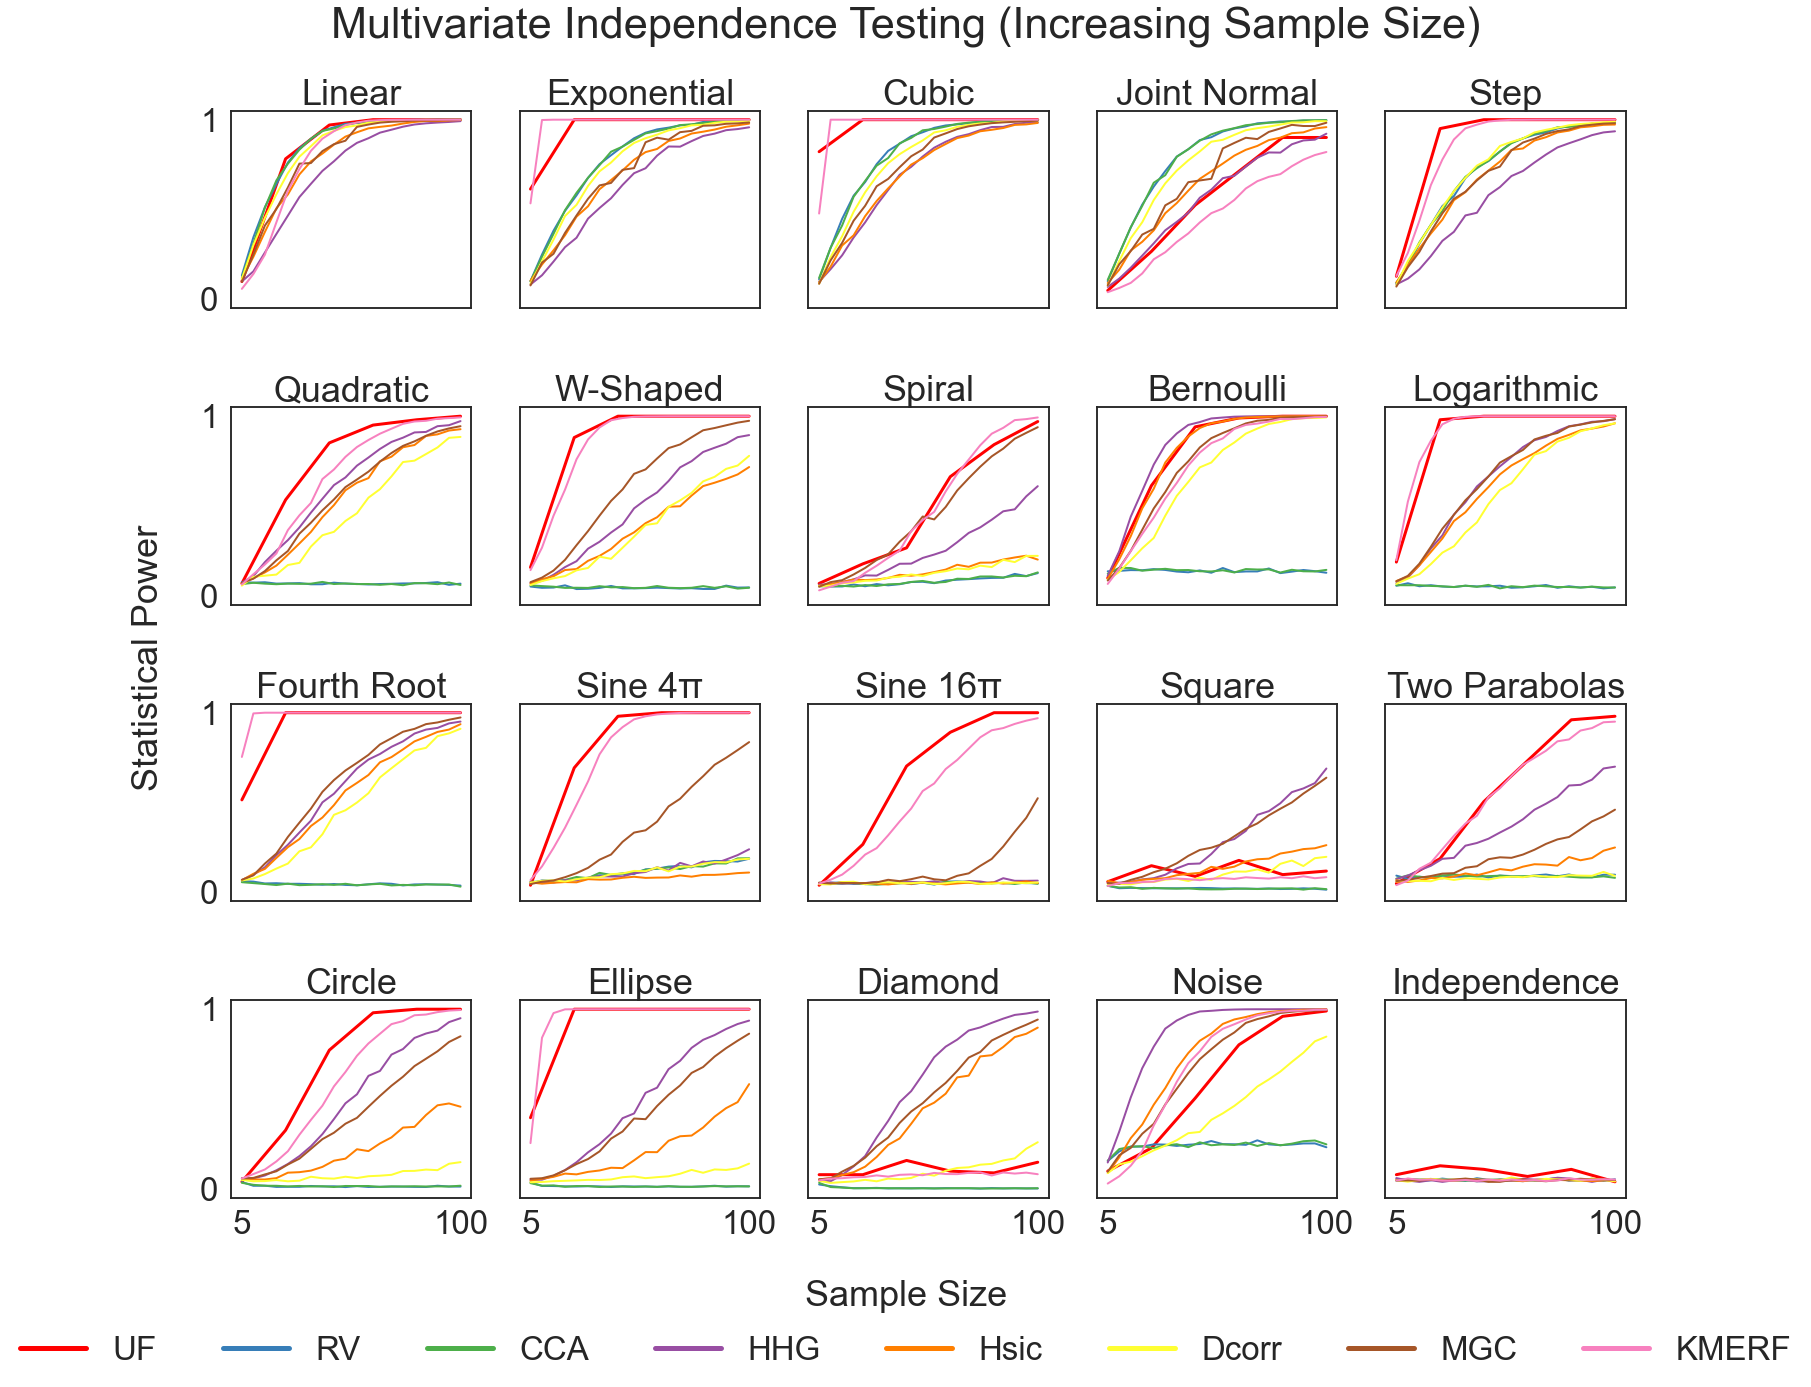

In [6]:
plot_power_all()